In [1]:
%reload_ext autoreload
%autoreload 2

import os
import sys
import time

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

sys.path.append(os.path.join(os.environ['REPO_DIR'], 'utilities'))
from utilities2015 import *
from metadata import *
from data_manager import *
from learning_utilities import *

/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)
No vtk


Setting environment for AWS compute node


In [109]:
sec1 = np.random.choice(metadata_cache['valid_sections']['MD589'], 1)[0]

In [110]:
im1 = img_as_ubyte(rgb2gray(DataManager.load_image(stack='MD589', version='cropped', resol='lossless', section=sec1)))
im2 = img_as_ubyte(rgb2gray(DataManager.load_image(stack='MD589', version='cropped', resol='lossless', section=sec1+2)))
# im2 = im1.copy()

In [157]:
# Lossless, fixed image is this number larger on left/right/top/bottom than moving image.
margin = 1000

In [203]:
# xmin = 113
# ymin = 183
# w = 118
# h = 130

xmin = np.random.randint(margin/32, (im1.shape[1]-margin)/32 - 120, 1)[0]
ymin = np.random.randint(margin/32, (im1.shape[0]-margin)/32 - 120, 1)[0]
w = 120
h = 120

xmax = xmin + w - 1
ymax = ymin + h - 1

In [204]:
downsample_factor = 25./XY_PIXEL_DISTANCE_LOSSLESS

In [205]:
xmax*32+margin

13064

In [206]:
im1_cropped = im1[ymin*32 - margin:ymax*32 + margin, xmin*32-margin:xmax*32+margin]
im1_cropped_downsampled = img_as_ubyte(gaussian(img_as_float(im1_cropped), sigma=downsample_factor/2.))

im2_cropped = im2[ymin*32:ymax*32, xmin*32:xmax*32]
im2_cropped_downsampled = img_as_ubyte(gaussian(img_as_float(im2_cropped), sigma=downsample_factor/2.))

In [210]:
from skimage.transform import warp

In [211]:
im1_cropped_downsampled_padded = np.pad(im1_cropped_downsampled, 1000, mode='constant', constant_values=255)
imsave('/home/ubuntu/im1.tif', im1_cropped_downsampled_padded)

im1_cropped_lossless_padded = np.pad(im1_cropped, 1000, mode='constant', constant_values=255)

In [212]:
im2_cropped_downsampled_padded = np.pad(im2_cropped_downsampled, 1000 + margin, mode='constant', constant_values=255)

im2_cropped_lossless_padded = np.pad(im2_cropped, 1000 + margin, mode='constant', constant_values=255)

In [213]:
assert im1_cropped_lossless_padded.shape == im2_cropped_lossless_padded.shape

In [234]:
c2 = np.array([im2_cropped_downsampled_padded.shape[1]/2, im2_cropped_downsampled_padded.shape[0]/2])
c1 = np.array([im1_cropped_downsampled_padded.shape[1]/2, im1_cropped_downsampled_padded.shape[0]/2])

angle_deg = 15
angle_rad = np.deg2rad(angle_deg)

R = np.array([[np.cos(angle_rad), np.sin(angle_rad)],
                      [-np.sin(angle_rad), np.cos(angle_rad)]])
t = np.array([1000, 1000])
# t = np.array([500, 500])

# T = np.eye(3)
# T[:2, :2] = R
# T[:2, 2] = c1 - np.dot(R, c2) + t

# skimage.transform.warp needs T that maps from output image to input image
T = np.eye(3)
T[:2, :2] = np.linalg.inv(R)
T[:2, 2] = np.dot(np.linalg.inv(R), -t-c1) + c2

In [235]:
im2_cropped_downsampled_padded_transformed = img_as_ubyte(warp(im2_cropped_downsampled_padded, T, cval=0.))
imsave('/home/ubuntu/im2.tif', im2_cropped_downsampled_padded_transformed)

In [236]:
im2_cropped_lossless_transformed = img_as_ubyte(warp(im2_cropped_lossless_padded, T, cval=0.))

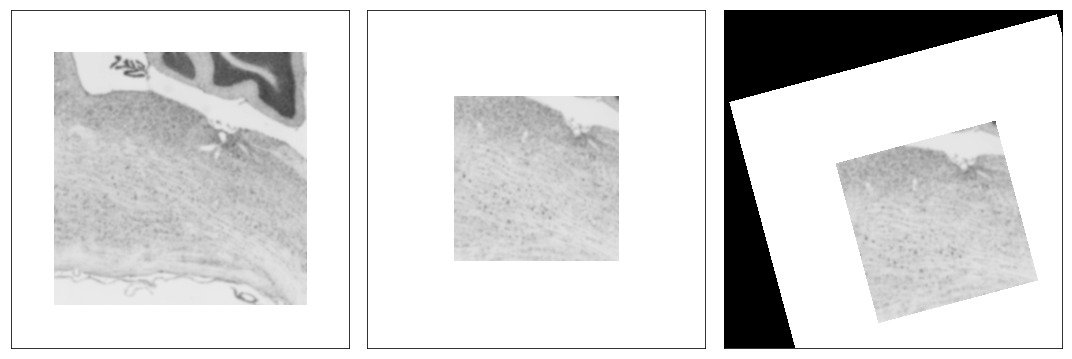

In [237]:
display_images_in_grids([im1_cropped_downsampled_padded, im2_cropped_downsampled_padded, im2_cropped_downsampled_padded_transformed],
                       nc=3, vmin=0, vmax=255, cmap=plt.cm.gray)

In [238]:
im1_cropped_downsampled_padded_mask = (im1_cropped_downsampled_padded != 0) & (im1_cropped_downsampled_padded != 255)
imsave('/home/ubuntu/im1_mask.png', im1_cropped_downsampled_padded_mask)

im2_cropped_downsampled_padded_transformed_mask = (im2_cropped_downsampled_padded_transformed != 0) & (im2_cropped_downsampled_padded_transformed != 255)
imsave('/home/ubuntu/im2_mask.png', im2_cropped_downsampled_padded_transformed_mask)

In [239]:
! mkdir /home/ubuntu/test

mkdir: cannot create directory ‘/home/ubuntu/test’: File exists


In [260]:
! elastix -f /home/ubuntu/im1.tif -m /home/ubuntu/im2.tif -fMask /home/ubuntu/im1_mask.png \
-mMask /home/ubuntu/im2_mask.png -out /home/ubuntu/test -p /shared/MouseBrainAtlas/preprocess/parameters/Parameters_Rigid_erodeMask.txt


elastix is started at Wed Jun 28 10:16:18 2017.

which elastix:   elastix
elastix runs at: ip-172-31-22-74
  Linux 4.4.0-38-generic (x64), #57-Ubuntu SMP Tue Sep 6 15:42:33 UTC 2016
  with 64414 MB memory, and 1 cores @ 2300 MHz.
-------------------------------------------------------------------------

Running elastix with parameter file 0: "/shared/MouseBrainAtlas/preprocess/parameters/Parameters_Rigid_erodeMask.txt".

Current time: Wed Jun 28 10:16:18 2017.
Reading the elastix parameters from file ...

Installing all components.
InstallingComponents was successful.

ELASTIX version: 4.800
Command line options from ElastixBase:
-f        /home/ubuntu/im1.tif
-m        /home/ubuntu/im2.tif
-fMask    /home/ubuntu/im1_mask.png
-mMask    /home/ubuntu/im2_mask.png
-out      /home/ubuntu/test/
-p        /shared/MouseBrainAtlas/preprocess/parameters/Parameters_Rigid_erodeMask.txt
-threads  unspecified, so all available threads are used
Command line options from TransformBase:
-t0       uns

75	-0.268775	0.000000	451.533431	0.000715	1.1
76	-0.148824	0.000000	451.533431	0.000641	1.0
77	-0.223275	0.000000	451.533431	0.000986	1.0
78	-0.175437	0.000000	451.533431	0.001389	1.0
79	-0.205728	0.000000	451.533431	0.001002	1.0
80	-0.198928	0.000000	451.533431	0.001086	1.0
81	-0.180433	0.000000	451.533431	0.000744	1.1
82	-0.181217	0.000000	451.533431	0.001091	1.1
83	-0.141586	0.000000	451.533431	0.000508	1.0
84	-0.173886	0.000000	451.533431	0.001382	1.0
85	-0.204690	0.000000	451.533431	0.000266	1.0
86	-0.234169	0.000000	451.533431	0.000797	1.1
87	-0.144874	0.000000	451.533431	0.001173	1.0
88	-0.176381	0.000000	451.533431	0.000987	1.0
89	-0.179796	0.000000	451.533431	0.001751	1.0
90	-0.185589	0.000000	451.533431	0.000815	1.0
91	-0.292132	0.000000	451.533431	0.000774	1.0
92	-0.123086	0.000000	451.533431	0.000431	1.0
93	-0.145721	0.000000	451.533431	0.001332	1.0
94	-0.146045	0.000000	451.533431	0.000474	1.0
95	-0.107764	0.000000	451.533431	0.001386	1.0
96	-0.189518	0.000000	451.533431	0

266	-0.310388	0.000000	451.533431	0.001001	1.0
267	-0.298765	0.000000	451.533431	0.001165	1.0
268	-0.330584	0.000000	451.533431	0.001299	1.0
269	-0.226072	0.000000	451.533431	0.000930	1.0
270	-0.246142	0.000000	451.533431	0.001086	1.0
271	-0.303369	0.000000	451.533431	0.001368	1.0
272	-0.199794	0.000000	451.533431	0.001188	1.1
273	-0.353376	0.000000	451.533431	0.000826	1.0
274	-0.210856	0.000000	451.533431	0.002611	1.0
275	-0.249892	0.000000	451.533431	0.001636	1.1
276	-0.289768	0.000000	451.533431	0.002121	1.0
277	-0.240813	0.000000	451.533431	0.001172	1.0
278	-0.323797	0.000000	451.533431	0.002128	1.0
279	-0.275993	0.000000	451.533431	0.002351	1.0
280	-0.220677	0.000000	451.533431	0.001856	0.9
281	-0.267190	0.000000	451.533431	0.001294	1.1
282	-0.283707	0.000000	451.533431	0.001210	1.0
283	-0.259499	0.000000	451.533431	0.002172	1.1
284	-0.283633	0.000000	451.533431	0.000445	1.0
285	-0.300504	0.000000	451.533431	0.001493	0.9
286	-0.302026	0.000000	451.533431	0.001615	1.0
287	-0.196595

455	-0.427805	0.000000	451.533431	0.001725	1.0
456	-0.398386	0.000000	451.533431	0.000571	1.0
457	-0.382185	0.000000	451.533431	0.001210	1.0
458	-0.347811	0.000000	451.533431	0.002085	1.1
459	-0.432771	0.000000	451.533431	0.001258	1.0
460	-0.429860	0.000000	451.533431	0.000745	1.1
461	-0.393971	0.000000	451.533431	0.000546	1.0
462	-0.405603	0.000000	451.533431	0.000911	1.0
463	-0.440512	0.000000	451.533431	0.001143	1.1
464	-0.496460	0.000000	451.533431	0.000957	1.1
465	-0.431571	0.000000	451.533431	0.000413	1.1
466	-0.399900	0.000000	451.533431	0.001183	1.0
467	-0.380303	0.000000	451.533431	0.000979	1.0
468	-0.417389	0.000000	451.533431	0.000995	1.0
469	-0.436431	0.000000	451.533431	0.000880	1.0
470	-0.418056	0.000000	451.533431	0.001182	1.1
471	-0.421602	0.000000	451.533431	0.000947	1.0
472	-0.396939	0.000000	451.533431	0.001334	1.1
473	-0.388541	0.000000	451.533431	0.000983	1.0
474	-0.468560	0.000000	451.533431	0.000583	1.1
475	-0.382528	0.000000	451.533431	0.001053	1.1
476	-0.407429

641	-0.427955	0.551246	439.983931	0.000910	1.1
642	-0.379291	0.244814	446.330196	0.000760	1.0
643	-0.499919	0.000000	451.533431	0.000578	1.0
644	-0.486270	0.000000	451.533431	0.000335	1.0
645	-0.440022	0.000000	451.533431	0.000542	1.0
646	-0.445366	0.000000	451.533431	0.001006	1.0
647	-0.476837	0.000000	451.533431	0.000591	1.0
648	-0.460399	0.000000	451.533431	0.001030	1.1
649	-0.436218	0.000000	451.533431	0.000698	1.0
650	-0.478576	0.000000	451.533431	0.000307	1.0
651	-0.432285	0.000000	451.533431	0.000579	1.1
652	-0.488905	0.000000	451.533431	0.000247	1.0
653	-0.444518	0.000000	451.533431	0.000278	1.0
654	-0.392290	0.000000	451.533431	0.000271	1.1
655	-0.481207	0.000000	451.533431	0.000684	1.0
656	-0.437979	0.000000	451.533431	0.000428	1.0
657	-0.484683	0.000000	451.533431	0.000772	1.1
658	-0.426279	0.000000	451.533431	0.000478	1.0
659	-0.467020	0.000000	451.533431	0.000383	1.0
660	-0.445994	0.000000	451.533431	0.000580	1.1
661	-0.427587	0.000000	451.533431	0.000398	1.0
662	-0.437843

825	-0.479230	0.000000	451.533431	0.000644	1.1
826	-0.478389	0.000000	451.533431	0.000222	1.3
827	-0.465354	0.988119	431.242069	0.000260	1.1
828	-0.430837	0.744093	436.081751	0.000257	1.0
829	-0.464822	0.470124	441.646360	0.000475	1.0
830	-0.467579	1.274859	425.690772	0.000549	1.1
831	-0.447962	0.968429	431.628586	0.000968	1.0
832	-0.519566	0.661997	437.734435	0.000940	1.0
833	-0.457403	0.355565	444.015509	0.001187	1.0
834	-0.498070	0.049133	450.479463	0.000459	1.0
835	-0.459345	0.000000	451.533431	0.000385	1.1
836	-0.430065	0.000000	451.533431	0.000542	1.0
837	-0.442143	0.969557	431.606429	0.000568	1.1
838	-0.458313	0.665319	437.667326	0.000155	1.0
839	-0.440263	0.424858	442.579459	0.000438	1.1
840	-0.395772	0.266266	445.879963	0.000538	1.0
841	-0.469487	0.000000	451.533431	0.000330	1.1
842	-0.496317	0.000000	451.533431	0.000306	1.1
843	-0.445360	0.000000	451.533431	0.000628	1.1
844	-0.490240	0.000000	451.533431	0.000563	1.1
845	-0.493383	0.000000	451.533431	0.000350	1.1
846	-0.457761

1009	-0.461054	5.110981	363.149979	0.000474	1.1
1010	-0.430407	4.909520	365.973661	0.000732	1.1
1011	-0.504189	5.414836	358.972590	0.000360	1.0
1012	-0.485988	5.245869	361.283598	0.000469	0.9
1013	-0.453682	4.940472	365.536986	0.000306	1.0
1014	-0.472222	5.891938	352.603898	0.001106	1.0
1015	-0.514654	6.888626	340.002485	0.000343	1.0
1016	-0.487493	6.582194	343.779838	0.000381	1.1
1017	-0.413224	6.375021	346.381550	0.000175	1.1
1018	-0.485671	7.157018	336.761587	0.000589	1.0
1019	-0.410729	7.731572	330.027262	0.000389	1.0
1020	-0.470592	8.553400	320.849780	0.000551	1.1
1021	-0.537100	8.246970	324.211431	0.000352	1.1
1022	-0.467052	8.969887	316.390988	0.000644	1.1
1023	-0.430753	8.663458	319.659364	0.000653	1.1
1024	-0.445047	8.357026	322.996006	0.000871	1.0
1025	-0.453092	8.056652	326.334980	0.000421	1.1
1026	-0.505121	9.056652	315.477654	0.000634	1.0
1027	-0.478676	10.056498	305.321037	0.000576	1.1
1028	-0.490200	9.750445	308.359835	0.000980	1.1
1029	-0.519927	9.444013	311.463610	0.00

1194	-0.500226	13.416650	275.512060	0.000244	1.1
1195	-0.456298	13.134866	277.786413	0.000701	1.0
1196	-0.453815	13.666513	273.526270	0.000346	1.1
1197	-0.455085	14.650113	265.979583	0.000541	1.1
1198	-0.473565	15.253838	261.550298	0.000904	1.0
1199	-0.490914	14.951814	263.747530	0.000932	1.1
1200	-0.507398	14.645381	266.014885	0.000759	1.1
1201	-0.419275	14.338949	268.321561	0.000464	1.1
1202	-0.501684	14.032517	270.668591	0.000401	1.0
1203	-0.463941	13.726090	273.057002	0.000363	1.1
1204	-0.465789	13.579734	274.212693	0.000664	1.1
1205	-0.511022	13.273311	276.664313	0.000884	1.0
1206	-0.450387	13.030445	278.638790	0.000391	1.0
1207	-0.495637	12.724013	281.170632	0.000717	1.1
1208	-0.467798	13.211484	277.164299	0.000281	1.1
1209	-0.502896	14.211379	269.293686	0.000300	1.0
1210	-0.484146	14.210674	269.299079	0.000245	1.2
1211	-0.431282	13.956976	271.253502	0.000380	1.1
1212	-0.480862	13.652339	273.638151	0.000383	1.0
1213	-0.453873	13.348759	276.056616	0.000414	0.9
1214	-0.468638	13.04

1381	-0.483210	21.295139	224.191296	0.000554	1.0
1382	-0.484442	22.292071	219.028610	0.000634	1.0
1383	-0.458136	23.292071	214.083513	0.000315	1.5
1384	-0.501618	23.065151	215.185963	0.000241	1.1
1385	-0.454329	23.469720	213.228284	0.000222	1.0
1386	-0.528725	23.210123	214.480334	0.000622	1.0
1387	-0.523759	22.909999	215.946303	0.000398	1.0
1388	-0.465862	22.603723	217.463130	0.000483	1.0
1389	-0.476444	23.603675	212.587909	0.000470	1.1
1390	-0.415904	23.364405	213.734458	0.000118	1.0
1391	-0.449827	23.079329	215.116753	0.000602	1.1
1392	-0.440489	22.921732	215.888617	0.000820	1.0
1393	-0.432865	22.615300	217.405406	0.000420	1.0
1394	-0.505272	22.308868	218.943658	0.000060	1.0
1395	-0.439938	22.255983	219.211339	0.000270	1.1
1396	-0.484764	22.219014	219.398849	0.000388	0.9
1397	-0.462537	21.932984	220.860538	0.000529	1.1
1398	-0.480652	21.853610	221.269622	0.000876	1.1
1399	-0.482986	22.769927	216.637376	0.000167	1.0
1400	-0.455780	22.468925	218.137487	0.000231	1.0
1401	-0.482126	22.40

1564	-0.505481	53.730026	126.886107	0.000803	1.1
1565	-0.455732	53.423594	127.408548	0.000338	1.0
1566	-0.447571	53.585843	127.131392	0.000454	1.1
1567	-0.468743	53.279450	127.655793	0.000421	1.1
1568	-0.520229	52.973030	128.184584	0.000276	1.0
1569	-0.488976	53.880050	126.631888	0.000294	1.0
1570	-0.536040	54.759116	125.162522	0.000396	1.2
1571	-0.462288	54.595119	125.434051	0.000869	1.1
1572	-0.444549	54.288687	125.944580	0.000435	1.0
1573	-0.417744	53.998340	126.432160	0.000478	1.0
1574	-0.474831	53.691909	126.950859	0.000385	1.0
1575	-0.418381	53.385486	127.473820	0.001050	1.0
1576	-0.534384	54.385486	125.782861	0.000333	1.1
1577	-0.504094	55.384901	124.137126	0.000553	1.2
1578	-0.490370	55.091231	124.616226	0.001003	1.1
1579	-0.494172	54.784799	125.120106	0.000443	1.1
1580	-0.442998	55.784799	123.490615	0.000511	1.0
1581	-0.418036	56.783922	121.904397	0.000704	1.0
1582	-0.499083	56.478361	122.385166	0.000247	1.1
1583	-0.415949	56.227180	122.783223	0.000593	1.0
1584	-0.457166	56.97

1750	-0.449217	70.159992	104.017145	0.000605	1.0
1751	-0.475612	69.864726	104.355149	0.000411	1.0
1752	-0.463042	69.744199	104.493755	0.000300	1.0
1753	-0.488430	69.441022	104.844039	0.000871	1.1
1754	-0.464935	70.440818	103.697695	0.000796	1.1
1755	-0.455702	70.134386	104.046370	0.000472	1.0
1756	-0.493477	69.827954	104.397398	0.000331	1.0
1757	-0.479770	69.598022	104.662352	0.000463	1.1
1758	-0.458868	69.554459	104.712701	0.001016	1.1
1759	-0.461345	69.248027	105.068247	0.000354	1.0
1760	-0.484084	68.941610	105.426199	0.000556	1.0
1761	-0.471430	68.635262	105.786515	0.000508	1.0
1762	-0.512985	69.457190	104.825300	0.001140	0.9
1763	-0.471200	69.150758	105.181612	0.000842	1.0
1764	-0.483123	70.150758	104.027682	0.000141	1.0
1765	-0.441637	71.018225	103.047000	0.000543	1.2
1766	-0.479313	71.965972	101.996481	0.000762	1.0
1767	-0.434369	71.659540	102.333791	0.000643	1.0
1768	-0.495775	72.659540	101.241177	0.000458	1.1
1769	-0.489042	73.659538	100.171650	0.000551	1.1
1770	-0.424567	73.52

1937	-0.434443	79.567416	94.287021	0.000658	1.1
1938	-0.466186	80.567330	93.358781	0.000446	1.0
1939	-0.560691	80.260898	93.641300	0.000399	1.2
1940	-0.467425	79.986463	93.895774	0.000667	1.0
1941	-0.526215	79.683607	94.178211	0.000774	1.1
1942	-0.508474	80.683607	93.252023	0.000252	1.0
1943	-0.479501	80.533317	93.390055	0.000896	1.1
1944	-0.453523	80.226885	93.672764	0.000773	1.0
1945	-0.468256	79.920453	93.957189	0.000691	1.1
1946	-0.408747	79.614020	94.243347	0.000438	1.1
1947	-0.449433	79.307588	94.531253	0.000581	1.1
1948	-0.386189	79.001603	94.820500	0.000658	1.1
1949	-0.485856	78.695171	95.111949	0.000330	1.1
1950	-0.520238	79.695156	94.167410	0.000512	1.1
1951	-0.451789	80.689023	93.247057	0.000663	1.1
1952	-0.534653	80.382590	93.528899	0.000525	0.9
1953	-0.436596	81.382589	92.615377	0.000241	1.0
1954	-0.487396	81.076755	92.892863	0.000411	1.1
1955	-0.444316	80.771497	93.171490	0.000760	1.1
1956	-0.447090	80.465065	93.452875	0.000613	1.0
1957	-0.451373	80.158633	93.735965	0.000

2119	-0.548771	99.218431	78.874778	0.000180	1.0
2120	-0.479799	99.307900	78.816122	0.000506	1.0
2121	-0.498472	100.286498	78.180195	0.000413	1.2
2122	-0.429602	99.989019	78.372419	0.000396	1.2
2123	-0.454426	99.682706	78.571341	0.000255	1.0
2124	-0.458277	100.669408	77.934152	0.000609	1.1
2125	-0.449870	101.668915	77.299143	0.000335	1.0
2126	-0.520857	101.364360	77.491534	0.000409	1.0
2127	-0.413167	101.060407	77.684503	0.001001	1.1
2128	-0.475999	101.221525	77.582096	0.000911	1.1
2129	-0.472431	100.915093	77.777097	0.000788	1.1
2130	-0.515887	100.608661	77.973082	0.000692	1.1
2131	-0.460446	100.302229	78.170056	0.000516	1.1
2132	-0.452877	99.995796	78.368029	0.000868	1.0
2133	-0.480532	99.689364	78.567006	0.000352	1.1
2134	-0.482250	99.382932	78.766997	0.000409	1.0
2135	-0.543656	99.076591	78.967948	0.000445	1.0
2136	-0.545899	98.771172	79.169318	0.000490	1.1
2137	-0.472539	99.771011	78.513892	0.000170	1.1
2138	-0.497528	100.612950	77.970332	0.000351	1.2
2139	-0.465101	100.557247	78.0

2304	-0.422032	118.969772	67.744642	0.000575	0.9
2305	-0.494894	118.666724	67.891633	0.000814	1.1
2306	-0.485388	118.372139	68.035133	0.000690	0.9
2307	-0.471206	118.065707	68.185049	0.000602	1.1
2308	-0.473692	117.759274	68.335627	0.000401	0.9
2309	-0.476995	117.452926	68.486830	0.000762	1.0
2310	-0.443459	118.449156	67.997558	0.000676	1.1
2311	-0.493324	119.431304	67.521997	0.000373	1.0
2312	-0.496874	120.430154	67.045123	0.000757	1.0
2313	-0.474847	120.125523	67.189845	0.000300	1.0
2314	-0.479193	121.075581	66.740547	0.000371	1.0
2315	-0.463954	120.870475	66.837036	0.000463	1.0
2316	-0.487206	121.490371	66.546266	0.000823	1.0
2317	-0.420003	121.183938	66.689685	0.000732	1.1
2318	-0.487713	122.183938	66.223923	0.000657	1.1
2319	-0.491019	123.183938	65.764621	0.000312	1.1
2320	-0.441406	122.878446	65.904257	0.000386	1.1
2321	-0.485038	122.574181	66.043922	0.000600	1.2
2322	-0.437868	122.951685	65.870727	0.001298	1.1
2323	-0.513792	122.645252	66.011246	0.000195	1.1
2324	-0.385721	122.3

2478	-0.496627	127.004428	64.067016	0.000315	1.1
2479	-0.455644	127.910509	63.677185	0.000612	1.1
2480	-0.463067	127.606931	63.807267	0.000711	1.1
2481	-0.488222	128.606931	63.380767	0.000293	1.1
2482	-0.463004	129.578754	62.971713	0.000313	1.1
2483	-0.505413	129.680947	62.929005	0.000175	1.2
2484	-0.480855	129.390503	63.050538	0.000468	1.0
2485	-0.479880	129.092203	63.175847	0.000881	1.1
2486	-0.511987	128.785771	63.305092	0.000299	1.0
2487	-0.439852	128.479378	63.434851	0.000400	1.1
2488	-0.445622	128.174166	63.564639	0.000603	1.2
2489	-0.458745	129.170358	63.142968	0.000286	1.1
2490	-0.483010	130.162271	62.728629	0.000170	1.1
2491	-0.476480	130.047880	62.776134	0.001158	1.1
2492	-0.508297	129.741617	62.903677	0.000296	1.1
2493	-0.448047	130.740856	62.489446	0.000959	1.1
2494	-0.492191	131.509386	62.174548	0.000401	1.1
2495	-0.444863	131.202953	62.299724	0.001030	1.1
2496	-0.486995	132.201512	61.893659	0.000301	1.0
2497	-0.392752	133.201511	61.492277	0.000421	1.1
2498	-0.476930	132.8

2649	-0.507083	143.664499	57.584981	0.000380	1.1
2650	-0.438334	143.359365	57.691888	0.000445	1.3
2651	-0.501620	144.102772	57.432119	0.000422	1.2
2652	-0.538844	143.796406	57.538888	0.000476	1.3
2653	-0.542916	143.490083	57.646041	0.000650	1.1
2654	-0.457030	143.639234	57.593818	0.000523	1.1
2655	-0.460987	144.368743	57.339748	0.000240	1.2
2656	-0.468698	144.063229	57.445878	0.000295	1.1
2657	-0.534424	143.834319	57.525654	0.000434	1.1
2658	-0.473142	144.791319	57.193598	0.000297	1.1
2659	-0.437795	144.485726	57.299214	0.000515	1.1
2660	-0.486369	144.213311	57.393693	0.000815	1.2
2661	-0.472410	143.906878	57.500343	0.000792	1.1
2662	-0.455736	143.600446	57.607390	0.000911	1.1
2663	-0.496634	143.294014	57.714836	0.000934	1.1
2664	-0.513841	142.987582	57.822683	0.000385	1.0
2665	-0.501424	143.987582	57.472217	0.000196	1.0
2666	-0.485350	143.807280	57.535092	0.000303	1.0
2667	-0.497911	143.533237	57.630921	0.000587	1.0
2668	-0.481099	143.374441	57.686596	0.000122	1.1
2669	-0.480955	143.1

2824	-0.478187	159.201143	52.620099	0.000316	1.0
2825	-0.469876	158.894773	52.709714	0.001016	1.1
2826	-0.515447	158.588341	52.799653	0.000469	1.1
2827	-0.444290	158.301922	52.883995	0.000334	1.1
2828	-0.457807	158.361066	52.866557	0.000496	1.0
2829	-0.529454	158.054659	52.957025	0.000192	1.2
2830	-0.459801	158.028699	52.964704	0.000442	1.0
2831	-0.463618	158.810406	52.734445	0.001030	1.2
2832	-0.491445	159.810406	52.442789	0.000321	1.0
2833	-0.491728	159.503978	52.531817	0.000415	1.0
2834	-0.480476	159.316834	52.586338	0.000561	1.1
2835	-0.477323	159.010430	52.675848	0.000477	1.1
2836	-0.508769	158.703998	52.765671	0.000201	1.1
2837	-0.434741	158.398659	52.855479	0.000586	1.1
2838	-0.451679	158.605660	52.794561	0.000214	1.1
2839	-0.463491	158.299824	52.884614	0.000319	1.1
2840	-0.486333	158.404626	52.853721	0.000584	1.1
2841	-0.537894	158.098236	52.944140	0.000419	1.0
2842	-0.505527	158.356330	52.867953	0.000345	1.1
2843	-0.425992	158.080683	52.949329	0.000472	1.1
2844	-0.552534	157.8

3001	-0.435719	161.059571	52.082964	0.000462	1.2
3002	-0.450626	160.753141	52.170774	0.000521	1.1
3003	-0.453471	160.640552	52.203112	0.000557	1.1
3004	-0.507652	161.640531	51.917293	0.000134	1.1
3005	-0.499843	161.346677	52.000959	0.000580	1.2
3006	-0.483112	161.324602	52.007255	0.000281	1.1
3007	-0.511710	162.316773	51.725774	0.000309	1.1
3008	-0.560062	162.410543	51.699329	0.000541	1.1
3009	-0.461806	162.104159	51.785837	0.000612	1.1
3010	-0.507303	163.103624	51.504701	0.000410	1.2
3011	-0.515292	162.877243	51.568111	0.000586	1.1
3012	-0.486402	162.574593	51.653129	0.000325	1.2
3013	-0.504187	162.268170	51.739492	0.000670	1.1
3014	-0.460860	161.983581	51.819961	0.000675	1.2
3015	-0.538853	162.983581	51.538306	0.000598	1.2
3016	-0.460149	163.983576	51.259697	0.000209	1.1
3017	-0.539831	163.740889	51.327035	0.000418	1.1
3018	-0.505529	163.451451	51.407576	0.000097	1.1
3019	-0.435096	163.181490	51.482926	0.000293	1.1
3020	-0.507366	163.397825	51.422526	0.000421	1.2
3021	-0.480366	163.0

3174	-0.500388	170.642764	49.478529	0.000468	1.3
3175	-0.550873	171.512533	49.254986	0.000511	1.2
3176	-0.446182	172.512261	49.000523	0.001150	1.2
3177	-0.533360	172.205829	49.078240	0.000354	1.1
3178	-0.475597	171.899397	49.156204	0.000583	1.1
3179	-0.465743	171.592970	49.234414	0.000316	1.0
3180	-0.477068	171.286544	49.312874	0.001179	1.1
3181	-0.483011	170.980112	49.391585	0.000889	1.1
3182	-0.525793	171.980112	49.135644	0.000613	1.1
3183	-0.485990	171.673679	49.213790	0.000786	1.0
3184	-0.490770	172.634977	48.969469	0.000576	1.2
3185	-0.456015	172.328544	49.047088	0.000710	1.0
3186	-0.420644	172.022112	49.124952	0.000888	1.0
3187	-0.486994	173.022112	48.871760	0.000499	1.1
3188	-0.500468	172.715680	48.949068	0.000484	1.1
3189	-0.522140	172.409250	49.026621	0.000412	1.0
3190	-0.498756	172.125723	49.098597	0.000587	1.1
3191	-0.443823	172.510594	49.000945	0.000197	1.1
3192	-0.464340	173.098061	48.852637	0.000221	1.1
3193	-0.564157	172.881088	48.907308	0.000567	1.1
3194	-0.465420	172.5

3346	-0.534961	184.094716	46.233283	0.000316	1.2
3347	-0.521664	183.930328	46.270370	0.000507	1.1
3348	-0.462760	183.623989	46.339640	0.000800	1.1
3349	-0.453865	183.317556	46.409140	0.000609	1.1
3350	-0.454207	183.227936	46.429505	0.000372	1.1
3351	-0.442406	184.227878	46.203285	0.000677	1.1
3352	-0.503364	183.921446	46.272375	0.000275	1.1
3353	-0.512104	183.729858	46.315677	0.000352	1.0
3354	-0.509504	183.663153	46.330773	0.000398	1.1
3355	-0.508267	183.367344	46.397834	0.000349	1.1
3356	-0.447383	183.061591	46.467353	0.000450	1.1
3357	-0.479423	182.762263	46.535614	0.000603	1.1
3358	-0.514245	182.455889	46.605690	0.000378	1.1
3359	-0.464888	183.343183	46.403320	0.000409	1.1
3360	-0.439875	183.061779	46.467310	0.000902	1.1
3361	-0.499413	182.755347	46.537194	0.000806	1.1
3362	-0.454908	182.448915	46.607287	0.000437	1.2
3363	-0.479559	183.448915	46.379322	0.000673	1.2
3364	-0.500071	183.142483	46.448941	0.000557	1.2
3365	-0.480081	184.142483	46.222518	0.000395	1.3
3366	-0.485828	184.4

3522	-0.507053	196.387833	43.618826	0.000537	1.2
3523	-0.486105	196.081403	43.680398	0.000357	1.1
3524	-0.415210	197.052862	43.485795	0.000111	1.0
3525	-0.432411	196.830628	43.530160	0.000876	1.0
3526	-0.479708	196.593076	43.577683	0.000405	1.0
3527	-0.429541	197.592747	43.378393	0.000545	1.0
3528	-0.448744	197.360835	43.424463	0.000496	1.1
3529	-0.551135	197.260891	43.444348	0.000619	1.2
3530	-0.448476	196.954459	43.505428	0.000461	1.1
3531	-0.531950	197.954452	43.306733	0.000371	1.1
3532	-0.402288	197.852109	43.326985	0.000051	1.1
3533	-0.438532	197.669525	43.363162	0.000091	1.1
3534	-0.444911	197.619460	43.373092	0.000549	1.1
3535	-0.511773	197.500773	43.396652	0.000789	1.1
3536	-0.487965	197.194342	43.457598	0.000425	1.2
3537	-0.470317	196.887909	43.518716	0.000518	1.1
3538	-0.519154	196.626441	43.571002	0.000543	1.2
3539	-0.492344	197.351179	43.426383	0.001053	1.2
3540	-0.543232	197.044747	43.487413	0.000397	1.1
3541	-0.498334	196.738319	43.548614	0.000919	1.1
3542	-0.481664	196.4

3698	-0.445474	205.194052	41.920652	0.000269	1.1
3699	-0.414469	206.185249	41.737754	0.000672	1.1
3700	-0.464884	206.023214	41.767544	0.000370	1.2
3701	-0.491732	205.716783	41.823997	0.000528	1.1
3702	-0.493203	205.410420	41.880590	0.000397	1.1
3703	-0.461175	206.406483	41.697149	0.000553	1.1
3704	-0.461168	206.100259	41.753374	0.001124	1.1
3705	-0.506245	205.818974	41.805154	0.000892	1.1
3706	-0.515274	205.512541	41.861709	0.000916	1.2
3707	-0.462847	205.206109	41.918417	0.000713	1.0
3708	-0.420903	204.899677	41.975279	0.000284	1.1
3709	-0.507476	204.652204	42.021314	0.000383	1.0
3710	-0.445098	204.857427	41.983132	0.000415	1.1
3711	-0.478302	204.551032	42.040162	0.000910	1.1
3712	-0.542640	204.244600	42.097356	0.000442	1.0
3713	-0.466327	203.938168	42.154705	0.000303	1.1
3714	-0.479032	203.686323	42.201955	0.000170	1.1
3715	-0.397538	203.663697	42.206205	0.000421	1.1
3716	-0.456418	203.984016	42.146114	0.000951	1.1
3717	-0.421081	204.984014	41.959614	0.000790	1.1
3718	-0.514951	204.6

3874	-0.472121	224.494037	38.624979	0.000274	1.1
3875	-0.489387	224.625031	38.604380	0.000455	1.1
3876	-0.460354	225.623029	38.448162	0.000413	1.1
3877	-0.503401	226.595268	38.297186	0.000402	1.1
3878	-0.494479	226.313222	38.340862	0.000755	1.1
3879	-0.429204	226.006790	38.388427	0.000443	1.1
3880	-0.469366	225.700358	38.436110	0.000646	1.0
3881	-0.476300	226.684915	38.283325	0.000751	1.1
3882	-0.488649	227.684886	38.129386	0.000882	1.1
3883	-0.426671	227.378453	38.176428	0.000301	1.1
3884	-0.445795	227.077071	38.222807	0.000673	1.1
3885	-0.438617	228.076604	38.069421	0.001127	1.0
3886	-0.478785	227.770171	38.116314	0.000251	1.1
3887	-0.452225	227.463739	38.163323	0.000537	1.0
3888	-0.495170	227.400569	38.173029	0.000385	1.2
3889	-0.460567	227.097811	38.219612	0.000499	1.2
3890	-0.468070	226.791407	38.266872	0.000443	1.1
3891	-0.510706	226.484984	38.314252	0.000435	1.1
3892	-0.460827	227.414199	38.170934	0.000543	1.0
3893	-0.506595	227.107808	38.218072	0.000461	1.1
3894	-0.460139	226.9

4047	-0.522171	240.025280	36.326758	0.000359	1.3
4048	-0.503953	239.722766	36.368907	0.000245	1.2
4049	-0.483547	239.632289	36.381532	0.000600	1.2
4050	-0.450817	239.450067	36.406986	0.000491	1.1
4051	-0.536791	239.143896	36.449835	0.000459	1.1
4052	-0.486236	240.138616	36.310991	0.000414	1.1
4053	-0.473929	241.128577	36.173858	0.000429	1.1
4054	-0.525680	241.971994	36.057840	0.000452	1.1
4055	-0.446234	242.969246	35.921617	0.000113	1.1
4056	-0.483910	243.521614	35.846606	0.001257	1.1
4057	-0.515815	244.492339	35.715539	0.000157	1.1
4058	-0.424668	244.185982	35.756800	0.000792	1.0
4059	-0.532121	243.880539	35.798032	0.000211	1.1
4060	-0.547266	243.592501	35.837002	0.000369	1.1
4061	-0.503207	243.298617	35.876851	0.000436	1.1
4062	-0.489599	242.992573	35.918442	0.000427	1.2
4063	-0.461802	243.385534	35.865056	0.000405	1.1
4064	-0.447710	243.080721	35.906453	0.000272	1.3
4065	-0.506054	242.818020	35.942208	0.000271	1.2
4066	-0.512222	242.519838	35.982878	0.000103	1.1
4067	-0.448703	242.2

4221	-0.510336	252.257780	34.700575	0.000453	1.1
4222	-0.511011	253.257745	34.574054	0.000406	1.3
4223	-0.472217	252.951335	34.612724	0.000749	1.1
4224	-0.495583	252.644903	34.651484	0.000246	1.1
4225	-0.495943	253.644547	34.525361	0.000239	1.2
4226	-0.497921	253.371504	34.559719	0.000416	1.1
4227	-0.467145	253.088078	34.595456	0.001135	1.1
4228	-0.464307	252.781670	34.634174	0.000468	1.2
4229	-0.467914	253.781666	34.508132	0.000203	1.1
4230	-0.446400	254.768258	34.384676	0.000453	1.1
4231	-0.520285	255.494729	34.294332	0.000303	1.1
4232	-0.510997	256.458888	34.175161	0.000422	1.1
4233	-0.455089	256.534997	34.165789	0.000373	1.1
4234	-0.471210	256.228861	34.203517	0.000362	1.1
4235	-0.471949	255.987365	34.233338	0.000640	1.3
4236	-0.527780	255.680933	34.271252	0.000820	1.0
4237	-0.473306	256.680933	34.147833	0.000226	1.0
4238	-0.465976	257.651891	34.028845	0.000423	1.0
4239	-0.456858	258.444276	33.932354	0.000507	1.0
4240	-0.399711	258.148119	33.968354	0.000407	1.1
4241	-0.445920	258.0

4397	-0.453199	278.316976	31.679466	0.000656	1.2
4398	-0.443005	279.308638	31.574856	0.000505	1.1
4399	-0.454347	279.002208	31.607108	0.000315	1.2
4400	-0.489759	279.968793	31.505599	0.000552	1.1
4401	-0.474540	280.700505	31.429189	0.000551	1.0
4402	-0.461260	281.700466	31.325363	0.000785	1.1
4403	-0.477391	281.394047	31.357106	0.000521	1.1
4404	-0.514508	281.087615	31.388914	0.000526	1.1
4405	-0.467867	281.374232	31.359160	0.000248	1.0
4406	-0.457740	282.371056	31.256120	0.000360	1.2
4407	-0.439884	283.342340	31.156368	0.000212	1.1
4408	-0.516708	283.824800	31.107056	0.000490	1.1
4409	-0.493288	283.521504	31.138038	0.000548	1.1
4410	-0.435372	283.215687	31.169340	0.000339	1.0
4411	-0.490071	283.936752	31.095635	0.000287	1.1
4412	-0.484518	283.632430	31.126699	0.000136	1.1
4413	-0.429055	283.801266	31.109458	0.000239	1.1
4414	-0.502457	283.714603	31.118305	0.000240	1.1
4415	-0.512955	283.422387	31.148176	0.000263	1.1
4416	-0.488139	283.134452	31.177665	0.000277	1.0
4417	-0.471083	283.2

4572	-0.480032	284.894317	30.998294	0.000398	1.2
4573	-0.440802	284.594455	31.028711	0.000391	1.2
4574	-0.522499	284.294675	31.059179	0.000869	1.0
4575	-0.485843	285.273415	30.959925	0.000619	1.1
4576	-0.549487	286.273415	30.859168	0.000155	1.2
4577	-0.462997	286.036464	30.882984	0.000637	1.0
4578	-0.505164	286.044874	30.882138	0.000436	1.0
4579	-0.542444	285.740294	30.912802	0.000383	1.1
4580	-0.492709	285.459662	30.941110	0.000365	1.2
4581	-0.491985	285.153927	30.972009	0.000463	1.0
4582	-0.452762	284.847569	31.003032	0.000397	1.1
4583	-0.497536	284.541283	31.034111	0.000250	1.2
4584	-0.528465	284.250344	31.063690	0.000404	1.0
4585	-0.501286	283.953920	31.093885	0.000801	1.0
4586	-0.478157	283.647488	31.125161	0.000879	1.1
4587	-0.454566	283.341056	31.156500	0.000374	1.1
4588	-0.510435	284.340979	31.054469	0.000442	1.1
4589	-0.527596	285.217591	30.965569	0.000217	1.2
4590	-0.496767	285.089203	30.978558	0.000286	1.2
4591	-0.456410	285.356715	30.951507	0.000487	1.1
4592	-0.492440	285.2

4746	-0.477993	293.215185	30.177415	0.000203	1.1
4747	-0.459871	294.212145	30.081969	0.000341	1.1
4748	-0.472983	293.956916	30.106346	0.000155	1.1
4749	-0.512363	293.676855	30.133141	0.000682	1.1
4750	-0.465032	293.871726	30.114492	0.000464	1.1
4751	-0.468325	294.871486	30.019177	0.000615	1.1
4752	-0.506274	295.468171	29.962577	0.000716	1.0
4753	-0.505308	295.161739	29.991618	0.000510	1.1
4754	-0.525335	294.855307	30.020715	0.000518	1.1
4755	-0.449896	294.548875	30.049868	0.000611	1.1
4756	-0.463105	294.746925	30.031020	0.000332	1.1
4757	-0.527908	294.444393	30.059821	0.000290	1.2
4758	-0.443306	294.686776	30.036741	0.000245	1.0
4759	-0.458750	294.505980	30.053954	0.000335	1.1
4760	-0.465939	294.204181	30.082729	0.000659	1.1
4761	-0.456336	293.916033	30.110255	0.000520	1.1
4762	-0.487943	293.609601	30.139583	0.000672	1.1
4763	-0.387327	293.303169	30.168967	0.000700	1.1
4764	-0.474145	292.996737	30.198410	0.000981	1.1
4765	-0.508325	293.070433	30.191323	0.000628	1.1
4766	-0.392069	292.7

4920	-0.488172	316.685474	28.079982	0.000204	1.3
4921	-0.507618	316.394710	28.104181	0.000449	1.4
4922	-0.476004	316.129527	28.126288	0.000632	1.1
4923	-0.550522	315.823098	28.151876	0.000475	1.1
4924	-0.502915	316.823012	28.068550	0.000389	1.0
4925	-0.477902	316.666358	28.081572	0.000418	1.1
4926	-0.543688	316.366143	28.106561	0.000188	1.0
4927	-0.508893	316.124269	28.126726	0.000555	1.1
4928	-0.455278	315.855418	28.149175	0.000572	1.2
4929	-0.439493	315.548985	28.174805	0.000387	1.0
4930	-0.476212	315.243759	28.200381	0.000427	1.1
4931	-0.447918	314.937406	28.226098	0.000590	1.1
4932	-0.510654	314.696884	28.246321	0.000609	1.2
4933	-0.459669	314.390452	28.272129	0.000390	1.1
4934	-0.470197	315.390376	28.188090	0.000860	1.1
4935	-0.479194	315.083944	28.213791	0.000738	1.0
4936	-0.477905	314.777512	28.239539	0.000441	1.0
4937	-0.480309	315.773145	28.156052	0.000510	1.1
4938	-0.482920	316.763261	28.073515	0.000724	1.2
4939	-0.467186	317.763260	27.990645	0.000706	1.1
4940	-0.488746	318.7

5091	-0.486838	336.849238	26.497757	0.000582	1.3
5092	-0.470953	336.792975	26.501923	0.001461	1.2
5093	-0.453485	336.486543	26.524641	0.000777	1.1
5094	-0.476299	337.486543	26.450650	0.000498	1.2
5095	-0.491955	337.180176	26.473274	0.000628	1.1
5096	-0.476502	336.889047	26.494809	0.000631	1.1
5097	-0.478279	336.582615	26.517514	0.000899	1.2
5098	-0.466975	336.276183	26.540258	0.000232	1.1
5099	-0.487872	335.969766	26.563040	0.000714	1.1
5100	-0.469157	336.935374	26.491380	0.000367	1.2
5101	-0.483149	336.628943	26.514079	0.000487	1.1
5102	-0.558609	337.442550	26.453896	0.000590	1.1
5103	-0.454608	337.136118	26.476531	0.000288	1.1
5104	-0.505604	337.895626	26.420500	0.000373	1.2
5105	-0.482280	337.590290	26.442997	0.000614	1.1
5106	-0.475352	337.283868	26.465613	0.000319	1.2
5107	-0.412247	337.137929	26.476397	0.000242	1.2
5108	-0.438533	336.967267	26.489020	0.000294	1.2
5109	-0.494697	336.787941	26.502296	0.000727	1.1
5110	-0.509782	337.395837	26.457344	0.000824	1.1
5111	-0.463092	337.0

5262	-0.512927	358.270830	25.001137	0.000285	1.1
5263	-0.465894	357.964695	25.021334	0.000645	1.2
5264	-0.472687	358.961777	24.955673	0.000281	1.1
5265	-0.493272	359.893663	24.894618	0.000395	1.2
5266	-0.540588	359.587847	24.914621	0.000397	1.2
5267	-0.516722	360.486425	24.855936	0.000939	1.2
5268	-0.422350	360.179992	24.875918	0.000442	1.1
5269	-0.509735	359.875994	24.895772	0.000548	1.1
5270	-0.469022	360.856137	24.831870	0.000386	1.2
5271	-0.439927	361.855928	24.767024	0.000378	1.1
5272	-0.515512	361.723825	24.775573	0.000619	1.1
5273	-0.479394	361.419061	24.795318	0.000864	1.2
5274	-0.381670	361.112691	24.815198	0.000241	1.1
5275	-0.486946	360.858043	24.831746	0.000796	1.1
5276	-0.481358	361.799429	24.770680	0.000282	1.2
5277	-0.480935	362.770258	24.708017	0.000309	1.1
5278	-0.483450	362.468101	24.727486	0.000413	1.1
5279	-0.434201	362.162159	24.747230	0.000430	1.1
5280	-0.471273	361.857461	24.766925	0.000647	1.0
5281	-0.520276	362.837544	24.703686	0.000359	1.1
5282	-0.474792	362.5

5434	-0.465032	369.215064	24.299938	0.000627	1.1
5435	-0.486766	370.214440	24.237863	0.000342	1.1
5436	-0.452154	370.976459	24.190744	0.000270	1.1
5437	-0.504679	370.758616	24.204195	0.000782	1.1
5438	-0.517788	371.757142	24.142660	0.000655	1.1
5439	-0.434634	371.450710	24.161511	0.000250	1.1
5440	-0.474576	372.430167	24.101360	0.000537	1.0
5441	-0.487970	373.425124	24.040563	0.000517	1.1
5442	-0.496629	374.425047	23.979771	0.000529	1.1
5443	-0.484084	374.375888	23.982752	0.000255	1.0
5444	-0.440636	374.069760	24.001336	0.001206	1.1
5445	-0.409038	373.763328	24.019967	0.000682	1.0
5446	-0.524665	374.763328	23.959274	0.000551	1.0
5447	-0.453212	375.760570	23.899053	0.000671	1.0
5448	-0.459773	375.460094	23.917166	0.000040	1.0
5449	-0.457635	375.700172	23.902692	0.000729	1.1
5450	-0.439769	375.989896	23.885248	0.000732	1.1
5451	-0.470958	375.683464	23.903699	0.000645	1.2
5452	-0.501806	376.679735	23.843815	0.000538	1.1
5453	-0.456822	376.373303	23.862202	0.000368	1.1
5454	-0.467305	377.3

5609	-0.496676	388.152589	23.175222	0.000356	1.3
5610	-0.488782	387.846927	23.192548	0.000274	1.3
5611	-0.504850	387.609834	23.206005	0.000373	1.1
5612	-0.472309	387.311584	23.222956	0.000362	1.1
5613	-0.490070	387.154664	23.231885	0.000580	1.1
5614	-0.474402	386.849641	23.249259	0.000502	1.1
5615	-0.430440	387.824550	23.193818	0.000359	1.2
5616	-0.454146	387.891508	23.190019	0.000082	1.0
5617	-0.429886	387.688753	23.201524	0.000560	1.2
5618	-0.474062	388.441392	23.158875	0.000337	1.1
5619	-0.478795	388.134975	23.176220	0.000366	1.1
5620	-0.487246	387.828801	23.193576	0.000471	1.1
5621	-0.544212	387.522384	23.210973	0.000324	1.1
5622	-0.510412	388.521627	23.154338	0.000964	1.2
5623	-0.460577	389.521627	23.097935	0.000441	1.2
5624	-0.443078	390.512921	23.042295	0.000526	1.1
5625	-0.452306	391.512742	22.986446	0.000392	1.1
5626	-0.467077	392.463988	22.933562	0.000436	1.1
5627	-0.578849	392.373334	22.938592	0.000446	1.2
5628	-0.484647	393.134227	22.896446	0.000417	1.1
5629	-0.463292	392.8

5782	-0.456281	412.000599	21.898820	0.000438	1.2
5783	-0.498264	412.888246	21.854019	0.000382	1.1
5784	-0.463810	412.584026	21.869353	0.000286	1.2
5785	-0.454503	412.328881	21.882230	0.000258	1.1
5786	-0.512230	412.029998	21.897333	0.000390	1.0
5787	-0.477226	411.754239	21.911286	0.000442	1.1
5788	-0.465132	411.492266	21.924559	0.000448	1.1
5789	-0.446926	412.492045	21.873993	0.000976	1.0
5790	-0.498469	412.185633	21.889466	0.000400	1.0
5791	-0.473221	413.185611	21.839052	0.000299	1.1
5792	-0.549221	413.767389	21.809828	0.000416	1.1
5793	-0.456580	414.755749	21.760360	0.000595	1.1
5794	-0.460280	414.463245	21.774977	0.000696	1.0
5795	-0.495344	415.463244	21.725087	0.000214	1.2
5796	-0.489308	415.156928	21.740345	0.000600	1.0
5797	-0.510985	414.850793	21.755615	0.000890	1.0
5798	-0.452082	415.850793	21.705814	0.000389	1.0
5799	-0.443154	415.546003	21.720969	0.000707	1.0
5800	-0.464196	415.239572	21.736226	0.000649	1.1
5801	-0.507105	414.933140	21.751505	0.000701	1.1
5802	-0.467742	414.6

5955	-0.464896	424.595575	21.279839	0.000719	1.1
5956	-0.535457	425.595509	21.232193	0.000762	1.3
5957	-0.484216	425.289077	21.246772	0.000439	1.2
5958	-0.520939	424.982644	21.261370	0.000267	1.1
5959	-0.519052	424.679728	21.275821	0.000696	1.2
5960	-0.492874	425.675675	21.228382	0.000239	1.1
5961	-0.503377	426.299721	21.198766	0.000427	1.1
5962	-0.521046	425.994350	21.213248	0.000462	1.1
5963	-0.501756	425.687984	21.227797	0.000537	1.1
5964	-0.510655	425.381558	21.242370	0.000555	1.2
5965	-0.518192	425.075144	21.256961	0.000606	1.1
5966	-0.501323	424.768713	21.271574	0.000421	1.2
5967	-0.491259	424.462348	21.286203	0.000464	1.2
5968	-0.404951	425.423197	21.240388	0.000345	1.1
5969	-0.422577	425.117184	21.254958	0.000490	1.1
5970	-0.486298	425.830631	21.221021	0.000333	1.2
5971	-0.510580	426.765282	21.176725	0.000313	1.1
5972	-0.483235	426.459583	21.191192	0.000584	1.1
5973	-0.493991	426.195496	21.203707	0.000670	1.2
5974	-0.499539	425.889064	21.218246	0.000473	1.3
5975	-0.503687	426.7

6127	-0.508015	433.138808	20.879524	0.000467	1.3
6128	-0.467227	432.832376	20.893622	0.000581	1.1
6129	-0.509659	432.525944	20.907739	0.000475	1.1
6130	-0.500844	432.219553	20.921873	0.000561	1.7
6131	-0.470550	433.019076	20.885030	0.000630	1.0
6132	-0.489758	434.019076	20.839131	0.000166	1.0
6133	-0.472906	433.716399	20.853002	0.000587	1.1
6134	-0.447875	433.421653	20.866528	0.000485	1.1
6135	-0.503064	433.115533	20.880594	0.000803	1.1
6136	-0.583156	434.115112	20.834733	0.000263	1.1
6137	-0.452122	435.114554	20.789080	0.000573	1.1
6138	-0.462855	434.811514	20.802902	0.000267	1.1
6139	-0.481195	435.086584	20.790355	0.000395	1.1
6140	-0.480814	434.786608	20.804038	0.000334	1.2
6141	-0.471780	435.690210	20.762876	0.000730	1.1
6142	-0.462458	435.383778	20.776817	0.000391	1.1
6143	-0.529666	435.077350	20.790776	0.000262	1.2
6144	-0.467311	434.787632	20.803992	0.000562	1.2
6145	-0.502060	434.481576	20.817971	0.000887	1.1
6146	-0.471984	434.175144	20.831986	0.000477	1.1
6147	-0.448489	433.8

6300	-0.499795	439.764608	20.579276	0.000211	1.1
6301	-0.490452	439.459139	20.592928	0.000391	1.2
6302	-0.512409	439.167795	20.605966	0.000292	1.1
6303	-0.470981	438.861715	20.619681	0.000690	1.1
6304	-0.445335	438.561000	20.633174	0.001117	1.1
6305	-0.469509	439.561000	20.588374	0.000225	1.1
6306	-0.543659	440.560981	20.543769	0.000167	1.0
6307	-0.507733	440.941249	20.526857	0.000264	1.0
6308	-0.515164	440.669586	20.538936	0.000456	1.2
6309	-0.513545	440.367930	20.552365	0.000486	1.1
6310	-0.515260	440.070134	20.565639	0.000362	1.1
6311	-0.427186	441.058787	20.521636	0.000612	1.0
6312	-0.500101	441.975740	20.480991	0.000160	1.1
6313	-0.476451	441.671343	20.494466	0.000433	1.2
6314	-0.471461	441.376178	20.507549	0.000620	1.1
6315	-0.547324	441.069777	20.521148	0.000498	1.1
6316	-0.505006	440.763345	20.534766	0.000439	1.1
6317	-0.456927	440.456948	20.548400	0.001186	1.0
6318	-0.481591	440.150516	20.562055	0.000498	1.2
6319	-0.506138	439.844084	20.575727	0.000552	1.2
6320	-0.517817	440.8

6474	-0.527705	444.493537	20.370212	0.000514	1.1
6475	-0.524292	444.187113	20.383630	0.000469	1.4
6476	-0.479178	444.919618	20.351584	0.000810	1.1
6477	-0.490071	444.613186	20.364977	0.000302	1.1
6478	-0.464778	444.306793	20.378387	0.000322	1.1
6479	-0.492656	444.649755	20.363378	0.000394	1.4
6480	-0.464123	444.344771	20.376724	0.000691	1.1
6481	-0.465505	444.038342	20.390151	0.000339	1.2
6482	-0.566026	443.731910	20.403596	0.000530	1.1
6483	-0.481256	443.425516	20.417057	0.000458	1.1
6484	-0.390405	443.119086	20.430537	0.000496	1.1
6485	-0.422165	442.812672	20.444034	0.000342	1.1
6486	-0.450246	442.653239	20.451064	0.000399	1.0
6487	-0.462263	442.375085	20.463340	0.000621	1.0
6488	-0.426818	442.069344	20.476851	0.000349	1.0
6489	-0.488478	441.766051	20.490272	0.000437	1.1
6490	-0.422125	441.459691	20.503845	0.000833	1.1
6491	-0.548354	442.459690	20.459605	0.000446	1.1
6492	-0.539584	443.458531	20.415605	0.000589	1.3
6493	-0.517068	443.152112	20.429083	0.000335	1.1
6494	-0.495305	442.8

6649	-0.442143	446.157804	20.297642	0.001005	1.2
6650	-0.470431	445.851840	20.310945	0.000477	1.1
6651	-0.578780	445.545408	20.324285	0.000514	1.1
6652	-0.458518	446.480626	20.283626	0.000275	1.1
6653	-0.502271	446.175418	20.296877	0.000591	1.1
6654	-0.465879	446.871274	20.266690	0.000787	1.1
6655	-0.498568	446.905899	20.265190	0.000415	1.1
6656	-0.525515	446.995857	20.261295	0.000530	1.0
6657	-0.441500	446.697003	20.274242	0.000661	1.2
6658	-0.465449	446.390571	20.287534	0.000263	1.1
6659	-0.462953	446.084208	20.300841	0.000624	1.1
6660	-0.498009	445.777812	20.314166	0.001022	1.1
6661	-0.491881	445.471380	20.327511	0.000163	1.1
6662	-0.463944	446.463075	20.284387	0.000319	1.1
6663	-0.488225	446.238127	20.294153	0.000557	1.1
6664	-0.496001	447.212933	20.251901	0.000245	1.1
6665	-0.489989	447.870546	20.223497	0.000170	1.1
6666	-0.418696	448.310224	20.204550	0.000455	1.0
6667	-0.503499	448.523121	20.195389	0.000247	1.2
6668	-0.524705	448.217095	20.208561	0.000675	1.1
6669	-0.496877	449.0

6821	-0.518696	459.676874	19.726770	0.000640	1.1
6822	-0.479988	460.676415	19.685834	0.000608	1.1
6823	-0.417804	461.676415	19.645049	0.000446	1.1
6824	-0.523850	461.369999	19.657529	0.000545	1.2
6825	-0.473808	462.369860	19.616867	0.000179	1.2
6826	-0.444234	462.076013	19.628799	0.000388	1.1
6827	-0.460809	461.775214	19.641029	0.000715	1.0
6828	-0.492109	461.474479	19.653272	0.000539	1.2
6829	-0.548133	461.168047	19.665762	0.000296	1.0
6830	-0.551631	460.862003	19.678252	0.000609	1.1
6831	-0.470341	460.588615	19.689423	0.000574	1.1
6832	-0.493579	461.588073	19.648646	0.000369	1.1
6833	-0.500934	461.281895	19.661120	0.000352	1.1
6834	-0.456236	461.001855	19.672543	0.000231	1.1
6835	-0.505750	461.453552	19.654124	0.000252	1.1
6836	-0.543900	461.169345	19.665709	0.000295	1.0
6837	-0.524810	461.838397	19.638459	0.001044	1.0
6838	-0.491161	462.838397	19.597870	0.000286	1.2
6839	-0.494785	462.601841	19.607456	0.000316	1.2
6840	-0.409714	462.393631	19.615902	0.000780	1.1
6841	-0.512856	462.0

6994	-0.527098	483.807589	18.783795	0.000524	1.1
6995	-0.449569	483.547202	18.793489	0.000582	1.2
6996	-0.465330	483.240770	18.804910	0.000734	1.2
6997	-0.485131	482.934338	18.816344	0.000309	1.1
6998	-0.490745	482.627965	18.827791	0.000475	1.1
6999	-0.439763	482.321846	18.839242	0.000203	1.0
7000	-0.477522	482.019776	18.850555	0.000369	1.0
7001	-0.392293	481.786649	18.859296	0.000575	1.0
7002	-0.488871	481.480219	18.870797	0.000239	1.2
7003	-0.478929	481.175058	18.882264	0.000306	1.1
7004	-0.486754	480.876612	18.893493	0.000409	1.1
7005	-0.487978	480.571745	18.904977	0.000401	1.0
7006	-0.529683	480.269810	18.916364	0.001344	1.1
7007	-0.444087	479.963812	18.927918	0.000585	1.1
7008	-0.487943	480.963812	18.890210	0.000406	1.1
7009	-0.410270	481.959912	18.852799	0.000384	1.1
7010	-0.464939	482.826939	18.820355	0.000642	1.1
7011	-0.515207	483.826773	18.783081	0.000255	1.1
7012	-0.482694	483.520376	18.794488	0.000270	1.1
7013	-0.538224	484.006491	18.776396	0.000560	1.2
7014	-0.469419	483.7

7166	-0.491858	493.724502	18.421898	0.000327	1.1
7167	-0.507076	493.849186	18.417436	0.000370	1.2
7168	-0.545751	493.543005	18.428396	0.000631	1.0
7169	-0.456724	493.236757	18.439370	0.000458	1.0
7170	-0.478653	492.930325	18.450365	0.000189	1.2
7171	-0.538957	492.638787	18.460837	0.000328	1.2
7172	-0.521786	492.400504	18.469405	0.000284	1.1
7173	-0.440562	492.153296	18.478303	0.000563	1.1
7174	-0.472097	491.846971	18.489340	0.001217	1.1
7175	-0.497825	491.544765	18.500242	0.000820	1.1
7176	-0.520870	491.238333	18.511309	0.000520	1.1
7177	-0.560330	490.931901	18.522389	0.000367	1.1
7178	-0.476442	490.716029	18.530203	0.000559	1.0
7179	-0.531128	490.409655	18.541304	0.000747	1.1
7180	-0.482767	491.409591	18.505122	0.000482	1.1
7181	-0.530841	491.103159	18.516195	0.001266	1.2
7182	-0.472882	490.796727	18.527282	0.000454	1.1
7183	-0.459298	491.796727	18.491152	0.000335	1.1
7184	-0.506824	492.029608	18.482758	0.000488	1.1
7185	-0.506317	491.732415	18.493471	0.000378	1.1
7186	-0.434153	492.6

7340	-0.482473	507.487625	17.942146	0.000656	1.2
7341	-0.428580	507.181206	17.952555	0.000550	1.3
7342	-0.555339	507.090532	17.955637	0.000660	1.1
7343	-0.525251	507.237694	17.950635	0.000609	1.1
7344	-0.489022	506.931262	17.961054	0.000427	1.1
7345	-0.465562	506.629627	17.971322	0.001080	1.1
7346	-0.469572	506.323195	17.981766	0.000391	1.2
7347	-0.553686	507.323195	17.947730	0.000599	1.1
7348	-0.458709	508.322902	17.913833	0.000633	1.2
7349	-0.544240	508.016476	17.924209	0.000564	1.2
7350	-0.461073	507.710044	17.934598	0.000629	1.1
7351	-0.487495	508.710038	17.900741	0.000877	1.2
7352	-0.418735	508.403606	17.911102	0.000348	1.1
7353	-0.457159	508.097174	17.921476	0.000804	1.1
7354	-0.544144	507.790742	17.931861	0.000343	1.1
7355	-0.433382	508.790688	17.898016	0.000444	1.2
7356	-0.557450	508.484657	17.908360	0.000531	1.1
7357	-0.492588	508.178227	17.918731	0.000567	1.1
7358	-0.476945	507.871794	17.929113	0.000833	1.1
7359	-0.497850	508.871794	17.895276	0.000234	1.1
7360	-0.457785	508.5

7510	-0.462680	526.446170	17.320793	0.000442	1.1
7511	-0.437849	527.444244	17.289273	0.000568	1.1
7512	-0.517314	527.785210	17.278531	0.000471	1.1
7513	-0.489245	527.608572	17.284094	0.000402	1.1
7514	-0.501220	527.302307	17.293748	0.000256	1.1
7515	-0.477590	527.085655	17.300584	0.000608	1.1
7516	-0.455870	526.811768	17.309234	0.000396	1.1
7517	-0.533163	527.811403	17.277706	0.000855	1.2
7518	-0.473070	527.504971	17.287358	0.000504	1.1
7519	-0.510292	527.198539	17.297022	0.000438	1.2
7520	-0.484219	528.190485	17.265780	0.000375	1.2
7521	-0.488932	529.190270	17.234405	0.000538	1.1
7522	-0.517955	528.883992	17.244005	0.000432	1.1
7523	-0.488393	529.772186	17.216196	0.000484	1.2
7524	-0.438270	529.478780	17.225373	0.000833	1.1
7525	-0.491420	529.172348	17.234967	0.000336	1.1
7526	-0.496984	528.865989	17.244569	0.000562	1.1
7527	-0.496771	528.568955	17.253890	0.000620	1.1
7528	-0.496049	529.568955	17.222551	0.000269	1.1
7529	-0.540288	529.776723	17.216054	0.000368	1.2
7530	-0.430848	529.6

7683	-0.505025	543.829360	16.787729	0.000495	1.2
7684	-0.469560	543.522928	16.796841	0.000152	1.4
7685	-0.522995	543.227625	16.805632	0.000784	1.2
7686	-0.485484	542.921781	16.814747	0.000774	1.1
7687	-0.488942	542.615349	16.823889	0.000222	1.2
7688	-0.494113	543.541824	16.796279	0.000357	1.0
7689	-0.438906	543.284305	16.803944	0.000213	1.1
7690	-0.515051	542.982149	16.812947	0.000665	1.2
7691	-0.510290	542.675837	16.822084	0.000124	1.1
7692	-0.510739	542.521036	16.826705	0.000318	1.1
7693	-0.469298	542.529830	16.826442	0.000617	1.1
7694	-0.480213	542.249708	16.834810	0.000309	1.1
7695	-0.480287	541.952250	16.843706	0.000294	1.1
7696	-0.510608	541.689134	16.851582	0.000460	1.1
7697	-0.479928	541.388484	16.860591	0.001254	1.1
7698	-0.509729	542.388484	16.830664	0.000666	1.0
7699	-0.438688	543.388484	16.800843	0.000529	1.0
7700	-0.507211	543.891957	16.785868	0.000617	1.1
7701	-0.439186	544.891885	16.756208	0.000622	1.2
7702	-0.580976	544.585453	16.765286	0.000598	1.1
7703	-0.524124	544.2

7854	-0.473479	549.575269	16.618670	0.000645	1.1
7855	-0.509753	549.268836	16.627600	0.000136	1.2
7856	-0.442839	548.964247	16.636486	0.000796	1.2
7857	-0.476030	548.662232	16.645306	0.000614	1.1
7858	-0.538866	548.355800	16.654264	0.000436	1.1
7859	-0.423461	548.519819	16.649468	0.000565	1.1
7860	-0.448724	548.238602	16.657693	0.000457	1.1
7861	-0.457499	548.005766	16.664510	0.000378	1.2
7862	-0.491222	548.088446	16.662088	0.000244	1.0
7863	-0.520625	547.930368	16.666718	0.000428	1.0
7864	-0.533718	548.273869	16.656661	0.000231	1.1
7865	-0.521657	547.968484	16.665602	0.000354	1.1
7866	-0.455998	548.610796	16.646809	0.000615	1.1
7867	-0.474178	548.304423	16.655767	0.000450	1.1
7868	-0.485538	549.304420	16.626562	0.000248	1.1
7869	-0.492559	549.158146	16.630828	0.000572	1.3
7870	-0.540511	549.710847	16.614722	0.000343	1.2
7871	-0.447973	549.418537	16.623236	0.000620	1.1
7872	-0.490425	549.112264	16.632166	0.000345	1.1
7873	-0.464062	549.976819	16.606983	0.001091	1.2
7874	-0.485368	549.6

8027	-0.423787	557.734849	16.384363	0.000807	1.0
8028	-0.523276	558.734848	16.356102	0.000539	1.2
8029	-0.491963	559.734848	16.327937	0.000763	1.2
8030	-0.453626	559.445220	16.336084	0.000702	1.1
8031	-0.450396	560.445220	16.307989	0.000698	1.2
8032	-0.561160	561.445220	16.279989	0.000626	1.2
8033	-0.503811	561.138788	16.288559	0.000258	1.1
8034	-0.494499	560.832907	16.297122	0.000280	1.1
8035	-0.497358	560.840907	16.296898	0.000393	1.1
8036	-0.482096	561.404234	16.281135	0.000317	1.2
8037	-0.507245	561.098011	16.289700	0.000224	1.1
8038	-0.456743	560.813558	16.297664	0.000322	1.1
8039	-0.489438	560.522949	16.305809	0.000790	1.1
8040	-0.502197	561.378593	16.281852	0.000589	1.2
8041	-0.510516	561.072161	16.290424	0.000351	1.2
8042	-0.453071	562.068639	16.262583	0.000330	1.1
8043	-0.489384	562.385286	16.253756	0.000788	1.2
8044	-0.507673	563.382630	16.226016	0.000514	1.1
8045	-0.431355	564.382630	16.198298	0.000520	1.2
8046	-0.510715	564.076283	16.206779	0.000206	1.1
8047	-0.536984	563.7

8196	-0.461927	585.719269	15.628648	0.000512	1.1
8197	-0.512485	585.511420	15.634004	0.000420	1.1
8198	-0.432370	585.317442	15.639006	0.000415	1.2
8199	-0.488621	585.455780	15.635438	0.000766	1.1
8200	-0.476372	586.450479	15.609835	0.000487	1.2
8201	-0.495999	586.144048	15.617714	0.000279	1.1
8202	-0.478591	585.839960	15.625540	0.000331	1.2
8203	-0.503114	585.784116	15.626978	0.001004	1.1
8204	-0.545650	585.477684	15.634874	0.000323	1.1
8205	-0.466272	585.171252	15.642778	0.000219	1.3
8206	-0.439109	584.969552	15.647984	0.000436	1.1
8207	-0.491954	584.675155	15.655590	0.000233	1.1
8208	-0.515573	584.509544	15.659872	0.000317	1.1
8209	-0.476653	584.494883	15.660251	0.000337	1.1
8210	-0.534931	585.478336	15.634857	0.000532	1.2
8211	-0.502702	585.171938	15.642760	0.000890	1.1
8212	-0.432051	584.865506	15.650672	0.000481	1.2
8213	-0.469391	584.559074	15.658591	0.001137	1.1
8214	-0.505411	584.252642	15.666519	0.000851	1.1
8215	-0.480868	583.946210	15.674455	0.000643	1.2
8216	-0.550244	583.6

8366	-0.493411	601.255336	15.238442	0.000247	1.2
8367	-0.492140	600.949560	15.245934	0.000411	1.2
8368	-0.506573	600.717121	15.251634	0.000365	1.1
8369	-0.494382	600.424936	15.258805	0.000774	1.2
8370	-0.485785	600.220869	15.263818	0.001193	1.1
8371	-0.466090	601.220869	15.239286	0.000622	1.1
8372	-0.441897	600.914436	15.246795	0.000715	1.1
8373	-0.537758	600.608004	15.254311	0.000221	1.3
8374	-0.495679	601.195995	15.239896	0.000522	1.1
8375	-0.450300	602.112962	15.217469	0.000299	1.2
8376	-0.523382	602.997019	15.195909	0.000757	1.0
8377	-0.513213	602.690619	15.203374	0.000096	1.2
8378	-0.473999	603.613875	15.180902	0.000368	1.1
8379	-0.491187	603.844324	15.175303	0.000640	1.1
8380	-0.457284	604.826465	15.151488	0.000320	1.1
8381	-0.518048	604.945829	15.148599	0.000468	1.2
8382	-0.492765	604.641654	15.155963	0.000879	1.1
8383	-0.524055	604.335222	15.163390	0.000625	1.1
8384	-0.487335	604.028790	15.170824	0.000214	1.2
8385	-0.397929	604.313240	15.163923	0.000325	1.2
8386	-0.499058	604.1

8537	-0.523255	619.669158	14.800466	0.000762	1.2
8538	-0.479362	620.669158	14.777400	0.000534	1.3
8539	-0.533399	620.362726	14.784461	0.000594	1.2
8540	-0.451077	620.056294	14.791528	0.000682	1.1
8541	-0.455134	620.989661	14.770023	0.000355	1.2
8542	-0.479733	621.798455	14.751439	0.000113	1.2
8543	-0.427873	621.566427	14.756765	0.000161	1.1
8544	-0.461553	621.434012	14.759807	0.000361	1.0
8545	-0.484848	621.145159	14.766446	0.000622	1.1
8546	-0.487155	620.838750	14.773496	0.000400	1.1
8547	-0.495417	620.532345	14.780552	0.000235	1.1
8548	-0.502401	621.517514	14.757889	0.000624	1.0
8549	-0.447737	621.211196	14.764928	0.000562	1.1
8550	-0.441245	620.904841	14.771975	0.000671	1.1
8551	-0.496582	620.706488	14.776541	0.000436	1.1
8552	-0.440376	620.400056	14.783600	0.000331	1.2
8553	-0.502980	620.093808	14.790662	0.000702	1.1
8554	-0.464598	620.504156	14.781201	0.000351	1.1
8555	-0.471556	620.197724	14.788265	0.000454	1.1
8556	-0.428986	619.891325	14.795335	0.000532	1.1
8557	-0.439867	619.5

8709	-0.425795	627.980588	14.610918	0.000872	1.3
8710	-0.468092	628.980588	14.588439	0.000751	1.2
8711	-0.492240	628.674156	14.595320	0.000690	1.1
8712	-0.473555	628.367724	14.602207	0.000673	1.3
8713	-0.436609	629.365593	14.579803	0.000860	1.1
8714	-0.446291	629.059160	14.586676	0.000351	1.1
8715	-0.479927	630.058957	14.564276	0.000936	1.1
8716	-0.506440	631.035980	14.542452	0.000092	1.1
8717	-0.542202	630.738482	14.549090	0.000529	1.1
8718	-0.491776	631.328344	14.535934	0.000575	1.2
8719	-0.484858	631.022009	14.542764	0.000611	1.1
8720	-0.463675	631.966716	14.521723	0.000368	1.2
8721	-0.454147	632.457077	14.510826	0.000825	1.1
8722	-0.487588	632.304336	14.514219	0.000418	1.1
8723	-0.461623	631.997905	14.521030	0.000337	1.2
8724	-0.490418	631.720029	14.527212	0.000591	1.2
8725	-0.510046	631.413617	14.534035	0.000783	1.2
8726	-0.567225	631.107185	14.540864	0.000406	1.2
8727	-0.473122	630.800832	14.547699	0.000729	1.1
8728	-0.417612	630.494401	14.554541	0.000615	1.1
8729	-0.475713	630.1

8878	-0.505118	635.739384	14.438303	0.000518	1.2
8879	-0.371334	636.520376	14.421153	0.000735	1.1
8880	-0.485493	636.213944	14.427877	0.000322	1.1
8881	-0.491525	635.907529	14.434607	0.000432	1.1
8882	-0.521057	636.896010	14.412919	0.000487	1.1
8883	-0.489565	636.621257	14.418941	0.000258	1.3
8884	-0.461815	636.324212	14.425457	0.000769	1.1
8885	-0.443668	636.111731	14.430121	0.000380	1.2
8886	-0.492708	637.107088	14.408296	0.000572	1.1
8887	-0.509271	636.800659	14.415008	0.000607	1.1
8888	-0.486809	636.549641	14.420511	0.000810	1.1
8889	-0.463566	636.243209	14.427235	0.000122	1.1
8890	-0.459052	635.938070	14.433936	0.000473	1.2
8891	-0.421338	635.704087	14.439079	0.000618	1.1
8892	-0.469169	635.397655	14.445820	0.000534	1.1
8893	-0.495554	636.397420	14.423850	0.000612	1.2
8894	-0.458137	636.628474	14.418783	0.000714	1.2
8895	-0.442661	636.322042	14.425504	0.000495	1.1
8896	-0.432501	636.015610	14.432233	0.000502	1.1
8897	-0.520889	635.709196	14.438966	0.000417	1.1
8898	-0.383058	636.6

9049	-0.530402	662.192759	13.879248	0.000405	1.1
9050	-0.506695	661.890097	13.885400	0.000461	1.2
9051	-0.510360	662.881861	13.865263	0.000381	1.1
9052	-0.501712	662.575439	13.871479	0.000481	1.2
9053	-0.445705	662.269080	13.877698	0.000667	1.2
9054	-0.524768	661.962701	13.883924	0.000640	1.1
9055	-0.486338	661.656269	13.890156	0.000445	1.1
9056	-0.470872	661.437828	13.894602	0.000292	1.1
9057	-0.510686	661.131536	13.900841	0.000331	1.2
9058	-0.526752	660.938935	13.904767	0.000270	1.2
9059	-0.515186	660.637268	13.910921	0.000545	1.1
9060	-0.487495	661.569331	13.891925	0.000525	1.1
9061	-0.506964	661.262899	13.898165	0.000169	1.2
9062	-0.470685	660.962418	13.904288	0.000360	1.1
9063	-0.457006	660.720966	13.909213	0.000293	1.0
9064	-0.463981	660.987645	13.903774	0.000513	1.1
9065	-0.524386	660.681443	13.910019	0.000196	1.2
9066	-0.506925	660.842685	13.906730	0.000410	1.1
9067	-0.516802	660.543537	13.912834	0.000216	1.1
9068	-0.494650	660.256691	13.918692	0.000856	1.2
9069	-0.482946	660.1

9219	-0.472137	667.477015	13.772721	0.000395	1.2
9220	-0.472707	667.223913	13.777786	0.000672	1.1
9221	-0.542535	666.917483	13.783924	0.000890	1.1
9222	-0.537531	666.680715	13.788669	0.000578	1.1
9223	-0.425516	667.680715	13.768648	0.000405	1.1
9224	-0.501978	667.374283	13.774777	0.000223	1.0
9225	-0.502755	668.189848	13.758476	0.000487	1.1
9226	-0.463147	667.890983	13.764445	0.000677	1.2
9227	-0.504025	668.163223	13.759008	0.000565	1.2
9228	-0.463335	669.163223	13.739072	0.000283	1.2
9229	-0.441543	668.868126	13.744949	0.000247	1.1
9230	-0.468079	669.411319	13.734135	0.000683	1.2
9231	-0.515857	669.104937	13.740232	0.000555	1.1
9232	-0.491889	668.798505	13.746336	0.000986	1.1
9233	-0.545897	668.575393	13.750784	0.000305	1.1
9234	-0.509978	668.268962	13.756897	0.000282	1.0
9235	-0.460884	668.343527	13.755409	0.000318	1.1
9236	-0.452973	668.044757	13.761373	0.000481	1.2
9237	-0.541378	667.741330	13.767436	0.000652	1.0
9238	-0.466799	667.434899	13.773564	0.000510	1.1
9239	-0.490480	667.1

9390	-0.505478	678.378285	13.558045	0.000547	1.2
9391	-0.458459	678.071853	13.563988	0.000470	1.3
9392	-0.468956	677.765421	13.569936	0.001015	1.1
9393	-0.471112	677.458989	13.575889	0.000613	1.1
9394	-0.476508	677.152557	13.581848	0.000342	1.2
9395	-0.518459	678.150623	13.562460	0.000611	1.1
9396	-0.483940	677.844200	13.568406	0.000346	1.2
9397	-0.519542	678.186819	13.561757	0.000519	1.2
9398	-0.456741	677.882121	13.567670	0.000448	1.0
9399	-0.448594	677.575691	13.573622	0.000405	1.0
9400	-0.486770	677.269454	13.579574	0.000869	1.1
9401	-0.527538	676.963021	13.585536	0.000674	1.2
9402	-0.486090	676.656589	13.591504	0.000697	1.1
9403	-0.521944	676.350157	13.597476	0.000568	1.2
9404	-0.499424	677.349929	13.578010	0.000492	1.2
9405	-0.550009	678.349928	13.558594	0.000593	1.1
9406	-0.484140	679.349922	13.539235	0.000538	1.0
9407	-0.477511	680.349906	13.519931	0.000223	1.1
9408	-0.455073	681.249542	13.502611	0.000384	1.1
9409	-0.465796	680.999011	13.507429	0.000892	1.1
9410	-0.483844	680.6

9559	-0.469319	687.394927	13.385474	0.000388	1.1
9560	-0.491057	688.394561	13.366612	0.000560	1.3
9561	-0.458064	688.199386	13.370291	0.000512	1.2
9562	-0.520867	687.892956	13.376070	0.000918	1.3
9563	-0.519611	687.586542	13.381855	0.000728	1.1
9564	-0.469018	687.280110	13.387644	0.000418	1.1
9565	-0.500767	686.973679	13.393439	0.000720	1.1
9566	-0.546650	686.667247	13.399238	0.000421	1.1
9567	-0.499435	687.666062	13.380353	0.000859	1.1
9568	-0.470392	688.661767	13.361579	0.000530	1.3
9569	-0.541814	688.355335	13.367351	0.000581	1.2
9570	-0.517327	688.048904	13.373128	0.000638	1.1
9571	-0.480275	687.742472	13.378910	0.000710	1.1
9572	-0.523376	688.548265	13.363717	0.000628	1.1
9573	-0.541785	688.241835	13.369491	0.000139	1.0
9574	-0.434269	687.940450	13.375174	0.000432	1.1
9575	-0.507747	688.525638	13.364143	0.000849	1.1
9576	-0.491617	689.525638	13.345334	0.000302	1.1
9577	-0.464399	690.513654	13.326803	0.000129	1.0
9578	-0.504130	690.543586	13.326242	0.000273	1.2
9579	-0.471059	690.5

9728	-0.466650	705.163678	13.057940	0.000279	1.1
9729	-0.509124	704.930794	13.062130	0.000610	1.2
9730	-0.485284	704.631520	13.067517	0.000460	1.1
9731	-0.447577	704.325094	13.073037	0.000647	1.1
9732	-0.521959	704.033953	13.078287	0.000426	1.1
9733	-0.490100	705.033119	13.060289	0.000581	1.1
9734	-0.463019	704.726690	13.065803	0.000224	1.1
9735	-0.463436	705.679175	13.048677	0.000314	1.1
9736	-0.422493	705.433381	13.053092	0.000423	1.2
9737	-0.430537	705.129141	13.058562	0.000647	1.2
9738	-0.498593	705.923506	13.044291	0.000405	1.2
9739	-0.471596	706.841711	13.027835	0.000975	1.4
9740	-0.492923	706.535280	13.033323	0.000438	1.1
9741	-0.397231	707.535271	13.015433	0.000538	1.2
9742	-0.460387	707.230686	13.020877	0.000493	1.2
9743	-0.519386	706.924254	13.026358	0.000555	1.1
9744	-0.502840	707.924107	13.008490	0.000650	1.1
9745	-0.465112	707.619134	13.013935	0.000969	1.1
9746	-0.478846	707.312702	13.019411	0.000557	1.1
9747	-0.470803	707.006652	13.024884	0.000259	1.2
9748	-0.470349	706.7

9897	-0.459953	718.093040	12.829511	0.000675	1.2
9898	-0.415754	717.786611	12.834832	0.000199	1.2
9899	-0.502326	717.483655	12.840097	0.000473	1.2
9900	-0.515634	717.182984	12.845327	0.000385	1.3
9901	-0.448684	718.153132	12.828468	0.000465	1.1
9902	-0.500642	717.846707	12.833788	0.000429	1.0
9903	-0.505283	718.350204	12.825048	0.000302	1.2
9904	-0.532295	718.750533	12.818108	0.000376	1.1
9905	-0.493858	718.445266	12.823399	0.000607	1.2
9906	-0.458178	719.377006	12.807262	0.000944	1.2
9907	-0.513817	720.376994	12.789987	0.000450	1.1
9908	-0.481949	720.111626	12.794567	0.000634	1.1
9909	-0.503769	719.805204	12.799859	0.000452	1.2
9910	-0.498270	719.734488	12.801081	0.000686	1.2
9911	-0.499073	719.430243	12.806341	0.000592	1.1
9912	-0.448331	720.430243	12.789068	0.000503	1.1
9913	-0.446760	720.123817	12.794356	0.000438	1.1
9914	-0.486646	719.817386	12.799648	0.000558	1.1
9915	-0.481339	719.510954	12.804945	0.000863	1.1
9916	-0.506812	719.204522	12.810246	0.000293	1.2
9917	-0.484953	718.8

  Progress: 92%  Sampling the gradients took 0.132808s
Automatic parameter estimation took 0.14s
1:ItNr	2:Metric	3a:Time	3b:StepSize	4:||Gradient||	Time[ms]
0	-0.473192	0.000000	227.057051	0.001233	2296.6
1	-0.444015	0.000000	227.057051	0.000235	1.0
2	-0.457649	0.000000	227.057051	0.000250	1.0
3	-0.379893	0.722955	219.500433	0.000282	1.0
4	-0.443538	0.894176	217.783851	0.000699	1.0
5	-0.485132	0.041736	226.606683	0.000464	1.0
6	-0.457363	1.023267	216.507298	0.000952	1.0
7	-0.495095	0.144040	225.510263	0.000306	1.0
8	-0.416334	1.137771	215.387451	0.000651	1.0
9	-0.462911	0.391997	222.896348	0.000874	1.0
10	-0.426347	0.000000	227.057051	0.000995	1.1
11	-0.460410	0.000000	227.057051	0.000163	1.0
12	-0.435213	0.000000	227.057051	0.000940	1.0
13	-0.440652	0.000000	227.057051	0.000399	1.0
14	-0.449468	0.000000	227.057051	0.000304	1.2
15	-0.488280	0.000000	227.057051	0.000654	1.1
16	-0.455063	0.528049	221.487701	0.000981	1.0
17	-0.451725	0.000000	227.057051	0.000326	1.0
18	-0.446710	0.000000	

196	-0.454052	0.000000	227.057051	0.000591	1.1
197	-0.501113	0.000000	227.057051	0.000487	1.1
198	-0.461606	0.957319	217.157567	0.000793	1.0
199	-0.429220	0.078109	226.215651	0.000645	1.0
200	-0.479521	0.000000	227.057051	0.000572	1.2
201	-0.560419	0.000000	227.057051	0.001068	1.1
202	-0.453783	0.000000	227.057051	0.001064	1.1
203	-0.440641	0.000000	227.057051	0.000599	1.0
204	-0.491793	0.000000	227.057051	0.000446	1.1
205	-0.440136	0.000000	227.057051	0.001119	1.1
206	-0.411403	0.999943	216.736841	0.000564	1.1
207	-0.459658	1.999942	207.313478	0.000534	1.1
208	-0.418364	1.122244	215.538630	0.000185	1.0
209	-0.374738	0.309145	223.762996	0.000712	1.1
210	-0.420214	0.181024	225.116504	0.000868	1.1
211	-0.470522	0.000000	227.057051	0.000929	1.1
212	-0.430588	0.000000	227.057051	0.000230	1.0
213	-0.436312	0.986094	216.873362	0.000665	1.2
214	-0.479396	0.189326	225.028300	0.000270	1.0
215	-0.441358	0.000000	227.057051	0.000513	1.1
216	-0.469415	0.119381	225.773566	0.000521	1.1
217	-0.460401

379	-0.455573	0.000000	227.057051	0.000803	1.1
380	-0.471904	0.000000	227.057051	0.000484	1.2
381	-0.527454	0.000000	227.057051	0.000248	1.2
382	-0.490801	0.000000	227.057051	0.000387	1.2
383	-0.543342	0.460455	222.185318	0.000245	1.1
384	-0.470750	1.005374	216.683346	0.000434	1.1
385	-0.406927	0.426613	222.536250	0.000928	1.1
386	-0.369524	0.000000	227.057051	0.000380	1.1
387	-0.445435	0.000000	227.057051	0.000586	1.1
388	-0.514250	0.000000	227.057051	0.000502	1.1
389	-0.434429	0.000000	227.057051	0.000734	1.1
390	-0.445803	0.000000	227.057051	0.000474	1.1
391	-0.431712	0.000000	227.057051	0.000712	1.1
392	-0.427952	0.000000	227.057051	0.000303	1.2
393	-0.461449	0.000000	227.057051	0.000531	1.0
394	-0.469913	0.000000	227.057051	0.000552	1.2
395	-0.534235	0.995475	216.780867	0.000683	1.0
396	-0.455823	1.995288	207.355441	0.000664	1.1
397	-0.408321	1.116075	215.598750	0.000604	1.1
398	-0.467713	0.238365	224.508715	0.000274	1.1
399	-0.456294	0.000000	227.057051	0.000167	1.1
400	-0.480161

592	-0.479212	0.794925	218.775608	0.000557	1.2
593	-0.465304	0.011822	226.929305	0.000504	1.3
594	-0.512194	0.000000	227.057051	0.000835	1.2
595	-0.454058	0.000000	227.057051	0.000892	1.3
596	-0.485256	0.000000	227.057051	0.000344	1.1
597	-0.501544	0.906470	217.661638	0.000601	1.2
598	-0.461263	1.536883	211.573094	0.000513	1.3
599	-0.444990	0.661962	220.118476	0.000484	1.2
600	-0.507579	0.000000	227.057051	0.000530	1.1
601	-0.456185	0.000000	227.057051	0.000212	1.1
602	-0.460217	0.000000	227.057051	0.000282	1.2
603	-0.514484	0.000000	227.057051	0.000447	1.1
604	-0.413750	0.000000	227.057051	0.000604	1.0
605	-0.457009	0.725457	219.475157	0.000382	1.2
606	-0.458714	0.146579	225.483192	0.000837	1.2
607	-0.465929	0.000000	227.057051	0.000730	1.1
608	-0.440811	0.000000	227.057051	0.000651	1.1
609	-0.482796	0.000000	227.057051	0.000851	1.1
610	-0.495965	0.000000	227.057051	0.000767	1.1
611	-0.478234	0.000000	227.057051	0.000668	1.1
612	-0.512074	0.000000	227.057051	0.000432	1.2
613	-0.451768

803	-0.420579	6.977723	170.428384	0.000749	1.1
804	-0.445860	6.099200	175.953460	0.000306	1.2
805	-0.474308	5.222043	181.839305	0.000823	1.2
806	-0.441067	6.192888	175.347250	0.000443	1.2
807	-0.442853	5.313679	181.206062	0.000936	1.1
808	-0.468663	6.313601	174.572299	0.000222	1.1
809	-0.476557	5.438639	180.349606	0.001158	1.0
810	-0.520622	4.560284	186.547147	0.000379	1.2
811	-0.495121	5.548769	179.601477	0.000700	1.1
812	-0.479835	5.800412	177.915106	0.000330	1.2
813	-0.494571	4.923608	183.932654	0.000822	1.0
814	-0.444912	4.051446	190.336242	0.000633	1.1
815	-0.443628	3.172212	197.259485	0.000337	1.0
816	-0.414275	2.433424	203.478507	0.000780	1.1
817	-0.488851	3.058745	198.189812	0.000262	1.1
818	-0.447253	2.213419	205.406969	0.001073	1.2
819	-0.475129	1.336764	213.468614	0.000453	1.1
820	-0.479951	2.230214	205.258465	0.000483	1.1
821	-0.506202	1.363814	213.210413	0.000394	1.2
822	-0.424813	0.507460	221.699733	0.000929	1.2
823	-0.454243	0.000000	227.057051	0.001353	1.1
824	-0.419627

1015	-0.486401	0.000000	227.057051	0.000719	1.3
1016	-0.493419	0.000000	227.057051	0.000513	1.1
1017	-0.423710	0.000000	227.057051	0.000549	1.1
1018	-0.467423	0.000000	227.057051	0.000630	1.1
1019	-0.512554	0.000000	227.057051	0.000633	1.1
1020	-0.485485	0.000000	227.057051	0.000316	1.2
1021	-0.520621	0.000000	227.057051	0.000901	1.2
1022	-0.493632	0.776511	218.960610	0.000364	1.2
1023	-0.506850	0.000000	227.057051	0.000780	1.1
1024	-0.484604	0.000000	227.057051	0.000525	1.2
1025	-0.430255	0.999994	216.736330	0.000654	1.2
1026	-0.465924	1.996529	207.344246	0.000261	1.1
1027	-0.424660	1.182890	214.949362	0.000747	1.1
1028	-0.483400	0.731597	219.413147	0.000514	1.1
1029	-0.501735	1.731216	209.764320	0.000847	1.1
1030	-0.473784	2.731175	200.925496	0.000408	1.2
1031	-0.466843	3.614480	193.715163	0.000434	1.1
1032	-0.483109	3.030732	198.420844	0.000845	1.1
1033	-0.467379	4.021545	190.563696	0.000994	1.1
1034	-0.433647	3.940504	191.182904	0.000919	1.1
1035	-0.445095	3.061286	198.168875	0.000

1187	-0.487620	5.922401	177.108944	0.000239	1.2
1188	-0.454052	5.165984	182.228885	0.000303	1.1
1189	-0.549606	4.449664	187.357999	0.000747	1.2
1190	-0.479702	5.434303	180.379187	0.000410	1.1
1191	-0.448727	4.558488	186.560259	0.000519	1.0
1192	-0.432008	5.144876	182.376007	0.000643	1.1
1193	-0.457940	5.334265	181.064409	0.000559	1.1
1194	-0.508857	4.455127	187.317786	0.000374	1.0
1195	-0.538443	4.061762	190.257894	0.000543	1.1
1196	-0.505657	4.918936	183.965809	0.000548	1.1
1197	-0.468843	4.040140	190.422181	0.000578	1.1
1198	-0.483109	5.002036	183.377875	0.000801	1.2
1199	-0.446528	4.122802	189.795631	0.000493	1.2
1200	-0.494398	3.243573	196.678847	0.000507	1.1
1201	-0.527901	2.367273	204.054537	0.000769	1.2
1202	-0.455389	1.488047	212.032558	0.000212	1.2
1203	-0.481168	2.072110	206.665018	0.000290	1.1
1204	-0.486417	1.549325	211.456354	0.000575	1.1
1205	-0.449945	0.686900	219.865357	0.001078	1.1
1206	-0.502542	0.000000	227.057051	0.000772	1.1
1207	-0.473561	0.000000	227.057051	0.000

1358	-0.500393	0.518594	221.585016	0.000306	1.2
1359	-0.426699	0.000000	227.057051	0.000138	1.1
1360	-0.460158	0.353115	223.302219	0.001021	1.1
1361	-0.505695	0.432187	222.478367	0.000441	1.1
1362	-0.427480	0.000000	227.057051	0.000375	1.1
1363	-0.468873	0.000000	227.057051	0.000736	1.1
1364	-0.541792	0.000000	227.057051	0.000270	1.1
1365	-0.432791	0.000000	227.057051	0.000326	1.1
1366	-0.503992	0.214207	224.764382	0.001078	1.2
1367	-0.497509	1.143127	215.335356	0.000385	1.1
1368	-0.500856	0.268843	224.186998	0.000345	1.2
1369	-0.434710	0.000000	227.057051	0.000884	1.2
1370	-0.505462	0.997460	216.761304	0.000459	1.1
1371	-0.446352	0.153536	225.409036	0.000681	1.1
1372	-0.499894	0.000000	227.057051	0.000162	1.0
1373	-0.523434	0.486220	221.918886	0.000400	1.1
1374	-0.516903	0.000000	227.057051	0.000962	1.1
1375	-0.416741	0.000000	227.057051	0.000703	1.2
1376	-0.486073	0.000000	227.057051	0.000745	1.2
1377	-0.489284	0.000000	227.057051	0.000561	1.1
1378	-0.534328	0.000000	227.057051	0.000

1529	-0.468072	0.000000	227.057051	0.001102	1.2
1530	-0.476703	0.000000	227.057051	0.000659	1.3
1531	-0.459844	0.000000	227.057051	0.000682	1.1
1532	-0.475578	0.000000	227.057051	0.000496	1.1
1533	-0.518295	0.000000	227.057051	0.000633	1.2
1534	-0.550337	0.000000	227.057051	0.000795	1.1
1535	-0.508262	0.850191	218.222259	0.000790	1.1
1536	-0.478878	1.849788	208.675813	0.000433	1.1
1537	-0.494940	0.970672	217.025586	0.000328	1.2
1538	-0.544336	0.392141	222.894854	0.000582	1.2
1539	-0.472737	1.115993	215.599548	0.000214	1.2
1540	-0.479087	0.304192	223.815013	0.000552	1.2
1541	-0.465816	0.000000	227.057051	0.000574	1.1
1542	-0.527065	0.405729	222.753358	0.000572	1.1
1543	-0.496892	0.000000	227.057051	0.000496	1.2
1544	-0.515264	0.000000	227.057051	0.000677	1.1
1545	-0.453908	0.995229	216.783283	0.000539	1.1
1546	-0.438459	0.333191	223.510774	0.000350	1.0
1547	-0.469261	0.000000	227.057051	0.001836	1.2
1548	-0.543435	0.000000	227.057051	0.000691	1.1
1549	-0.463916	0.979287	216.940524	0.000

1701	-0.519563	0.000000	227.057051	0.000475	1.2
1702	-0.433913	0.988264	216.851954	0.000536	1.1
1703	-0.523376	0.192728	224.992181	0.000727	1.1
1704	-0.540189	1.192708	214.854265	0.000531	1.1
1705	-0.484063	0.313521	223.717050	0.000236	1.2
1706	-0.487529	0.396835	222.845953	0.000488	1.2
1707	-0.523097	0.000000	227.057051	0.000448	1.2
1708	-0.481041	0.000000	227.057051	0.000497	1.0
1709	-0.456101	0.000000	227.057051	0.001277	1.0
1710	-0.492291	0.000000	227.057051	0.000375	1.2
1711	-0.501962	0.999932	216.736943	0.000954	1.2
1712	-0.479959	1.999840	207.314397	0.001178	1.1
1713	-0.442237	2.785483	200.466730	0.000472	1.2
1714	-0.515215	1.906406	208.160026	0.000183	1.1
1715	-0.492652	1.674994	210.284422	0.000455	1.1
1716	-0.494329	1.987601	207.424778	0.000429	1.2
1717	-0.471058	1.113206	215.626722	0.000267	1.3
1718	-0.504644	0.313384	223.718488	0.000671	1.1
1719	-0.485133	1.285261	213.961955	0.000448	1.1
1720	-0.454349	0.409634	222.712732	0.000625	1.1
1721	-0.526139	0.852212	218.202081	0.000

1872	-0.469410	0.000000	227.057051	0.000206	1.2
1873	-0.482807	0.000000	227.057051	0.000525	1.1
1874	-0.539991	0.000000	227.057051	0.000718	1.1
1875	-0.484619	0.000000	227.057051	0.000486	1.1
1876	-0.446235	0.000000	227.057051	0.000669	1.1
1877	-0.469139	0.153849	225.405694	0.001074	1.1
1878	-0.478233	0.871815	218.006514	0.000468	1.1
1879	-0.437409	0.000000	227.057051	0.000347	1.2
1880	-0.481965	0.000000	227.057051	0.000196	1.1
1881	-0.446263	0.000000	227.057051	0.000334	1.1
1882	-0.514175	0.000000	227.057051	0.000663	1.1
1883	-0.501452	0.704395	219.688137	0.000522	1.2
1884	-0.496468	0.023017	226.808455	0.000737	1.1
1885	-0.435396	0.944783	217.281624	0.000818	1.1
1886	-0.481600	1.942828	207.829568	0.000354	1.2
1887	-0.522007	1.277700	214.034574	0.000509	1.1
1888	-0.530440	0.403598	222.775543	0.000888	1.1
1889	-0.498165	0.964367	217.087893	0.001102	1.1
1890	-0.450282	0.085133	226.140294	0.000800	1.1
1891	-0.492733	0.000000	227.057051	0.000306	1.2
1892	-0.479829	0.000000	227.057051	0.000

2042	-0.517204	0.000000	227.057051	0.000742	1.2
2043	-0.516431	0.000000	227.057051	0.000539	1.1
2044	-0.478996	0.000000	227.057051	0.000926	1.2
2045	-0.502780	0.000000	227.057051	0.000478	1.1
2046	-0.465426	0.999995	216.736326	0.000531	1.2
2047	-0.445748	0.143663	225.514288	0.000695	1.2
2048	-0.546688	1.133499	215.429025	0.000718	1.1
2049	-0.520818	0.254265	224.340762	0.000254	1.1
2050	-0.501175	0.000000	227.057051	0.000465	1.2
2051	-0.507158	0.000000	227.057051	0.000348	1.1
2052	-0.478407	0.000000	227.057051	0.001140	1.2
2053	-0.516279	0.000000	227.057051	0.001060	1.1
2054	-0.524617	0.000000	227.057051	0.000698	1.2
2055	-0.524187	0.000000	227.057051	0.000458	1.2
2056	-0.468787	0.000000	227.057051	0.000512	1.1
2057	-0.470673	0.000000	227.057051	0.000574	1.2
2058	-0.521822	0.000000	227.057051	0.000475	1.1
2059	-0.527509	0.998768	216.748414	0.000789	1.0
2060	-0.534338	0.124414	225.719777	0.001077	1.1
2061	-0.487430	1.124414	215.517483	0.000224	1.2
2062	-0.502852	2.118453	206.250738	0.000

2213	-0.511328	0.566104	221.096869	0.000765	1.3
2214	-0.542772	0.000000	227.057051	0.000708	1.2
2215	-0.525715	0.000000	227.057051	0.000241	1.2
2216	-0.526168	0.000000	227.057051	0.000666	1.2
2217	-0.525103	0.000000	227.057051	0.000494	1.1
2218	-0.526992	0.681790	219.917178	0.000602	1.3
2219	-0.464764	0.000000	227.057051	0.000602	1.1
2220	-0.486250	0.999132	216.744831	0.000563	1.2
2221	-0.546245	0.120140	225.765455	0.000977	1.1
2222	-0.510249	0.000000	227.057051	0.000490	1.2
2223	-0.495387	0.000000	227.057051	0.000677	1.1
2224	-0.524016	0.000000	227.057051	0.000776	1.1
2225	-0.511564	0.000000	227.057051	0.000311	1.1
2226	-0.533729	0.000000	227.057051	0.000496	1.5
2227	-0.496052	0.000000	227.057051	0.000318	1.1
2228	-0.484091	0.953753	217.192844	0.000897	1.1
2229	-0.505589	0.085565	226.135653	0.000413	1.1
2230	-0.498237	0.000000	227.057051	0.000833	1.1
2231	-0.568772	0.683356	219.901299	0.000507	1.1
2232	-0.498082	0.000000	227.057051	0.000531	1.3
2233	-0.515668	0.000000	227.057051	0.000

2425	-0.486392	1.102410	215.732046	0.000300	1.3
2426	-0.567338	0.223632	224.664568	0.000353	1.2
2427	-0.530814	0.000000	227.057051	0.000721	1.1
2428	-0.498982	0.000000	227.057051	0.000672	1.1
2429	-0.507501	0.000000	227.057051	0.000378	1.2
2430	-0.507454	0.000000	227.057051	0.000547	1.1
2431	-0.498468	0.000000	227.057051	0.000821	1.0
2432	-0.508415	0.950727	217.222789	0.000551	1.1
2433	-0.533747	0.073575	226.264312	0.000365	1.1
2434	-0.507613	0.000000	227.057051	0.000525	1.2
2435	-0.526343	0.000000	227.057051	0.000437	1.1
2436	-0.509598	0.000000	227.057051	0.000950	1.1
2437	-0.509292	0.000000	227.057051	0.000239	1.2
2438	-0.512343	0.000000	227.057051	0.000368	1.1
2439	-0.495208	0.000000	227.057051	0.001073	1.1
2440	-0.508522	0.922647	217.501020	0.000671	1.2
2441	-0.511237	1.922647	208.012543	0.000966	1.1
2442	-0.586109	2.922624	199.317516	0.000564	1.1
2443	-0.521428	3.709980	192.966490	0.000750	1.1
2444	-0.506774	2.830768	200.085795	0.000620	1.1
2445	-0.495743	1.951535	207.750729	0.000

2637	-0.498160	1.159748	215.173841	0.001363	1.3
2638	-0.437834	2.159747	205.882997	0.000568	1.1
2639	-0.498633	1.280513	214.007556	0.000668	1.1
2640	-0.498751	2.274707	204.866083	0.000948	1.2
2641	-0.573638	1.395473	212.909012	0.000292	1.2
2642	-0.462325	2.394724	203.815101	0.000222	1.2
2643	-0.496181	1.802577	209.107856	0.000240	1.0
2644	-0.514763	1.640086	210.608656	0.000417	1.1
2645	-0.485260	1.110960	215.648621	0.000175	1.0
2646	-0.557069	0.441867	222.377936	0.000432	1.1
2647	-0.573801	0.000000	227.057051	0.000715	1.1
2648	-0.517890	0.000000	227.057051	0.000814	1.0
2649	-0.553560	0.000000	227.057051	0.000589	1.2
2650	-0.492309	0.903457	217.691579	0.000450	1.1
2651	-0.518814	0.030237	226.730595	0.000431	1.1
2652	-0.472697	0.000000	227.057051	0.000707	1.1
2653	-0.498053	0.999128	216.744862	0.000383	1.1
2654	-0.529498	0.131255	225.646700	0.000481	1.1
2655	-0.511170	0.000000	227.057051	0.000385	1.1
2656	-0.519602	0.615223	220.594440	0.001178	1.1
2657	-0.574431	0.073011	226.270370	0.000

2850	-0.485237	0.698328	219.749563	0.000318	1.1
2851	-0.466802	0.000000	227.057051	0.000779	1.1
2852	-0.487710	0.639074	220.351303	0.000428	1.2
2853	-0.517143	0.055236	226.461388	0.000436	1.2
2854	-0.478805	0.859784	218.126498	0.000565	1.1
2855	-0.474524	1.856098	208.618200	0.000691	1.1
2856	-0.506794	2.855867	199.875281	0.000798	1.1
2857	-0.494617	3.855604	191.835934	0.000393	1.1
2858	-0.541809	2.987406	198.779229	0.000700	1.1
2859	-0.489055	2.132147	206.128642	0.000944	1.2
2860	-0.552538	3.129735	197.606733	0.000275	1.1
2861	-0.541432	4.119871	189.817778	0.000296	1.1
2862	-0.467431	4.448487	187.366661	0.000586	1.2
2863	-0.501518	5.436474	180.364374	0.000515	1.1
2864	-0.535184	4.724257	185.358046	0.000580	1.2
2865	-0.483495	3.847632	191.897483	0.000512	1.1
2866	-0.538523	2.974237	198.888416	0.000499	1.1
2867	-0.482952	2.096685	206.445123	0.000625	1.1
2868	-0.515134	1.217720	214.612390	0.000566	1.2
2869	-0.453823	2.149254	205.976319	0.000664	1.3
2870	-0.465560	1.361240	213.234959	0.000

3063	-0.547645	1.153039	215.239006	0.000574	1.3
3064	-0.480713	0.516775	221.603757	0.000882	1.2
3065	-0.538772	0.000000	227.057051	0.000521	1.1
3066	-0.538236	0.000000	227.057051	0.000188	1.1
3067	-0.558324	0.000000	227.057051	0.000590	1.2
3068	-0.432273	0.855819	218.166069	0.000448	1.1
3069	-0.528374	1.210871	214.678574	0.000604	1.1
3070	-0.511927	2.196161	205.559797	0.000822	1.2
3071	-0.468240	1.316927	213.658365	0.000924	1.1
3072	-0.556727	2.222732	205.324598	0.000451	1.1
3073	-0.526593	3.095397	197.888339	0.000247	1.3
3074	-0.538703	2.846062	199.957459	0.000543	1.1
3075	-0.472541	2.065685	206.722590	0.000806	1.2
3076	-0.517979	1.186528	214.914114	0.000732	1.2
3077	-0.534158	2.186525	205.645218	0.000704	1.1
3078	-0.483944	3.186515	197.142834	0.000418	1.2
3079	-0.569196	2.342703	204.269318	0.000524	1.2
3080	-0.493740	1.493034	211.985545	0.000388	1.2
3081	-0.546487	0.654970	220.189553	0.000632	1.2
3082	-0.557300	0.000000	227.057051	0.000305	1.1
3083	-0.510557	0.995786	216.777800	0.000

3273	-0.524790	3.687396	193.143015	0.000773	1.2
3274	-0.519648	4.687308	185.624667	0.000299	1.3
3275	-0.504943	3.933548	191.236244	0.000518	1.1
3276	-0.555602	3.980006	190.880578	0.000928	1.1
3277	-0.497474	3.100785	197.844101	0.000310	1.2
3278	-0.634433	2.327288	204.404304	0.000730	1.2
3279	-0.487969	2.080860	206.586674	0.000864	1.1
3280	-0.476098	1.201626	214.767968	0.000590	1.2
3281	-0.559971	2.200699	205.519586	0.000490	1.1
3282	-0.564226	1.321902	213.610741	0.000196	1.2
3283	-0.518205	0.577401	220.981114	0.000502	1.1
3284	-0.531466	0.018181	226.860639	0.000325	1.3
3285	-0.512212	0.950438	217.225650	0.000450	1.2
3286	-0.547860	1.922356	208.015180	0.001011	1.1
3287	-0.508780	1.044532	216.298444	0.000281	1.2
3288	-0.493756	0.631381	220.429667	0.000830	1.2
3289	-0.532890	0.000000	227.057051	0.000484	1.2
3290	-0.515168	0.000000	227.057051	0.000706	1.2
3291	-0.530094	0.984891	216.885222	0.000567	1.2
3292	-0.556228	1.984504	207.452730	0.000334	1.1
3293	-0.530843	1.127248	215.489877	0.000

3446	-0.492928	0.000000	227.057051	0.000568	1.0
3447	-0.467428	0.000000	227.057051	0.000534	1.1
3448	-0.536956	0.000000	227.057051	0.000393	1.2
3449	-0.552335	0.000000	227.057051	0.000268	1.4
3450	-0.526924	0.000000	227.057051	0.000285	1.3
3451	-0.518440	0.000000	227.057051	0.000585	1.0
3452	-0.521061	0.000000	227.057051	0.000418	1.0
3453	-0.461330	0.000000	227.057051	0.000742	1.1
3454	-0.478552	0.000000	227.057051	0.000448	1.0
3455	-0.495930	0.000000	227.057051	0.000471	1.1
3456	-0.541863	0.000000	227.057051	0.000513	1.0
3457	-0.508422	0.000000	227.057051	0.000421	1.1
3458	-0.575661	0.000000	227.057051	0.000860	1.0
3459	-0.563044	0.048437	226.534541	0.000564	1.1
3460	-0.549459	0.000000	227.057051	0.000537	1.1
3461	-0.518455	0.000000	227.057051	0.000715	1.1
3462	-0.450028	0.959723	217.133794	0.000615	1.1
3463	-0.521110	0.100550	225.975062	0.000826	1.1
3464	-0.480023	0.000000	227.057051	0.000470	1.1
3465	-0.529448	0.622854	220.516596	0.000355	1.0
3466	-0.514560	0.000000	227.057051	0.000

3623	-0.519659	0.562553	221.133281	0.000361	1.3
3624	-0.472410	0.018206	226.860375	0.000477	1.3
3625	-0.528327	0.000000	227.057051	0.000527	1.5
3626	-0.543007	0.000000	227.057051	0.001332	1.2
3627	-0.548379	0.999999	216.736285	0.000545	1.0
3628	-0.541439	0.120765	225.758777	0.000749	1.2
3629	-0.551800	0.000000	227.057051	0.000532	1.1
3630	-0.529193	0.999972	216.736553	0.000614	1.0
3631	-0.519946	0.121620	225.749641	0.000647	0.9
3632	-0.537634	0.000000	227.057051	0.000485	1.1
3633	-0.489642	0.901025	217.715751	0.000874	1.1
3634	-0.523914	1.783338	209.284433	0.000309	1.0
3635	-0.498699	2.206160	205.471224	0.000492	1.1
3636	-0.572557	2.150075	205.969007	0.001088	1.0
3637	-0.473813	1.270843	214.100474	0.000550	1.1
3638	-0.521996	0.533277	221.433924	0.000318	1.1
3639	-0.493556	0.000000	227.057051	0.000562	1.2
3640	-0.495934	0.000000	227.057051	0.000607	1.2
3641	-0.541717	0.891165	217.813811	0.000406	1.1
3642	-0.547557	1.523827	211.695736	0.000566	1.1
3643	-0.483062	0.650656	220.233426	0.000

3804	-0.505495	0.000000	227.057051	0.000396	1.1
3805	-0.471837	0.000000	227.057051	0.000652	1.4
3806	-0.526897	0.994197	216.793463	0.000632	1.0
3807	-0.506837	1.994193	207.365318	0.000386	1.0
3808	-0.542632	1.523251	211.701147	0.000224	1.1
3809	-0.497747	1.134400	215.420257	0.000906	1.1
3810	-0.493335	0.786189	218.863337	0.001543	1.0
3811	-0.566577	0.000000	227.057051	0.000605	1.1
3812	-0.506894	1.000000	216.736276	0.000578	1.1
3813	-0.532287	0.909370	217.632826	0.000531	1.0
3814	-0.529155	0.511776	221.655247	0.001069	1.0
3815	-0.497571	1.511776	211.809057	0.000639	1.0
3816	-0.504559	0.632542	220.417834	0.000822	1.0
3817	-0.550332	0.000000	227.057051	0.000302	1.1
3818	-0.528583	0.000000	227.057051	0.000795	1.0
3819	-0.525153	0.942622	217.303017	0.000419	1.1
3820	-0.551978	0.063469	226.372877	0.000844	1.2
3821	-0.538423	0.000000	227.057051	0.000566	1.0
3822	-0.497449	0.000000	227.057051	0.000738	1.0
3823	-0.483386	0.000000	227.057051	0.000220	1.0
3824	-0.508454	0.871782	218.006838	0.000

3988	-0.566823	1.121185	215.548944	0.001004	1.1
3989	-0.547687	0.242870	224.461105	0.000751	1.1
3990	-0.556413	0.000000	227.057051	0.000678	1.1
3991	-0.535900	0.999988	216.736392	0.000267	1.1
3992	-0.526221	1.092360	215.830178	0.001206	1.1
3993	-0.542705	0.213759	224.769128	0.000187	1.0
3994	-0.536546	0.000000	227.057051	0.000617	1.1
3995	-0.457366	0.000000	227.057051	0.000911	1.1
3996	-0.556456	0.000000	227.057051	0.000469	1.0
3997	-0.508939	0.000000	227.057051	0.000589	1.0
3998	-0.571393	0.042446	226.599039	0.000328	1.0
3999	-0.475557	0.800680	218.717856	0.000434	1.1
4000	-0.542599	0.126900	225.693223	0.000130	1.0
4001	-0.527217	0.005127	227.001625	0.000908	1.2
4002	-0.520983	0.000000	227.057051	0.000557	1.0
4003	-0.534004	0.000000	227.057051	0.000527	1.0
4004	-0.507780	0.854461	218.179623	0.000433	1.2
4005	-0.488334	0.014305	226.902486	0.000351	1.1
4006	-0.535207	0.963496	217.096503	0.000481	1.0
4007	-0.600585	1.585800	211.114863	0.001246	1.0
4008	-0.486553	0.806807	218.656409	0.000

4159	-0.551369	0.000000	227.057051	0.000892	1.1
4160	-0.501439	0.000000	227.057051	0.000771	1.1
4161	-0.554487	1.000000	216.736276	0.000852	1.1
4162	-0.533942	1.999996	207.312992	0.000426	1.2
4163	-0.547077	2.999264	198.681015	0.000845	1.1
4164	-0.546204	3.999038	190.735261	0.000451	1.1
4165	-0.532950	4.998821	183.400547	0.000660	1.1
4166	-0.530205	5.506122	179.890441	0.000819	1.1
4167	-0.566647	4.626888	186.062311	0.000362	1.1
4168	-0.483372	5.461681	180.192564	0.001136	1.1
4169	-0.522118	4.585748	186.361488	0.000390	1.5
4170	-0.565437	3.706518	192.993529	0.001091	1.1
4171	-0.522607	2.827302	200.114898	0.000945	1.1
4172	-0.461573	1.948068	207.782116	0.000283	1.1
4173	-0.554369	2.813134	200.233958	0.000810	1.1
4174	-0.450893	3.811483	192.177067	0.000736	1.1
4175	-0.489242	4.811483	184.731657	0.000979	1.0
4176	-0.544892	3.932249	191.246207	0.000651	1.2
4177	-0.444082	3.053025	198.236936	0.000776	1.1
4178	-0.548609	2.189145	205.621985	0.000367	1.1
4179	-0.608863	1.448385	212.407171	0.000

4336	-0.555124	2.581273	202.202745	0.000850	1.0
4337	-0.541774	1.746199	209.626146	0.000209	1.0
4338	-0.548730	2.583366	202.184801	0.000324	1.1
4339	-0.547486	2.117934	206.255373	0.000376	1.0
4340	-0.551836	1.350644	213.336044	0.000720	1.0
4341	-0.580802	0.839016	218.333919	0.000730	1.2
4342	-0.544993	0.000000	227.057051	0.000429	1.1
4343	-0.548515	0.000000	227.057051	0.000887	1.0
4344	-0.541593	0.000000	227.057051	0.001096	1.1
4345	-0.488391	0.000000	227.057051	0.000247	1.1
4346	-0.604688	0.000000	227.057051	0.000694	1.0
4347	-0.536902	0.000000	227.057051	0.000497	1.1
4348	-0.512417	0.000000	227.057051	0.000422	1.1
4349	-0.555806	0.000000	227.057051	0.000293	1.1
4350	-0.582111	0.772413	219.001815	0.000312	1.0
4351	-0.536368	0.559974	221.159727	0.000132	1.0
4352	-0.562852	0.687049	219.863847	0.000288	1.0
4353	-0.532387	1.111864	215.639803	0.000817	1.1
4354	-0.505961	1.042773	216.315712	0.000725	1.0
4355	-0.484236	2.042676	206.929011	0.000701	1.0
4356	-0.556586	3.035385	198.382426	0.000

4518	-0.550259	4.450798	187.349646	0.000909	1.2
4519	-0.594064	3.571572	194.053438	0.000447	1.1
4520	-0.543146	4.571277	186.466953	0.000500	1.1
4521	-0.578779	5.566032	179.484769	0.000747	1.3
4522	-0.568673	6.565669	172.975963	0.000148	1.1
4523	-0.517677	5.816727	177.806861	0.000300	1.2
4524	-0.566424	5.706927	178.537875	0.000836	1.1
4525	-0.613397	6.310921	174.589425	0.000534	1.1
4526	-0.586503	5.431688	180.397031	0.000397	1.1
4527	-0.521169	4.562123	186.533727	0.000594	1.1
4528	-0.556315	5.130815	182.474145	0.000761	1.2
4529	-0.568129	6.129024	175.760028	0.001206	1.1
4530	-0.517557	7.129024	169.511677	0.000534	1.1
4531	-0.518459	6.682728	172.244517	0.000641	1.4
4532	-0.561060	6.633729	172.549931	0.000540	1.1
4533	-0.511306	5.942900	176.974196	0.000496	1.2
4534	-0.517403	5.145389	182.372425	0.000357	1.2
4535	-0.528550	4.527608	186.785936	0.000604	1.2
4536	-0.523194	3.665741	193.312578	0.000664	1.2
4537	-0.509602	2.793018	200.403244	0.000489	1.3
4538	-0.530866	3.700148	193.043298	0.000

4693	-0.535911	0.000000	227.057051	0.000498	1.0
4694	-0.523905	0.370081	223.124941	0.000581	1.1
4695	-0.537100	0.000000	227.057051	0.000431	1.1
4696	-0.518145	0.998226	216.753753	0.000590	1.1
4697	-0.492473	1.944748	207.812177	0.000709	1.0
4698	-0.512094	2.940076	199.172217	0.000563	1.1
4699	-0.562351	3.940069	191.186245	0.000640	1.0
4700	-0.619823	3.060857	198.172411	0.000500	0.9
4701	-0.548320	2.189320	205.620432	0.000639	1.2
4702	-0.525191	1.310134	213.723420	0.000213	1.0
4703	-0.627233	0.488308	221.897321	0.000635	1.0
4704	-0.491358	0.341845	223.420144	0.000286	1.1
4705	-0.530379	1.269119	214.117046	0.001084	1.1
4706	-0.573199	0.528652	221.481500	0.000476	1.1
4707	-0.516384	0.000000	227.057051	0.000396	1.0
4708	-0.497583	0.000000	227.057051	0.000861	1.1
4709	-0.565248	0.000000	227.057051	0.000828	1.0
4710	-0.533499	1.000000	216.736276	0.000280	1.0
4711	-0.533672	0.122248	225.742928	0.000484	1.0
4712	-0.516606	0.000000	227.057051	0.000890	1.0
4713	-0.549438	0.999980	216.736474	0.000

4869	-0.534062	3.895694	191.527018	0.001009	1.2
4870	-0.582127	3.021629	198.496033	0.000713	1.2
4871	-0.612611	2.155672	205.919229	0.000705	1.2
4872	-0.517156	1.282154	213.991790	0.000581	1.2
4873	-0.566852	0.402929	222.782500	0.000170	1.2
4874	-0.570623	0.000000	227.057051	0.000525	1.2
4875	-0.578705	0.024122	226.796538	0.000553	1.1
4876	-0.563431	0.908111	217.645334	0.000947	1.1
4877	-0.557573	1.908110	208.144538	0.000889	1.1
4878	-0.584896	1.028885	216.452081	0.000477	1.2
4879	-0.543904	0.149781	225.449048	0.000469	1.2
4880	-0.524944	0.000000	227.057051	0.000328	1.1
4881	-0.563376	0.000000	227.057051	0.000569	1.2
4882	-0.511440	0.000000	227.057051	0.000448	1.1
4883	-0.565676	0.921334	217.514042	0.000773	1.1
4884	-0.560715	0.042183	226.601870	0.000753	1.2
4885	-0.553716	0.000000	227.057051	0.001099	1.1
4886	-0.599259	0.000000	227.057051	0.000205	1.1
4887	-0.561546	0.228759	224.610309	0.000175	1.2
4888	-0.608492	0.545602	221.307253	0.000374	1.1
4889	-0.515308	0.850991	218.214274	0.000

5080	-0.620040	1.488161	212.031477	0.000557	1.1
5081	-0.586547	0.927856	217.449352	0.000636	1.3
5082	-0.587558	0.048656	226.532185	0.000463	1.4
5083	-0.569557	1.038923	216.353500	0.000700	1.3
5084	-0.561809	0.699130	219.741444	0.000420	1.2
5085	-0.522830	0.000000	227.057051	0.001143	1.2
5086	-0.614343	0.000000	227.057051	0.000462	1.1
5087	-0.519163	0.916364	217.563373	0.000415	1.2
5088	-0.522106	0.112441	225.847782	0.000807	1.2
5089	-0.539620	1.107968	215.677810	0.000463	1.1
5090	-0.503745	0.228753	224.610371	0.000443	1.2
5091	-0.520866	0.000000	227.057051	0.000818	1.2
5092	-0.532969	0.929557	217.432480	0.000238	1.1
5093	-0.516534	0.189112	225.030576	0.000781	1.1
5094	-0.491210	0.876984	217.955001	0.000195	1.1
5095	-0.594821	1.185286	214.926150	0.000783	1.2
5096	-0.557169	0.452839	222.264199	0.000518	1.2
5097	-0.536215	1.134268	215.421539	0.000766	1.2
5098	-0.553378	0.651374	220.226114	0.000448	1.1
5099	-0.535967	0.000000	227.057051	0.000312	1.2
5100	-0.553172	0.485733	221.923914	0.000

5286	-0.526048	0.000000	227.057051	0.000529	1.1
5287	-0.578647	0.000000	227.057051	0.000590	1.3
5288	-0.574118	0.000000	227.057051	0.000154	2.7
5289	-0.583628	0.000000	227.057051	0.000543	1.1
5290	-0.567637	0.000000	227.057051	0.000298	1.3
5291	-0.553255	0.000000	227.057051	0.000323	1.1
5292	-0.578980	0.350162	223.333105	0.000465	1.1
5293	-0.611883	0.500425	221.772273	0.000540	1.1
5294	-0.568409	1.360378	213.243180	0.000273	1.2
5295	-0.552678	1.013133	216.606968	0.001011	1.1
5296	-0.550459	0.147390	225.474541	0.001091	1.2
5297	-0.533219	1.147390	215.293903	0.000585	1.2
5298	-0.508355	0.268369	224.191996	0.000853	1.2
5299	-0.541089	0.000000	227.057051	0.000315	1.1
5300	-0.546812	0.000000	227.057051	0.000300	1.2
5301	-0.567574	0.690311	219.830782	0.000425	1.2
5302	-0.560791	0.894463	217.780997	0.000479	1.2
5303	-0.570678	0.017908	226.863590	0.000434	1.2
5304	-0.598767	0.000000	227.057051	0.000153	1.1
5305	-0.588340	0.506356	221.711106	0.000243	1.2
5306	-0.538703	0.639692	220.345010	0.000

5465	-0.533625	0.002428	227.030802	0.000801	1.1
5466	-0.545199	0.000000	227.057051	0.000507	1.0
5467	-0.624994	0.000000	227.057051	0.000242	1.0
5468	-0.540855	0.000000	227.057051	0.000692	1.0
5469	-0.496953	0.000000	227.057051	0.000525	1.0
5470	-0.517335	0.996319	216.772544	0.000766	1.1
5471	-0.580728	1.937274	207.879896	0.000360	1.0
5472	-0.518599	1.083578	215.916014	0.000451	1.0
5473	-0.598989	1.426218	212.617131	0.000336	1.1
5474	-0.571999	2.397110	203.794313	0.000517	1.0
5475	-0.541642	1.552944	211.422420	0.000389	1.1
5476	-0.559458	2.375640	203.981497	0.000426	1.1
5477	-0.500498	1.508204	211.842674	0.000250	1.0
5478	-0.614369	0.721498	219.515157	0.000557	1.0
5479	-0.526069	0.000000	227.057051	0.000776	1.1
5480	-0.522356	0.203713	224.875620	0.000716	1.1
5481	-0.552259	0.000000	227.057051	0.000638	1.0
5482	-0.530856	0.000000	227.057051	0.000066	1.0
5483	-0.544331	0.000000	227.057051	0.001252	1.3
5484	-0.568166	0.628689	220.457098	0.000846	1.1
5485	-0.525022	1.628689	210.714727	0.000

5645	-0.567194	2.051513	206.849678	0.000867	1.2
5646	-0.540921	1.235919	214.436742	0.000934	1.2
5647	-0.561462	0.356685	223.264896	0.000999	1.7
5648	-0.570481	0.000000	227.057051	0.000173	1.1
5649	-0.532425	0.000000	227.057051	0.000781	1.1
5650	-0.477219	0.376292	223.060109	0.000869	1.1
5651	-0.596535	1.376262	213.091802	0.000194	1.1
5652	-0.533904	2.201649	205.511173	0.000472	1.2
5653	-0.648075	2.486877	203.015410	0.000530	1.1
5654	-0.577961	1.612481	210.865762	0.000773	1.1
5655	-0.537692	2.573829	202.266591	0.000442	1.1
5656	-0.572759	1.705369	210.003105	0.000400	1.1
5657	-0.575112	1.693587	210.112142	0.000263	1.1
5658	-0.576890	2.532248	202.623994	0.000827	1.2
5659	-0.550686	2.362633	204.095064	0.000315	1.2
5660	-0.564414	1.495455	211.962729	0.000631	1.2
5661	-0.549123	2.394642	203.815820	0.000451	1.1
5662	-0.532318	1.525794	211.677251	0.000223	1.2
5663	-0.523196	0.970885	217.023491	0.000592	1.0
5664	-0.566971	0.586357	220.889427	0.000596	1.2
5665	-0.547682	0.000000	227.057051	0.000

5855	-0.509329	0.818781	218.536413	0.000984	1.2
5856	-0.549723	1.268335	214.124585	0.000311	1.3
5857	-0.565313	0.391280	222.903818	0.000523	1.2
5858	-0.617848	1.344881	213.391069	0.000441	1.2
5859	-0.593851	2.338809	204.303401	0.000297	1.3
5860	-0.597033	2.896352	199.536648	0.000260	1.1
5861	-0.618995	3.554420	194.188990	0.000409	1.1
5862	-0.581351	3.941678	191.173912	0.000714	1.1
5863	-0.505408	3.072550	198.076153	0.000645	1.1
5864	-0.565470	2.206782	205.465711	0.000610	1.1
5865	-0.555201	1.327756	213.554734	0.000829	1.1
5866	-0.587108	0.448526	222.308893	0.000485	1.1
5867	-0.571017	0.331120	223.532477	0.000482	1.1
5868	-0.526639	0.000000	227.057051	0.000907	1.1
5869	-0.520306	0.235231	224.541852	0.000840	1.1
5870	-0.580605	1.234879	214.446777	0.000680	1.1
5871	-0.590353	0.355645	223.275774	0.000428	1.2
5872	-0.565654	0.000000	227.057051	0.000218	1.1
5873	-0.538073	0.351866	223.315287	0.000577	1.1
5874	-0.605801	1.219984	214.590528	0.001141	1.2
5875	-0.538613	0.340750	223.431605	0.000

6063	-0.562959	2.522809	202.705301	0.000763	1.1
6064	-0.539721	1.662752	210.398021	0.000748	1.3
6065	-0.529546	2.662751	201.506495	0.000608	1.2
6066	-0.611177	3.662674	193.336621	0.000868	1.2
6067	-0.570305	4.662667	185.802903	0.000455	1.2
6068	-0.566352	5.193415	182.038046	0.000292	1.2
6069	-0.589876	5.508638	179.873368	0.000527	1.0
6070	-0.567535	4.653833	185.866884	0.000824	1.1
6071	-0.536266	3.867518	191.744029	0.000617	1.2
6072	-0.511825	4.200039	189.213917	0.001263	1.1
6073	-0.546464	3.320805	196.054288	0.000690	1.1
6074	-0.580977	2.441823	203.405597	0.000306	1.2
6075	-0.599317	2.986687	198.785183	0.000583	1.1
6076	-0.576174	2.121028	206.227773	0.000318	1.2
6077	-0.556081	3.036846	198.370370	0.000360	1.1
6078	-0.537283	3.818316	192.124155	0.000260	1.2
6079	-0.573806	3.153208	197.414693	0.000515	1.2
6080	-0.596101	2.515855	202.765243	0.000558	1.1
6081	-0.541768	1.780806	209.307700	0.000568	1.2
6082	-0.564302	0.902251	217.703566	0.000619	1.1
6083	-0.530202	0.023385	226.804489	0.000

6273	-0.612321	2.289824	204.733112	0.000367	1.1
6274	-0.554954	1.469787	212.204858	0.000321	1.1
6275	-0.541938	1.908813	208.138157	0.000216	1.1
6276	-0.553358	1.254962	214.253252	0.000572	1.2
6277	-0.565559	0.435105	222.448090	0.000665	1.2
6278	-0.541744	0.000000	227.057051	0.000976	1.1
6279	-0.617919	0.000000	227.057051	0.000614	1.1
6280	-0.523342	0.000000	227.057051	0.000304	1.1
6281	-0.576466	0.000000	227.057051	0.000278	1.1
6282	-0.523535	0.000000	227.057051	0.000366	1.1
6283	-0.565592	0.000000	227.057051	0.000429	1.2
6284	-0.633123	0.907617	217.650234	0.000522	1.1
6285	-0.534023	1.895370	208.260366	0.000702	1.1
6286	-0.557622	2.895111	199.547014	0.000257	1.2
6287	-0.556469	2.027225	207.067855	0.000360	1.2
6288	-0.606086	2.746789	200.793384	0.000400	1.1
6289	-0.515184	1.898618	208.230819	0.000450	1.2
6290	-0.535116	1.284224	213.971910	0.000794	1.2
6291	-0.572852	0.405004	222.760910	0.000554	1.1
6292	-0.593569	0.000000	227.057051	0.000733	1.1
6293	-0.565896	0.000000	227.057051	0.000

6482	-0.581287	0.000000	227.057051	0.000573	1.2
6483	-0.606919	0.486377	221.917271	0.000768	1.3
6484	-0.562291	0.339833	223.441212	0.000379	1.2
6485	-0.599260	0.000000	227.057051	0.000468	1.2
6486	-0.557888	0.000000	227.057051	0.000614	1.2
6487	-0.573827	0.000000	227.057051	0.000325	1.2
6488	-0.604403	0.000000	227.057051	0.000286	1.2
6489	-0.553806	0.000000	227.057051	0.000519	1.2
6490	-0.556163	0.000000	227.057051	0.000656	1.2
6491	-0.631083	0.000000	227.057051	0.000215	1.2
6492	-0.577943	0.000000	227.057051	0.000425	1.1
6493	-0.520786	0.000000	227.057051	0.000621	1.1
6494	-0.609549	0.000000	227.057051	0.000360	1.1
6495	-0.553121	0.995590	216.779728	0.000648	1.3
6496	-0.560146	1.992301	207.382381	0.000366	1.1
6497	-0.606473	1.128616	215.476563	0.000287	1.1
6498	-0.579143	0.425971	222.542921	0.000237	1.2
6499	-0.552021	1.165404	215.118931	0.000599	1.2
6500	-0.596087	0.634340	220.399517	0.000600	1.1
6501	-0.585761	0.000000	227.057051	0.000258	1.2
6502	-0.556475	0.000000	227.057051	0.000

6692	-0.545803	0.000000	227.057051	0.000662	1.3
6693	-0.522846	0.915856	217.568418	0.000669	1.3
6694	-0.490445	0.152314	225.422051	0.001079	1.1
6695	-0.574496	0.000000	227.057051	0.000824	1.1
6696	-0.555002	0.000000	227.057051	0.000298	1.1
6697	-0.528447	0.000000	227.057051	0.000535	1.1
6698	-0.559362	0.958664	217.144270	0.000366	1.0
6699	-0.582625	1.944174	207.817379	0.000389	1.1
6700	-0.578804	2.703332	201.161514	0.000549	1.1
6701	-0.572554	3.694573	193.086879	0.000420	1.1
6702	-0.599530	3.448348	195.031500	0.000241	1.1
6703	-0.587336	2.919713	199.341779	0.000231	1.2
6704	-0.591222	3.030441	198.423241	0.000310	1.2
6705	-0.571064	2.689709	201.277191	0.000453	1.1
6706	-0.591339	1.927388	207.969526	0.000859	1.0
6707	-0.507660	2.927374	199.277948	0.000739	1.0
6708	-0.604858	3.927158	191.285263	0.000431	1.1
6709	-0.624087	3.047982	198.278507	0.000645	1.3
6710	-0.565495	4.047638	190.365179	0.000228	1.1
6711	-0.541805	3.374322	195.623826	0.000391	1.1
6712	-0.551119	2.867394	199.778748	0.000

6863	-0.571927	1.852762	208.648659	0.000141	1.2
6864	-0.561662	1.990053	207.402653	0.000493	1.2
6865	-0.580549	2.623562	201.840775	0.000445	1.1
6866	-0.573191	1.746869	209.619972	0.000324	1.2
6867	-0.577827	0.957380	217.156967	0.000473	1.1
6868	-0.562118	0.299500	223.864315	0.000489	1.1
6869	-0.551490	0.000000	227.057051	0.000407	1.1
6870	-0.489804	0.000000	227.057051	0.000461	1.2
6871	-0.583649	0.164001	225.297574	0.000732	1.2
6872	-0.600996	0.000000	227.057051	0.000256	1.3
6873	-0.524016	0.846849	218.255643	0.000916	1.1
6874	-0.544027	0.858400	218.140309	0.000807	1.1
6875	-0.546006	0.000000	227.057051	0.000285	1.1
6876	-0.559645	0.000000	227.057051	0.000729	1.0
6877	-0.588860	0.124004	225.724159	0.000342	1.1
6878	-0.542114	1.117845	215.581490	0.000657	1.1
6879	-0.564669	0.280539	224.063779	0.000315	1.2
6880	-0.578884	1.078440	215.966261	0.000556	1.1
6881	-0.584916	0.238222	224.510228	0.000861	1.1
6882	-0.577148	0.000000	227.057051	0.000669	1.1
6883	-0.537397	0.000000	227.057051	0.000

7072	-0.583887	2.804902	200.303202	0.000598	1.1
7073	-0.506486	2.021190	207.122135	0.000636	1.2
7074	-0.551894	1.142477	215.341674	0.000452	1.2
7075	-0.591912	0.297767	223.882532	0.000318	1.2
7076	-0.577171	1.206080	214.724889	0.000994	1.1
7077	-0.549059	0.341526	223.423478	0.000384	1.2
7078	-0.521812	1.318598	213.642364	0.000274	1.2
7079	-0.564273	2.226554	205.290807	0.000418	1.1
7080	-0.543177	1.963657	207.641055	0.001054	1.1
7081	-0.575837	1.084424	215.907737	0.000873	1.2
7082	-0.594897	0.205190	224.859953	0.000993	1.2
7083	-0.591161	0.000000	227.057051	0.000499	1.1
7084	-0.535649	0.353765	223.295427	0.001068	1.2
7085	-0.542006	0.000000	227.057051	0.000663	1.2
7086	-0.567684	0.000000	227.057051	0.000532	1.1
7087	-0.510476	0.000000	227.057051	0.000843	1.1
7088	-0.596212	0.999708	216.739151	0.000480	1.2
7089	-0.630107	0.121691	225.748883	0.000363	1.1
7090	-0.557613	0.000000	227.057051	0.000188	1.1
7091	-0.542239	0.000000	227.057051	0.000824	1.1
7092	-0.556138	0.000000	227.057051	0.000

7280	-0.575440	0.664307	220.094653	0.000546	1.1
7281	-0.527112	0.000000	227.057051	0.000531	1.2
7282	-0.597664	0.000000	227.057051	0.000654	1.1
7283	-0.532118	0.923561	217.491954	0.000593	1.1
7284	-0.571976	0.059633	226.414108	0.000154	1.2
7285	-0.552638	0.000000	227.057051	0.000520	1.2
7286	-0.520134	0.798785	218.736872	0.000434	1.1
7287	-0.615335	1.795622	209.171659	0.000763	1.2
7288	-0.559752	0.916969	217.557363	0.000720	1.1
7289	-0.577304	1.878616	208.412876	0.000383	1.1
7290	-0.574020	2.876599	199.701729	0.000923	1.1
7291	-0.566821	3.865762	191.757572	0.000324	1.2
7292	-0.611925	2.987051	198.782170	0.000134	1.1
7293	-0.580772	2.830165	200.090857	0.000817	1.2
7294	-0.551654	2.994402	198.721268	0.000282	1.1
7295	-0.558462	3.960470	191.029977	0.000486	1.1
7296	-0.539463	4.851195	184.447878	0.001180	1.1
7297	-0.540779	3.976770	190.905315	0.000849	1.1
7298	-0.608397	3.097535	197.870777	0.000696	1.1
7299	-0.538354	2.218301	205.363777	0.000656	1.1
7300	-0.529456	3.217943	196.886993	0.000

7456	-0.595960	8.466019	161.820235	0.000859	1.0
7457	-0.565870	9.466019	156.508736	0.000208	1.0
7458	-0.610308	8.840208	159.791047	0.000555	1.1
7459	-0.624103	9.208810	157.841307	0.000473	1.0
7460	-0.603808	10.207639	152.789450	0.000495	1.2
7461	-0.562130	10.882375	149.555922	0.000318	1.0
7462	-0.582556	10.048460	153.572772	0.000810	1.0
7463	-0.553383	10.982552	149.087478	0.000318	1.5
7464	-0.586829	11.483615	146.787789	0.000239	1.0
7465	-0.551225	10.743568	150.209899	0.000465	1.2
7466	-0.548489	10.360720	152.043639	0.000236	1.1
7467	-0.550826	11.249864	147.851726	0.000492	1.0
7468	-0.550330	11.521826	146.615326	0.000917	1.0
7469	-0.604965	12.399479	142.762646	0.000694	1.1
7470	-0.568293	13.305423	138.992544	0.000634	1.0
7471	-0.518142	14.305142	135.056759	0.001028	1.0
7472	-0.619791	15.305133	131.336746	0.000439	1.1
7473	-0.569805	16.305130	127.816149	0.000920	1.0
7474	-0.585063	15.431197	130.882277	0.000044	1.0
7475	-0.568053	15.789756	129.606677	0.000586	1.0
7476	-0.519874	15.864296

7629	-0.608284	4.412123	187.634777	0.000655	1.2
7630	-0.519255	4.349590	188.097641	0.000525	1.7
7631	-0.577784	3.471144	194.849825	0.000385	1.0
7632	-0.560459	2.605060	201.998982	0.000501	1.1
7633	-0.594133	1.758579	209.512118	0.000494	1.1
7634	-0.531670	2.374205	203.994023	0.000580	1.1
7635	-0.608315	2.738257	200.865552	0.000409	1.2
7636	-0.548541	1.864753	208.539233	0.000510	1.2
7637	-0.547025	2.856788	199.867565	0.000296	1.1
7638	-0.626774	1.989419	207.408375	0.000495	1.3
7639	-0.543651	2.746279	200.797695	0.000490	1.2
7640	-0.613729	1.869526	208.495712	0.000468	1.1
7641	-0.551781	1.015413	216.584538	0.000423	1.1
7642	-0.527107	1.995798	207.350838	0.000560	1.2
7643	-0.607584	2.135857	206.095588	0.000299	1.2
7644	-0.571965	1.266557	214.141686	0.000899	1.1
7645	-0.634248	1.857355	208.606727	0.000666	1.3
7646	-0.574196	0.978190	216.951354	0.000446	1.1
7647	-0.585791	0.134364	225.613508	0.000523	1.2
7648	-0.571443	0.000000	227.057051	0.000642	1.1
7649	-0.526420	0.999956	216.736708	0.000

7839	-0.624892	1.832020	208.838206	0.000633	1.2
7840	-0.594380	2.302290	204.623583	0.000396	1.1
7841	-0.622284	1.424755	212.630998	0.000414	1.2
7842	-0.558009	2.260982	204.986964	0.000391	1.1
7843	-0.523353	3.221934	196.854553	0.000618	1.2
7844	-0.534334	3.948196	191.123958	0.000379	1.2
7845	-0.549149	3.076956	198.039908	0.000617	1.1
7846	-0.551818	2.198604	205.538144	0.000582	1.1
7847	-0.603917	3.198499	197.045197	0.000422	1.1
7848	-0.537161	2.404955	203.726013	0.000827	1.2
7849	-0.570974	1.529161	211.645611	0.000423	1.1
7850	-0.610360	0.788260	218.842534	0.000225	1.1
7851	-0.573361	0.157191	225.370093	0.000143	1.3
7852	-0.610189	0.000000	227.057051	0.000607	1.1
7853	-0.632489	0.545448	221.308841	0.000443	1.1
7854	-0.632797	1.305289	213.769838	0.000938	1.2
7855	-0.541464	0.426057	222.542021	0.000416	1.2
7856	-0.602988	0.000000	227.057051	0.000705	1.1
7857	-0.599248	0.000000	227.057051	0.000411	1.2
7858	-0.595753	0.000000	227.057051	0.000708	1.1
7859	-0.546530	0.995759	216.778065	0.000

8049	-0.584815	1.407158	212.797983	0.000705	1.1
8050	-0.592217	0.528415	221.483935	0.000711	1.3
8051	-0.519366	0.000000	227.057051	0.000923	1.2
8052	-0.561178	1.000000	216.736276	0.000126	1.6
8053	-0.555111	0.818188	218.542352	0.000516	1.2
8054	-0.584262	0.844827	218.275843	0.000883	1.2
8055	-0.567100	0.000000	227.057051	0.000847	1.1
8056	-0.575529	0.993919	216.796204	0.000513	1.2
8057	-0.584377	0.114979	225.820636	0.000244	1.0
8058	-0.595999	0.000000	227.057051	0.000288	1.1
8059	-0.616308	0.000000	227.057051	0.000233	1.1
8060	-0.558907	0.000000	227.057051	0.001001	1.1
8061	-0.536022	0.000000	227.057051	0.000646	1.1
8062	-0.551046	0.999999	216.736286	0.000231	1.1
8063	-0.568836	0.170649	225.226827	0.000302	1.2
8064	-0.605004	0.000000	227.057051	0.000219	1.1
8065	-0.558077	0.557413	221.186007	0.000263	1.1
8066	-0.611838	0.000000	227.057051	0.000438	1.3
8067	-0.553229	0.930197	217.426140	0.000379	1.1
8068	-0.623969	1.796280	209.165620	0.000345	1.1
8069	-0.556048	1.000069	216.735594	0.000

8221	-0.588452	1.062972	216.117668	0.000231	1.0
8222	-0.559178	1.391617	212.945680	0.000466	1.1
8223	-0.564743	2.218431	205.362629	0.000448	1.1
8224	-0.594347	1.366663	213.183259	0.000507	1.1
8225	-0.595144	2.364709	204.076933	0.000377	1.0
8226	-0.599011	3.348631	195.830229	0.000432	1.1
8227	-0.531101	2.497409	202.924420	0.000542	1.0
8228	-0.558490	2.998073	198.690871	0.000556	1.0
8229	-0.593578	2.119087	206.245081	0.000295	1.1
8230	-0.581229	1.311343	213.711832	0.000393	1.2
8231	-0.538782	1.922610	208.012876	0.000363	1.0
8232	-0.572097	1.062101	216.126201	0.000302	1.1
8233	-0.587428	1.787739	209.244018	0.000575	1.1
8234	-0.567011	0.933559	217.392814	0.000353	1.2
8235	-0.594804	1.835690	208.804643	0.000682	1.1
8236	-0.570594	0.974067	216.992061	0.000458	1.0
8237	-0.604964	0.098635	225.995573	0.000365	1.1
8238	-0.545096	0.000000	227.057051	0.000646	1.1
8239	-0.561046	0.000000	227.057051	0.000136	1.1
8240	-0.573774	0.000000	227.057051	0.000527	0.9
8241	-0.560297	0.000000	227.057051	0.000

8396	-0.550998	1.990387	207.399645	0.000138	1.1
8397	-0.609685	2.776377	200.543505	0.000459	1.3
8398	-0.550528	2.681174	201.349736	0.000598	1.2
8399	-0.583194	1.802179	209.111513	0.000570	1.1
8400	-0.581913	0.922974	217.497774	0.000516	1.2
8401	-0.540420	0.043998	226.582328	0.000788	1.2
8402	-0.541798	0.000000	227.057051	0.000342	1.1
8403	-0.591358	0.000000	227.057051	0.000455	1.2
8404	-0.566308	0.000000	227.057051	0.000352	1.1
8405	-0.566761	0.954737	217.183114	0.000457	1.1
8406	-0.558794	0.088197	226.107433	0.000322	1.2
8407	-0.578335	0.000000	227.057051	0.000379	1.1
8408	-0.582413	0.000000	227.057051	0.000758	1.2
8409	-0.559191	0.998136	216.754643	0.000411	1.1
8410	-0.583871	0.121870	225.746967	0.000660	1.3
8411	-0.565164	0.774852	218.977291	0.000412	1.2
8412	-0.546715	1.771802	209.390459	0.000985	1.1
8413	-0.536203	2.771737	200.582652	0.000264	1.2
8414	-0.559768	3.770870	192.492149	0.000360	1.2
8415	-0.628880	4.585390	186.364097	0.000422	1.2
8416	-0.532114	3.919705	191.342473	0.000

8606	-0.541909	0.000000	227.057051	0.000493	1.1
8607	-0.521653	0.000000	227.057051	0.001251	1.2
8608	-0.546882	0.000000	227.057051	0.000378	1.2
8609	-0.574675	0.000000	227.057051	0.000692	1.1
8610	-0.584528	0.998666	216.749422	0.000205	1.2
8611	-0.602252	0.134866	225.608149	0.000237	1.2
8612	-0.612731	0.258066	224.300651	0.000401	1.2
8613	-0.637226	0.924100	217.486607	0.000172	1.2
8614	-0.567419	0.271609	224.157847	0.000288	1.1
8615	-0.568132	0.000000	227.057051	0.000404	1.1
8616	-0.559234	0.000000	227.057051	0.000411	1.1
8617	-0.537987	0.000000	227.057051	0.000495	1.2
8618	-0.543765	0.000000	227.057051	0.000324	1.2
8619	-0.639835	0.000000	227.057051	0.000414	1.2
8620	-0.617447	0.069660	226.306362	0.000405	1.2
8621	-0.581537	0.000000	227.057051	0.000701	1.2
8622	-0.610601	0.000000	227.057051	0.000476	1.2
8623	-0.525481	0.109584	225.878349	0.000362	1.2
8624	-0.566718	0.000000	227.057051	0.000564	1.1
8625	-0.544373	0.000000	227.057051	0.001230	1.2
8626	-0.524862	1.000000	216.736276	0.000

8816	-0.581904	3.350420	195.815847	0.000696	1.3
8817	-0.591456	2.472608	203.138826	0.000726	1.2
8818	-0.593635	1.593412	211.043738	0.000364	1.2
8819	-0.546297	0.714867	219.582194	0.001392	1.1
8820	-0.548028	1.714078	209.922588	0.000226	1.2
8821	-0.556392	2.713005	201.079449	0.000766	1.1
8822	-0.573249	3.692522	193.102916	0.000297	1.1
8823	-0.595069	4.674348	185.718373	0.000782	1.2
8824	-0.579312	5.671594	178.774394	0.000325	1.1
8825	-0.542260	4.793357	184.861476	0.000592	1.2
8826	-0.615647	3.931695	191.250460	0.000321	1.2
8827	-0.584696	4.910595	184.025033	0.000472	1.2
8828	-0.632068	4.048920	190.355434	0.000854	1.2
8829	-0.652864	3.169693	197.280041	0.000429	1.2
8830	-0.574772	4.160869	189.508480	0.001006	1.2
8831	-0.523613	3.281665	196.370311	0.000454	1.2
8832	-0.539150	2.404912	203.726385	0.000519	1.3
8833	-0.602292	1.778762	209.326477	0.000091	1.1
8834	-0.646915	1.640575	210.604109	0.000233	1.1
8835	-0.600606	1.520997	211.722332	0.000327	1.2
8836	-0.610397	1.024862	216.491624	0.000

9024	-0.562243	5.526622	179.751421	0.000489	1.3
9025	-0.587855	5.047674	183.056580	0.000714	1.4
9026	-0.548237	4.168501	189.451018	0.000663	1.1
9027	-0.557688	3.289277	196.308769	0.000393	1.1
9028	-0.561646	2.410452	203.678176	0.000649	1.2
9029	-0.614322	1.572193	211.242127	0.000510	1.1
9030	-0.576205	0.695514	219.778065	0.000248	1.1
9031	-0.587509	1.379685	213.059217	0.000765	1.1
9032	-0.560902	1.768381	209.421923	0.000657	1.2
9033	-0.603607	2.763156	200.655088	0.000397	1.1
9034	-0.580850	3.762150	192.559941	0.000585	1.1
9035	-0.538248	2.943913	199.140304	0.001050	1.1
9036	-0.584451	2.102339	206.394602	0.000735	1.1
9037	-0.601109	1.223105	214.560390	0.000399	1.1
9038	-0.599311	2.222964	205.322541	0.000683	1.3
9039	-0.568764	3.204480	196.996509	0.000259	1.2
9040	-0.563064	2.876758	199.700400	0.000202	1.1
9041	-0.594659	2.493608	202.957249	0.000127	1.3
9042	-0.516399	2.635585	201.738098	0.000484	1.1
9043	-0.595122	2.033957	207.007336	0.000331	1.1
9044	-0.566254	3.005471	198.629639	0.000

9235	-0.598340	6.108670	175.891998	0.000496	1.3
9236	-0.605378	5.464016	180.176663	0.000166	1.2
9237	-0.567581	4.754053	185.143598	0.000599	1.2
9238	-0.598671	4.296590	188.491735	0.000089	1.3
9239	-0.602524	4.237288	188.934648	0.000418	1.1
9240	-0.597768	3.899342	191.498960	0.000228	1.1
9241	-0.590891	3.113688	197.738234	0.000422	1.1
9242	-0.593187	2.350206	204.203682	0.000575	1.1
9243	-0.546145	1.472384	212.180343	0.000459	1.1
9244	-0.623177	2.214580	205.396693	0.001005	1.1
9245	-0.529703	1.339463	213.442820	0.000170	1.1
9246	-0.548226	0.504897	221.726153	0.000682	1.1
9247	-0.610447	0.000000	227.057051	0.000474	1.1
9248	-0.565718	0.991603	216.819031	0.000955	1.2
9249	-0.642233	0.112378	225.848458	0.000277	1.2
9250	-0.556090	0.000000	227.057051	0.000332	1.1
9251	-0.550941	0.000000	227.057051	0.000545	1.1
9252	-0.620179	0.000000	227.057051	0.000224	1.1
9253	-0.634156	0.000000	227.057051	0.000965	1.1
9254	-0.491986	0.918175	217.545398	0.000554	1.2
9255	-0.589316	0.038941	226.636791	0.000

9445	-0.591717	0.876762	217.957217	0.000348	1.1
9446	-0.621671	1.475199	212.153764	0.000278	1.2
9447	-0.580899	1.581609	211.154049	0.000054	1.2
9448	-0.585436	1.803351	209.100765	0.000794	1.2
9449	-0.589120	1.933019	207.918461	0.000180	1.1
9450	-0.593299	1.070233	216.046571	0.000391	1.1
9451	-0.615138	0.389475	222.922636	0.000701	1.2
9452	-0.569379	0.000000	227.057051	0.000742	1.0
9453	-0.586313	0.999996	216.736317	0.000648	1.2
9454	-0.614650	1.968775	207.594788	0.000265	1.1
9455	-0.592559	2.950370	199.086611	0.000565	1.1
9456	-0.565388	3.768619	192.509645	0.000546	1.1
9457	-0.548264	4.539924	186.695857	0.000199	1.0
9458	-0.609292	4.955415	183.707256	0.000456	1.2
9459	-0.587726	4.179474	189.368458	0.000650	1.2
9460	-0.527063	3.313715	196.111458	0.000938	1.2
9461	-0.609961	4.313692	188.364385	0.001425	1.2
9462	-0.615368	3.434458	195.142370	0.000307	1.1
9463	-0.565030	4.434438	187.470153	0.000634	1.1
9464	-0.593309	5.350785	180.950890	0.000789	1.1
9465	-0.559303	4.515326	186.875840	0.000

9657	-0.611025	2.845488	199.962275	0.000313	1.1
9658	-0.585563	1.997460	207.335852	0.000748	1.3
9659	-0.586416	1.121583	215.545067	0.000753	1.2
9660	-0.589090	0.242416	224.465907	0.000478	1.1
9661	-0.608977	0.000000	227.057051	0.000353	1.1
9662	-0.594158	0.955405	217.176504	0.000780	1.1
9663	-0.546291	1.918463	208.050516	0.000729	1.2
9664	-0.568483	2.890150	199.588455	0.000438	1.1
9665	-0.612364	2.011081	207.213123	0.000420	1.2
9666	-0.563288	1.226226	214.530262	0.000249	1.1
9667	-0.602117	1.098144	215.773690	0.000673	1.1
9668	-0.584784	2.050213	206.861345	0.000275	1.2
9669	-0.622028	3.041941	198.328329	0.000360	1.1
9670	-0.529441	3.913999	191.386298	0.001388	1.2
9671	-0.599156	3.059031	198.187450	0.000457	1.1
9672	-0.539636	2.179797	205.704908	0.000193	1.0
9673	-0.609169	1.507018	211.853833	0.000371	1.1
9674	-0.612989	1.320021	213.628749	0.000711	1.2
9675	-0.641211	0.442565	222.370699	0.000359	1.2
9676	-0.564361	0.000000	227.057051	0.000415	1.1
9677	-0.526143	0.215907	224.746365	0.000

9868	-0.565975	0.000000	227.057051	0.000729	1.1
9869	-0.563816	0.990465	216.830256	0.000178	1.1
9870	-0.574677	0.138510	225.569263	0.000762	1.1
9871	-0.614979	1.014762	216.590946	0.000409	1.2
9872	-0.584151	0.419600	222.609110	0.000802	1.2
9873	-0.560115	0.000000	227.057051	0.000371	1.2
9874	-0.621915	0.963113	217.100280	0.000345	1.1
9875	-0.604205	0.281153	224.057316	0.000427	1.1
9876	-0.619224	0.000000	227.057051	0.000536	1.1
9877	-0.564368	0.000000	227.057051	0.000434	1.1
9878	-0.587321	0.000000	227.057051	0.000381	1.2
9879	-0.521342	0.302842	223.829201	0.000745	1.1
9880	-0.559799	0.000000	227.057051	0.000233	1.1
9881	-0.587444	0.000000	227.057051	0.001180	1.2
9882	-0.587047	0.000000	227.057051	0.000625	1.1
9883	-0.586821	0.000000	227.057051	0.000248	1.5
9884	-0.566890	0.000000	227.057051	0.000593	1.1
9885	-0.575040	0.000000	227.057051	0.000656	1.2
9886	-0.622358	0.000000	227.057051	0.000285	1.2
9887	-0.646656	0.000000	227.057051	0.000324	1.1
9888	-0.641170	0.000000	227.057051	0.000

Initialization of AdvancedNormalizedCorrelation metric took: 2138 ms.
Starting automatic parameter estimation for AdaptiveStochasticGradientDescent ...
  The default value "Original" is used instead.
  Computing JacobianTerms ...
  Computing the Jacobian terms took 0.000711s
  NumberOfGradientMeasurements to estimate sigma_i: 12
  Sampling gradients ...
  Progress: 92%  Sampling the gradients took 0.140402s
Automatic parameter estimation took 0.14s
1:ItNr	2:Metric	3a:Time	3b:StepSize	4:||Gradient||	Time[ms]
0	-0.580174	0.000000	365.137252	0.000995	2284.9
1	-0.549021	0.000000	365.137252	0.000404	1.1
2	-0.608922	0.000000	365.137252	0.000802	1.1
3	-0.579297	0.000000	365.137252	0.001065	1.1
4	-0.581428	1.000000	348.540104	0.000543	1.0
5	-0.544070	1.999306	333.396244	0.000513	1.0
6	-0.577472	2.425556	327.329784	0.000757	1.0
7	-0.599527	3.425386	313.930857	0.000240	1.1
8	-0.568035	2.665412	324.012209	0.000330	1.1
9	-0.618088	2.479423	326.578822	0.000574	1.0
10	-0.576473	1.970771	333.810399	0

206	-0.567741	0.479456	356.986805	0.000375	1.2
207	-0.614692	0.000000	365.137252	0.000998	1.1
208	-0.603767	0.000000	365.137252	0.000660	1.5
209	-0.578796	1.000000	348.540104	0.000791	1.3
210	-0.594010	1.995422	333.452552	0.000473	1.1
211	-0.564426	1.957235	334.007222	0.000530	1.0
212	-0.617554	2.572373	325.291069	0.000215	1.1
213	-0.568464	1.845268	335.644227	0.000832	1.0
214	-0.590187	1.093530	347.064605	0.000352	1.0
215	-0.546472	1.901184	334.824707	0.000661	1.0
216	-0.615539	2.240923	329.930200	0.001067	1.1
217	-0.643720	1.480651	341.088094	0.000312	1.0
218	-0.651050	0.720390	353.026914	0.000463	1.1
219	-0.594641	0.000000	365.137252	0.000479	1.1
220	-0.639419	0.000000	365.137252	0.000548	1.1
221	-0.618925	0.189192	361.877054	0.000371	1.1
222	-0.608991	0.922170	349.777517	0.000666	1.1
223	-0.540559	0.165072	362.289446	0.000446	1.1
224	-0.640948	0.000000	365.137252	0.000553	1.0
225	-0.586218	0.000000	365.137252	0.001148	1.1
226	-0.594529	0.000000	365.137252	0.000413	1.1
227	-0.534508

383	-0.629725	3.576645	311.998740	0.000174	1.0
384	-0.587925	2.878048	321.126854	0.000517	1.1
385	-0.608289	2.158866	331.099218	0.000567	1.5
386	-0.624895	3.155182	317.442537	0.000315	1.3
387	-0.538485	2.939172	320.306919	0.000487	1.0
388	-0.595380	2.286291	329.287409	0.000732	1.2
389	-0.562063	1.533434	340.289107	0.000668	1.1
390	-0.606105	0.773726	352.162162	0.000723	1.1
391	-0.591917	0.013455	364.903451	0.000877	1.1
392	-0.594038	1.013445	348.327236	0.000816	1.1
393	-0.594686	2.013435	333.191554	0.000432	1.1
394	-0.595832	1.262836	344.425226	0.000545	1.1
395	-0.591367	2.262800	329.619915	0.000906	1.1
396	-0.546757	1.502529	340.756473	0.000802	1.1
397	-0.597590	0.742257	352.671871	0.000460	1.0
398	-0.630848	0.000000	365.137252	0.000854	1.1
399	-0.601520	0.000000	365.137252	0.000607	1.2
400	-0.574521	0.999098	348.554391	0.000742	1.1
401	-0.560509	0.238826	361.031359	0.000515	1.0
402	-0.596556	0.000000	365.137252	0.000552	1.1
403	-0.552848	0.984100	348.792193	0.000486	1.1
404	-0.616041

602	-0.592620	0.135758	362.791929	0.000738	1.2
603	-0.621121	0.000000	365.137252	0.000608	1.1
604	-0.607910	0.000000	365.137252	0.000491	1.5
605	-0.615272	0.000000	365.137252	0.000408	1.3
606	-0.621335	0.000000	365.137252	0.000958	1.1
607	-0.629099	0.000000	365.137252	0.000762	1.1
608	-0.665548	0.000000	365.137252	0.000177	1.0
609	-0.622010	0.000000	365.137252	0.000635	1.1
610	-0.637360	0.000000	365.137252	0.000167	1.0
611	-0.580563	0.000000	365.137252	0.000410	1.0
612	-0.598936	0.000000	365.137252	0.000058	1.1
613	-0.620869	0.012822	364.914437	0.000717	1.0
614	-0.598089	0.051822	364.238422	0.000458	1.0
615	-0.615694	0.000000	365.137252	0.000590	1.1
616	-0.548594	0.000000	365.137252	0.000819	1.1
617	-0.582273	0.000000	365.137252	0.000554	1.0
618	-0.580428	0.000000	365.137252	0.000298	1.1
619	-0.585318	0.000000	365.137252	0.000179	1.1
620	-0.627406	0.000000	365.137252	0.000346	1.1
621	-0.639851	0.000000	365.137252	0.000906	1.0
622	-0.622813	0.994714	348.623863	0.000340	1.1
623	-0.646662

779	-0.599855	0.000000	365.137252	0.000727	1.0
780	-0.559608	0.000000	365.137252	0.000683	1.0
781	-0.571991	0.000000	365.137252	0.000523	1.0
782	-0.626667	0.000000	365.137252	0.000500	1.1
783	-0.601048	0.000000	365.137252	0.000731	0.9
784	-0.654782	0.000000	365.137252	0.000598	1.0
785	-0.551044	0.000000	365.137252	0.000620	1.0
786	-0.620936	0.000000	365.137252	0.000716	1.0
787	-0.579023	0.995162	348.616773	0.000348	1.1
788	-0.624898	0.235586	361.086441	0.000648	1.1
789	-0.590833	0.000000	365.137252	0.000498	1.0
790	-0.653354	0.709889	353.197679	0.001109	1.0
791	-0.616049	0.000000	365.137252	0.001265	1.1
792	-0.577984	1.000000	348.540104	0.000429	1.0
793	-0.582239	0.239728	361.016032	0.000779	1.1
794	-0.624140	1.237985	344.810113	0.000628	1.1
795	-0.650359	2.237812	329.974368	0.000365	1.1
796	-0.626781	1.477606	341.134289	0.000336	1.0
797	-0.590192	0.731164	352.851884	0.000757	1.1
798	-0.651442	1.645570	338.604079	0.000625	1.0
799	-0.608710	0.885298	350.366826	0.000364	1.1
800	-0.610817

962	-0.626651	4.852425	296.602048	0.000551	1.2
963	-0.621751	5.738291	286.775335	0.000330	1.0
964	-0.597496	4.978638	295.161060	0.000304	1.2
965	-0.652088	4.231330	303.903213	0.000602	1.1
966	-0.620036	4.107102	305.406900	0.000309	1.0
967	-0.690849	3.394631	314.326632	0.000450	1.1
968	-0.640679	2.763054	322.680848	0.000533	1.0
969	-0.606279	2.023391	333.047474	0.000564	1.2
970	-0.546574	3.020424	319.223439	0.000930	1.0
971	-0.577106	2.260163	329.657297	0.000648	1.0
972	-0.604362	1.500118	340.792983	0.000916	1.0
973	-0.640440	0.739846	352.710973	0.000281	1.1
974	-0.583271	0.000000	365.137252	0.000742	1.1
975	-0.581078	0.961201	349.155866	0.000714	1.0
976	-0.614672	1.961199	333.949559	0.000575	1.0
977	-0.576201	2.960726	320.018782	0.000939	1.0
978	-0.570577	2.200454	330.505705	0.000312	1.1
979	-0.564169	1.535643	340.255757	0.000786	1.4
980	-0.615365	2.467689	326.742108	0.000539	1.1
981	-0.616024	1.707417	337.681830	0.000436	1.1
982	-0.634988	2.040554	332.799388	0.000411	1.1
983	-0.622357

1143	-0.619160	2.069720	332.378649	0.000738	1.1
1144	-0.574043	3.069671	318.570301	0.000430	1.1
1145	-0.673920	2.309401	328.960931	0.000675	1.1
1146	-0.612788	1.664632	338.319299	0.000071	1.0
1147	-0.615371	1.911030	334.680825	0.000335	1.0
1148	-0.616516	2.012837	333.200224	0.000230	1.1
1149	-0.630760	2.094449	332.022738	0.000276	1.0
1150	-0.588297	1.575417	339.656280	0.000848	1.0
1151	-0.636265	0.815398	351.489444	0.000703	1.0
1152	-0.548939	0.055129	364.181214	0.000151	1.2
1153	-0.633882	0.077842	363.788779	0.000396	1.0
1154	-0.664540	0.292576	360.119994	0.000881	1.1
1155	-0.611604	0.000000	365.137252	0.000387	1.1
1156	-0.651274	0.000000	365.137252	0.000619	1.1
1157	-0.589153	0.000000	365.137252	0.001231	1.0
1158	-0.635448	0.000000	365.137252	0.000391	1.1
1159	-0.624066	0.999998	348.540143	0.000465	1.1
1160	-0.607254	1.999436	333.394360	0.000428	1.1
1161	-0.563432	1.243075	344.731210	0.000752	1.1
1162	-0.618853	0.482824	356.930830	0.000605	1.0
1163	-0.618955	1.482824	341.055125	0.000

1326	-0.605652	4.205461	304.215116	0.000364	1.0
1327	-0.559858	3.445213	313.676233	0.000412	1.0
1328	-0.606744	3.913331	307.782298	0.000767	1.0
1329	-0.607580	4.911636	295.924280	0.000513	1.0
1330	-0.602752	5.910462	284.940569	0.000401	0.9
1331	-0.672622	5.156873	293.149803	0.000806	1.0
1332	-0.618665	6.156851	282.355354	0.000440	1.0
1333	-0.633692	7.077083	273.101097	0.000445	1.1
1334	-0.700371	8.076681	263.712429	0.000530	1.0
1335	-0.562133	9.076376	254.947017	0.000520	1.0
1336	-0.595715	10.074700	246.756438	0.000301	1.1
1337	-0.600507	9.369190	252.488867	0.001380	1.1
1338	-0.625676	10.343923	244.636971	0.000686	1.0
1339	-0.549207	11.343923	237.073356	0.000535	1.1
1340	-0.634066	10.583688	242.779829	0.000628	1.0
1341	-0.630100	9.977193	247.533150	0.000475	1.0
1342	-0.611587	10.540928	243.108961	0.000454	1.2
1343	-0.612091	9.838755	248.644353	0.000799	1.1
1344	-0.579746	9.078485	254.929137	0.000414	1.1
1345	-0.678296	8.318586	261.536567	0.000603	1.1
1346	-0.616499	7.586717	268.232346	

1506	-0.580709	0.000000	365.137252	0.000701	1.2
1507	-0.616340	0.000000	365.137252	0.000785	1.1
1508	-0.622195	0.000000	365.137252	0.001008	1.2
1509	-0.596814	0.999999	348.540119	0.000484	1.1
1510	-0.649252	0.239727	361.016048	0.000519	1.2
1511	-0.585961	0.000000	365.137252	0.000166	1.1
1512	-0.620562	0.791974	351.867265	0.000762	1.1
1513	-0.648023	1.368597	342.796753	0.000424	1.2
1514	-0.632596	0.609389	354.840305	0.000919	1.1
1515	-0.661249	0.000000	365.137252	0.000692	1.1
1516	-0.605695	0.999984	348.540351	0.000616	1.1
1517	-0.604242	1.898606	334.862409	0.000365	1.1
1518	-0.584642	1.154555	346.108616	0.000559	1.1
1519	-0.621002	0.394396	358.406110	0.000334	1.1
1520	-0.601598	1.308696	343.717183	0.000596	1.2
1521	-0.610481	0.550238	355.814278	0.000301	1.0
1522	-0.578013	0.687292	353.565692	0.000445	1.0
1523	-0.602110	1.354556	343.012056	0.000429	1.1
1524	-0.576577	1.303861	343.791700	0.000723	1.1
1525	-0.555764	0.543597	355.923950	0.000203	1.1
1526	-0.597979	1.259731	344.473266	0.000

1685	-0.604562	3.284677	315.749817	0.000344	1.0
1686	-0.643785	2.527735	325.908226	0.001065	1.1
1687	-0.632216	1.767476	336.791061	0.000286	1.2
1688	-0.623426	1.007646	348.419009	0.000731	1.1
1689	-0.553630	1.264348	344.401835	0.000371	1.2
1690	-0.593232	0.504536	356.570460	0.000633	1.3
1691	-0.607070	1.061900	347.562198	0.000488	1.1
1692	-0.641352	0.361310	358.961246	0.000595	1.3
1693	-0.610316	0.000000	365.137252	0.000625	1.2
1694	-0.572229	0.000000	365.137252	0.000270	1.1
1695	-0.591589	0.000000	365.137252	0.000494	1.1
1696	-0.629053	0.000000	365.137252	0.000300	1.1
1697	-0.609898	0.000000	365.137252	0.000670	1.1
1698	-0.612560	0.817022	351.463289	0.000359	1.1
1699	-0.639518	0.524970	356.231963	0.000347	1.1
1700	-0.588051	1.124451	346.579550	0.001085	1.0
1701	-0.628592	0.535393	356.059550	0.000669	1.1
1702	-0.596750	1.535378	340.259766	0.000679	1.1
1703	-0.588397	2.533691	325.825745	0.001249	1.1
1704	-0.619765	1.773419	336.703173	0.000876	1.1
1705	-0.653709	2.773419	322.540163	0.000

1867	-0.600057	0.257571	360.712996	0.000323	1.1
1868	-0.632355	0.000000	365.137252	0.000218	1.2
1869	-0.617269	0.336006	359.386960	0.000544	1.0
1870	-0.636051	0.056359	364.159927	0.000721	1.2
1871	-0.647622	0.000000	365.137252	0.000096	1.1
1872	-0.587930	0.627758	354.538941	0.000322	1.1
1873	-0.589747	0.200615	361.682072	0.000375	1.3
1874	-0.647623	0.000000	365.137252	0.000364	1.1
1875	-0.562229	0.000000	365.137252	0.001095	1.1
1876	-0.584466	0.231350	361.158495	0.000896	1.2
1877	-0.623819	0.000000	365.137252	0.000601	1.0
1878	-0.616933	0.000000	365.137252	0.000350	1.0
1879	-0.639312	0.000000	365.137252	0.000549	1.0
1880	-0.605851	0.990293	348.693951	0.000647	1.1
1881	-0.605216	1.990287	333.527042	0.000263	1.0
1882	-0.642183	2.968603	319.913614	0.001067	1.0
1883	-0.536862	3.945869	307.380849	0.000372	1.2
1884	-0.600225	3.185599	317.043309	0.000783	1.1
1885	-0.648958	2.425342	327.332775	0.000669	1.1
1886	-0.644230	3.425342	313.931416	0.000774	1.2
1887	-0.577346	4.425215	301.585740	0.000

2047	-0.634938	1.452579	341.514551	0.000428	1.2
2048	-0.660734	2.452415	326.954906	0.000544	1.1
2049	-0.645052	2.967996	319.921716	0.001028	2.1
2050	-0.651056	2.207724	330.402174	0.000445	1.2
2051	-0.645025	1.447451	341.592555	0.000481	1.1
2052	-0.617060	2.422933	327.366444	0.000293	1.1
2053	-0.675052	1.722707	337.454612	0.000387	1.3
2054	-0.614578	1.246358	344.680337	0.001061	1.0
2055	-0.609464	0.486086	356.876638	0.000500	1.1
2056	-0.655688	0.000000	365.137252	0.000912	1.1
2057	-0.605941	0.000000	365.137252	0.000872	1.2
2058	-0.644920	0.000000	365.137252	0.000612	1.1
2059	-0.617306	0.000000	365.137252	0.001441	1.1
2060	-0.640164	0.000000	365.137252	0.000470	1.2
2061	-0.628880	0.000000	365.137252	0.000455	1.0
2062	-0.647747	0.000000	365.137252	0.000973	1.1
2063	-0.634951	0.999996	348.540165	0.000332	1.0
2064	-0.625683	0.239792	361.014938	0.000293	1.1
2065	-0.627347	0.000000	365.137252	0.000312	1.0
2066	-0.601707	0.000000	365.137252	0.000409	1.0
2067	-0.636956	0.000000	365.137252	0.000

2226	-0.657207	0.852908	350.886134	0.000570	1.0
2227	-0.629321	0.092730	363.531993	0.000468	1.0
2228	-0.620436	0.000000	365.137252	0.000326	1.0
2229	-0.665257	0.000000	365.137252	0.000625	1.1
2230	-0.635220	0.000000	365.137252	0.000663	1.0
2231	-0.605312	0.000000	365.137252	0.000834	1.0
2232	-0.614819	0.994818	348.622213	0.000427	1.0
2233	-0.630083	0.234547	361.104121	0.000812	1.1
2234	-0.624365	0.000000	365.137252	0.001183	1.0
2235	-0.693057	0.000000	365.137252	0.000706	1.1
2236	-0.658573	0.000000	365.137252	0.000283	1.1
2237	-0.665200	0.887529	350.331101	0.000878	1.0
2238	-0.643842	1.882206	335.102402	0.000474	1.1
2239	-0.651103	1.122091	346.616522	0.000364	1.0
2240	-0.668534	0.362318	358.944301	0.000617	1.1
2241	-0.672843	0.000000	365.137252	0.000707	1.1
2242	-0.633416	0.000000	365.137252	0.000349	1.0
2243	-0.663431	0.000000	365.137252	0.000784	1.0
2244	-0.630956	0.084257	363.678091	0.000495	1.0
2245	-0.599546	0.000000	365.137252	0.000562	1.0
2246	-0.629039	0.000000	365.137252	0.000

2407	-0.624737	0.000000	365.137252	0.000511	1.0
2408	-0.612342	0.000000	365.137252	0.000863	1.1
2409	-0.651111	0.000000	365.137252	0.000956	1.0
2410	-0.644285	0.000000	365.137252	0.000716	1.1
2411	-0.607149	0.000000	365.137252	0.000474	1.1
2412	-0.684983	0.999493	348.548132	0.000667	1.1
2413	-0.654507	1.999416	333.394648	0.000482	1.0
2414	-0.631877	1.239678	344.783879	0.000628	1.0
2415	-0.647030	0.504118	356.577398	0.001069	1.1
2416	-0.691892	1.504118	340.732414	0.000531	1.1
2417	-0.597836	2.497164	326.332242	0.000877	1.1
2418	-0.674957	1.736977	337.242828	0.000186	1.0
2419	-0.676902	2.730815	323.119214	0.000506	1.3
2420	-0.625691	1.989834	333.533606	0.000606	1.0
2421	-0.628528	1.705684	337.707611	0.000694	1.1
2422	-0.627485	2.693979	323.621560	0.000344	1.2
2423	-0.636609	3.693790	310.518654	0.000755	1.0
2424	-0.649944	4.620259	299.289807	0.000510	1.1
2425	-0.671035	3.859990	308.442691	0.000639	1.1
2426	-0.637697	3.099719	318.173102	0.000318	1.1
2427	-0.584994	2.358282	328.272531	0.000

2585	-0.690125	1.295175	343.925641	0.000723	1.1
2586	-0.663735	2.295139	329.162336	0.000567	1.1
2587	-0.636796	1.534867	340.267480	0.000599	1.2
2588	-0.671084	0.774977	352.141916	0.000555	1.0
2589	-0.635593	0.141103	362.700193	0.000720	1.1
2590	-0.623962	0.613067	354.779933	0.000922	1.0
2591	-0.652947	0.000000	365.137252	0.000627	1.1
2592	-0.642798	0.000000	365.137252	0.000432	1.0
2593	-0.601468	0.000000	365.137252	0.000815	1.1
2594	-0.673044	0.000000	365.137252	0.000701	1.1
2595	-0.626123	0.000000	365.137252	0.000489	1.1
2596	-0.657381	0.000000	365.137252	0.001048	1.0
2597	-0.615659	0.000000	365.137252	0.000394	1.1
2598	-0.645434	0.000000	365.137252	0.001189	1.0
2599	-0.593843	0.000000	365.137252	0.000828	1.0
2600	-0.629667	0.000000	365.137252	0.000781	1.0
2601	-0.645764	0.000000	365.137252	0.000539	1.1
2602	-0.623625	0.000000	365.137252	0.000626	1.1
2603	-0.659142	0.999834	348.542726	0.000633	1.0
2604	-0.635001	0.239564	361.018816	0.000542	1.0
2605	-0.671381	0.000000	365.137252	0.000

2765	-0.641885	4.023039	306.432889	0.000587	1.1
2766	-0.647921	3.272966	315.902157	0.000582	1.2
2767	-0.642481	4.272912	303.403200	0.000825	1.0
2768	-0.681041	5.270353	291.883489	0.000498	1.1
2769	-0.632460	4.510097	300.582251	0.000960	1.0
2770	-0.632997	3.749825	309.815622	0.000931	1.1
2771	-0.668630	2.989552	319.634237	0.000509	1.0
2772	-0.581807	2.229287	330.095464	0.000773	1.0
2773	-0.639357	1.469015	341.264725	0.000545	1.2
2774	-0.624550	0.708743	353.216318	0.000690	1.0
2775	-0.690887	1.705376	337.712186	0.000794	1.0
2776	-0.665240	0.945104	349.411978	0.000324	1.0
2777	-0.671389	1.940935	334.244543	0.000801	1.1
2778	-0.629577	1.185757	345.621850	0.000726	1.0
2779	-0.641811	2.159258	331.093602	0.000262	1.0
2780	-0.722179	1.427522	341.896101	0.000417	1.1
2781	-0.645401	1.726605	337.396728	0.000407	1.0
2782	-0.675101	1.231540	344.910085	0.000208	1.0
2783	-0.645719	0.587874	355.193960	0.000596	1.1
2784	-0.646837	0.000000	365.137252	0.000317	1.1
2785	-0.665134	0.000000	365.137252	0.000

2948	-0.681716	0.000000	365.137252	0.000191	1.0
2949	-0.635261	0.094114	363.508141	0.000409	1.0
2950	-0.657519	0.000000	365.137252	0.000147	1.1
2951	-0.673783	0.000000	365.137252	0.000867	1.1
2952	-0.583469	0.000000	365.137252	0.000600	1.0
2953	-0.647246	1.000000	348.540109	0.000861	1.1
2954	-0.675574	0.239728	361.016037	0.000461	1.2
2955	-0.664572	1.209755	345.248398	0.000313	1.3
2956	-0.632338	1.098007	346.994290	0.000340	1.1
2957	-0.674294	0.353592	359.090988	0.000866	1.0
2958	-0.652434	0.000000	365.137252	0.000279	1.0
2959	-0.639828	0.996546	348.594839	0.000851	1.1
2960	-0.602774	0.264861	360.589344	0.000353	1.0
2961	-0.639300	0.000000	365.137252	0.000864	1.1
2962	-0.666665	0.000000	365.137252	0.000398	1.1
2963	-0.624455	0.000000	365.137252	0.000648	1.0
2964	-0.650428	0.983140	348.807411	0.001183	1.0
2965	-0.678686	0.222868	361.302826	0.000470	1.0
2966	-0.661294	0.000000	365.137252	0.000755	1.1
2967	-0.635333	0.108405	363.262039	0.000512	1.0
2968	-0.607866	0.000000	365.137252	0.000

3130	-0.636172	0.302757	359.947888	0.000775	1.1
3131	-0.638854	1.302363	343.814788	0.000559	1.2
3132	-0.687121	0.560930	355.637820	0.000421	2.2
3133	-0.646393	0.000000	365.137252	0.000250	1.0
3134	-0.641095	0.970339	349.010645	0.000151	1.1
3135	-0.650294	1.479347	341.107870	0.000677	1.1
3136	-0.678907	1.834922	335.796299	0.000463	1.2
3137	-0.668088	2.834795	321.709591	0.000547	1.0
3138	-0.660882	3.104516	318.109782	0.000575	1.2
3139	-0.634124	2.344266	328.469628	0.000637	1.0
3140	-0.643445	1.584042	339.526574	0.001182	1.1
3141	-0.663238	0.823770	351.354622	0.000502	1.1
3142	-0.684654	1.823698	335.961430	0.000594	1.1
3143	-0.652583	1.823733	335.960919	0.000677	1.3
3144	-0.607034	1.063476	347.537359	0.000935	1.1
3145	-0.666797	0.303204	359.940327	0.000549	1.1
3146	-0.692476	0.000000	365.137252	0.000393	1.1
3147	-0.664366	0.000000	365.137252	0.000244	1.1
3148	-0.671830	0.957733	349.211022	0.000462	1.0
3149	-0.665048	0.363414	358.925883	0.000231	1.1
3150	-0.649541	0.816415	351.473075	0.000

3308	-0.671156	0.985660	348.767440	0.000495	1.1
3309	-0.637483	1.609460	339.144862	0.000870	1.1
3310	-0.689038	0.849188	350.945866	0.000685	1.1
3311	-0.703767	0.088916	363.597742	0.000302	1.1
3312	-0.659550	0.000000	365.137252	0.000611	1.1
3313	-0.653480	0.920147	349.809801	0.000783	1.1
3314	-0.647317	0.159877	362.378403	0.001173	1.1
3315	-0.668200	1.150942	346.165061	0.000760	1.0
3316	-0.646579	2.150942	331.212535	0.000721	1.2
3317	-0.678823	1.390670	342.458811	0.000515	1.2
3318	-0.622540	0.630398	354.495658	0.000414	1.4
3319	-0.659329	0.442573	357.600846	0.000118	1.0
3320	-0.661142	0.224012	361.283362	0.000344	1.1
3321	-0.664574	0.000000	365.137252	0.000650	1.1
3322	-0.698124	0.000000	365.137252	0.000594	1.1
3323	-0.663130	0.997574	348.578541	0.000653	1.2
3324	-0.671176	1.980492	333.669190	0.000492	1.2
3325	-0.672845	2.947812	320.191355	0.000500	1.1
3326	-0.680446	2.241884	329.916558	0.000267	1.2
3327	-0.680002	3.153330	317.466878	0.000796	1.2
3328	-0.682686	4.152216	304.859112	0.000

3487	-0.683771	2.023142	333.051086	0.001069	1.1
3488	-0.631272	1.262869	344.424707	0.000512	1.1
3489	-0.692716	1.995352	333.453577	0.000440	1.1
3490	-0.688810	1.235230	344.852841	0.000789	1.1
3491	-0.704085	2.233904	330.029865	0.000297	1.3
3492	-0.678555	1.473668	341.194072	0.000468	1.1
3493	-0.667706	0.769283	352.234035	0.000783	1.0
3494	-0.692111	0.013486	364.902909	0.000524	1.1
3495	-0.674246	0.000000	365.137252	0.001239	1.0
3496	-0.659492	0.000000	365.137252	0.000629	1.1
3497	-0.670894	0.000000	365.137252	0.000393	1.1
3498	-0.656846	0.429300	357.822333	0.000700	1.1
3499	-0.696475	1.407705	342.198459	0.000640	1.1
3500	-0.665641	2.374601	328.043342	0.000451	1.1
3501	-0.678295	1.617548	339.023589	0.000863	1.1
3502	-0.657595	2.617548	324.668857	0.000697	1.1
3503	-0.691723	1.857277	335.467882	0.000328	1.0
3504	-0.671501	1.205646	345.312275	0.000439	1.1
3505	-0.698312	2.199414	330.520519	0.000359	1.1
3506	-0.656131	1.497883	340.826843	0.000211	1.0
3507	-0.670599	1.872815	335.239998	0.000

3671	-0.669747	0.000000	365.137252	0.000706	1.1
3672	-0.682508	0.000000	365.137252	0.000956	1.1
3673	-0.670412	0.000000	365.137252	0.000269	1.1
3674	-0.680191	0.976515	348.912563	0.000443	1.1
3675	-0.699756	1.694375	337.875891	0.000331	1.0
3676	-0.686296	0.936017	349.556720	0.000496	1.1
3677	-0.673013	0.176323	362.096963	0.001145	1.0
3678	-0.661919	1.176323	345.768876	0.000695	1.0
3679	-0.645515	0.416051	358.043708	0.000715	1.1
3680	-0.689201	1.416051	342.071059	0.000474	1.0
3681	-0.708478	0.657097	354.058634	0.000573	1.0
3682	-0.632646	0.000000	365.137252	0.000276	0.9
3683	-0.658284	0.000000	365.137252	0.000844	1.2
3684	-0.690515	0.000000	365.137252	0.000343	1.1
3685	-0.653915	0.000000	365.137252	0.000746	1.1
3686	-0.669931	0.000000	365.137252	0.000618	1.0
3687	-0.653527	0.998005	348.571713	0.000515	1.0
3688	-0.678948	0.237757	361.049540	0.000478	1.1
3689	-0.672665	0.000000	365.137252	0.000629	1.0
3690	-0.641390	0.000000	365.137252	0.000535	1.1
3691	-0.671313	0.000000	365.137252	0.000

3854	-0.639287	3.691848	310.543065	0.000623	1.2
3855	-0.696422	2.931604	320.408210	0.000602	1.1
3856	-0.723751	3.856529	308.485647	0.000235	1.0
3857	-0.649640	3.107190	318.074490	0.000227	1.1
3858	-0.682569	2.461544	326.827692	0.000754	1.0
3859	-0.666817	3.455996	313.537922	0.001204	1.0
3860	-0.643307	2.695724	323.597717	0.000427	1.1
3861	-0.651196	1.935452	334.324444	0.000676	1.1
3862	-0.710836	2.935423	320.357086	0.000753	1.1
3863	-0.718724	3.935416	307.509697	0.000366	1.0
3864	-0.656755	3.177592	317.148304	0.000629	1.1
3865	-0.672495	2.417345	327.444557	0.000297	1.1
3866	-0.646236	3.363408	314.729465	0.000696	1.0
3867	-0.657356	2.603442	324.862886	0.000571	1.1
3868	-0.720240	3.601300	311.686059	0.000656	1.1
3869	-0.650982	4.601292	299.511541	0.000447	1.0
3870	-0.672725	3.841023	308.678196	0.000804	1.0
3871	-0.713604	4.837009	296.779022	0.000433	1.1
3872	-0.685225	4.742810	297.865007	0.000117	1.0
3873	-0.637338	4.749331	297.789577	0.000790	1.0
3874	-0.730941	4.035578	306.279417	0.000

4033	-0.653274	2.706082	323.456333	0.000493	1.1
4034	-0.701509	3.647110	311.106751	0.000858	1.2
4035	-0.656321	2.886849	321.008525	0.000842	1.1
4036	-0.680665	3.886849	308.109804	0.000092	1.1
4037	-0.640950	3.171213	317.232001	0.000048	1.1
4038	-0.692841	3.206948	316.763690	0.000704	1.1
4039	-0.666019	2.711812	323.378173	0.000207	1.1
4040	-0.681343	1.965120	333.892546	0.000856	1.0
4041	-0.669298	1.222603	345.048787	0.000536	1.1
4042	-0.693338	0.462332	357.271625	0.000356	1.1
4043	-0.631126	1.459743	341.405616	0.001100	1.1
4044	-0.642698	2.454633	326.923999	0.000384	1.0
4045	-0.647831	2.746589	322.904584	0.000619	1.2
4046	-0.647970	3.376580	314.559396	0.000760	1.1
4047	-0.662138	2.616491	324.683392	0.000387	1.2
4048	-0.716293	3.615833	311.502050	0.000507	1.1
4049	-0.698559	4.506408	300.625722	0.000789	1.3
4050	-0.678419	4.955401	295.425303	0.000192	1.1
4051	-0.651223	4.327024	302.754962	0.000611	1.0
4052	-0.683893	3.835521	308.746585	0.000866	1.2
4053	-0.669648	3.075249	318.496491	0.000

4214	-0.632003	0.239728	361.016032	0.000415	1.0
4215	-0.685796	1.215854	345.153611	0.000405	1.1
4216	-0.658071	0.559191	355.666513	0.000588	1.0
4217	-0.682460	0.000000	365.137252	0.000906	1.1
4218	-0.693178	0.999958	348.540772	0.000333	1.0
4219	-0.693558	1.999940	333.387063	0.000724	1.0
4220	-0.700050	1.254149	344.559668	0.000151	1.0
4221	-0.686967	0.859314	350.783293	0.000674	1.1
4222	-0.703206	0.881976	350.420015	0.000268	1.1
4223	-0.703353	1.782382	336.570697	0.000803	1.0
4224	-0.725103	2.782095	322.422496	0.000831	1.1
4225	-0.644426	3.782095	309.412195	0.000655	1.1
4226	-0.732661	4.779271	297.443724	0.000482	1.0
4227	-0.678954	4.658009	298.849470	0.000587	1.0
4228	-0.650974	3.902732	307.913291	0.000604	1.1
4229	-0.664549	3.142461	317.609802	0.000536	1.2
4230	-0.663211	2.382479	327.932817	0.000385	1.0
4231	-0.704427	1.629431	338.845560	0.001091	0.9
4232	-0.674655	2.629431	324.505585	0.000736	1.0
4233	-0.713700	3.629419	311.330213	0.000899	1.0
4234	-0.681728	2.869147	321.246598	0.000

4398	-0.662841	3.173400	317.203307	0.000156	1.1
4399	-0.687342	2.924439	320.504167	0.000347	1.1
4400	-0.666924	2.315662	328.872596	0.000753	1.1
4401	-0.653010	1.558087	339.917228	0.000981	1.0
4402	-0.706949	0.818125	351.445522	0.000438	1.1
4403	-0.691428	1.818125	336.043490	0.000407	1.2
4404	-0.697569	1.689522	337.948165	0.000449	1.1
4405	-0.710280	1.280633	344.150114	0.000850	1.0
4406	-0.699693	0.569157	355.502182	0.000243	1.0
4407	-0.681402	1.360058	342.927654	0.000443	1.0
4408	-0.645180	0.613883	354.766532	0.000896	1.0
4409	-0.659789	1.613345	339.086599	0.000443	1.1
4410	-0.644960	0.853073	350.883477	0.000300	1.1
4411	-0.664983	0.112183	363.197040	0.000338	1.0
4412	-0.681910	0.000000	365.137252	0.000899	1.1
4413	-0.692444	0.000000	365.137252	0.000507	1.0
4414	-0.681730	0.999999	348.540120	0.000491	1.0
4415	-0.693536	1.604271	339.222717	0.000507	1.0
4416	-0.718288	0.844521	351.020844	0.000574	1.1
4417	-0.693504	0.084253	363.678154	0.000793	1.0
4418	-0.702218	0.793446	351.843496	0.000

4576	-0.635585	7.690861	267.258698	0.000543	1.1
4577	-0.693645	6.960689	274.237955	0.000347	1.1
4578	-0.700445	7.158165	272.314697	0.000703	1.0
4579	-0.663130	6.398175	279.868359	0.000333	1.1
4580	-0.697111	7.316315	270.793791	0.000628	1.1
4581	-0.682259	8.285602	261.831127	0.000619	1.0
4582	-0.684676	9.270436	253.312583	0.001200	1.2
4583	-0.687060	8.510164	259.838691	0.000628	1.0
4584	-0.682010	7.750859	266.700980	0.000443	1.1
4585	-0.645612	7.006456	273.789807	0.000230	1.1
4586	-0.731604	7.792982	266.310810	0.000488	1.2
4587	-0.690735	7.045047	273.413070	0.000853	1.0
4588	-0.683954	8.045046	263.999656	0.000554	1.0
4589	-0.678716	8.013397	264.287647	0.000324	1.1
4590	-0.728225	7.488820	269.154082	0.000510	1.1
4591	-0.703561	6.731967	276.499761	0.000611	1.2
4592	-0.710122	5.971697	284.293655	0.000536	1.2
4593	-0.703507	5.213016	292.521935	0.000581	1.1
4594	-0.676398	4.566768	299.915977	0.000621	1.1
4595	-0.697702	3.806498	309.107807	0.000626	1.1
4596	-0.635250	3.046226	318.880901	0.000

4756	-0.708736	0.000000	365.137252	0.000169	1.2
4757	-0.677488	0.000000	365.137252	0.000561	1.1
4758	-0.675390	0.000000	365.137252	0.000991	1.0
4759	-0.731770	0.000000	365.137252	0.000476	1.1
4760	-0.673084	0.999890	348.541842	0.000874	1.0
4761	-0.688186	0.917208	349.856710	0.000871	1.1
4762	-0.659637	0.156936	362.428771	0.001300	1.0
4763	-0.682787	0.000000	365.137252	0.000476	1.2
4764	-0.691661	0.999997	348.540150	0.000542	1.1
4765	-0.701476	1.551674	340.013891	0.000907	1.1
4766	-0.632120	1.453676	341.497859	0.000751	1.1
4767	-0.715165	1.919194	334.561608	0.000693	1.1
4768	-0.679620	1.158923	346.040388	0.000578	1.1
4769	-0.737204	2.158922	331.098411	0.000386	1.1
4770	-0.670416	1.399145	342.329234	0.000418	1.1
4771	-0.698012	0.641067	354.320891	0.001040	1.0
4772	-0.686646	0.000000	365.137252	0.001000	1.0
4773	-0.681833	0.000000	365.137252	0.000551	1.1
4774	-0.667436	0.750937	352.531129	0.000301	1.0
4775	-0.667687	0.073791	363.858711	0.000672	1.1
4776	-0.664617	0.000000	365.137252	0.000

4935	-0.695590	0.000000	365.137252	0.000701	1.3
4936	-0.703598	0.000000	365.137252	0.000570	1.1
4937	-0.710998	0.000000	365.137252	0.000275	1.1
4938	-0.655176	0.343160	359.266498	0.000971	1.1
4939	-0.693724	0.000000	365.137252	0.000438	1.1
4940	-0.711139	0.000000	365.137252	0.000665	1.1
4941	-0.674806	0.999982	348.540389	0.000600	1.1
4942	-0.712701	1.999981	333.386459	0.000341	1.2
4943	-0.686133	1.239831	344.781495	0.000779	1.1
4944	-0.668362	2.238355	329.966649	0.001300	1.1
4945	-0.712292	3.238355	316.353240	0.000857	1.0
4946	-0.677446	4.238355	303.818618	0.000390	1.1
4947	-0.658636	3.478087	313.254971	0.000461	1.1
4948	-0.707219	3.701055	310.427315	0.000905	1.0
4949	-0.674955	4.698481	298.378819	0.001015	1.0
4950	-0.713836	3.938208	307.475267	0.000792	1.1
4951	-0.706639	4.019416	306.477271	0.000296	1.7
4952	-0.679514	3.259286	316.080302	0.000527	1.0
4953	-0.691252	2.504731	326.227193	0.000917	1.0
4954	-0.662204	2.415220	327.474281	0.000695	1.0
4955	-0.719815	1.654948	338.463914	0.000

5115	-0.674991	0.506613	356.536031	0.000525	1.1
5116	-0.676236	1.222745	345.046580	0.001033	1.1
5117	-0.678454	0.462474	357.269257	0.000948	1.0
5118	-0.688553	0.000000	365.137252	0.000266	1.1
5119	-0.679663	0.946045	349.396995	0.000858	1.1
5120	-0.670766	1.373305	342.724611	0.001231	1.1
5121	-0.750906	0.613169	354.778255	0.000451	1.0
5122	-0.712817	1.611243	339.118125	0.000580	1.2
5123	-0.683061	0.850993	350.916882	0.000324	1.1
5124	-0.729034	0.546857	355.870113	0.000526	1.0
5125	-0.751070	0.026892	364.670257	0.000347	1.0
5126	-0.711549	0.000000	365.137252	0.000323	1.1
5127	-0.669400	0.000000	365.137252	0.000446	1.2
5128	-0.705779	0.000000	365.137252	0.000588	1.1
5129	-0.693572	0.976497	348.912858	0.000672	1.1
5130	-0.680235	0.552151	355.782700	0.000248	1.1
5131	-0.695289	0.000000	365.137252	0.000868	1.1
5132	-0.704086	0.000000	365.137252	0.000677	1.1
5133	-0.682153	0.906776	350.023312	0.000533	1.1
5134	-0.732708	0.146504	362.607559	0.000314	1.1
5135	-0.725065	1.132684	346.450626	0.000

5297	-0.669766	1.912136	334.664661	0.000539	1.0
5298	-0.721488	1.153001	346.132894	0.000414	1.2
5299	-0.715409	0.393014	358.429260	0.001373	1.2
5300	-0.670395	0.000000	365.137252	0.000712	1.1
5301	-0.705618	0.241519	360.985590	0.000363	1.1
5302	-0.762610	0.000000	365.137252	0.000607	1.1
5303	-0.689094	0.000000	365.137252	0.000667	1.2
5304	-0.713463	0.000000	365.137252	0.000427	1.1
5305	-0.733128	0.000000	365.137252	0.000340	1.1
5306	-0.722297	0.000000	365.137252	0.000245	1.0
5307	-0.731533	0.000000	365.137252	0.001078	1.1
5308	-0.688509	0.157386	362.421062	0.001526	1.2
5309	-0.713171	0.000000	365.137252	0.000943	1.1
5310	-0.723614	0.998539	348.563254	0.000615	1.1
5311	-0.754083	1.998539	333.407368	0.000228	1.1
5312	-0.711224	2.951757	320.138620	0.000314	1.1
5313	-0.720882	2.285399	329.300011	0.001226	1.1
5314	-0.719880	1.525654	340.406652	0.001004	1.1
5315	-0.684883	2.525654	325.937058	0.000456	1.2
5316	-0.673457	1.765381	336.822043	0.001158	1.0
5317	-0.719516	1.005109	348.459177	0.000

5478	-0.708260	0.267710	360.541042	0.001071	1.0
5479	-0.680175	0.000000	365.137252	0.000347	1.0
5480	-0.698515	0.000000	365.137252	0.000872	1.1
5481	-0.673526	0.000000	365.137252	0.000389	1.0
5482	-0.694250	0.000000	365.137252	0.000872	1.1
5483	-0.705461	0.990435	348.691703	0.000937	1.1
5484	-0.744975	1.990409	333.525261	0.000505	1.0
5485	-0.724235	1.230139	344.931813	0.000430	1.0
5486	-0.690148	0.470049	357.143207	0.000137	1.0
5487	-0.756063	0.000000	365.137252	0.001164	1.1
5488	-0.714304	0.000000	365.137252	0.000467	1.1
5489	-0.709603	0.000000	365.137252	0.000533	1.0
5490	-0.729537	0.000000	365.137252	0.000504	1.1
5491	-0.713028	0.043604	364.380662	0.000608	1.3
5492	-0.698832	0.000000	365.137252	0.000818	1.1
5493	-0.690714	0.984492	348.785967	0.000439	1.0
5494	-0.713764	0.224220	361.279817	0.000327	1.2
5495	-0.736069	0.000000	365.137252	0.000512	1.0
5496	-0.730909	0.000000	365.137252	0.000179	1.1
5497	-0.730285	0.000000	365.137252	0.000282	1.1
5498	-0.705052	0.609506	354.838392	0.000

5661	-0.714420	0.000000	365.137252	0.000593	1.1
5662	-0.733552	0.000000	365.137252	0.000463	1.0
5663	-0.738168	0.000000	365.137252	0.000261	1.0
5664	-0.746094	0.000000	365.137252	0.000295	1.1
5665	-0.741221	0.000000	365.137252	0.000669	1.1
5666	-0.719161	0.000000	365.137252	0.000486	1.0
5667	-0.718669	0.671142	353.829183	0.000302	1.0
5668	-0.689389	0.000000	365.137252	0.000550	1.1
5669	-0.700708	0.000000	365.137252	0.000847	1.2
5670	-0.751797	0.000000	365.137252	0.000444	1.1
5671	-0.731397	0.000000	365.137252	0.001243	1.1
5672	-0.732459	0.378873	358.666346	0.000453	1.0
5673	-0.746474	0.000000	365.137252	0.000348	1.0
5674	-0.734721	0.000000	365.137252	0.000642	1.0
5675	-0.746778	0.999126	348.553945	0.000668	1.1
5676	-0.747483	1.008451	348.406275	0.000552	1.1
5677	-0.733500	0.287514	360.205628	0.000694	1.0
5678	-0.766318	0.000000	365.137252	0.000999	1.2
5679	-0.696802	0.000000	365.137252	0.000316	1.0
5680	-0.707022	0.000000	365.137252	0.000972	1.1
5681	-0.745090	0.000000	365.137252	0.000

5843	-0.768671	0.000000	365.137252	0.000511	1.1
5844	-0.747830	0.000000	365.137252	0.000450	1.2
5845	-0.706949	0.185304	361.943463	0.000371	1.1
5846	-0.766432	0.000000	365.137252	0.000599	1.0
5847	-0.761675	0.000000	365.137252	0.000515	1.1
5848	-0.733526	0.000000	365.137252	0.000612	1.2
5849	-0.720691	0.982300	348.820753	0.000498	1.1
5850	-0.713566	0.222028	361.317123	0.000702	1.3
5851	-0.751494	0.000000	365.137252	0.000623	1.2
5852	-0.690044	0.000000	365.137252	0.000365	1.0
5853	-0.727100	0.978076	348.887785	0.000286	1.0
5854	-0.735137	0.425140	357.891811	0.000386	1.1
5855	-0.725468	0.867957	350.644661	0.000397	1.0
5856	-0.700509	1.865991	335.340031	0.001149	1.2
5857	-0.755005	1.596311	339.342213	0.000743	1.1
5858	-0.767254	2.595790	324.968242	0.000304	1.2
5859	-0.731087	1.836377	335.774907	0.000821	1.0
5860	-0.745460	2.770687	322.577223	0.000920	1.0
5861	-0.735361	2.010415	333.235287	0.000315	1.1
5862	-0.765357	1.250148	344.621636	0.000821	1.1
5863	-0.720783	0.493417	356.754918	0.000

6023	-0.745498	0.000000	365.137252	0.000634	1.0
6024	-0.718045	0.000000	365.137252	0.001124	1.1
6025	-0.743843	0.000000	365.137252	0.000735	1.1
6026	-0.751487	0.000000	365.137252	0.000322	1.1
6027	-0.745409	0.000000	365.137252	0.000649	1.4
6028	-0.718875	0.000000	365.137252	0.000332	1.1
6029	-0.723332	0.000000	365.137252	0.000848	1.1
6030	-0.780776	0.000000	365.137252	0.000161	1.1
6031	-0.735843	0.000000	365.137252	0.000604	1.0
6032	-0.759829	0.000000	365.137252	0.000486	1.1
6033	-0.779159	0.000000	365.137252	0.000606	1.1
6034	-0.744144	0.000000	365.137252	0.000627	1.0
6035	-0.748939	0.000000	365.137252	0.000261	1.0
6036	-0.700691	0.000000	365.137252	0.000488	1.1
6037	-0.772829	0.000000	365.137252	0.000373	1.1
6038	-0.765834	0.000000	365.137252	0.000527	1.2
6039	-0.755530	0.942041	349.460765	0.000443	1.1
6040	-0.748279	0.253413	360.783574	0.000593	1.1
6041	-0.709137	0.000000	365.137252	0.000490	1.3
6042	-0.749241	0.000000	365.137252	0.000632	1.1
6043	-0.738675	0.000000	365.137252	0.000

6204	-0.750098	0.997098	348.586087	0.000617	1.0
6205	-0.758900	0.236836	361.065191	0.000833	1.0
6206	-0.749141	1.236288	344.836435	0.000861	1.2
6207	-0.750806	0.476016	357.043984	0.000521	1.1
6208	-0.746183	0.000000	365.137252	0.000727	1.0
6209	-0.781614	0.000000	365.137252	0.000566	1.0
6210	-0.755321	0.000000	365.137252	0.000295	1.1
6211	-0.726483	0.000000	365.137252	0.000242	1.1
6212	-0.798798	0.000000	365.137252	0.000716	1.1
6213	-0.761752	0.416997	358.027896	0.000776	1.1
6214	-0.753051	1.370652	342.765264	0.000664	1.1
6215	-0.764610	0.610379	354.824046	0.000752	1.1
6216	-0.774729	0.000000	365.137252	0.000605	1.0
6217	-0.775310	0.000000	365.137252	0.000530	1.0
6218	-0.777848	0.000000	365.137252	0.000637	1.0
6219	-0.765905	0.944087	349.428170	0.000145	1.3
6220	-0.738773	0.201543	361.666236	0.000793	1.1
6221	-0.767092	0.000000	365.137252	0.000670	1.1
6222	-0.758273	0.000000	365.137252	0.000568	1.0
6223	-0.736606	0.000000	365.137252	0.000359	1.1
6224	-0.743905	0.000000	365.137252	0.000

6385	-0.770395	0.570262	355.483966	0.000351	1.1
6386	-0.715643	0.000000	365.137252	0.000438	1.7
6387	-0.781263	0.000000	365.137252	0.000417	1.0
6388	-0.776543	0.111531	363.208253	0.000333	1.1
6389	-0.767152	0.084963	363.665909	0.000538	1.1
6390	-0.752306	0.000000	365.137252	0.000460	1.1
6391	-0.761843	0.000000	365.137252	0.000418	1.1
6392	-0.766586	0.000000	365.137252	0.000364	1.1
6393	-0.765072	0.000000	365.137252	0.000368	1.1
6394	-0.772972	0.000000	365.137252	0.000564	1.2
6395	-0.755531	0.000000	365.137252	0.000890	1.1
6396	-0.766382	0.000000	365.137252	0.000683	1.0
6397	-0.734938	0.000000	365.137252	0.000814	1.1
6398	-0.778173	0.000000	365.137252	0.000509	1.0
6399	-0.709626	0.000000	365.137252	0.000932	1.0
6400	-0.743552	0.000000	365.137252	0.000505	1.1
6401	-0.728583	0.000000	365.137252	0.001008	1.0
6402	-0.782790	0.000000	365.137252	0.000301	1.0
6403	-0.755394	0.000000	365.137252	0.000265	1.1
6404	-0.781000	0.406550	358.202616	0.000687	1.1
6405	-0.775270	0.000000	365.137252	0.000

6567	-0.788288	0.000000	365.137252	0.000730	1.0
6568	-0.741436	0.000000	365.137252	0.000054	1.2
6569	-0.750138	0.154338	362.473289	0.000787	1.1
6570	-0.784078	0.662594	353.968790	0.000406	1.1
6571	-0.785680	1.662592	338.349747	0.000592	1.2
6572	-0.719734	0.902380	350.093562	0.000616	1.0
6573	-0.719657	1.898141	334.869199	0.000330	1.1
6574	-0.749248	2.859781	321.372696	0.000219	1.1
6575	-0.759610	2.837996	321.666398	0.000806	1.2
6576	-0.772229	2.628549	324.517701	0.000202	1.1
6577	-0.769529	1.876337	335.188379	0.000309	1.1
6578	-0.738304	2.712863	323.363839	0.000569	1.1
6579	-0.718619	2.514218	326.095565	0.000756	1.0
6580	-0.753171	1.753946	336.991317	0.000867	1.0
6581	-0.759197	0.993674	348.640353	0.000219	1.2
6582	-0.774872	1.983571	333.624501	0.000250	1.1
6583	-0.783388	2.686758	323.720208	0.000357	1.0
6584	-0.766627	3.043931	318.911340	0.000618	1.1
6585	-0.767305	4.042400	306.195978	0.001137	1.1
6586	-0.744584	5.042400	294.438384	0.000349	1.1
6587	-0.721256	5.889413	285.163614	0.000

6748	-0.757656	1.000000	348.540104	0.000478	1.0
6749	-0.793098	0.700495	353.350574	0.000439	1.1
6750	-0.797902	1.680247	338.086360	0.000266	1.7
6751	-0.773213	2.294125	329.176666	0.000533	1.0
6752	-0.764841	1.547546	340.076136	0.000052	1.1
6753	-0.780526	1.621964	338.957407	0.000366	1.1
6754	-0.728944	1.671808	338.212216	0.000601	1.1
6755	-0.758172	0.943856	349.431862	0.000211	1.1
6756	-0.770778	1.039016	347.923074	0.000641	1.1
6757	-0.760778	0.286164	360.228469	0.000577	1.1
6758	-0.792535	0.000000	365.137252	0.000483	1.0
6759	-0.774991	0.000000	365.137252	0.000761	1.0
6760	-0.765736	0.999906	348.541592	0.000492	1.0
6761	-0.797746	1.999891	333.387763	0.000366	1.1
6762	-0.762943	1.240762	344.767062	0.000385	1.1
6763	-0.784097	0.483108	356.926117	0.000377	1.0
6764	-0.769493	0.000000	365.137252	0.000049	1.1
6765	-0.785068	0.342417	359.279002	0.000096	1.0
6766	-0.779432	0.282669	360.287634	0.000192	1.2
6767	-0.774817	0.465727	357.215127	0.000630	1.0
6768	-0.782621	0.000000	365.137252	0.000

6934	-0.737708	3.958649	307.223451	0.000411	1.1
6935	-0.741947	3.198601	316.872958	0.000339	1.1
6936	-0.788653	2.549096	325.612595	0.000563	1.1
6937	-0.770379	1.828134	335.896143	0.000546	1.1
6938	-0.752457	1.069170	347.447693	0.000765	1.1
6939	-0.782489	0.308899	359.844134	0.000322	1.0
6940	-0.784441	0.000000	365.137252	0.000643	1.1
6941	-0.795380	0.850240	350.928978	0.000374	1.1
6942	-0.771203	0.090018	363.578749	0.000788	1.1
6943	-0.760321	1.089519	347.127619	0.000476	1.0
6944	-0.767215	2.089514	332.093702	0.000364	1.0
6945	-0.767642	1.343070	343.188397	0.000372	1.0
6946	-0.790101	0.757333	352.427490	0.000465	1.0
6947	-0.770249	0.272520	360.459516	0.000286	1.0
6948	-0.759969	0.995893	348.605183	0.000544	1.0
6949	-0.785712	1.962493	333.930747	0.000581	1.1
6950	-0.770234	2.912853	320.659447	0.001166	1.1
6951	-0.777777	3.912853	307.788202	0.000590	1.2
6952	-0.772252	4.912852	295.910390	0.000416	1.0
6953	-0.746619	4.153186	304.847355	0.000329	1.1
6954	-0.735548	3.401660	314.236097	0.000

7118	-0.785455	0.000000	365.137252	0.000513	1.0
7119	-0.759106	0.000000	365.137252	0.000412	1.0
7120	-0.815946	0.997399	348.581317	0.000617	1.1
7121	-0.764166	0.237627	361.051751	0.000864	1.1
7122	-0.776263	1.237626	344.815686	0.000739	1.5
7123	-0.771577	0.477354	357.021740	0.000291	1.1
7124	-0.796484	0.000000	365.137252	0.000543	1.0
7125	-0.783685	0.000000	365.137252	0.000139	1.0
7126	-0.789314	0.000000	365.137252	0.000458	1.0
7127	-0.764190	0.000000	365.137252	0.000523	1.0
7128	-0.812025	0.981144	348.839089	0.000584	1.1
7129	-0.796345	1.981104	333.660316	0.000398	1.0
7130	-0.758976	2.610347	324.767879	0.000630	1.1
7131	-0.734418	1.850084	335.573488	0.000596	1.1
7132	-0.748164	1.089812	347.123022	0.001165	1.0
7133	-0.771312	0.329540	359.495907	0.000454	1.1
7134	-0.723538	0.000000	365.137252	0.000976	1.1
7135	-0.791259	0.999995	348.540187	0.000161	1.1
7136	-0.784704	0.403479	358.254008	0.000553	1.0
7137	-0.764889	0.000000	365.137252	0.000582	1.0
7138	-0.807359	0.994612	348.625487	0.000

7302	-0.768062	11.407254	236.610059	0.000592	1.1
7303	-0.764628	10.850834	240.743531	0.000251	1.1
7304	-0.774018	10.092678	246.613766	0.000589	1.1
7305	-0.758320	10.698217	241.902635	0.000400	1.1
7306	-0.754248	10.325400	244.781625	0.000123	1.1
7307	-0.784377	9.780871	249.111936	0.000503	1.1
7308	-0.765022	9.381312	252.388123	0.000790	1.1
7309	-0.783763	9.508410	251.336674	0.000664	1.0
7310	-0.758047	8.756693	257.685974	0.000685	1.1
7311	-0.784072	8.572033	259.295065	0.000845	1.1
7312	-0.751916	7.811761	266.137229	0.000673	1.0
7313	-0.766919	7.051489	273.350276	0.000641	1.1
7314	-0.811725	8.051489	263.941110	0.000580	1.0
7315	-0.779420	9.051489	255.158148	0.000237	1.1
7316	-0.769996	9.999452	247.355415	0.000460	1.1
7317	-0.758456	10.725913	241.691462	0.000349	1.0
7318	-0.751418	11.649150	234.857029	0.000449	1.1
7319	-0.772525	11.047529	239.265944	0.000444	1.1
7320	-0.766688	12.046909	232.030242	0.000548	1.1
7321	-0.766380	12.897885	226.205332	0.000450	1.0
7322	-0.771539	12.137629	231.3

7483	-0.804067	0.634815	354.423282	0.000390	1.0
7484	-0.769128	0.000000	365.137252	0.000406	1.0
7485	-0.797616	0.000000	365.137252	0.000697	1.1
7486	-0.780442	0.999969	348.540598	0.000272	1.2
7487	-0.777053	1.999537	333.392893	0.000401	1.1
7488	-0.764717	1.333717	343.332113	0.000260	1.0
7489	-0.764858	0.603300	354.940319	0.000377	1.1
7490	-0.759695	0.145279	362.628565	0.000613	1.0
7491	-0.768205	1.132163	346.458778	0.000227	1.1
7492	-0.806255	2.111056	331.784161	0.000142	1.0
7493	-0.784014	1.818216	336.042151	0.000299	1.0
7494	-0.749308	2.261628	329.636530	0.000680	1.0
7495	-0.777677	1.502523	340.756558	0.000478	1.0
7496	-0.792866	0.742256	352.671882	0.000457	1.0
7497	-0.756611	0.380602	358.637338	0.000474	1.6
7498	-0.788080	1.301333	343.830666	0.000470	1.1
7499	-0.779101	0.546706	355.872606	0.000652	1.1
7500	-0.788423	1.540747	340.178707	0.000171	1.0
7501	-0.782972	2.522654	325.978622	0.000321	1.1
7502	-0.776130	2.285912	329.292763	0.000235	1.1
7503	-0.805059	1.804704	336.241260	0.000

7668	-0.780470	3.698871	310.454773	0.000872	1.2
7669	-0.795475	4.698869	298.374305	0.000512	1.1
7670	-0.787056	3.938597	307.470473	0.000157	1.1
7671	-0.777436	4.445609	301.344032	0.000356	1.1
7672	-0.765855	4.804567	297.152134	0.000576	1.0
7673	-0.769121	5.161647	293.096319	0.000382	1.1
7674	-0.752121	6.161549	282.306513	0.000646	1.1
7675	-0.756696	5.401341	290.435333	0.000343	1.1
7676	-0.760816	5.058983	294.251023	0.000949	1.0
7677	-0.789557	4.298714	303.093755	0.000737	1.0
7678	-0.761962	3.538442	312.484478	0.000461	1.1
7679	-0.753299	4.538318	300.250094	0.000290	1.1
7680	-0.763421	5.529435	289.033008	0.000288	1.0
7681	-0.795352	4.890671	296.163906	0.000377	1.0
7682	-0.755948	4.140860	304.996815	0.000950	1.1
7683	-0.780708	3.380588	314.507681	0.000567	1.1
7684	-0.783989	2.620316	324.630805	0.000558	1.1
7685	-0.748480	1.860046	335.427245	0.000103	1.0
7686	-0.810401	1.630448	338.830335	0.000078	1.0
7687	-0.785301	1.750440	337.043255	0.000764	1.0
7688	-0.760329	2.576965	325.227706	0.000

7852	-0.798193	1.999614	333.391784	0.000362	1.1
7853	-0.788085	1.239954	344.779592	0.000277	1.1
7854	-0.797420	0.780312	352.055665	0.000338	1.0
7855	-0.781800	0.068107	363.956863	0.000326	1.0
7856	-0.806990	0.000000	365.137252	0.000496	1.3
7857	-0.797796	0.811265	351.556063	0.000546	1.1
7858	-0.793985	0.051685	364.240788	0.000568	1.1
7859	-0.790431	0.000000	365.137252	0.000448	1.0
7860	-0.799778	0.000000	365.137252	0.000326	1.0
7861	-0.811496	0.794661	351.823879	0.000415	1.0
7862	-0.786217	0.185656	361.937456	0.000428	1.1
7863	-0.760919	0.000000	365.137252	0.000357	1.1
7864	-0.775156	0.941153	349.474904	0.000148	1.1
7865	-0.803303	0.515957	356.381182	0.000433	1.1
7866	-0.784383	0.623067	354.615854	0.000404	1.0
7867	-0.770146	0.000000	365.137252	0.000648	1.1
7868	-0.804871	0.995844	348.605962	0.000223	1.0
7869	-0.778023	1.727562	337.382521	0.000347	1.0
7870	-0.788795	1.510054	340.642555	0.000444	1.0
7871	-0.800850	0.752315	352.508785	0.000489	1.1
7872	-0.785569	0.000000	365.137252	0.000

8038	-0.788700	0.000000	365.137252	0.000864	1.0
8039	-0.790183	0.999940	348.541058	0.000304	1.5
8040	-0.775088	1.999845	333.388436	0.000509	1.3
8041	-0.775015	1.240629	344.769133	0.000244	1.0
8042	-0.788608	0.507982	356.513327	0.000723	1.1
8043	-0.769351	0.000000	365.137252	0.000366	1.2
8044	-0.812933	0.999867	348.542219	0.000314	1.1
8045	-0.803548	0.263053	360.620002	0.000390	1.1
8046	-0.784411	1.252669	344.582582	0.000540	1.1
8047	-0.792038	2.233662	330.033313	0.000828	1.1
8048	-0.771592	3.233652	316.414639	0.000622	1.1
8049	-0.793031	2.473380	326.662896	0.000726	1.0
8050	-0.772209	1.713108	337.597229	0.000376	1.0
8051	-0.768351	0.956013	349.238378	0.000750	1.0
8052	-0.798976	1.955916	334.026417	0.000352	1.0
8053	-0.761498	2.955792	320.084692	0.000980	1.0
8054	-0.790850	3.165490	317.307135	0.000405	1.1
8055	-0.806042	2.405218	327.614228	0.000613	1.1
8056	-0.773121	1.646461	338.590752	0.000669	1.0
8057	-0.774294	1.414101	342.100821	0.000382	1.0
8058	-0.805338	0.653879	354.111263	0.000

8225	-0.784809	2.354282	328.328760	0.000327	1.0
8226	-0.767338	1.615087	339.060480	0.000512	1.1
8227	-0.773225	2.604521	324.848030	0.000205	1.0
8228	-0.750417	2.386251	327.879934	0.000195	1.1
8229	-0.795703	2.772695	322.549974	0.000337	1.0
8230	-0.794921	3.564980	312.146897	0.000219	1.0
8231	-0.766748	4.481566	300.918807	0.000571	1.0
8232	-0.784708	3.892546	308.039297	0.000362	1.1
8233	-0.773137	4.588538	299.660823	0.000836	1.2
8234	-0.773698	3.828267	308.836793	0.000066	1.0
8235	-0.733684	4.468993	301.067347	0.000336	1.0
8236	-0.778043	4.876245	296.329022	0.000524	1.0
8237	-0.804986	5.872482	285.343282	0.000135	1.1
8238	-0.804549	5.333622	291.182211	0.000526	1.0
8239	-0.778248	4.659861	298.827898	0.000484	1.1
8240	-0.765088	3.901155	307.932791	0.000572	1.1
8241	-0.792192	3.140953	317.629650	0.000258	1.0
8242	-0.774459	2.408672	327.565880	0.000297	1.0
8243	-0.804492	3.036362	319.011762	0.000483	1.0
8244	-0.800353	3.785589	309.368575	0.000322	1.0
8245	-0.797838	3.026675	319.140389	0.000

8409	-0.813708	0.501083	356.627722	0.000119	1.1
8410	-0.806624	0.475396	357.054287	0.000487	1.2
8411	-0.771121	0.000000	365.137252	0.000128	1.0
8412	-0.783423	0.000000	365.137252	0.000432	1.1
8413	-0.783141	0.000000	365.137252	0.000297	1.0
8414	-0.790183	0.000000	365.137252	0.000354	1.1
8415	-0.777448	0.000000	365.137252	0.000519	1.0
8416	-0.788194	0.889245	350.303648	0.000221	1.0
8417	-0.797941	0.431174	357.791053	0.000164	1.2
8418	-0.800299	0.012065	364.927586	0.000478	1.1
8419	-0.794397	0.000000	365.137252	0.000190	1.0
8420	-0.796048	0.000000	365.137252	0.000615	1.1
8421	-0.761813	0.000000	365.137252	0.000687	1.5
8422	-0.781334	0.000000	365.137252	0.000182	1.1
8423	-0.787068	0.979733	348.861487	0.000291	1.1
8424	-0.810999	1.748139	337.077339	0.000278	1.1
8425	-0.793596	2.479119	326.583044	0.000359	1.1
8426	-0.763989	1.768408	336.777270	0.000550	1.0
8427	-0.783530	2.699356	323.548128	0.000417	1.0
8428	-0.793401	2.140808	331.357581	0.000422	1.2
8429	-0.755957	3.133010	317.734181	0.000

8588	-0.813339	8.942574	256.086280	0.000673	1.0
8589	-0.781008	9.917903	248.007839	0.000680	1.3
8590	-0.783392	10.656478	242.221586	0.000279	1.2
8591	-0.786729	9.897033	248.175359	0.000814	1.3
8592	-0.788718	9.138156	254.424403	0.000838	1.1
8593	-0.802451	10.138156	246.253579	0.000715	1.0
8594	-0.720991	11.138156	238.591236	0.000633	1.1
8595	-0.763501	10.377884	244.372192	0.000404	1.2
8596	-0.788579	9.632371	250.319583	0.000543	1.2
8597	-0.757441	8.883633	256.591370	0.000223	1.1
8598	-0.781284	8.132617	263.206091	0.000488	1.2
8599	-0.789199	7.532104	268.745775	0.000639	1.1
8600	-0.796810	8.467623	260.213803	0.000395	1.0
8601	-0.776178	7.736644	266.832909	0.000221	1.0
8602	-0.791401	8.625757	258.824857	0.000360	1.0
8603	-0.809500	7.913925	265.196870	0.000312	1.0
8604	-0.770372	7.208445	271.829312	0.000437	1.0
8605	-0.816773	6.504965	278.781755	0.000526	1.1
8606	-0.794994	7.504179	269.009053	0.000318	1.2
8607	-0.772696	8.085604	263.631534	0.000379	1.1
8608	-0.783555	8.991200	255.671074	0

8771	-0.782526	10.273635	245.186797	0.000187	1.1
8772	-0.752622	10.270840	245.208707	0.000407	1.1
8773	-0.797221	10.326143	244.775817	0.000519	1.0
8774	-0.793421	9.567969	250.846970	0.000187	1.1
8775	-0.765347	10.446202	243.841284	0.000645	1.1
8776	-0.800210	11.369126	236.888765	0.000451	1.1
8777	-0.785037	12.369083	229.790023	0.000423	1.0
8778	-0.782279	13.368679	223.106695	0.000147	1.1
8779	-0.779551	13.986899	219.164386	0.000755	1.0
8780	-0.807493	13.274395	223.720425	0.000306	1.0
8781	-0.782208	12.515558	228.785760	0.000542	1.1
8782	-0.772821	12.836977	226.612513	0.000568	1.0
8783	-0.809641	12.076711	231.821181	0.000416	1.1
8784	-0.784129	11.893231	233.114293	0.000354	1.0
8785	-0.799431	12.885777	226.286156	0.000574	1.1
8786	-0.784770	13.865164	219.929617	0.000225	1.0
8787	-0.774791	14.647410	215.103491	0.000383	1.1
8788	-0.798513	13.957977	219.345711	0.000653	1.0
8789	-0.751060	14.518962	215.881373	0.000398	1.0
8790	-0.794988	13.759137	220.600479	0.000898	1.1
8791	-0.800465	12.998

8955	-0.806278	0.401708	358.283657	0.000685	1.1
8956	-0.816025	0.000000	365.137252	0.000846	1.0
8957	-0.804442	0.000000	365.137252	0.000480	1.1
8958	-0.781528	0.000000	365.137252	0.000369	1.1
8959	-0.784825	0.000000	365.137252	0.000883	1.1
8960	-0.785129	0.989277	348.710063	0.000511	1.1
8961	-0.784017	1.989277	333.541685	0.000570	1.0
8962	-0.779618	1.229019	344.949200	0.000362	1.0
8963	-0.811590	1.217751	345.124145	0.000372	1.1
8964	-0.812856	1.599885	339.288554	0.000774	1.1
8965	-0.828699	0.839657	351.099031	0.000358	1.2
8966	-0.754865	0.080356	363.745396	0.000513	1.1
8967	-0.792457	0.000000	365.137252	0.000371	1.0
8968	-0.810592	0.977196	348.901759	0.000226	1.0
8969	-0.800506	0.841446	351.070275	0.000276	1.1
8970	-0.767651	0.902269	350.095341	0.000383	1.0
8971	-0.800808	1.829377	335.877860	0.000273	1.0
8972	-0.788229	2.341229	328.512360	0.000636	1.1
8973	-0.779344	3.135072	317.707040	0.000481	1.0
8974	-0.789543	2.374848	328.039884	0.000352	1.0
8975	-0.751347	1.683413	338.039173	0.000

9138	-0.790519	6.717379	276.645287	0.000527	1.1
9139	-0.769170	5.957127	284.447315	0.000370	1.1
9140	-0.782992	5.198954	292.678951	0.000991	1.0
9141	-0.780969	4.438688	301.426011	0.000301	1.0
9142	-0.778389	3.827881	308.841592	0.000592	1.1
9143	-0.787299	4.171899	304.620736	0.000422	1.0
9144	-0.783042	5.162227	293.089810	0.000550	1.0
9145	-0.778244	4.414963	301.707393	0.000252	1.1
9146	-0.777556	3.663181	310.904033	0.000189	1.2
9147	-0.781785	4.001208	306.700476	0.000033	1.1
9148	-0.751360	4.123949	305.202116	0.000198	1.1
9149	-0.788376	4.112414	305.342302	0.000440	1.1
9150	-0.793890	3.496805	313.015613	0.000494	1.0
9151	-0.776029	2.736665	323.039581	0.000553	1.0
9152	-0.806685	3.736600	309.981253	0.000304	1.0
9153	-0.788354	2.978182	319.785810	0.000453	1.1
9154	-0.796592	2.305513	329.015810	0.000223	1.1
9155	-0.781223	3.158095	317.404257	0.000296	1.1
9156	-0.782475	4.022158	306.443685	0.000549	1.1
9157	-0.769686	3.263110	316.030478	0.000760	1.1
9158	-0.788320	4.160835	304.754679	0.000

9319	-0.787780	5.704067	287.142866	0.000182	1.1
9320	-0.779547	5.219244	292.452451	0.000511	1.0
9321	-0.776261	4.509797	300.585779	0.000443	1.1
9322	-0.795589	5.430544	290.114438	0.000600	1.1
9323	-0.761508	6.403491	279.814068	0.000414	1.0
9324	-0.794720	5.678505	287.417994	0.000592	1.1
9325	-0.790038	5.085167	293.955655	0.000290	1.7
9326	-0.784816	4.325967	302.767597	0.001102	1.1
9327	-0.782385	3.565701	312.137730	0.000217	1.1
9328	-0.806563	2.844709	321.575845	0.000565	1.0
9329	-0.771648	3.829963	308.815699	0.000274	1.1
9330	-0.786431	4.011947	306.568790	0.000774	1.1
9331	-0.768545	3.251750	316.178518	0.000582	1.2
9332	-0.792270	4.249342	303.686423	0.000660	1.1
9333	-0.830773	3.489192	313.112916	0.000501	1.0
9334	-0.793186	2.728958	323.144497	0.000486	1.0
9335	-0.787304	3.728901	310.077768	0.000725	1.1
9336	-0.788687	2.974671	319.832639	0.000153	1.0
9337	-0.808977	3.480891	313.219079	0.000176	1.0
9338	-0.781731	3.884348	308.140774	0.000392	1.1
9339	-0.768601	4.090226	305.612320	0.000

9500	-0.799640	13.589943	221.679531	0.000393	1.1
9501	-0.784178	12.833023	226.638994	0.000180	1.1
9502	-0.794712	12.366482	229.807932	0.000594	1.1
9503	-0.801775	11.682859	234.614796	0.000277	1.0
9504	-0.747113	12.674396	227.706603	0.000694	1.1
9505	-0.755471	13.673478	221.145464	0.000430	1.1
9506	-0.788621	12.913207	226.103129	0.000463	1.2
9507	-0.771595	12.153863	231.281714	0.000296	1.1
9508	-0.774522	11.470239	236.151091	0.000750	1.0
9509	-0.802936	10.710011	241.812666	0.000087	1.0
9510	-0.789736	10.818236	240.990174	0.000360	1.0
9511	-0.751218	11.170276	238.353013	0.000706	1.0
9512	-0.789598	12.170246	231.167485	0.000586	1.0
9513	-0.806976	13.169523	224.407065	0.000307	1.0
9514	-0.754085	12.420872	229.433935	0.000366	1.1
9515	-0.796640	11.823237	233.611399	0.000743	0.9
9516	-0.796049	12.717761	227.413747	0.000265	1.1
9517	-0.787297	13.642966	221.340234	0.000198	1.0
9518	-0.781596	13.178582	224.347587	0.000211	1.1
9519	-0.765038	12.599777	228.212294	0.000613	1.1
9520	-0.819692	13.32

9679	-0.776025	32.485671	143.363299	0.000304	1.0
9680	-0.778812	33.471122	140.769677	0.000494	1.0
9681	-0.745152	34.447722	138.290303	0.000451	1.1
9682	-0.790301	33.687528	140.212634	0.000308	1.0
9683	-0.810552	33.040079	141.892507	0.000188	1.1
9684	-0.788087	32.422680	143.532341	0.000240	1.0
9685	-0.764149	32.505794	143.309383	0.000339	1.0
9686	-0.795240	33.233571	141.386269	0.000377	1.2
9687	-0.780189	32.477662	143.384770	0.000247	1.0
9688	-0.774715	31.748657	145.366399	0.000455	1.0
9689	-0.789765	32.727587	142.717785	0.000262	1.1
9690	-0.802961	32.008934	144.652641	0.000238	1.0
9691	-0.785972	31.381345	146.385746	0.000141	1.0
9692	-0.794371	31.674757	145.570339	0.000542	1.1
9693	-0.772490	32.457391	143.439142	0.000352	1.1
9694	-0.796860	31.699218	145.502771	0.000149	1.0
9695	-0.777310	31.109267	147.150071	0.000396	1.0
9696	-0.795130	30.881804	147.795214	0.000135	1.1
9697	-0.753909	30.974390	147.531933	0.000638	1.0
9698	-0.777982	31.901742	144.945744	0.000310	1.1
9699	-0.807653	31.30

9886	-0.770749	31.865398	145.045391	0.000496	1.2
9887	-0.784598	31.105160	147.161668	0.000312	1.3
9888	-0.774782	31.300195	146.612881	0.000315	1.3
9889	-0.790342	30.702499	148.307769	0.000318	1.3
9890	-0.778314	30.039243	150.235033	0.000709	1.2
9891	-0.832891	29.531705	151.743984	0.000296	1.1
9892	-0.793706	28.771603	154.061388	0.000534	1.2
9893	-0.786546	28.125858	156.086482	0.000409	1.1
9894	-0.791348	27.374375	158.511241	0.000291	1.1
9895	-0.797492	26.628009	160.995232	0.000132	1.2
9896	-0.765776	26.100497	162.798331	0.000174	1.2
9897	-0.787846	26.140525	162.660094	0.000707	1.1
9898	-0.807355	27.019906	159.681326	0.000952	1.1
9899	-0.794551	26.259634	162.250141	0.000278	1.2
9900	-0.787086	27.259495	158.888574	0.000446	1.2
9901	-0.781315	28.185875	155.896024	0.000228	1.2
9902	-0.767306	29.155473	152.882265	0.000355	1.2
9903	-0.824655	28.873829	153.745610	0.000317	1.2
9904	-0.786687	28.134501	156.059025	0.000155	1.2
9905	-0.790959	28.513928	154.863138	0.000421	1.2
9906	-0.785737	28.06

Initialization of AdvancedNormalizedCorrelation metric took: 2123 ms.
Starting automatic parameter estimation for AdaptiveStochasticGradientDescent ...
  The default value "Original" is used instead.
  Computing JacobianTerms ...
  Computing the Jacobian terms took 0.000721s
  NumberOfGradientMeasurements to estimate sigma_i: 12
  Sampling gradients ...
  Progress: 92%  Sampling the gradients took 0.155118s
Automatic parameter estimation took 0.16s
1:ItNr	2:Metric	3a:Time	3b:StepSize	4:||Gradient||	Time[ms]
0	-0.804261	0.000000	305.304618	0.000455	2284.5
1	-0.751125	0.000000	305.304618	0.000441	1.0
2	-0.795555	0.000000	305.304618	0.000257	1.1
3	-0.763542	0.999935	291.427997	0.000179	1.1
4	-0.784793	1.860882	280.452739	0.000532	1.1
5	-0.812160	0.946108	292.142781	0.000835	1.1
6	-0.792861	0.022950	304.971328	0.000359	1.1
7	-0.768832	1.022947	291.123486	0.000293	1.2
8	-0.777228	0.100174	303.855171	0.000201	1.0
9	-0.797377	1.088938	290.253745	0.000615	1.0
10	-0.788403	2.088110	277.692584	0

190	-0.782504	13.615399	185.218060	0.000805	1.0
191	-0.777172	12.692648	190.290684	0.000400	1.1
192	-0.784813	13.692648	184.805640	0.000444	1.1
193	-0.792047	14.692647	179.627949	0.000246	1.0
194	-0.799163	13.940241	183.496072	0.000659	1.0
195	-0.777757	14.940238	178.390497	0.000635	1.0
196	-0.769849	15.940238	173.561332	0.000513	1.1
197	-0.817856	16.939979	168.987891	0.000179	1.1
198	-0.782406	17.902568	164.806523	0.000214	1.0
199	-0.787668	17.102876	168.265432	0.000210	1.0
200	-0.793060	18.053557	164.169347	0.000501	1.0
201	-0.804215	17.130576	168.143198	0.000362	1.0
202	-0.789423	16.446416	171.215239	0.000448	1.1
203	-0.757789	15.599347	175.177908	0.000383	1.1
204	-0.821822	16.598239	170.523864	0.000247	1.0
205	-0.793910	16.890125	169.210236	0.000412	1.0
206	-0.815608	16.237583	172.175434	0.000313	1.1
207	-0.768987	15.314613	176.551435	0.000559	1.2
208	-0.824542	14.398764	181.119232	0.000533	1.1
209	-0.759444	15.398764	176.143261	0.000320	1.0
210	-0.770894	14.529100	180.454811	0.000

369	-0.775341	13.197415	187.481916	0.000765	1.1
370	-0.783444	12.487055	191.458966	0.000594	1.1
371	-0.802577	13.487055	185.907348	0.000093	1.4
372	-0.813695	14.110044	182.608627	0.000824	1.7
373	-0.781942	13.699826	184.767407	0.000437	1.1
374	-0.812136	14.699826	179.591825	0.000695	1.1
375	-0.778441	13.776815	184.358373	0.000494	1.2
376	-0.795228	14.776815	179.205360	0.000256	1.0
377	-0.786545	13.898275	183.716729	0.000112	1.2
378	-0.803519	13.921468	183.594714	0.000388	1.1
379	-0.770828	14.800021	179.089196	0.000472	1.2
380	-0.792393	13.876863	183.829517	0.000113	1.3
381	-0.794458	12.966876	188.754392	0.000468	1.1
382	-0.809718	12.137364	193.479389	0.000431	1.1
383	-0.803569	11.215142	199.018120	0.000567	1.1
384	-0.780137	10.356011	204.471067	0.000191	1.0
385	-0.771633	11.348193	198.199540	0.000467	1.1
386	-0.822471	12.282609	192.635050	0.000394	1.2
387	-0.797085	13.282530	187.016449	0.000305	1.1
388	-0.799402	14.282499	181.716065	0.000275	1.1
389	-0.786748	13.361417	186.587095	0.000

545	-0.779567	0.000000	305.304618	0.000418	1.0
546	-0.803832	0.989671	291.564019	0.000321	1.1
547	-0.791000	0.066756	304.337170	0.000136	1.3
548	-0.799517	1.008007	291.321113	0.000427	1.4
549	-0.762209	1.970017	279.120256	0.000543	1.2
550	-0.767871	2.969970	267.476225	0.000573	1.1
551	-0.766211	2.063171	277.992863	0.000492	1.0
552	-0.803475	1.140013	289.584152	0.000444	1.0
553	-0.785617	0.378688	299.896654	0.000491	1.0
554	-0.794090	1.378688	286.495661	0.000221	1.1
555	-0.787149	0.595377	296.887478	0.000281	1.1
556	-0.804452	1.573466	284.023598	0.000176	1.1
557	-0.779682	0.755715	294.699441	0.000662	1.1
558	-0.812944	0.210825	302.270037	0.000354	1.0
559	-0.811955	0.000000	305.304618	0.000310	1.1
560	-0.793519	0.000000	305.304618	0.000296	1.2
561	-0.804788	0.000000	305.304618	0.000344	1.0
562	-0.776547	0.000000	305.304618	0.000280	1.1
563	-0.800635	0.000000	305.304618	0.000466	1.1
564	-0.811408	0.531166	297.772858	0.000061	1.2
565	-0.784878	1.391676	286.329484	0.000099	1.1
566	-0.810285

748	-0.813578	1.000000	291.427135	0.000308	1.4
749	-0.799946	0.081948	304.117862	0.000735	1.3
750	-0.779239	0.000000	305.304618	0.000219	1.3
751	-0.789861	0.000000	305.304618	0.000356	1.2
752	-0.801583	0.743373	294.866716	0.000090	1.2
753	-0.807529	0.000000	305.304618	0.000197	1.2
754	-0.800528	0.333081	300.537784	0.000213	1.1
755	-0.807888	0.012612	305.121366	0.000215	1.2
756	-0.821071	0.374493	299.955509	0.000625	1.1
757	-0.793434	0.000000	305.304618	0.000290	1.2
758	-0.794515	0.000000	305.304618	0.000360	1.2
759	-0.809540	0.984804	291.628570	0.000430	1.2
760	-0.802299	1.984689	278.942082	0.000571	1.5
761	-0.763826	1.061531	290.614321	0.000298	1.2
762	-0.809915	1.790211	281.322404	0.000173	1.2
763	-0.795845	1.086547	290.285173	0.000299	1.2
764	-0.774472	0.238011	301.883123	0.000300	1.2
765	-0.772261	1.213474	288.626486	0.000715	1.2
766	-0.808001	2.213474	276.192910	0.000169	1.3
767	-0.808054	1.290515	287.628926	0.000300	1.2
768	-0.809139	0.560525	297.367391	0.000258	1.1
769	-0.776733

948	-0.765279	8.065065	220.587738	0.000463	1.2
949	-0.790348	7.141909	227.823814	0.000417	1.1
950	-0.780943	7.247422	226.972815	0.000540	1.3
951	-0.788458	6.324265	234.641153	0.000448	1.2
952	-0.796354	5.401110	242.845738	0.000571	1.2
953	-0.791395	6.392297	234.058394	0.000210	1.2
954	-0.778247	7.390088	225.832232	0.000188	1.2
955	-0.788220	8.173350	219.768965	0.000254	1.1
956	-0.801586	7.362596	226.051133	0.000286	1.2
957	-0.778665	8.313536	218.717966	0.000302	1.2
958	-0.806961	9.297530	211.614512	0.000657	1.2
959	-0.783048	8.374683	218.262680	0.000471	1.2
960	-0.805042	7.451525	225.344582	0.000530	1.2
961	-0.817364	6.528368	232.901458	0.000568	1.4
962	-0.770716	7.528342	224.737803	0.001040	1.3
963	-0.792352	8.528342	217.126884	0.000363	1.1
964	-0.788180	7.605184	224.134089	0.000697	1.1
965	-0.795495	6.682027	231.608655	0.000392	1.2
966	-0.800171	5.758869	239.598953	0.000182	1.2
967	-0.806483	5.296228	243.814319	0.000856	1.2
968	-0.782124	6.296217	234.882250	0.000192	1.2
969	-0.797092

1144	-0.773230	4.674929	249.714306	0.000540	1.3
1145	-0.797613	3.751771	259.027811	0.000519	1.2
1146	-0.794436	4.751771	248.969170	0.000748	1.2
1147	-0.785878	5.751742	239.662787	0.000401	1.4
1148	-0.777452	4.828584	248.228746	0.000097	1.3
1149	-0.786257	4.959558	246.976349	0.000194	1.2
1150	-0.783848	4.386299	252.553432	0.000327	1.2
1151	-0.787321	4.504304	251.384898	0.000189	1.2
1152	-0.776285	4.118018	255.250908	0.000511	1.2
1153	-0.782675	3.195294	264.985294	0.000420	1.3
1154	-0.794050	2.272136	275.496711	0.000607	1.1
1155	-0.816176	3.272006	264.147802	0.000378	1.2
1156	-0.796047	2.382559	274.195695	0.000339	1.3
1157	-0.790861	1.548715	284.335363	0.000453	1.2
1158	-0.773551	0.625559	296.473125	0.000168	1.2
1159	-0.806405	0.000000	305.304618	0.000563	1.2
1160	-0.778741	0.000000	305.304618	0.000346	1.2
1161	-0.804368	0.000000	305.304618	0.000519	1.2
1162	-0.798281	0.000000	305.304618	0.000308	1.3
1163	-0.796768	0.879372	293.033860	0.000336	1.2
1164	-0.788618	0.000000	305.304618	0.000

1345	-0.754332	1.076841	290.412791	0.000501	1.1
1346	-0.807317	1.543000	284.407445	0.000610	1.0
1347	-0.772460	2.542839	272.328960	0.000677	1.2
1348	-0.788165	3.542839	261.232894	0.000272	1.2
1349	-0.815154	4.188304	254.538648	0.000057	1.2
1350	-0.802117	4.325795	253.156789	0.000236	1.2
1351	-0.797971	4.223112	254.187389	0.000358	1.2
1352	-0.811925	5.209250	244.623447	0.000061	1.2
1353	-0.763689	4.821201	248.299724	0.000466	1.2
1354	-0.786702	4.740023	249.082798	0.000541	1.5
1355	-0.773404	5.740023	239.767817	0.000680	1.3
1356	-0.814167	4.860705	247.920425	0.000272	1.2
1357	-0.784462	3.937549	257.098118	0.000446	1.2
1358	-0.754809	3.014422	266.981112	0.000269	1.2
1359	-0.799601	4.010070	256.352618	0.000316	1.3
1360	-0.784756	4.752537	248.961757	0.000524	1.2
1361	-0.803261	3.829397	258.217990	0.000277	1.2
1362	-0.816063	2.931923	267.901453	0.000416	1.2
1363	-0.815253	2.009033	278.646955	0.000179	1.2
1364	-0.753811	1.119073	289.858309	0.000855	1.2
1365	-0.780807	2.066318	277.954935	0.000

1560	-0.798202	12.057477	193.946954	0.000566	1.0
1561	-0.800566	11.134368	199.518380	0.000434	1.1
1562	-0.771010	10.211210	205.419688	0.000372	1.1
1563	-0.773767	10.154345	205.794629	0.000221	1.0
1564	-0.794780	9.358321	211.190761	0.000229	1.1
1565	-0.764464	10.223340	205.339886	0.000502	1.1
1566	-0.796773	9.781029	208.290532	0.000347	1.1
1567	-0.785356	10.500472	203.533364	0.000727	1.1
1568	-0.783865	9.577321	209.678177	0.000524	1.1
1569	-0.789824	10.577321	203.038026	0.000246	1.3
1570	-0.829231	11.317730	198.386363	0.000243	1.1
1571	-0.821692	10.540790	203.273192	0.000444	1.1
1572	-0.776220	11.502155	197.260671	0.000344	1.0
1573	-0.771825	10.800094	201.615658	0.000250	1.0
1574	-0.802047	11.792449	195.514430	0.000524	1.1
1575	-0.775765	12.649362	190.535466	0.000570	1.0
1576	-0.809288	13.649362	185.036506	0.000223	1.0
1577	-0.793290	14.646578	179.860099	0.000484	1.1
1578	-0.766243	15.198161	177.119413	0.000848	1.1
1579	-0.789017	16.198158	172.357916	0.000432	1.1
1580	-0.787760	15.27500

1740	-0.809188	5.036058	246.250682	0.000545	1.0
1741	-0.792054	4.112912	255.302812	0.000118	1.3
1742	-0.793260	3.316376	263.665808	0.000216	1.1
1743	-0.832466	3.490752	261.788492	0.000352	1.1
1744	-0.793170	4.410201	252.315867	0.000457	1.2
1745	-0.791835	5.405055	242.809457	0.000593	1.1
1746	-0.793685	6.153121	236.120073	0.000363	1.1
1747	-0.774433	7.153121	227.733078	0.000230	1.2
1748	-0.810086	8.082520	220.455348	0.000188	1.1
1749	-0.775266	7.238106	227.047696	0.000450	1.1
1750	-0.804786	8.091045	220.390741	0.000180	1.2
1751	-0.803435	9.088509	213.084571	0.000419	1.0
1752	-0.763811	8.582383	216.730237	0.000429	1.0
1753	-0.813290	9.582369	209.643567	0.000209	1.1
1754	-0.810517	10.580900	203.015016	0.000130	1.1
1755	-0.820182	11.310924	198.428151	0.000212	1.1
1756	-0.813858	11.062257	199.967115	0.000514	1.0
1757	-0.803055	12.060934	193.926675	0.000418	1.1
1758	-0.786670	11.137777	199.497215	0.000694	1.1
1759	-0.773294	10.214620	205.397248	0.000232	1.0
1760	-0.810410	9.296472	211.621899

1921	-0.791224	3.843777	258.068524	0.000553	1.0
1922	-0.778653	4.787544	248.623794	0.000378	1.0
1923	-0.800816	3.865740	257.840582	0.000254	1.2
1924	-0.814441	3.241060	264.485005	0.000291	1.1
1925	-0.820451	3.204844	264.880741	0.000492	1.0
1926	-0.790626	2.281689	275.383672	0.000500	1.1
1927	-0.781566	1.358531	286.753945	0.000110	1.0
1928	-0.783320	0.599064	296.836793	0.000338	1.0
1929	-0.771098	0.859217	293.304061	0.000497	1.1
1930	-0.783243	0.000000	305.304618	0.000375	1.2
1931	-0.807854	0.000000	305.304618	0.000117	1.0
1932	-0.770625	0.000000	305.304618	0.000167	1.1
1933	-0.797036	0.000000	305.304618	0.000318	1.1
1934	-0.802320	0.038271	304.749229	0.000157	1.1
1935	-0.817463	0.977571	291.724547	0.000320	1.0
1936	-0.829319	1.938735	279.500891	0.000252	1.1
1937	-0.815621	1.029119	291.041908	0.000234	1.2
1938	-0.821819	2.005877	278.685182	0.000263	1.0
1939	-0.790320	2.263151	275.603115	0.000704	1.1
1940	-0.816557	1.339994	286.991889	0.000570	1.1
1941	-0.798830	0.416836	299.362475	0.000

2101	-0.788130	8.249601	219.196052	0.000256	1.1
2102	-0.794410	9.246323	211.972771	0.000252	1.1
2103	-0.786931	8.398658	218.084685	0.000372	1.0
2104	-0.807217	9.385073	211.004821	0.000474	1.1
2105	-0.809111	9.715803	208.732845	0.000270	1.1
2106	-0.800030	10.715750	202.151829	0.000328	1.1
2107	-0.791550	9.825277	207.991545	0.000585	1.2
2108	-0.814854	8.902119	214.412797	0.000357	1.1
2109	-0.787290	9.742064	208.554538	0.000390	1.0
2110	-0.791023	8.971547	213.916119	0.000938	1.1
2111	-0.795722	8.048389	220.714371	0.000426	1.1
2112	-0.816212	9.048389	213.369073	0.000229	1.1
2113	-0.775401	8.135239	220.056443	0.000325	1.1
2114	-0.817442	7.255001	226.911932	0.000540	1.2
2115	-0.792646	6.332004	234.574715	0.000491	1.1
2116	-0.815778	5.408846	242.774598	0.000376	1.1
2117	-0.780708	4.485688	251.568524	0.000474	1.1
2118	-0.795268	3.562881	261.019743	0.000804	1.0
2119	-0.797583	4.562881	250.808854	0.000439	1.1
2120	-0.814087	3.639723	260.205720	0.000821	1.0
2121	-0.804942	2.716566	270.334124	0.00

2283	-0.790555	7.130690	227.914669	0.000478	1.0
2284	-0.789578	6.217833	235.558684	0.000537	1.2
2285	-0.795289	6.790736	230.702666	0.000463	1.0
2286	-0.781221	5.871036	238.598801	0.000148	1.1
2287	-0.810504	5.192081	244.783796	0.000169	1.2
2288	-0.787873	5.947345	237.923141	0.000537	1.0
2289	-0.819590	6.937402	229.491526	0.000385	1.1
2290	-0.760818	7.937383	221.561048	0.001038	1.1
2291	-0.808414	8.937383	214.160235	0.000514	1.1
2292	-0.808695	8.014225	220.974262	0.000234	1.0
2293	-0.798361	7.091113	228.235773	0.000354	1.0
2294	-0.788068	6.747736	231.060183	0.000162	1.1
2295	-0.817154	6.235287	235.407724	0.000219	1.1
2296	-0.788161	6.666233	231.740871	0.000272	1.0
2297	-0.784951	5.782567	239.386945	0.000662	1.0
2298	-0.778868	6.782565	230.770522	0.000500	1.1
2299	-0.785582	5.859407	238.702106	0.000520	1.0
2300	-0.811288	6.859407	230.134008	0.000309	1.1
2301	-0.812021	7.856920	222.178841	0.000573	1.0
2302	-0.781746	8.793735	215.192791	0.000253	1.1
2303	-0.796821	8.033301	220.829074	0.000

2466	-0.783935	12.318609	192.426912	0.000291	1.1
2467	-0.806503	11.395456	197.910378	0.000177	1.1
2468	-0.800455	11.547221	196.987541	0.000221	1.1
2469	-0.788148	12.334199	192.336916	0.000236	1.0
2470	-0.791025	13.317997	186.823170	0.000615	1.1
2471	-0.811846	12.394936	191.987101	0.000598	1.2
2472	-0.801793	11.471778	197.445207	0.000443	1.1
2473	-0.788500	10.548627	203.222692	0.000207	1.0
2474	-0.803675	11.544360	197.004856	0.000319	1.0
2475	-0.790287	10.670335	202.441715	0.000485	1.1
2476	-0.813372	10.936185	200.756506	0.000447	1.0
2477	-0.770569	10.051422	206.476761	0.000200	1.0
2478	-0.787844	11.050609	200.039783	0.000404	1.1
2479	-0.806067	12.047023	194.008304	0.000537	1.1
2480	-0.826572	11.123866	199.583606	0.000202	1.0
2481	-0.780090	12.123423	193.560819	0.000667	1.1
2482	-0.812828	13.123382	187.888675	0.000394	1.1
2483	-0.811408	12.200224	193.113065	0.000465	1.1
2484	-0.801908	11.277071	198.636271	0.000405	1.1
2485	-0.794779	10.364492	204.415777	0.000526	1.2
2486	-0.771540	11.35

2648	-0.794594	22.822706	146.303081	0.000343	1.1
2649	-0.788362	23.819103	143.050543	0.000714	1.0
2650	-0.815690	22.895981	146.058862	0.000236	1.1
2651	-0.805545	21.974397	149.191087	0.000246	1.2
2652	-0.792165	21.080971	152.358581	0.000424	1.0
2653	-0.807282	21.979488	149.173415	0.000047	1.1
2654	-0.800233	22.332896	147.956807	0.000623	1.1
2655	-0.780902	21.581686	150.567007	0.000564	1.0
2656	-0.789613	22.581686	147.112184	0.000655	0.9
2657	-0.771372	23.581686	143.812350	0.000266	1.0
2658	-0.804815	24.435628	141.109461	0.000644	1.1
2659	-0.812175	23.565472	143.864671	0.000304	1.0
2660	-0.786652	24.565471	140.707356	0.000207	1.1
2661	-0.786478	24.442487	141.088162	0.000531	1.0
2662	-0.796000	24.574583	140.679222	0.000495	1.1
2663	-0.792038	23.652495	143.584295	0.000453	1.1
2664	-0.774654	24.652481	140.439179	0.000216	1.1
2665	-0.808593	25.376516	138.246629	0.000630	1.1
2666	-0.827432	26.326140	135.472636	0.000574	1.1
2667	-0.806781	27.326140	132.669337	0.000211	1.1
2668	-0.824035	28.32

2833	-0.790355	41.808458	102.078560	0.000186	1.2
2834	-0.786596	42.808441	100.478822	0.000114	1.0
2835	-0.793464	43.233107	99.814523	0.000213	1.0
2836	-0.795932	43.091830	100.034544	0.000211	1.1
2837	-0.811120	42.285750	101.308698	0.000206	1.1
2838	-0.787113	41.666972	102.309028	0.000141	1.0
2839	-0.802188	41.089274	103.260943	0.000870	1.1
2840	-0.810980	42.079131	101.640541	0.000524	1.0
2841	-0.796224	41.155973	103.150135	0.000452	1.1
2842	-0.767276	41.248283	102.997169	0.000262	1.1
2843	-0.796440	40.325534	104.546941	0.000124	1.0
2844	-0.814507	41.105854	103.233377	0.000432	1.2
2845	-0.787731	41.972798	101.812166	0.000245	1.1
2846	-0.798405	41.068399	103.295671	0.000512	1.0
2847	-0.775492	42.067721	101.658929	0.000306	1.2
2848	-0.812179	41.144574	103.169055	0.000599	1.0
2849	-0.788644	42.141256	101.540536	0.000410	1.1
2850	-0.787775	43.136277	99.965218	0.000191	1.0
2851	-0.824588	42.220713	101.412918	0.000345	1.1
2852	-0.800722	41.419774	102.714198	0.000055	1.0
2853	-0.799234	42.0458

3016	-0.805805	45.102763	96.991362	0.000463	1.1
3017	-0.803500	44.179695	98.364943	0.000401	1.1
3018	-0.782220	43.256660	99.777937	0.000157	1.2
3019	-0.779165	44.070394	98.530170	0.000466	1.0
3020	-0.823607	43.539797	99.340209	0.000648	1.0
3021	-0.819252	44.502223	97.880601	0.000342	1.1
3022	-0.798536	43.579065	99.279805	0.000640	1.0
3023	-0.785852	42.685780	100.672348	0.000622	1.0
3024	-0.793472	43.685780	99.116019	0.000471	1.0
3025	-0.785134	42.790337	100.507338	0.000617	1.0
3026	-0.797564	41.870461	101.977890	0.000427	1.0
3027	-0.806747	41.423034	102.708833	0.000378	1.0
3028	-0.806756	40.499910	104.250509	0.000481	1.0
3029	-0.795495	39.586194	105.822739	0.000486	1.0
3030	-0.795521	40.586194	104.104453	0.000452	1.0
3031	-0.803535	41.191309	103.091527	0.000442	1.0
3032	-0.795569	42.189033	101.463762	0.000227	1.1
3033	-0.811396	43.187013	99.886202	0.000309	1.1
3034	-0.819740	44.183377	98.359386	0.000653	1.1
3035	-0.794284	43.260219	99.772410	0.000602	1.0
3036	-0.774670	44.258808	98.245

3202	-0.785296	26.075654	136.193476	0.000152	1.1
3203	-0.798055	25.253590	138.614041	0.000375	1.1
3204	-0.805662	24.473956	140.990527	0.000225	1.0
3205	-0.819664	25.471127	137.965170	0.000199	1.1
3206	-0.806338	25.064412	139.183302	0.000348	1.0
3207	-0.761023	24.271314	141.621625	0.000147	1.1
3208	-0.798862	24.502946	140.900701	0.000546	1.0
3209	-0.799898	25.375368	138.250050	0.000466	1.0
3210	-0.821260	26.375368	135.331866	0.000483	1.0
3211	-0.820200	27.375368	132.534329	0.000050	1.1
3212	-0.796669	27.969738	130.925696	0.000246	1.1
3213	-0.814334	28.227007	130.241453	0.000857	1.0
3214	-0.811572	29.226946	127.648553	0.000210	1.0
3215	-0.808194	28.303820	130.038545	0.000244	1.0
3216	-0.810070	27.466562	132.284955	0.000419	1.1
3217	-0.793185	28.465872	129.612533	0.000178	1.1
3218	-0.799196	27.712447	131.617224	0.000126	1.1
3219	-0.811875	27.416046	132.422979	0.000263	1.1
3220	-0.785395	26.896424	133.859617	0.000134	1.1
3221	-0.816464	27.519846	132.139681	0.000440	1.1
3222	-0.807820	26.60

3384	-0.802959	25.600347	137.582601	0.000195	1.0
3385	-0.788651	24.680089	140.354301	0.001028	1.2
3386	-0.814846	23.756944	143.249211	0.000422	1.1
3387	-0.806010	24.756944	140.118556	0.000199	1.8
3388	-0.769348	25.368953	138.269177	0.000450	1.1
3389	-0.801843	26.343163	135.423924	0.000424	1.0
3390	-0.784372	25.420335	138.116130	0.000530	1.0
3391	-0.800704	26.419751	135.205200	0.000519	0.9
3392	-0.796412	27.419751	132.412844	0.000518	1.1
3393	-0.818811	26.496593	134.986459	0.000380	1.0
3394	-0.805201	25.573436	137.662100	0.000707	1.1
3395	-0.792602	26.570611	134.776426	0.000420	1.1
3396	-0.798187	25.647454	137.443665	0.000169	1.0
3397	-0.820819	24.813824	139.944594	0.000195	1.0
3398	-0.777282	25.263185	138.585290	0.000614	1.0
3399	-0.782180	24.340483	141.405572	0.000257	1.1
3400	-0.785389	25.340457	138.354202	0.000316	1.0
3401	-0.806794	26.338919	135.436068	0.000178	1.0
3402	-0.811807	25.505546	137.863063	0.000219	1.0
3403	-0.791313	24.648946	140.450056	0.000365	1.1
3404	-0.785984	25.08

3567	-0.789306	35.220014	114.041184	0.000463	1.0
3568	-0.790961	34.370002	115.791886	0.000332	1.0
3569	-0.793574	35.369947	113.737858	0.000660	1.4
3570	-0.798426	34.446789	115.631529	0.000208	1.1
3571	-0.774035	33.523650	117.589285	0.000521	1.0
3572	-0.794828	34.504095	115.512143	0.000235	1.1
3573	-0.810876	33.581040	117.465644	0.000296	1.0
3574	-0.788824	34.410962	115.706292	0.000210	1.0
3575	-0.785650	34.307557	115.922621	0.000353	1.0
3576	-0.800959	33.387806	117.882986	0.000501	1.1
3577	-0.832116	34.387806	115.754666	0.000299	1.0
3578	-0.801076	33.464685	117.716589	0.000664	1.0
3579	-0.818022	34.460460	115.603025	0.000136	1.0
3580	-0.784605	33.537862	117.558642	0.000189	1.0
3581	-0.815385	34.145082	116.264167	0.000266	1.0
3582	-0.807298	33.629166	117.362160	0.000242	1.1
3583	-0.801415	32.791668	119.189407	0.000137	1.1
3584	-0.802403	32.235055	120.435623	0.000129	1.0
3585	-0.813485	32.634563	119.538533	0.000283	1.0
3586	-0.815727	31.814403	121.394859	0.000385	1.0
3587	-0.785322	30.89

3750	-0.813398	33.079341	118.555383	0.000341	1.1
3751	-0.812317	34.079339	116.402939	0.000215	1.2
3752	-0.785990	33.365667	117.930990	0.000678	1.3
3753	-0.811457	32.442520	119.968089	0.000468	1.1
3754	-0.777719	33.442520	117.764516	0.000833	1.0
3755	-0.786444	32.519362	119.795841	0.000908	1.0
3756	-0.789046	31.596204	121.898473	0.000135	1.0
3757	-0.801141	32.596152	119.624204	0.000215	0.9
3758	-0.815968	33.383335	117.892678	0.000482	1.1
3759	-0.796271	32.549284	119.728902	0.000259	1.0
3760	-0.778992	33.534953	117.564912	0.000327	1.1
3761	-0.771290	32.621588	119.567457	0.000170	1.0
3762	-0.790586	33.454869	117.737808	0.000543	1.1
3763	-0.833061	34.384449	115.761681	0.000430	1.0
3764	-0.781843	35.384449	113.708603	0.000477	1.1
3765	-0.788155	34.461292	115.601292	0.000166	1.1
3766	-0.822390	35.390895	113.695605	0.000299	1.2
3767	-0.782918	34.959233	114.572639	0.000177	1.0
3768	-0.798362	35.461117	113.554201	0.000734	1.0
3769	-0.780821	36.457278	111.585463	0.000284	1.1
3770	-0.789962	37.42

3935	-0.796113	22.977797	145.787132	0.000435	1.1
3936	-0.801362	22.054640	148.913032	0.000626	1.3
3937	-0.821622	21.131482	152.175919	0.000549	1.0
3938	-0.791684	22.131482	148.647732	0.000414	1.1
3939	-0.773226	21.209702	151.893917	0.000225	1.1
3940	-0.793963	22.029851	148.998820	0.000634	1.0
3941	-0.804531	22.950371	145.878109	0.000425	1.1
3942	-0.757897	23.950365	142.632811	0.000463	1.0
3943	-0.812990	23.027208	145.623521	0.000235	1.0
3944	-0.792436	23.653243	143.581888	0.000286	1.1
3945	-0.831383	23.027097	145.623886	0.000387	1.0
3946	-0.810707	22.589777	147.084876	0.000405	1.0
3947	-0.774847	23.589766	143.786288	0.000553	1.1
3948	-0.773511	22.966915	145.823215	0.000138	1.0
3949	-0.797886	23.341378	144.591741	0.000398	1.0
3950	-0.809742	22.430010	147.625963	0.000578	1.0
3951	-0.803634	21.879424	149.521528	0.000268	1.2
3952	-0.803593	22.879412	146.114014	0.000654	1.0
3953	-0.783053	21.956331	149.253830	0.000622	1.0
3954	-0.798017	22.956327	145.858343	0.000581	1.1
3955	-0.786910	22.03

4121	-0.811239	0.700552	295.448568	0.000822	1.0
4122	-0.798399	1.700552	282.433529	0.000569	1.1
4123	-0.788500	2.700552	270.516780	0.000226	1.1
4124	-0.785302	3.692723	259.647229	0.000215	1.2
4125	-0.818481	2.829109	269.057355	0.000130	1.3
4126	-0.811819	3.629190	260.317010	0.000231	1.0
4127	-0.791161	4.093493	255.500379	0.000388	1.1
4128	-0.788002	3.214343	264.776826	0.000238	1.1
4129	-0.789847	2.295476	275.220692	0.000519	1.1
4130	-0.783531	1.372336	286.577004	0.000099	1.0
4131	-0.806656	0.841489	293.542117	0.000349	1.1
4132	-0.775683	0.000000	305.304618	0.000446	1.0
4133	-0.784457	0.987441	291.593600	0.000681	1.0
4134	-0.825972	0.064283	304.372907	0.000479	1.0
4135	-0.794190	1.064141	290.579947	0.000406	1.1
4136	-0.797967	0.140984	303.268615	0.000284	1.1
4137	-0.775902	1.132044	289.688420	0.000427	1.0
4138	-0.799803	2.128481	277.207873	0.000267	1.1
4139	-0.802629	3.123884	265.769679	0.000280	1.1
4140	-0.797512	3.880612	257.686471	0.000554	1.1
4141	-0.793101	2.957462	267.615872	0.000

4303	-0.803625	8.365759	218.329007	0.000457	1.2
4304	-0.805141	9.365693	211.139491	0.000168	1.2
4305	-0.797027	8.556173	216.922433	0.000333	1.2
4306	-0.805120	7.858913	222.163498	0.000542	1.3
4307	-0.811865	8.855201	214.749753	0.000567	1.1
4308	-0.819633	9.370195	211.108196	0.000199	1.0
4309	-0.802825	8.447399	217.723709	0.000739	1.0
4310	-0.781250	9.439374	210.628413	0.000283	1.1
4311	-0.781481	8.662540	216.144569	0.000226	1.0
4312	-0.807374	9.349767	211.250289	0.000308	1.1
4313	-0.805038	10.242039	205.216982	0.000973	1.1
4314	-0.796434	9.319202	211.463250	0.000638	1.1
4315	-0.813257	8.396044	218.104075	0.000615	1.1
4316	-0.798973	7.473754	225.168656	0.000128	1.0
4317	-0.812151	6.658939	231.801982	0.000305	1.2
4318	-0.792903	6.092511	236.648312	0.000328	1.1
4319	-0.808613	7.083212	228.299987	0.000104	1.1
4320	-0.790114	7.346178	226.182063	0.000583	1.1
4321	-0.845914	8.271228	219.034097	0.000515	1.1
4322	-0.796937	9.271228	211.798378	0.000228	1.0
4323	-0.817913	10.267796	205.047934	0.0

4487	-0.809917	5.962234	237.791757	0.000862	1.0
4488	-0.802954	6.962234	229.287724	0.000156	1.1
4489	-0.797075	6.039476	237.112468	0.000175	1.1
4490	-0.791981	5.379015	243.049146	0.000347	1.2
4491	-0.813426	4.479970	251.624978	0.000288	1.1
4492	-0.793277	5.444754	242.444950	0.000637	1.1
4493	-0.810843	6.439997	233.651518	0.000836	1.1
4494	-0.815082	5.516839	241.785867	0.000301	1.1
4495	-0.819140	6.515348	233.011659	0.000377	1.0
4496	-0.759582	6.151480	236.134350	0.000412	1.0
4497	-0.823698	7.151468	227.746453	0.000487	1.1
4498	-0.780217	6.228383	235.467418	0.000225	1.1
4499	-0.808601	5.307927	243.705898	0.000066	0.9
4500	-0.772220	5.851322	238.773977	0.000201	1.1
4501	-0.808572	6.296041	234.883771	0.000249	1.0
4502	-0.811238	5.411240	242.752590	0.000200	1.0
4503	-0.800179	4.504594	251.382047	0.000830	0.9
4504	-0.810247	3.581583	260.821159	0.000436	1.0
4505	-0.773701	2.659211	270.989465	0.000619	1.0
4506	-0.793260	3.659191	260.000293	0.000425	1.0
4507	-0.774863	2.736034	270.112400	0.000

4671	-0.776747	14.116757	182.573721	0.000201	1.2
4672	-0.797272	13.205468	187.437779	0.000429	1.2
4673	-0.817524	14.115802	182.578685	0.000194	1.1
4674	-0.804006	15.095851	177.621436	0.000278	1.2
4675	-0.782891	14.184492	182.222243	0.000431	1.0
4676	-0.804009	14.911016	178.535660	0.000458	1.1
4677	-0.777171	13.987858	183.246339	0.000265	1.1
4678	-0.785881	14.288219	181.686614	0.000756	1.1
4679	-0.809999	15.288105	176.680404	0.000307	1.1
4680	-0.783119	14.365982	181.287118	0.000742	1.0
4681	-0.789238	13.442933	186.145497	0.000441	1.2
4682	-0.803400	12.519786	191.272015	0.000508	1.1
4683	-0.797707	13.519786	185.731076	0.000077	1.0
4684	-0.805706	13.703394	184.748413	0.000499	1.1
4685	-0.807511	14.440307	180.906924	0.000449	1.1
4686	-0.800290	13.517956	185.740924	0.000169	1.1
4687	-0.776028	13.189426	187.525729	0.000297	1.1
4688	-0.826592	14.076045	182.785631	0.000411	1.1
4689	-0.794120	15.069555	177.750932	0.000204	1.7
4690	-0.793149	14.159089	182.353898	0.000114	1.1
4691	-0.794914	13.53

4853	-0.813697	21.740355	150.008043	0.000560	1.0
4854	-0.751338	22.720860	146.643890	0.000338	1.1
4855	-0.768402	21.797702	149.807037	0.000275	1.1
4856	-0.789550	21.065489	152.414653	0.000421	1.2
4857	-0.778796	20.173811	155.715413	0.000080	1.1
4858	-0.816975	20.210388	155.577203	0.000768	1.1
4859	-0.811119	19.485279	158.363659	0.000462	1.0
4860	-0.797597	20.485279	154.546313	0.000483	1.5
4861	-0.768049	19.562142	158.063569	0.000314	1.1
4862	-0.790350	18.645438	161.718406	0.000277	1.0
4863	-0.806220	17.754059	165.438077	0.000625	1.0
4864	-0.787931	18.754058	161.276539	0.000170	1.1
4865	-0.813333	19.748673	157.340020	0.000388	1.1
4866	-0.808189	18.857072	160.859706	0.000186	1.0
4867	-0.800688	17.941155	164.643215	0.000369	1.0
4868	-0.796244	18.931441	160.560119	0.000408	1.0
4869	-0.805476	19.751882	157.327629	0.000345	1.1
4870	-0.807161	18.830038	160.968889	0.000608	1.0
4871	-0.809504	19.766135	157.272625	0.000363	1.0
4872	-0.796449	20.764687	153.512389	0.000104	1.0
4873	-0.774139	21.23

5034	-0.766123	26.155863	135.961820	0.000637	1.1
5035	-0.780004	27.155863	133.138450	0.000403	1.1
5036	-0.782102	26.491145	135.001946	0.000251	1.1
5037	-0.788890	25.938069	136.592686	0.000406	1.2
5038	-0.834242	25.147127	138.933827	0.000255	1.0
5039	-0.799939	26.146968	135.987472	0.000223	1.0
5040	-0.784048	25.270630	138.562994	0.000523	1.3
5041	-0.790366	24.370386	141.312375	0.000503	1.1
5042	-0.783493	23.453187	144.228061	0.000208	1.1
5043	-0.782073	24.445378	141.079186	0.000540	1.1
5044	-0.767123	25.425878	138.099638	0.000547	1.1
5045	-0.776417	26.425878	135.187733	0.000424	1.1
5046	-0.772162	25.606846	137.563417	0.000303	1.0
5047	-0.791049	24.890790	139.709883	0.000570	1.1
5048	-0.789279	25.888646	136.736662	0.000513	1.1
5049	-0.833673	26.888321	133.882266	0.000280	1.1
5050	-0.814683	25.965166	136.513879	0.000503	1.1
5051	-0.811165	25.042062	139.250865	0.000385	1.2
5052	-0.802925	26.042062	136.290730	0.000504	1.1
5053	-0.773539	25.118937	139.018750	0.000713	1.1
5054	-0.792982	24.19

5215	-0.799142	36.055488	112.371259	0.000527	1.1
5216	-0.783649	35.133346	114.217261	0.000763	1.1
5217	-0.791979	36.133346	112.218126	0.000558	1.0
5218	-0.790494	35.210188	114.061120	0.000421	1.2
5219	-0.806452	35.210055	114.061390	0.000242	1.1
5220	-0.789811	34.287662	115.964335	0.000285	1.2
5221	-0.809915	34.474148	115.574502	0.000329	1.0
5222	-0.781315	35.469018	113.538312	0.000472	1.1
5223	-0.795492	36.468983	111.562737	0.000342	1.0
5224	-0.771621	35.546543	113.382651	0.000179	1.0
5225	-0.784780	34.640076	115.229838	0.000578	1.2
5226	-0.752436	35.225270	114.030523	0.000665	1.1
5227	-0.805302	36.225227	112.037946	0.000328	1.0
5228	-0.795148	35.302356	113.874400	0.000583	1.0
5229	-0.818880	34.379198	115.772658	0.000593	1.0
5230	-0.797642	35.379198	113.719194	0.000473	1.0
5231	-0.798596	34.457069	115.610093	0.000276	1.0
5232	-0.799576	35.309310	113.860337	0.000876	1.0
5233	-0.804079	36.309310	111.873568	0.000762	1.1
5234	-0.782209	37.309310	109.954946	0.000276	1.1
5235	-0.788788	36.76

5399	-0.794311	43.110886	100.004809	0.000760	1.1
5400	-0.815844	42.251329	101.363830	0.000223	1.1
5401	-0.806083	43.251329	99.786216	0.000452	1.3
5402	-0.791520	44.250547	98.258134	0.000632	1.1
5403	-0.796309	43.327389	99.668230	0.000113	1.1
5404	-0.833859	44.317688	98.157133	0.000273	1.1
5405	-0.791748	45.167475	96.896503	0.000212	1.1
5406	-0.788196	46.095356	95.556494	0.000539	1.0
5407	-0.806820	47.094738	94.154073	0.000455	1.1
5408	-0.815690	46.171581	95.448059	0.000334	1.0
5409	-0.810772	45.248425	96.778104	0.000592	1.1
5410	-0.806973	44.325276	98.145731	0.000572	1.0
5411	-0.811818	43.402118	99.552579	0.000304	1.1
5412	-0.785369	44.401971	98.030639	0.000299	1.0
5413	-0.821290	43.484275	99.425743	0.000272	1.0
5414	-0.807031	42.563089	100.866668	0.000183	1.0
5415	-0.825790	41.751753	102.170803	0.000339	1.1
5416	-0.790442	42.745717	100.577689	0.000310	1.0
5417	-0.819205	41.824946	102.051771	0.000407	1.2
5418	-0.780965	42.824455	100.453611	0.000342	1.1
5419	-0.812341	41.967959	101.8199

5582	-0.814090	47.944955	92.992982	0.000631	1.0
5583	-0.809277	47.021797	94.255037	0.000428	1.1
5584	-0.783338	48.021797	92.889453	0.000467	1.1
5585	-0.796844	48.041556	92.862870	0.000245	1.0
5586	-0.795161	47.118449	94.121300	0.000325	1.1
5587	-0.772564	47.895495	93.059742	0.000771	1.1
5588	-0.820725	48.886577	91.740034	0.000187	1.1
5589	-0.795676	49.886548	90.445891	0.000335	1.1
5590	-0.819437	49.109665	91.448119	0.000575	1.5
5591	-0.802120	50.109123	90.162790	0.000279	1.0
5592	-0.818710	49.185966	91.348703	0.000531	1.1
5593	-0.772629	50.185963	90.065467	0.000489	1.0
5594	-0.807412	51.185963	88.817780	0.000490	1.1
5595	-0.791014	52.185912	87.604250	0.000519	1.0
5596	-0.807683	51.262754	88.723396	0.000448	1.0
5597	-0.816350	50.339596	89.871506	0.000322	1.0
5598	-0.811954	51.339585	88.629164	0.000281	1.1
5599	-0.807645	50.710533	89.406628	0.000422	1.0
5600	-0.797478	49.838926	90.506694	0.000268	1.0
5601	-0.816899	48.918076	91.698704	0.000335	1.1
5602	-0.784779	49.703890	90.679550	0.000

5763	-0.800542	45.445279	96.491385	0.000285	1.0
5764	-0.785340	46.421382	95.094417	0.000261	1.1
5765	-0.795115	47.414058	93.714614	0.000277	1.1
5766	-0.820090	47.743419	93.265611	0.000181	1.0
5767	-0.800326	48.078239	92.813555	0.000175	1.1
5768	-0.802317	48.767957	91.896012	0.000435	1.0
5769	-0.789519	47.849029	93.122547	0.000308	1.0
5770	-0.792314	48.842095	91.798463	0.000037	1.1
5771	-0.787243	49.201428	91.328583	0.000649	1.0
5772	-0.782151	49.948761	90.366581	0.000589	1.0
5773	-0.798521	50.941137	89.120040	0.000369	1.1
5774	-0.771392	50.017979	90.278505	0.000290	1.1
5775	-0.802610	51.013922	89.029965	0.000203	1.0
5776	-0.776459	50.534682	89.626413	0.000550	1.0
5777	-0.794150	51.534182	88.391388	0.000369	1.1
5778	-0.791960	52.513407	87.213983	0.000683	1.1
5779	-0.784887	51.595035	88.317293	0.000509	1.1
5780	-0.776989	51.469059	88.470819	0.000754	1.8
5781	-0.820557	50.545901	89.612359	0.000363	1.0
5782	-0.798901	51.515293	88.414412	0.000391	1.0
5783	-0.797349	52.515001	87.212092	0.000

5945	-0.809257	52.634563	87.070483	0.000464	1.0
5946	-0.795738	51.711405	88.175947	0.000802	1.0
5947	-0.784306	52.711405	86.979715	0.000450	1.1
5948	-0.794154	53.711405	85.815506	0.000626	0.9
5949	-0.810068	54.566118	84.844864	0.000418	1.0
5950	-0.784748	55.552311	83.751841	0.000480	1.1
5951	-0.803345	54.629153	84.774147	0.000291	1.6
5952	-0.790241	55.624898	83.672503	0.000336	1.0
5953	-0.803124	54.829116	84.550596	0.000282	1.1
5954	-0.803712	54.702904	84.691559	0.000408	1.1
5955	-0.786044	55.369269	83.952577	0.000571	1.0
5956	-0.811613	56.369263	82.867494	0.000456	1.1
5957	-0.806500	57.369263	81.810096	0.000302	1.1
5958	-0.789832	56.448181	82.783054	0.000302	1.1
5959	-0.788291	55.747618	83.538709	0.000319	1.1
5960	-0.803867	55.014715	84.344156	0.000481	1.1
5961	-0.774731	56.014659	83.249047	0.000339	1.1
5962	-0.794255	57.005576	82.191522	0.000288	1.0
5963	-0.792146	56.721867	82.491547	0.000511	1.0
5964	-0.791691	55.806121	83.475079	0.000885	1.0
5965	-0.814957	56.806121	82.402219	0.000

6127	-0.806171	47.366841	93.779337	0.000370	1.0
6128	-0.789573	47.287584	93.888180	0.000280	1.1
6129	-0.804124	46.456314	95.045172	0.000365	1.2
6130	-0.822447	47.335500	93.822347	0.000532	1.1
6131	-0.789381	46.412393	95.107096	0.000533	1.0
6132	-0.804511	47.412376	93.716917	0.000218	1.1
6133	-0.777735	46.517143	94.959543	0.000193	1.0
6134	-0.780060	46.603648	94.838033	0.000378	1.0
6135	-0.770064	47.594878	93.467577	0.000367	1.1
6136	-0.798026	48.594787	92.124673	0.000330	1.1
6137	-0.788985	47.878483	93.082725	0.000672	1.0
6138	-0.807526	48.877901	91.751425	0.000539	1.0
6139	-0.808873	47.954743	92.979782	0.000651	1.1
6140	-0.800085	47.950326	92.985738	0.000439	1.1
6141	-0.774406	47.027185	94.247571	0.000273	1.1
6142	-0.816845	46.113589	95.530533	0.000147	1.0
6143	-0.781231	46.865802	94.471690	0.000552	1.1
6144	-0.800864	45.987184	95.710801	0.000434	1.0
6145	-0.783652	45.064026	97.048233	0.000601	1.1
6146	-0.794032	46.063761	95.601512	0.000952	1.0
6147	-0.805210	47.063761	94.196924	0.000

6307	-0.795132	40.753827	103.821857	0.000298	1.1
6308	-0.822593	41.753607	102.167784	0.000277	1.1
6309	-0.803239	40.937854	103.513386	0.000512	1.0
6310	-0.784782	40.014703	105.079541	0.000482	1.0
6311	-0.773486	41.014703	103.385111	0.000949	1.1
6312	-0.787620	40.091545	104.947369	0.000430	1.0
6313	-0.804481	41.091545	103.257165	0.000152	1.1
6314	-0.824412	40.249406	104.676884	0.000362	1.0
6315	-0.808741	40.396355	104.426345	0.000384	1.0
6316	-0.800145	41.396348	102.752759	0.000513	1.1
6317	-0.800016	42.395223	101.133756	0.000260	1.2
6318	-0.793452	41.481115	102.613357	0.000394	1.2
6319	-0.817357	40.872974	103.621930	0.000341	1.0
6320	-0.803735	41.871058	101.976921	0.000623	1.0
6321	-0.830503	42.871004	100.380400	0.000245	1.0
6322	-0.816687	43.869237	98.835708	0.000284	1.0
6323	-0.809321	44.859436	97.349709	0.000257	1.1
6324	-0.786775	45.139650	96.937268	0.000345	1.0
6325	-0.791942	45.211842	96.831576	0.000562	1.1
6326	-0.841059	46.211842	95.390884	0.000171	1.0
6327	-0.805064	45.293243	

6492	-0.799947	47.150964	94.076394	0.000266	1.0
6493	-0.800897	48.086661	92.802241	0.000500	1.2
6494	-0.771884	47.164863	94.057212	0.000153	1.0
6495	-0.776268	46.251027	95.335302	0.000247	1.0
6496	-0.815796	46.015481	95.670387	0.000934	1.0
6497	-0.802110	45.092325	97.006679	0.000324	1.0
6498	-0.832452	44.169168	98.380832	0.000098	1.0
6499	-0.787982	43.800249	98.940931	0.000630	1.1
6500	-0.803069	43.375178	99.594241	0.000108	1.1
6501	-0.791104	42.489196	100.984062	0.000679	1.1
6502	-0.810987	43.379611	99.587384	0.000386	1.1
6503	-0.804325	42.456453	101.036170	0.000575	1.1
6504	-0.789015	43.456453	99.468660	0.000475	1.0
6505	-0.804812	42.533295	100.913969	0.000495	1.0
6506	-0.796761	41.610137	102.401900	0.000125	1.0
6507	-0.820302	41.198641	103.079375	0.000921	1.1
6508	-0.782102	41.414144	102.723462	0.000381	1.1
6509	-0.830469	42.414144	101.103579	0.000283	1.1
6510	-0.820031	41.491067	102.597016	0.000446	1.0
6511	-0.799140	40.568003	104.135211	0.000347	1.1
6512	-0.786104	39.644846	105.72

6678	-0.778355	42.850808	100.412152	0.000514	1.0
6679	-0.802556	41.927650	101.885213	0.000346	1.2
6680	-0.826372	42.927625	100.291494	0.000322	1.2
6681	-0.783694	42.488605	100.985004	0.000587	1.0
6682	-0.767354	43.488604	99.419069	0.000395	1.1
6683	-0.835824	44.408509	98.020839	0.000479	1.0
6684	-0.817641	45.408508	96.544813	0.000206	1.1
6685	-0.832699	46.408191	95.113025	0.000168	1.1
6686	-0.793290	45.553034	96.335158	0.000351	1.1
6687	-0.804524	46.473272	95.021285	0.000419	1.1
6688	-0.806495	47.452375	93.662156	0.000490	1.1
6689	-0.760536	48.452373	92.313577	0.000548	1.2
6690	-0.822839	49.451688	91.004165	0.000459	1.1
6691	-0.818316	50.451643	89.730574	0.000424	1.1
6692	-0.811015	49.547922	90.880026	0.000482	1.1
6693	-0.798036	48.624774	92.084996	0.000239	1.3
6694	-0.805959	49.429132	91.033310	0.000173	1.0
6695	-0.798333	48.563425	92.166206	0.000227	1.0
6696	-0.799124	47.690013	93.338124	0.000416	1.1
6697	-0.782710	48.624133	92.085843	0.001108	1.0
6698	-0.799333	47.700975	93.323231	0

6859	-0.791984	72.030598	68.917078	0.000309	1.0
6860	-0.792717	71.132324	69.589008	0.000333	1.0
6861	-0.795885	72.131466	68.842436	0.000403	1.1
6862	-0.797205	73.081622	68.147177	0.000625	1.0
6863	-0.798339	72.158464	68.822485	0.000301	1.1
6864	-0.795332	73.141208	68.104044	0.000770	1.0
6865	-0.814229	72.218058	68.778487	0.000469	1.2
6866	-0.829639	71.294900	69.466427	0.000458	1.2
6867	-0.805489	70.371801	70.168224	0.000529	1.0
6868	-0.794190	71.371801	69.408596	0.000329	1.1
6869	-0.819913	70.448643	70.109263	0.000360	1.1
6870	-0.821211	70.996045	69.692093	0.000485	1.1
6871	-0.813272	71.995907	68.942787	0.000343	1.2
6872	-0.787384	72.995903	68.209324	0.000357	1.1
6873	-0.812234	72.697211	68.426765	0.000316	1.0
6874	-0.785562	72.995913	68.209317	0.000443	1.0
6875	-0.795943	73.995040	67.491913	0.000990	1.0
6876	-0.816575	74.995040	66.788836	0.000357	1.0
6877	-0.781533	75.995040	66.100256	0.000203	1.1
6878	-0.788610	75.520055	66.425542	0.000640	1.1
6879	-0.795479	76.518364	65.745535	0.000

7043	-0.783185	88.961374	58.305901	0.000854	0.9
7044	-0.804839	89.961374	57.780440	0.000637	1.2
7045	-0.800089	90.961374	57.264365	0.000363	1.0
7046	-0.807790	90.038216	57.740454	0.000669	1.0
7047	-0.793251	91.038216	57.225090	0.000267	1.1
7048	-0.802538	90.136710	57.689281	0.000307	1.5
7049	-0.798335	89.297314	58.128314	0.000106	1.1
7050	-0.792700	88.581176	58.508197	0.000582	1.0
7051	-0.787424	88.077207	58.778522	0.000391	1.1
7052	-0.809148	87.154049	59.280231	0.000244	1.0
7053	-0.792763	88.112528	58.759495	0.000080	1.0
7054	-0.813982	88.218821	58.702309	0.000251	1.1
7055	-0.810597	87.741710	58.959869	0.000463	1.2
7056	-0.810523	88.740274	58.423373	0.000402	1.1
7057	-0.795959	87.817136	58.919001	0.000888	1.0
7058	-0.802361	86.905533	59.416758	0.000516	1.1
7059	-0.801677	87.905533	58.871178	0.000441	1.1
7060	-0.787202	88.874337	58.352088	0.000622	1.0
7061	-0.807073	87.951179	58.846513	0.000533	1.1
7062	-0.775833	87.028022	59.349388	0.000237	1.0
7063	-0.805332	87.885610	58.881949	0.000

7228	-0.813766	88.734133	58.426643	0.000454	1.0
7229	-0.790995	89.734133	57.899013	0.000485	1.1
7230	-0.814931	88.810975	58.385758	0.000434	1.0
7231	-0.807043	89.810974	57.858863	0.000255	1.1
7232	-0.805846	90.789499	57.352408	0.000540	1.2
7233	-0.774403	89.866432	57.829921	0.000255	1.1
7234	-0.816026	88.943296	58.315488	0.000378	1.1
7235	-0.797807	88.184520	58.720751	0.000500	1.1
7236	-0.807221	89.184520	58.187820	0.000520	1.3
7237	-0.785496	90.184519	57.664476	0.000424	1.1
7238	-0.809892	91.184519	57.150461	0.000604	1.0
7239	-0.792833	92.184500	56.645538	0.000497	1.1
7240	-0.823355	91.261343	57.111351	0.000157	1.0
7241	-0.803897	91.863970	56.806410	0.000339	1.0
7242	-0.805774	91.235072	57.124719	0.000473	1.1
7243	-0.790708	90.311919	57.598477	0.000771	1.1
7244	-0.799393	89.389077	58.079995	0.000525	1.1
7245	-0.805104	90.389077	57.558579	0.000433	1.1
7246	-0.822802	91.389075	57.046443	0.000172	1.1
7247	-0.782914	90.487677	57.507674	0.000207	1.1
7248	-0.800098	91.297031	57.093201	0.000

7412	-0.807932	98.851486	53.494514	0.000171	1.0
7413	-0.800073	97.943059	53.903078	0.000095	1.1
7414	-0.802215	98.153810	53.807738	0.000225	1.1
7415	-0.809541	97.545292	54.083944	0.000499	1.1
7416	-0.817350	98.503400	53.650331	0.000393	1.0
7417	-0.797015	99.503137	53.205229	0.000899	1.1
7418	-0.803399	100.503137	52.767337	0.000490	1.1
7419	-0.786541	101.503137	52.336594	0.000242	1.0
7420	-0.818232	102.502811	51.912964	0.000234	1.0
7421	-0.803997	101.615197	52.288763	0.000616	1.0
7422	-0.790727	100.815687	52.631949	0.000378	1.0
7423	-0.770565	99.892529	53.033856	0.000390	1.1
7424	-0.813939	100.892505	52.598779	0.000735	1.1
7425	-0.797874	99.969347	53.000178	0.000785	1.0
7426	-0.815242	99.046189	53.407751	0.000246	1.1
7427	-0.790961	98.123031	53.821640	0.000425	1.0
7428	-0.810130	99.090532	53.388030	0.000463	1.2
7429	-0.795415	98.167374	53.801613	0.000195	1.0
7430	-0.819228	99.166209	53.354408	0.000358	1.0
7431	-0.791246	98.247087	53.765649	0.000288	1.0
7432	-0.798370	97.602634	54.057796

7595	-0.781620	104.871544	50.936032	0.000243	1.1
7596	-0.825159	104.495488	51.088665	0.000326	1.1
7597	-0.815265	104.952035	50.903481	0.000438	1.0
7598	-0.796977	104.028880	51.279328	0.000236	1.1
7599	-0.808934	105.026346	50.873466	0.000292	1.1
7600	-0.799243	105.695760	50.604669	0.000388	1.1
7601	-0.787379	106.695336	50.208544	0.000181	1.1
7602	-0.811153	107.650962	49.835593	0.000130	1.1
7603	-0.801900	107.307090	49.969156	0.000273	1.0
7604	-0.796081	108.073152	49.672584	0.000497	1.0
7605	-0.780497	109.072378	49.290995	0.000244	1.1
7606	-0.779858	108.151141	49.642589	0.000163	1.0
7607	-0.782688	107.900769	49.739013	0.000795	1.0
7608	-0.822393	106.981460	50.096295	0.000524	1.1
7609	-0.789596	107.981460	49.707896	0.000679	1.1
7610	-0.803732	108.981460	49.325473	0.000423	1.0
7611	-0.776495	109.981460	48.948889	0.000417	1.0
7612	-0.810210	109.058310	49.296327	0.000506	1.1
7613	-0.825324	110.058308	48.920187	0.000331	1.1
7614	-0.789899	109.135573	49.267059	0.000299	1.2
7615	-0.804553	108.3

7777	-0.789999	106.768302	50.179871	0.000353	1.1
7778	-0.807868	105.845154	50.545068	0.000317	1.1
7779	-0.787872	106.822567	50.158569	0.000531	1.0
7780	-0.769449	107.822565	49.769208	0.000339	1.0
7781	-0.763837	107.019326	50.081477	0.001185	1.1
7782	-0.806727	106.096195	50.445231	0.000223	1.1
7783	-0.803353	107.096195	50.051424	0.000786	1.1
7784	-0.785334	106.176842	50.413243	0.000376	1.0
7785	-0.795283	105.253684	50.781861	0.000256	1.0
7786	-0.807501	105.070674	50.855578	0.000335	0.9
7787	-0.808369	105.727185	50.592120	0.000196	1.0
7788	-0.794313	106.396543	50.326303	0.000466	1.0
7789	-0.799521	105.776545	50.572422	0.000692	1.0
7790	-0.798350	104.853387	50.943380	0.000437	1.0
7791	-0.799575	103.930233	51.319819	0.000486	1.0
7792	-0.791951	103.007075	51.701864	0.000473	1.1
7793	-0.778665	102.084568	52.089365	0.000455	1.0
7794	-0.818558	101.168899	52.479780	0.000482	1.1
7795	-0.793912	100.245742	52.879358	0.000392	1.0
7796	-0.808937	99.801061	53.074012	0.000271	1.1
7797	-0.784919	100.00

7961	-0.798067	94.692528	55.417554	0.000370	1.0
7962	-0.780126	93.781940	55.857193	0.000759	1.0
7963	-0.801952	92.858782	56.310079	0.000438	1.1
7964	-0.791627	91.935624	56.770368	0.000385	1.1
7965	-0.803258	91.012468	57.238244	0.000185	1.1
7966	-0.834265	90.312355	57.598251	0.000446	1.0
7967	-0.795358	91.298502	57.092453	0.000244	1.2
7968	-0.817482	90.375963	57.565356	0.000436	1.0
7969	-0.790904	91.375280	57.053446	0.000059	1.4
7970	-0.777634	91.484293	56.998153	0.000403	1.0
7971	-0.783194	90.930572	57.280123	0.000914	1.0
7972	-0.774469	91.929874	56.773259	0.000279	1.1
7973	-0.794097	91.006716	57.241183	0.000432	1.1
7974	-0.822978	90.751070	57.372130	0.000574	1.1
7975	-0.761288	89.827913	57.850020	0.000303	1.1
7976	-0.816618	90.827110	57.333119	0.000529	1.0
7977	-0.793619	91.827025	56.825011	0.000330	1.0
7978	-0.804878	92.825900	56.326346	0.000359	1.1
7979	-0.798204	93.814474	55.841365	0.000322	1.1
7980	-0.775561	93.191236	56.146138	0.000388	1.1
7981	-0.839947	94.158613	55.674489	0.000

8146	-0.835802	90.049819	57.734421	0.000537	1.4
8147	-0.811361	89.126661	58.218390	0.000557	1.1
8148	-0.787276	89.038595	58.264984	0.000249	1.0
8149	-0.809749	88.115443	58.757924	0.000661	1.2
8150	-0.793558	89.115441	58.224323	0.000325	1.0
8151	-0.826607	88.254796	58.682979	0.000674	1.0
8152	-0.779489	87.332058	59.182822	0.000301	1.0
8153	-0.791091	88.319467	58.648264	0.000180	1.1
8154	-0.802051	87.510261	59.085629	0.000131	1.0
8155	-0.794890	87.967574	58.837659	0.000300	1.1
8156	-0.808100	88.422671	58.592949	0.000297	1.1
8157	-0.816834	87.503797	59.089149	0.000219	1.0
8158	-0.799963	88.463169	58.571271	0.000336	1.0
8159	-0.797049	87.542781	59.067926	0.000364	1.1
8160	-0.810070	88.453410	58.576494	0.000336	1.2
8161	-0.793862	87.532041	59.073772	0.000901	1.0
8162	-0.791538	86.608883	59.580555	0.000740	1.1
8163	-0.802431	87.608883	59.031976	0.000318	1.1
8164	-0.813723	88.608883	58.493407	0.000378	1.1
8165	-0.784087	87.685870	58.990161	0.000322	1.0
8166	-0.815012	86.765909	59.493740	0.000

8329	-0.815492	66.924605	72.919258	0.000300	1.0
8330	-0.807541	67.842700	72.165715	0.000397	1.2
8331	-0.791375	66.919580	72.923426	0.000429	1.1
8332	-0.779160	67.919579	72.103322	0.000492	1.0
8333	-0.806963	67.000218	72.856603	0.000492	1.0
8334	-0.788624	66.077061	73.629001	0.000630	1.1
8335	-0.811016	65.153903	74.417952	0.000172	1.1
8336	-0.811071	66.138701	73.576917	0.000246	1.0
8337	-0.801503	67.062205	72.805320	0.000513	0.9
8338	-0.803168	67.964678	72.066770	0.000242	1.1
8339	-0.796899	67.041577	72.822378	0.000485	1.0
8340	-0.813742	66.135437	73.579673	0.000351	1.0
8341	-0.796932	67.082527	72.788522	0.000406	1.1
8342	-0.804258	68.081865	71.971966	0.000372	1.1
8343	-0.792567	67.160142	72.724440	0.000603	1.1
8344	-0.812718	68.160142	71.908779	0.000413	1.1
8345	-0.783756	69.160136	71.111217	0.000528	1.1
8346	-0.774757	68.236979	71.846863	0.000574	1.1
8347	-0.818595	67.313821	72.597889	0.000292	1.0
8348	-0.807144	68.300654	71.795633	0.000232	1.1
8349	-0.780030	69.260519	71.032131	0.000

8513	-0.797052	86.694488	59.533195	0.000386	1.1
8514	-0.793933	85.771330	60.047926	0.000322	1.0
8515	-0.802495	84.848771	60.571294	0.000219	1.1
8516	-0.789706	83.955838	61.086616	0.000488	1.1
8517	-0.801941	84.951779	60.512405	0.000282	1.0
8518	-0.814166	84.028632	61.044278	0.000686	0.9
8519	-0.805445	83.105475	61.585589	0.000416	1.2
8520	-0.798630	84.102909	61.001137	0.000440	1.2
8521	-0.800852	85.102909	60.426213	0.000431	1.0
8522	-0.801003	86.101274	59.862938	0.000175	1.0
8523	-0.761619	86.977270	59.377283	0.000247	1.1
8524	-0.807326	86.656426	59.554243	0.000364	1.0
8525	-0.799065	85.734681	60.068545	0.000603	1.0
8526	-0.780841	85.230545	60.353611	0.000427	1.1
8527	-0.794302	84.307387	60.882690	0.000325	1.1
8528	-0.791648	85.306641	60.310409	0.000496	1.0
8529	-0.817855	86.306496	59.748452	0.000230	1.1
8530	-0.804972	87.258046	59.223284	0.000561	1.0
8531	-0.807878	87.247484	59.229062	0.000301	1.0
8532	-0.794869	88.246567	58.687400	0.000396	1.1
8533	-0.799139	89.246508	58.155103	0.000

8685	-0.793740	81.758581	62.392814	0.000334	1.0
8686	-0.799944	80.835925	62.958106	0.000169	1.4
8687	-0.808414	79.938821	63.517653	0.000291	1.2
8688	-0.796953	79.049794	64.082061	0.000322	1.1
8689	-0.811472	80.040447	63.453767	0.000183	1.1
8690	-0.826868	79.203027	63.984065	0.000130	1.0
8691	-0.816474	78.632453	64.350488	0.000783	1.0
8692	-0.799525	77.709870	64.951934	0.000454	1.2
8693	-0.782430	77.236071	65.265201	0.000257	1.1
8694	-0.823386	76.313211	65.884137	0.000722	1.1
8695	-0.830609	75.390055	66.515129	0.000770	1.0
8696	-0.794781	76.390055	65.832153	0.000166	1.2
8697	-0.792838	77.389245	65.163595	0.000633	1.0
8698	-0.799925	76.668915	65.644192	0.000255	1.1
8699	-0.805558	75.786138	66.242926	0.000192	1.0
8700	-0.804937	75.090870	66.722229	0.000362	1.1
8701	-0.824261	75.670209	66.322366	0.000454	1.0
8702	-0.803803	74.760419	66.952474	0.000102	1.1
8703	-0.806329	75.098189	66.717147	0.000490	1.3
8704	-0.800455	75.997711	66.098436	0.000699	1.2
8705	-0.805833	75.074553	66.733560	0.000

8867	-0.812795	73.397004	67.919496	0.000311	1.2
8868	-0.802247	74.397004	67.207530	0.000580	1.0
8869	-0.792815	75.397004	66.510335	0.000383	1.1
8870	-0.790873	75.715101	66.291581	0.000174	1.1
8871	-0.801052	74.795395	66.928029	0.000124	1.5
8872	-0.807052	75.444666	66.477466	0.000372	1.0
8873	-0.803560	76.327726	65.874312	0.000453	1.1
8874	-0.761972	77.326166	65.205400	0.000454	1.1
8875	-0.824012	76.403008	65.823398	0.000596	1.1
8876	-0.783041	75.479850	66.453223	0.000577	1.0
8877	-0.792794	76.479730	65.771591	0.000586	1.0
8878	-0.793784	75.556572	66.400420	0.000533	1.2
8879	-0.787688	76.556572	65.719785	0.000385	1.2
8880	-0.800896	77.550512	65.056962	0.000201	1.1
8881	-0.838424	78.545908	64.406434	0.000412	1.1
8882	-0.765236	78.422766	64.486206	0.000182	1.0
8883	-0.776788	79.330684	63.902654	0.000382	1.0
8884	-0.804043	78.452439	64.466965	0.000305	1.0
8885	-0.794520	79.452216	63.825341	0.000331	1.1
8886	-0.821041	79.855449	63.570160	0.000061	1.0
8887	-0.798812	79.433228	63.837408	0.000

9052	-0.778382	91.164694	57.160562	0.000327	1.4
9053	-0.829809	92.163969	56.655816	0.000283	1.0
9054	-0.758646	92.795737	56.341276	0.000735	1.2
9055	-0.771012	93.795731	55.850483	0.000226	1.1
9056	-0.784499	94.794577	55.368715	0.000725	1.1
9057	-0.793732	94.133834	55.686471	0.000412	1.1
9058	-0.799909	93.456262	56.016131	0.000370	1.1
9059	-0.789794	94.456213	55.530983	0.000210	1.1
9060	-0.813402	93.536270	55.977002	0.000434	1.1
9061	-0.788208	94.535194	55.493021	0.000194	1.1
9062	-0.807825	94.984012	55.278282	0.000339	1.0
9063	-0.804246	94.213643	55.647897	0.000122	1.1
9064	-0.785301	93.329594	56.078193	0.000340	1.1
9065	-0.811127	94.271098	55.620161	0.000309	1.1
9066	-0.779865	95.270966	55.141857	0.000314	1.5
9067	-0.811870	96.270001	54.672098	0.000090	1.1
9068	-0.809723	95.599420	54.986525	0.000233	1.0
9069	-0.779205	95.560970	55.004664	0.000259	1.0
9070	-0.817246	94.657600	55.434290	0.000115	1.0
9071	-0.798162	93.974496	55.763645	0.000574	1.1
9072	-0.795316	93.058185	56.211634	0.000

9234	-0.802746	95.123210	55.212020	0.000365	1.1
9235	-0.787274	94.200052	55.654463	0.000347	1.1
9236	-0.789980	93.276907	56.104047	0.000652	1.3
9237	-0.777523	94.276789	55.617415	0.000125	1.1
9238	-0.794332	94.982747	55.278885	0.000246	1.1
9239	-0.795363	95.864045	54.862015	0.000333	1.0
9240	-0.816321	94.961683	55.288927	0.000578	1.1
9241	-0.809264	94.038525	55.732607	0.000245	1.0
9242	-0.804701	93.119824	56.181273	0.000481	1.0
9243	-0.783591	93.652385	55.920311	0.000384	1.2
9244	-0.782862	92.729235	56.374220	0.000542	1.1
9245	-0.786704	93.729231	55.882855	0.000302	1.1
9246	-0.807362	94.729227	55.399981	0.000406	1.1
9247	-0.798505	95.719957	54.929741	0.000360	1.1
9248	-0.799695	94.812368	55.360210	0.000384	1.1
9249	-0.832754	95.799951	54.892121	0.000721	1.0
9250	-0.825521	96.799950	54.426143	0.000087	1.1
9251	-0.827027	97.786944	53.973920	0.000308	1.0
9252	-0.833725	97.096840	54.289318	0.000724	1.0
9253	-0.823129	98.096840	53.833477	0.000236	1.0
9254	-0.829408	97.191267	54.245945	0.000

9413	-0.816283	99.593991	53.165145	0.000661	1.2
9414	-0.808558	98.691992	53.565797	0.000534	1.2
9415	-0.814936	97.768834	53.982150	0.000264	1.2
9416	-0.798495	96.876034	54.391014	0.000279	1.5
9417	-0.809573	95.972944	54.810940	0.000621	1.2
9418	-0.791899	95.049786	55.246952	0.000300	1.2
9419	-0.812322	94.319712	55.596713	0.000251	1.2
9420	-0.786221	95.239713	55.156683	0.000523	1.2
9421	-0.797602	96.120935	54.741682	0.000562	1.2
9422	-0.804170	95.197777	55.176589	0.000262	1.2
9423	-0.783937	96.197645	54.705851	0.000377	1.3
9424	-0.774559	95.278417	55.138324	0.000315	1.2
9425	-0.797446	94.355289	55.579566	0.000401	1.2
9426	-0.804648	93.434991	56.026543	0.000380	1.2
9427	-0.795329	92.511836	56.482189	0.000421	1.2
9428	-0.798442	93.511835	55.988946	0.000170	1.2
9429	-0.786507	94.508874	55.505666	0.000483	1.2
9430	-0.775919	95.022680	55.259859	0.000962	1.2
9431	-0.809455	94.099523	55.703072	0.000318	1.2
9432	-0.783061	93.176365	56.153452	0.000478	1.3
9433	-0.827408	92.253214	56.611170	0.000

9625	-0.791790	106.907900	50.125105	0.000688	1.0
9626	-0.819514	105.986995	50.488611	0.000912	1.0
9627	-0.800970	105.063837	50.858336	0.000199	2.9
9628	-0.785751	104.141109	51.233340	0.000303	1.2
9629	-0.818029	105.110744	50.839419	0.000136	1.1
9630	-0.806933	105.922998	50.514068	0.000727	1.1
9631	-0.825545	105.014433	50.878275	0.000517	1.0
9632	-0.814800	104.748161	50.986010	0.000625	1.1
9633	-0.783456	105.471925	50.694231	0.000391	1.2
9634	-0.810925	106.471925	50.296542	0.000186	1.0
9635	-0.821065	105.605937	50.640571	0.000398	1.0
9636	-0.816384	104.795200	50.966944	0.000077	1.1
9637	-0.759307	104.185390	51.215217	0.000806	1.0
9638	-0.798972	105.143547	50.826199	0.000585	1.0
9639	-0.809616	106.143541	50.426446	0.000187	1.1
9640	-0.790428	106.939075	50.112891	0.000912	0.9
9641	-0.808324	107.939074	49.724236	0.000513	1.1
9642	-0.784758	108.939074	49.341563	0.000441	1.0
9643	-0.785052	108.338073	49.570840	0.000825	1.2
9644	-0.785689	107.414915	49.927199	0.000285	1.0
9645	-0.806527	106.4

9807	-0.795757	109.264297	49.218375	0.000149	1.1
9808	-0.760865	109.251619	49.223165	0.000644	1.1
9809	-0.801230	108.331226	49.573465	0.000397	1.2
9810	-0.789855	107.408068	49.929861	0.000436	1.1
9811	-0.794957	108.407874	49.544102	0.000244	1.1
9812	-0.822607	107.571926	49.866228	0.000227	1.0
9813	-0.814689	106.690925	50.210279	0.000808	1.1
9814	-0.791934	105.793975	50.565470	0.000365	1.0
9815	-0.759662	106.793930	50.169808	0.000407	1.0
9816	-0.815271	105.871102	50.534731	0.000514	1.1
9817	-0.806877	104.949223	50.904617	0.000373	1.1
9818	-0.799064	104.026066	51.280482	0.000360	1.0
9819	-0.818198	105.025625	50.873757	0.000282	1.0
9820	-0.817611	104.104183	51.248462	0.000620	1.2
9821	-0.800946	103.181025	51.629442	0.000703	1.1
9822	-0.811930	102.257867	52.016128	0.000248	1.0
9823	-0.792845	103.255534	51.598482	0.000645	1.1
9824	-0.795708	102.332387	51.984698	0.000503	1.1
9825	-0.794021	103.332387	51.566588	0.000182	1.0
9826	-0.819903	103.042797	51.686975	0.000405	1.0
9827	-0.798445	102.4

9993	-0.804124	113.348974	47.721965	0.000261	1.1
9994	-0.809659	112.426245	48.051993	0.000610	1.1
9995	-0.799601	112.636449	47.976409	0.000390	1.3
9996	-0.766971	111.714429	48.309720	0.000579	1.0
9997	-0.815495	112.714426	47.948431	0.000188	1.4
9998	-0.774277	111.791517	48.281676	0.000308	1.1
9999	-0.807921	110.876781	48.616571	0.000625	1.0
Time spent in resolution 3 (ITK initialization and iterating): 13.768 s.
Stopping condition: Maximum number of iterations has been reached.
Settings of AdaptiveStochasticGradientDescent in resolution 3:
( SP_a 6411.396971 )
( SP_A 20.000000 )
( SP_alpha 1.000000 )
( SigmoidMax 1.000000 )
( SigmoidMin -0.923158 )
( SigmoidScale 0.000000 )


Resolution: 4
  The default value "false" is used instead.
  The default value "true" is used instead.
  The default value "true" is used instead.
  The default value "true" is used instead.
Setting the fixed masks took: 461 ms.
Setting the moving masks took: 519 ms.
  The default value "true" is used instead.
  T

126	-0.803922	11.939700	143.475083	0.000526	1.0
127	-0.788207	10.980857	147.776721	0.000480	1.0
128	-0.791929	10.022014	152.344272	0.000146	1.0
129	-0.818785	10.966108	147.844904	0.000219	1.1
130	-0.796897	10.123794	151.846084	0.000692	1.1
131	-0.799678	9.164970	156.672663	0.000452	1.0
132	-0.788997	10.164969	151.645463	0.000928	1.0
133	-0.787641	11.164884	146.931238	0.000151	1.0
134	-0.829789	10.206061	151.445776	0.000316	1.0
135	-0.778451	11.189975	146.816709	0.000246	1.1
136	-0.812632	12.186155	142.409575	0.000595	1.0
137	-0.779388	13.183449	138.254807	0.000206	1.0
138	-0.811102	12.224971	142.243200	0.000627	1.0
139	-0.824802	11.449159	145.644027	0.000493	1.1
140	-0.818171	10.490316	150.078716	0.000361	1.0
141	-0.806042	9.545796	154.719365	0.000991	1.0
142	-0.794199	10.491628	150.072462	0.000529	1.0
143	-0.785906	10.353649	150.732893	0.000260	1.0
144	-0.796417	11.353443	146.074905	0.000220	1.0
145	-0.788960	12.324768	141.817226	0.000375	1.0
146	-0.794190	11.471510	145.543774	0.00060

310	-0.804745	29.591970	93.414552	0.000485	1.1
311	-0.812611	28.744130	95.006711	0.000293	1.0
312	-0.787448	27.785772	96.873043	0.000481	1.1
313	-0.785434	26.826935	98.815159	0.000359	1.2
314	-0.813527	25.868092	100.836751	0.000606	1.0
315	-0.796888	24.910759	102.939404	0.000257	1.1
316	-0.844282	23.951932	105.135108	0.000275	1.0
317	-0.801345	23.078954	107.217294	0.000246	1.1
318	-0.789243	22.172898	109.467430	0.000829	1.1
319	-0.806815	23.172885	106.989303	0.000282	1.1
320	-0.822115	24.172885	104.620862	0.000122	1.1
321	-0.799991	23.491161	106.223933	0.000191	1.1
322	-0.802449	23.102411	107.160267	0.000314	1.1
323	-0.794780	22.700875	108.144886	0.000431	1.0
324	-0.800637	21.742034	110.570924	0.000606	1.0
325	-0.767373	22.741557	108.044305	0.000495	0.9
326	-0.797760	23.741557	105.629452	0.000301	1.1
327	-0.780810	24.741557	103.320186	0.000813	1.2
328	-0.808800	25.365463	101.929882	0.000409	1.1
329	-0.781769	24.406620	104.082316	0.000801	1.0
330	-0.817937	23.573824	106.026941	0.000412	

494	-0.799998	34.568951	85.047964	0.000388	1.1
495	-0.796221	35.548789	83.574313	0.000185	1.1
496	-0.811254	34.842491	84.631364	0.000239	1.1
497	-0.793703	33.910156	86.068344	0.000330	1.1
498	-0.810742	32.956180	87.590081	0.000638	1.1
499	-0.790488	31.997360	89.174747	0.000373	1.0
500	-0.784205	32.997065	87.523761	0.000411	1.0
501	-0.801600	32.038230	89.106031	0.000174	1.0
502	-0.816752	31.102945	90.705548	0.000374	1.1
503	-0.803635	31.222371	90.498116	0.000400	1.0
504	-0.799072	32.219179	88.803064	0.000561	1.0
505	-0.810571	31.356640	90.266032	0.000163	1.1
506	-0.793363	31.925140	89.296432	0.000398	1.1
507	-0.793957	32.848668	87.764960	0.000367	1.0
508	-0.800518	33.848659	86.164844	0.000658	1.0
509	-0.757709	32.889816	87.697945	0.000213	1.1
510	-0.806700	33.889704	86.100413	0.000240	1.1
511	-0.787259	32.950552	87.599219	0.000194	1.1
512	-0.800398	33.653621	86.472335	0.000771	1.0
513	-0.814734	32.694928	88.016250	0.000524	0.9
514	-0.798980	31.736456	89.615922	0.000355	1.0
515	-0.814570

678	-0.804161	28.792727	94.913986	0.000308	1.0
679	-0.795634	27.836686	96.772049	0.000490	1.2
680	-0.802615	28.831988	94.839205	0.000397	1.1
681	-0.808645	28.105695	96.241917	0.000389	1.1
682	-0.815871	27.147723	98.156795	0.000223	1.0
683	-0.796248	26.189116	100.150768	0.000499	1.1
684	-0.825102	26.718134	99.040466	0.000526	1.0
685	-0.793018	25.759924	101.070013	0.000291	1.1
686	-0.817348	24.801154	103.185745	0.000745	1.1
687	-0.811360	23.842311	105.392119	0.000306	1.1
688	-0.800728	22.906594	107.638188	0.000240	1.0
689	-0.776801	21.951151	110.032584	0.000714	1.1
690	-0.822596	20.992658	112.544105	0.000400	1.1
691	-0.814975	20.135834	114.888304	0.000107	1.1
692	-0.785489	19.213423	117.523599	0.000259	1.0
693	-0.806913	18.515506	119.599283	0.000409	1.0
694	-0.802579	19.473274	116.769061	0.000455	1.0
695	-0.838432	20.473274	113.953536	0.000314	1.1
696	-0.819479	19.514502	116.650235	0.000195	1.1
697	-0.780563	20.498552	113.884123	0.000552	1.1
698	-0.788098	19.540133	116.576485	0.000381	1.

862	-0.783970	3.912901	189.701964	0.000274	1.1
863	-0.825734	4.855085	182.789042	0.000290	1.0
864	-0.795986	5.840631	176.077315	0.000265	1.1
865	-0.804344	4.882828	182.593117	0.000297	1.3
866	-0.799718	3.925125	189.608926	0.000312	1.2
867	-0.759895	4.924538	182.299342	0.000875	1.0
868	-0.779185	5.924538	175.528591	0.000778	1.1
869	-0.805682	4.965695	182.010387	0.000200	1.1
870	-0.815850	5.963931	175.272150	0.000245	1.0
871	-0.788524	5.967762	175.247251	0.000605	1.0
872	-0.794641	5.009127	181.706451	0.000248	1.0
873	-0.766719	6.009108	174.978983	0.000349	1.0
874	-0.808153	5.766105	176.567573	0.000130	1.0
875	-0.812483	5.039898	181.491734	0.000671	1.0
876	-0.782791	6.037294	174.796570	0.000322	1.0
877	-0.810732	7.037293	168.562140	0.000745	1.0
878	-0.767487	6.083231	174.500085	0.000357	1.0
879	-0.794790	5.124389	180.904757	0.000392	1.1
880	-0.805050	4.165554	187.797420	0.000485	1.0
881	-0.794662	5.165434	180.620973	0.000369	1.2
882	-0.812243	4.351793	186.417829	0.000352	1.0
883	-0.776765

1045	-0.818907	5.327538	179.508854	0.000290	1.0
1046	-0.821014	4.368695	186.293625	0.000351	1.1
1047	-0.822193	3.437556	193.391933	0.000623	1.1
1048	-0.793514	2.478717	201.289800	0.001023	1.2
1049	-0.812950	3.478717	193.066746	0.000212	1.1
1050	-0.812148	4.478716	185.489178	0.000380	1.0
1051	-0.794415	3.533538	192.635326	0.000455	1.1
1052	-0.808898	4.533415	185.091817	0.000524	1.0
1053	-0.772671	3.718508	191.193827	0.000255	1.1
1054	-0.818096	3.921231	189.638554	0.000213	1.1
1055	-0.822549	4.895158	182.506173	0.000332	1.1
1056	-0.805403	4.814776	183.074461	0.000322	1.0
1057	-0.819974	5.814705	176.247552	0.000119	1.0
1058	-0.794173	6.368647	172.680298	0.000475	1.0
1059	-0.775257	5.527280	178.157206	0.000697	1.1
1060	-0.798361	6.527280	171.685183	0.000789	1.0
1061	-0.795242	7.475281	165.969433	0.000273	1.2
1062	-0.775171	6.516440	171.752818	0.000109	1.1
1063	-0.809988	6.552173	171.530072	0.000323	1.1
1064	-0.821064	5.674681	177.172737	0.000648	1.2
1065	-0.800047	6.674680	170.770763	0.000

1228	-0.796548	6.690831	170.671159	0.000233	1.0
1229	-0.787190	6.117346	174.280561	0.000955	1.0
1230	-0.832600	5.158623	180.668000	0.000528	1.1
1231	-0.818810	4.199781	187.542354	0.000431	1.1
1232	-0.824365	5.199781	180.384189	0.000456	1.1
1233	-0.790424	4.312391	186.708008	0.000257	1.1
1234	-0.793294	3.355739	194.041588	0.000440	1.2
1235	-0.781030	2.678630	199.590356	0.000557	1.1
1236	-0.842996	1.721317	207.999657	0.000056	1.1
1237	-0.780619	0.845166	216.341964	0.000603	1.2
1238	-0.777260	0.000000	225.048865	0.000368	1.1
1239	-0.796821	0.957847	215.231769	0.000667	1.1
1240	-0.804250	1.281842	212.102131	0.000730	1.1
1241	-0.790055	0.322999	221.639843	0.000265	1.2
1242	-0.788790	0.000000	225.048865	0.000630	1.0
1243	-0.787561	0.999905	214.820301	0.000415	1.0
1244	-0.807765	0.041062	224.609679	0.000524	1.1
1245	-0.802591	1.041062	214.419168	0.000319	1.1
1246	-0.806816	0.108908	223.887762	0.000327	1.0
1247	-0.800901	1.108599	213.764160	0.000204	1.0
1248	-0.813897	1.540683	209.666500	0.000

1410	-0.824107	0.999722	214.822083	0.000248	1.1
1411	-0.815552	1.805219	207.234412	0.000520	1.1
1412	-0.804212	0.846671	216.327067	0.000268	1.1
1413	-0.803971	1.844882	206.874616	0.000403	1.1
1414	-0.825547	2.646427	199.862168	0.000460	1.0
1415	-0.781236	3.643488	191.775863	0.000798	1.0
1416	-0.800008	4.168303	187.776909	0.000561	1.0
1417	-0.815030	5.168302	180.601180	0.000518	1.2
1418	-0.827597	6.084417	174.492448	0.000236	1.0
1419	-0.817518	5.125614	180.896270	0.000306	1.0
1420	-0.785528	6.074947	174.553482	0.000364	1.0
1421	-0.824199	5.298063	179.710045	0.000239	1.0
1422	-0.777109	4.340191	186.503176	0.000481	1.1
1423	-0.824203	3.385534	193.804496	0.000586	1.1
1424	-0.795463	4.379253	186.216127	0.000376	1.1
1425	-0.821511	5.379253	179.156938	0.000354	1.1
1426	-0.811088	6.379241	172.613486	0.000133	1.0
1427	-0.814916	6.736468	170.390340	0.000124	1.1
1428	-0.794135	6.405004	172.451210	0.000096	1.1
1429	-0.778948	6.066207	174.609841	0.000174	1.1
1430	-0.764871	5.671668	177.192751	0.000

1592	-0.784672	14.496969	133.138865	0.000260	1.1
1593	-0.799057	14.196739	134.274549	0.000463	1.1
1594	-0.822707	13.243031	138.014249	0.000177	1.0
1595	-0.809074	12.681539	140.315029	0.000252	1.0
1596	-0.784604	13.658471	136.359916	0.000399	1.1
1597	-0.794742	12.701623	140.231412	0.000763	1.0
1598	-0.794175	12.745708	140.048216	0.000449	1.1
1599	-0.805303	13.745708	136.017553	0.000430	1.0
1600	-0.794451	14.745706	132.212417	0.000332	1.2
1601	-0.800588	15.745683	128.614462	0.000214	1.0
1602	-0.798433	16.744182	125.212044	0.000414	1.0
1603	-0.848562	16.602276	125.684578	0.000211	1.1
1604	-0.769263	15.646095	128.963978	0.000265	1.2
1605	-0.783490	14.692967	132.407770	0.000240	1.2
1606	-0.793601	13.794485	135.826875	0.000329	1.1
1607	-0.798499	12.848614	139.622444	0.000320	1.2
1608	-0.784043	13.848426	135.616633	0.000671	1.1
1609	-0.811837	13.165989	138.325460	0.000266	1.0
1610	-0.796239	14.165985	134.391976	0.000367	1.0
1611	-0.811166	15.152925	130.723204	0.000418	1.0
1612	-0.814523	14.19

1778	-0.796822	8.146854	162.145330	0.000570	1.0
1779	-0.802376	8.854300	158.303029	0.000539	1.1
1780	-0.803815	9.854300	153.172366	0.000393	1.1
1781	-0.817469	10.848486	148.390922	0.000619	1.1
1782	-0.806650	11.847929	143.875927	0.000281	1.0
1783	-0.796105	12.846789	139.629972	0.000333	1.0
1784	-0.792561	11.903267	143.633948	0.000672	1.0
1785	-0.790865	10.944424	147.945261	0.000557	1.0
1786	-0.763469	9.985582	152.523398	0.000613	1.1
1787	-0.790104	9.026739	157.393922	0.000322	1.0
1788	-0.793152	10.005910	152.423396	0.000576	1.0
1789	-0.780413	11.005852	147.661315	0.000364	1.3
1790	-0.798707	12.005852	143.187523	0.000384	1.0
1791	-0.792198	12.988325	139.048519	0.000275	1.1
1792	-0.786533	13.955363	135.201747	0.000427	1.0
1793	-0.787006	13.206836	138.160283	0.000398	0.9
1794	-0.809116	14.206836	134.236039	0.000334	1.1
1795	-0.780074	15.206817	130.528629	0.000397	1.0
1796	-0.817405	16.206578	127.021255	0.000335	1.0
1797	-0.809344	17.206575	123.696671	0.000259	1.1
1798	-0.801620	16.264793	

1960	-0.780225	4.315494	186.685125	0.000722	1.0
1961	-0.800659	5.315494	179.591010	0.000487	1.0
1962	-0.792909	4.356651	186.382110	0.000310	1.0
1963	-0.803377	3.432680	193.430529	0.000399	1.0
1964	-0.800575	2.473891	201.331179	0.000438	1.0
1965	-0.819873	1.515050	209.905205	0.000241	1.2
1966	-0.828905	0.556248	219.241598	0.000526	1.1
1967	-0.806262	1.523024	209.830887	0.000293	1.0
1968	-0.793116	2.523010	200.910774	0.000218	1.0
1969	-0.794575	3.481094	193.047995	0.000318	1.1
1970	-0.758545	2.551263	200.669759	0.000483	1.1
1971	-0.788578	1.754907	207.692613	0.000310	1.0
1972	-0.798343	0.796065	216.829327	0.000418	1.1
1973	-0.821363	1.787057	207.399586	0.000188	1.0
1974	-0.809626	2.765986	198.856728	0.000395	1.1
1975	-0.795052	3.760101	190.872653	0.000365	1.1
1976	-0.814699	4.760088	183.463124	0.000652	1.1
1977	-0.801993	5.760081	176.607318	0.000203	1.1
1978	-0.790803	5.825095	176.179293	0.000251	1.0
1979	-0.801540	5.577601	177.819894	0.000330	1.1
1980	-0.821914	6.554652	171.514638	0.000

2144	-0.823303	7.685868	164.751023	0.000222	1.0
2145	-0.794846	6.727052	170.448202	0.000234	1.2
2146	-0.795998	5.895601	175.717441	0.000212	1.3
2147	-0.815206	6.648455	170.932738	0.000163	1.1
2148	-0.796119	5.748744	176.682169	0.000408	1.1
2149	-0.811679	6.302703	173.097372	0.000238	1.1
2150	-0.829864	5.381142	179.144107	0.000426	1.0
2151	-0.815636	4.422421	185.899923	0.000257	1.1
2152	-0.769423	5.120430	180.932176	0.000421	1.0
2153	-0.822348	4.161615	187.826822	0.000666	1.0
2154	-0.818993	5.161615	180.647342	0.000215	0.9
2155	-0.788090	6.160565	174.003233	0.000466	1.0
2156	-0.810819	5.204740	180.350048	0.000333	1.1
2157	-0.826833	6.196195	173.775270	0.000680	1.1
2158	-0.785285	5.239561	180.110721	0.000167	0.9
2159	-0.789482	5.954187	175.335509	0.000340	1.0
2160	-0.822599	6.382511	172.592870	0.000294	1.0
2161	-0.774356	7.368998	166.591226	0.000260	1.0
2162	-0.787501	8.361893	160.957816	0.000477	1.2
2163	-0.830653	9.286996	156.041428	0.000309	1.1
2164	-0.821645	10.286945	151.054257	0.00

2328	-0.798625	21.111895	112.225445	0.000721	1.0
2329	-0.793503	22.069857	109.729322	0.000157	1.3
2330	-0.807584	23.068291	107.243237	0.000549	1.3
2331	-0.811160	22.412345	108.863647	0.000401	1.0
2332	-0.777563	23.412256	106.412656	0.000508	1.1
2333	-0.821796	24.412199	104.069530	0.000252	1.1
2334	-0.758570	24.405949	104.083854	0.000857	1.0
2335	-0.795142	25.292327	102.090918	0.000957	1.1
2336	-0.789078	26.292327	99.932197	0.000774	1.1
2337	-0.762103	27.292327	97.862879	0.000498	1.1
2338	-0.802180	28.292327	95.877522	0.000336	0.9
2339	-0.792034	29.292327	93.971118	0.000405	1.2
2340	-0.777002	30.291858	92.139890	0.000786	1.1
2341	-0.815791	31.291858	90.377859	0.000094	1.0
2342	-0.778792	30.336358	92.060021	0.000218	1.0
2343	-0.805343	29.894971	92.858412	0.000464	1.0
2344	-0.790570	28.942656	94.629052	0.000520	1.1
2345	-0.805666	29.942653	92.771497	0.000240	1.0
2346	-0.815150	28.983844	94.551076	0.000617	1.0
2347	-0.788556	29.983681	92.696842	0.000427	1.0
2348	-0.795927	29.024838	94.4735

2514	-0.804769	37.744929	80.449943	0.000363	1.1
2515	-0.767575	36.788898	81.780867	0.000285	1.4
2516	-0.811089	35.835670	83.152467	0.000385	1.0
2517	-0.798802	34.877288	84.578661	0.000354	1.1
2518	-0.827207	33.918467	86.055319	0.000662	1.0
2519	-0.804180	32.963954	87.577462	0.000756	1.2
2520	-0.815504	32.005111	89.161706	0.000347	1.1
2521	-0.811895	33.005109	87.510723	0.000502	1.2
2522	-0.811179	32.046270	89.092525	0.000221	1.1
2523	-0.804963	33.043803	87.448069	0.000432	1.1
2524	-0.802926	32.086573	89.024887	0.000613	1.2
2525	-0.783384	32.930909	87.631124	0.000086	1.0
2526	-0.807173	33.920162	86.052662	0.000379	1.0
2527	-0.806254	33.235649	87.138742	0.000710	1.0
2528	-0.789312	34.235649	85.561160	0.000419	1.0
2529	-0.816072	33.276806	87.072666	0.000480	1.0
2530	-0.805824	32.317963	88.638536	0.000628	1.0
2531	-0.785668	31.359122	90.261754	0.000481	1.1
2532	-0.779281	30.400279	91.945535	0.000593	1.2
2533	-0.791070	29.502482	93.580078	0.000297	1.1
2534	-0.815622	28.543660	95.391139	0.000

2697	-0.805649	25.154877	102.394946	0.000226	1.1
2698	-0.791797	24.613822	103.609520	0.000891	1.3
2699	-0.827532	25.600752	101.415235	0.000249	1.2
2700	-0.798576	24.641909	103.545761	0.000187	1.0
2701	-0.808127	23.745323	105.620563	0.000264	1.1
2702	-0.783971	23.757514	105.591794	0.000258	1.0
2703	-0.790972	24.751897	103.296836	0.000440	1.0
2704	-0.824908	23.793074	105.507968	0.000384	1.1
2705	-0.789243	22.834231	107.815880	0.000766	1.1
2706	-0.770082	23.834231	105.411113	0.000503	1.0
2707	-0.803829	22.875388	107.714743	0.000492	1.0
2708	-0.804859	21.916546	110.121308	0.000520	1.0
2709	-0.794318	20.957928	112.637263	0.000625	1.1
2710	-0.783032	19.999085	115.271503	0.000881	1.0
2711	-0.832704	20.999085	112.526884	0.000498	1.0
2712	-0.786220	21.999084	109.909926	0.000145	0.9
2713	-0.806874	21.113871	112.220179	0.000546	1.0
2714	-0.809279	20.776755	113.125736	0.001057	1.1
2715	-0.799268	19.817947	115.783044	0.000494	1.1
2716	-0.807797	18.859104	118.568298	0.000451	1.0
2717	-0.824000	19.85

2882	-0.797568	27.337822	97.770771	0.000471	1.2
2883	-0.823533	26.378979	99.749430	0.000158	1.4
2884	-0.796303	27.315856	97.815223	0.000226	1.0
2885	-0.801407	26.432386	99.637116	0.000669	1.1
2886	-0.816477	25.473600	101.692707	0.000365	1.1
2887	-0.804974	24.514757	103.835030	0.001018	1.0
2888	-0.810970	23.555914	106.069559	0.000222	1.1
2889	-0.803309	22.606845	108.378081	0.000136	1.0
2890	-0.782086	21.983648	109.949396	0.000758	1.1
2891	-0.786698	21.024865	112.457855	0.000145	1.0
2892	-0.816489	20.066063	115.083499	0.000108	1.0
2893	-0.801515	19.604654	116.391244	0.000318	1.0
2894	-0.799404	20.116585	114.942089	0.000968	1.0
2895	-0.801248	21.116585	112.212949	0.000413	1.1
2896	-0.807467	20.157742	114.827149	0.000243	1.0
2897	-0.812938	19.309780	117.242667	0.000356	1.0
2898	-0.794597	20.277690	114.493474	0.000654	1.0
2899	-0.812727	19.318849	117.216298	0.000430	1.1
2900	-0.802180	20.318849	114.379425	0.000262	1.1
2901	-0.807027	21.026359	112.453856	0.000482	0.9
2902	-0.808993	20.068193

3067	-0.805797	15.985558	127.780313	0.000651	1.1
3068	-0.779004	15.031514	131.163685	0.000362	1.4
3069	-0.808747	14.072677	134.749515	0.000278	1.0
3070	-0.809780	15.072595	131.014309	0.000522	1.1
3071	-0.776111	15.002717	131.268598	0.000660	1.0
3072	-0.821233	16.002717	127.721059	0.000604	1.1
3073	-0.806965	15.043874	131.118708	0.000427	1.1
3074	-0.812418	16.037920	127.599663	0.000149	1.0
3075	-0.794304	15.106125	130.892644	0.000779	1.7
3076	-0.812855	14.147556	134.462441	0.000141	0.9
3077	-0.793338	15.109570	130.880157	0.000180	1.1
3078	-0.797314	15.528103	129.380554	0.000618	1.0
3079	-0.813173	14.570058	132.865292	0.000152	1.0
3080	-0.799861	13.657344	136.364350	0.000321	1.1
3081	-0.822978	14.215167	134.204281	0.000327	1.0
3082	-0.805416	15.212129	130.509480	0.000261	1.0
3083	-0.823627	16.211038	127.006028	0.000747	1.0
3084	-0.777840	15.252196	130.365239	0.000683	1.0
3085	-0.788724	16.252196	126.865707	0.000303	1.1
3086	-0.760874	17.252001	123.549776	0.000127	1.0
3087	-0.794840	17.90

3251	-0.832612	3.501071	192.890594	0.000199	1.1
3252	-0.794813	4.333229	186.554435	0.000461	1.4
3253	-0.793413	5.333033	179.471392	0.000136	1.2
3254	-0.807734	4.436999	185.793384	0.000184	1.0
3255	-0.805399	3.625955	191.912402	0.000387	1.2
3256	-0.800693	4.121457	188.127073	0.000478	1.0
3257	-0.806422	3.162642	195.592280	0.000934	1.1
3258	-0.764957	4.162642	187.819158	0.000582	1.5
3259	-0.776844	5.162642	180.640252	0.000156	1.1
3260	-0.813586	4.203955	187.511289	0.000270	1.0
3261	-0.786944	5.051012	181.414302	0.000374	1.0
3262	-0.793492	4.096784	188.312024	0.000327	1.0
3263	-0.783301	3.137989	195.792044	0.000315	1.1
3264	-0.799866	4.135806	188.019679	0.000311	1.1
3265	-0.798100	3.177037	195.475826	0.000271	1.1
3266	-0.785162	2.674958	199.621310	0.000538	1.0
3267	-0.801306	1.716121	208.047240	0.000446	1.0
3268	-0.827715	0.757292	217.215738	0.000476	1.1
3269	-0.799596	1.757151	207.672132	0.000205	0.9
3270	-0.813350	2.502636	201.084938	0.000354	1.0
3271	-0.791845	1.633706	208.804787	0.000

3433	-0.800421	12.877298	139.504224	0.000219	1.1
3434	-0.809632	12.322526	141.826767	0.000516	1.3
3435	-0.800701	11.364285	146.025971	0.000422	1.2
3436	-0.800688	10.421960	150.405198	0.000233	1.1
3437	-0.811246	11.421861	145.766652	0.000265	1.1
3438	-0.824179	11.267885	146.462221	0.000279	1.0
3439	-0.785767	12.265894	142.068216	0.000311	1.0
3440	-0.781896	13.265437	137.924000	0.000391	1.1
3441	-0.781471	14.265225	134.013782	0.000125	1.1
3442	-0.765071	13.359583	137.546086	0.000260	1.1
3443	-0.773075	13.392225	137.415541	0.000814	1.1
3444	-0.815592	14.387905	133.549192	0.000413	1.0
3445	-0.829897	13.429063	137.268511	0.000283	1.1
3446	-0.809415	14.429051	133.394094	0.000096	1.0
3447	-0.798478	14.052558	134.826856	0.000149	1.0
3448	-0.786156	13.469196	137.108688	0.000252	1.0
3449	-0.820962	14.206894	134.235816	0.000305	1.1
3450	-0.801322	13.315866	137.721315	0.000452	1.1
3451	-0.825387	12.357059	141.679941	0.000263	1.1
3452	-0.789342	13.357026	137.556323	0.000432	1.0
3453	-0.808966	14.35

3616	-0.804720	1.037713	214.451752	0.000226	1.2
3617	-0.807730	2.037706	205.143093	0.000225	1.4
3618	-0.826755	1.228973	212.606594	0.000295	1.2
3619	-0.807938	1.707847	208.123037	0.000557	1.1
3620	-0.808527	0.750269	217.285871	0.000371	1.1
3621	-0.821291	0.000000	225.048865	0.000084	1.0
3622	-0.810307	0.000000	225.048865	0.000638	1.1
3623	-0.803564	0.960493	215.205834	0.000793	1.0
3624	-0.805671	1.960493	205.832959	0.000117	1.1
3625	-0.783210	2.958646	197.257649	0.000798	1.0
3626	-0.818651	3.958285	189.357005	0.000745	1.0
3627	-0.810788	2.999443	196.922331	0.000194	1.1
3628	-0.795214	2.746613	199.018959	0.000507	1.1
3629	-0.814076	2.166466	204.002894	0.000384	1.1
3630	-0.813099	1.207624	212.810982	0.000560	1.0
3631	-0.833616	0.248781	222.413994	0.000108	1.0
3632	-0.814113	0.000000	225.048865	0.000485	1.0
3633	-0.801850	0.000000	225.048865	0.000659	1.1
3634	-0.800451	0.000000	225.048865	0.000588	1.7
3635	-0.792999	0.000000	225.048865	0.000326	1.1
3636	-0.811933	0.908399	215.717547	0.000

3798	-0.812706	24.656967	103.511610	0.000206	1.2
3799	-0.803552	25.655817	101.295540	0.000607	1.4
3800	-0.772771	25.790146	101.004732	0.000419	1.0
3801	-0.818132	26.790146	98.891226	0.000346	1.0
3802	-0.796897	26.441776	99.617395	0.000270	1.1
3803	-0.771779	27.441161	97.562198	0.000332	1.1
3804	-0.806583	28.381279	95.704816	0.000265	1.0
3805	-0.814957	27.424841	97.595078	0.001023	1.0
3806	-0.783249	28.419803	95.630211	0.000325	1.0
3807	-0.785130	29.419803	93.733532	0.000424	1.0
3808	-0.770863	30.418760	91.912488	0.000658	1.0
3809	-0.812824	29.647888	93.311416	0.000203	1.1
3810	-0.790858	28.689162	95.111810	0.000517	1.1
3811	-0.785888	27.868430	96.709188	0.000569	1.0
3812	-0.816318	28.867788	94.771121	0.000296	1.0
3813	-0.804001	27.908945	96.629075	0.000419	1.0
3814	-0.781856	28.908701	94.693433	0.000963	1.0
3815	-0.793471	29.908701	92.833369	0.000173	1.0
3816	-0.790638	28.951389	94.612507	0.000483	1.2
3817	-0.780483	29.939905	92.776501	0.000436	1.1
3818	-0.805288	28.981069	94.556325	0.

3983	-0.827383	51.521917	65.166868	0.000287	1.4
3984	-0.788303	52.521915	64.280510	0.000418	1.3
3985	-0.811878	51.608090	65.089526	0.000320	1.1
3986	-0.818292	50.718569	65.896827	0.000301	1.1
3987	-0.820318	49.761673	66.787937	0.000292	1.0
3988	-0.802148	48.949245	67.563648	0.000618	1.1
3989	-0.814341	47.991300	68.501770	0.000305	1.0
3990	-0.807480	47.686929	68.805320	0.000531	1.1
3991	-0.796926	48.564180	67.937639	0.000714	1.0
3992	-0.819495	49.562892	66.976084	0.000239	1.0
3993	-0.793304	48.606366	67.896465	0.000534	1.1
3994	-0.804065	47.647739	68.844600	0.000950	1.1
3995	-0.840246	46.688897	69.819814	0.000572	1.0
3996	-0.808205	47.659798	68.832509	0.000344	1.0
3997	-0.792622	46.700955	69.807378	0.000327	1.2
3998	-0.829212	45.742159	70.810208	0.000142	1.1
3999	-0.801329	45.800407	70.748464	0.000330	1.0
4000	-0.787488	46.709628	69.798436	0.000297	1.0
4001	-0.807446	47.708876	68.783343	0.000688	1.0
4002	-0.801009	46.750033	69.756809	0.000424	1.0
4003	-0.820259	45.791191	70.758226	0.000

4167	-0.777618	33.164484	87.253229	0.000122	1.1
4168	-0.793103	32.220101	88.801527	0.000631	1.2
4169	-0.789715	33.216830	87.168987	0.000145	1.3
4170	-0.784004	34.213963	85.594764	0.000373	1.1
4171	-0.798110	33.272643	87.079345	0.000582	1.1
4172	-0.821476	34.114759	85.748831	0.000304	1.1
4173	-0.769137	33.155934	87.267005	0.000572	1.1
4174	-0.842192	32.256106	88.741490	0.000294	1.1
4175	-0.780921	31.432752	90.135001	0.000302	0.9
4176	-0.804291	30.474092	91.813688	0.000401	1.0
4177	-0.810306	31.474072	90.064027	0.000328	1.1
4178	-0.797759	30.602518	91.585185	0.000384	1.0
4179	-0.807383	31.602485	89.844162	0.000424	1.1
4180	-0.830249	30.647348	91.505690	0.000391	1.1
4181	-0.789618	29.688538	93.236585	0.000420	1.1
4182	-0.809233	30.667431	91.470121	0.000369	1.1
4183	-0.825659	31.667259	89.733664	0.000168	1.1
4184	-0.792543	32.645802	88.096849	0.000219	1.0
4185	-0.803291	32.656471	88.079332	0.000359	1.0
4186	-0.785787	31.701069	89.676097	0.000254	1.0
4187	-0.816293	30.996063	90.892000	0.000

4352	-0.788372	23.208479	106.903160	0.000186	1.1
4353	-0.796702	22.250634	109.270679	0.000546	1.2
4354	-0.817298	23.231715	106.847003	0.000693	1.2
4355	-0.781971	24.231715	104.484788	0.000481	1.2
4356	-0.819356	23.272872	106.747675	0.000987	1.1
4357	-0.790361	22.314029	109.110749	0.000946	1.1
4358	-0.796397	21.355187	111.580814	0.000479	1.0
4359	-0.774828	20.396344	114.165304	0.000301	1.1
4360	-0.812007	20.831345	112.978106	0.000137	1.0
4361	-0.803015	20.099967	114.988563	0.000474	1.0
4362	-0.803539	21.087788	112.289726	0.000294	1.1
4363	-0.837061	20.128971	114.907475	0.000326	1.1
4364	-0.797261	19.170992	117.647733	0.000385	1.0
4365	-0.801521	18.286101	120.297665	0.000648	1.0
4366	-0.795764	17.560419	122.561587	0.000213	1.1
4367	-0.817711	17.203995	123.705026	0.000261	1.3
4368	-0.791111	17.795625	121.818535	0.000306	1.2
4369	-0.804434	16.856901	124.839226	0.000525	1.2
4370	-0.816166	15.898058	128.083331	0.000676	1.0
4371	-0.788000	16.898058	124.703650	0.000208	1.0
4372	-0.801546	17.89

4538	-0.801307	24.468320	103.941078	0.000332	1.0
4539	-0.831617	23.509803	106.179445	0.000692	1.3
4540	-0.811124	22.570654	108.468103	0.000488	1.3
4541	-0.822302	23.570654	106.034481	0.000569	1.5
4542	-0.793147	22.611811	108.365739	0.000432	1.1
4543	-0.803966	23.611811	105.936658	0.000699	1.1
4544	-0.817003	24.611811	103.614087	0.000805	1.2
4545	-0.779639	25.611811	101.391172	0.000601	1.1
4546	-0.794558	26.611314	99.262671	0.000113	1.0
4547	-0.793970	25.655593	101.296027	0.000199	1.0
4548	-0.794143	24.873847	103.022234	0.000128	1.0
4549	-0.768423	25.734105	101.125852	0.000937	1.2
4550	-0.807365	26.733410	99.008769	0.000182	1.0
4551	-0.811886	25.774719	101.038045	0.000725	1.1
4552	-0.798815	24.847624	103.081157	0.000896	1.0
4553	-0.806538	23.888781	105.283013	0.000276	1.1
4554	-0.801171	22.952864	107.524873	0.000299	1.2
4555	-0.780723	23.936876	105.170332	0.000799	1.1
4556	-0.778598	24.936854	102.880928	0.000424	1.1
4557	-0.807735	25.936854	100.689028	0.000249	1.0
4558	-0.797745	26.5485

4722	-0.801573	37.844330	80.314046	0.000573	1.1
4723	-0.803956	38.782660	79.053461	0.000575	1.1
4724	-0.816165	37.823817	80.342052	0.000156	1.0
4725	-0.809275	37.310699	81.049040	0.000219	1.2
4726	-0.803293	36.847301	81.698301	0.000165	1.1
4727	-0.803928	36.178759	82.653529	0.000369	1.0
4728	-0.809714	37.103204	81.338478	0.000232	1.0
4729	-0.810316	37.285291	81.084371	0.000466	1.0
4730	-0.806674	36.726346	81.869485	0.000570	1.0
4731	-0.791849	37.726345	80.475401	0.000826	0.9
4732	-0.794597	36.767503	81.811156	0.000451	1.0
4733	-0.796941	35.808660	83.192003	0.000122	1.3
4734	-0.817638	35.391520	83.807391	0.000428	1.0
4735	-0.783044	36.320408	82.449277	0.000403	1.1
4736	-0.777188	35.361566	83.851932	0.000633	1.1
4737	-0.797441	36.350226	82.406409	0.000884	1.1
4738	-0.770731	35.391383	83.807595	0.000778	1.2
4739	-0.784246	36.391381	82.347316	0.000301	1.0
4740	-0.798927	35.432538	83.746476	0.000276	1.1
4741	-0.814504	36.408802	82.322327	0.000496	1.0
4742	-0.781682	37.408793	80.912923	0.000

4904	-0.801567	29.347173	93.868749	0.000295	1.1
4905	-0.781836	28.388442	95.690935	0.000623	1.1
4906	-0.776517	29.388442	93.791870	0.000643	1.6
4907	-0.799299	30.388442	91.966715	0.000686	1.2
4908	-0.786461	29.429599	93.715323	0.000218	1.0
4909	-0.796926	28.470756	95.531714	0.000076	1.1
4910	-0.792740	28.852207	94.800741	0.000199	1.0
4911	-0.816239	28.444130	95.583159	0.000305	1.0
4912	-0.797622	28.096294	96.260345	0.000222	1.0
4913	-0.802507	28.261955	95.936634	0.000285	1.1
4914	-0.788404	28.501020	95.473310	0.000332	1.0
4915	-0.803082	27.545452	97.352604	0.000357	1.1
4916	-0.807807	26.587385	99.312584	0.000293	1.0
4917	-0.803055	27.471570	97.500993	0.000506	1.1
4918	-0.784522	28.471554	95.530174	0.000425	1.0
4919	-0.793744	27.512712	97.418306	0.000342	1.0
4920	-0.814996	26.553870	99.382578	0.000181	1.1
4921	-0.818621	27.433551	97.577528	0.000118	1.0
4922	-0.792871	27.599972	97.243393	0.000310	1.0
4923	-0.806228	26.730228	99.015369	0.000596	1.0
4924	-0.794662	25.771385	101.045246	0.00

5087	-0.823028	17.542871	122.617388	0.000219	1.0
5088	-0.792602	16.584440	125.744221	0.000714	1.2
5089	-0.822057	15.625602	129.036136	0.000318	1.1
5090	-0.803672	16.291353	126.732493	0.000152	1.2
5091	-0.795964	16.726834	125.269621	0.000331	1.0
5092	-0.821598	17.395820	123.086996	0.000153	1.1
5093	-0.792483	16.470400	126.126920	0.000387	1.0
5094	-0.792603	17.454983	122.897629	0.000317	1.0
5095	-0.826773	18.375369	120.024936	0.000518	1.1
5096	-0.828412	19.038653	118.036593	0.000585	1.0
5097	-0.800341	18.079810	120.932680	0.000145	1.1
5098	-0.785912	19.064661	117.959969	0.000215	1.1
5099	-0.771726	19.945454	115.422488	0.000621	1.0
5100	-0.801840	19.556035	116.530775	0.000283	1.0
5101	-0.820343	18.600794	119.341702	0.000365	1.1
5102	-0.786261	18.097572	120.877742	0.000410	1.0
5103	-0.800611	17.138737	123.916695	0.000135	1.0
5104	-0.774803	17.820199	121.741420	0.000534	1.1
5105	-0.784237	16.887101	124.739714	0.000288	1.1
5106	-0.793151	15.935620	127.953076	0.000345	1.1
5107	-0.801530	16.93

5271	-0.812724	15.591532	129.156282	0.000610	1.0
5272	-0.803290	14.648375	132.573398	0.000645	1.1
5273	-0.804943	13.989045	135.071598	0.000892	1.1
5274	-0.784362	14.989045	131.318467	0.000612	1.0
5275	-0.791867	14.030202	134.912902	0.000110	1.1
5276	-0.779811	13.078007	138.682586	0.000217	1.1
5277	-0.809983	12.613653	140.598411	0.000382	1.1
5278	-0.830610	12.455895	141.261387	0.000609	1.1
5279	-0.795645	11.497184	145.428789	0.000302	1.0
5280	-0.813196	12.303960	141.905832	0.000438	1.0
5281	-0.809224	11.345268	146.111824	0.000272	1.1
5282	-0.789086	12.336303	141.768155	0.000142	1.1
5283	-0.798313	13.250786	137.982998	0.000538	1.0
5284	-0.800770	12.294274	141.947117	0.000414	1.0
5285	-0.779694	11.336653	146.150754	0.000704	1.0
5286	-0.812130	12.336653	141.766668	0.000501	1.1
5287	-0.777378	13.336653	137.637941	0.000140	1.1
5288	-0.792022	14.330769	133.765167	0.000543	1.0
5289	-0.817162	15.327005	130.096776	0.000165	1.0
5290	-0.775849	14.370253	133.615845	0.000193	1.1
5291	-0.817418	14.75

5440	-0.797887	19.209014	117.536486	0.000256	1.3
5441	-0.777608	18.252783	120.399773	0.000147	1.3
5442	-0.799294	17.842476	121.671599	0.000123	1.2
5443	-0.783546	17.952002	121.329482	0.000386	1.3
5444	-0.796722	18.738165	118.929149	0.000315	1.3
5445	-0.814331	19.738144	116.009856	0.000182	1.2
5446	-0.790910	20.533351	113.788703	0.000451	1.2
5447	-0.796460	19.575260	116.475562	0.000334	1.3
5448	-0.810395	18.856728	118.575368	0.000385	1.3
5449	-0.808198	19.856626	115.673433	0.000674	1.2
5450	-0.793473	20.856626	112.909870	0.000410	1.3
5451	-0.788297	19.897783	115.557026	0.000804	1.2
5452	-0.801595	20.897783	112.798956	0.000344	1.2
5453	-0.794800	21.897783	110.169474	0.000408	1.3
5454	-0.810715	22.875543	107.714364	0.000725	1.3
5455	-0.803937	21.916700	110.120913	0.000482	1.3
5456	-0.776697	20.957857	112.637454	0.000959	1.3
5457	-0.800936	21.957857	110.015408	0.000338	1.3
5458	-0.820790	22.957847	107.512685	0.000369	1.2
5459	-0.779894	23.957608	105.121834	0.000448	1.2
5460	-0.782185	22.99

5636	-0.792344	0.999996	214.819407	0.000399	1.1
5637	-0.777472	0.075110	224.246811	0.000871	1.5
5638	-0.810314	1.075110	214.088456	0.000403	1.0
5639	-0.813572	2.075110	204.810561	0.000403	1.1
5640	-0.811280	1.116268	213.690038	0.000284	1.1
5641	-0.824761	2.116158	204.446873	0.000348	1.1
5642	-0.789531	3.115969	195.970818	0.000716	1.1
5643	-0.814042	2.157126	204.085177	0.000080	1.0
5644	-0.790335	2.570674	200.504497	0.000485	1.1
5645	-0.803897	2.699117	199.417813	0.000195	1.1
5646	-0.837608	1.845937	206.865066	0.000309	1.0
5647	-0.807215	2.669702	199.665643	0.000576	1.0
5648	-0.787179	1.710859	208.095437	0.000611	1.1
5649	-0.802066	2.576803	200.452376	0.000158	1.2
5650	-0.795251	2.869395	197.995223	0.000439	1.1
5651	-0.808692	3.792082	190.626437	0.000510	1.0
5652	-0.773241	4.774660	183.359398	0.000748	1.1
5653	-0.803366	3.815817	190.444107	0.000613	1.1
5654	-0.805978	2.856980	198.098255	0.000399	1.1
5655	-0.796281	1.898138	206.393475	0.000411	1.1
5656	-0.792134	0.939302	215.413701	0.000

5838	-0.803294	0.000000	225.048865	0.000133	1.3
5839	-0.827002	0.000000	225.048865	0.000268	1.2
5840	-0.805897	0.900065	215.799642	0.000213	1.5
5841	-0.786197	0.000000	225.048865	0.000431	1.3
5842	-0.815026	0.979776	215.017029	0.000312	1.2
5843	-0.788509	0.026558	224.764615	0.000252	1.2
5844	-0.782792	1.021286	214.611722	0.000463	1.2
5845	-0.794370	2.019601	205.304438	0.000713	1.1
5846	-0.784839	1.063711	214.199061	0.000656	1.0
5847	-0.767664	0.104868	223.930619	0.000750	1.0
5848	-0.803811	0.937701	215.429422	0.000525	1.0
5849	-0.809492	0.000000	225.048865	0.000370	1.0
5850	-0.810276	0.000000	225.048865	0.000371	1.0
5851	-0.804732	0.000000	225.048865	0.000386	1.2
5852	-0.820041	0.976646	215.047659	0.000402	1.0
5853	-0.770166	1.976645	205.688259	0.000591	1.2
5854	-0.781595	2.976645	197.109567	0.000423	1.1
5855	-0.801338	3.492039	192.961725	0.000213	1.0
5856	-0.789942	2.534111	200.816008	0.000200	1.0
5857	-0.796205	1.768784	207.566032	0.000761	1.0
5858	-0.812278	0.809944	216.691349	0.000

6021	-0.799916	17.146793	123.890522	0.000342	1.1
6022	-0.820585	17.713099	122.078219	0.000335	1.3
6023	-0.795252	18.708198	119.018904	0.000267	1.1
6024	-0.816408	19.384642	117.025333	0.000274	1.0
6025	-0.840898	18.590835	119.371723	0.000496	1.1
6026	-0.807639	17.935985	121.379392	0.000254	1.1
6027	-0.750506	18.931665	118.352844	0.000456	1.0
6028	-0.792001	19.879648	115.608289	0.000518	1.0
6029	-0.784328	20.879648	112.847800	0.000710	1.1
6030	-0.771836	21.879648	110.216068	0.000708	1.1
6031	-0.780587	20.923450	112.729897	0.000264	1.0
6032	-0.818624	19.964773	115.368054	0.000394	1.0
6033	-0.786425	20.933891	112.701829	0.000316	1.1
6034	-0.836799	21.746239	110.560047	0.000361	1.1
6035	-0.818647	20.787434	113.096827	0.000588	1.0
6036	-0.815927	19.828744	115.752426	0.000586	1.0
6037	-0.818783	20.803191	113.054196	0.000483	1.0
6038	-0.817317	19.844350	115.708199	0.000510	1.0
6039	-0.796194	20.599733	113.607126	0.000253	1.0
6040	-0.798152	19.643143	116.281022	0.000583	1.1
6041	-0.778189	20.56

6207	-0.769113	24.873938	103.022028	0.000344	1.1
6208	-0.815147	23.915097	105.221328	0.000222	1.0
6209	-0.805947	24.868306	103.034680	0.000338	1.1
6210	-0.801233	23.910514	105.232065	0.000525	1.0
6211	-0.788961	24.910514	102.939953	0.000904	1.0
6212	-0.799253	25.146075	102.414477	0.000233	1.1
6213	-0.785505	26.146075	100.242197	0.000516	1.0
6214	-0.806755	27.117212	98.219037	0.000731	1.0
6215	-0.793276	28.117212	96.219350	0.000159	1.0
6216	-0.799015	29.117201	94.299483	0.000429	1.0
6217	-0.815686	30.114911	92.458856	0.000243	1.0
6218	-0.804085	31.114672	90.685137	0.000240	1.0
6219	-0.808893	30.162218	92.373364	0.000124	1.0
6220	-0.816564	31.043341	90.809431	0.000318	1.1
6221	-0.808373	31.545949	89.940828	0.000482	1.1
6222	-0.816526	32.545556	88.261782	0.000416	1.0
6223	-0.803740	31.586718	89.871099	0.000305	1.0
6224	-0.801175	31.987021	89.192147	0.000385	1.3
6225	-0.826903	31.075774	90.752874	0.000443	1.1
6226	-0.797869	32.075774	89.043001	0.000129	1.0
6227	-0.821396	32.997302	87.52337

6392	-0.796353	36.979957	81.511377	0.000507	1.1
6393	-0.812050	36.022460	82.880083	0.000411	1.2
6394	-0.820141	36.670159	81.949248	0.000348	1.1
6395	-0.803872	37.670038	80.552636	0.000467	1.2
6396	-0.836713	38.670037	79.202669	0.000615	1.1
6397	-0.799475	37.711194	80.496168	0.000760	1.1
6398	-0.787349	38.711194	79.148077	0.000498	1.1
6399	-0.795676	37.752363	80.439763	0.000312	1.0
6400	-0.795892	38.752304	79.093622	0.000596	1.0
6401	-0.791659	39.750434	77.794114	0.000204	1.0
6402	-0.803274	40.750383	76.534362	0.000403	1.2
6403	-0.802910	41.747656	75.317972	0.000246	1.1
6404	-0.774388	40.820569	76.447471	0.000180	1.0
6405	-0.804101	39.904665	77.597114	0.000133	1.1
6406	-0.808923	39.112611	78.619545	0.000218	1.0
6407	-0.821153	40.012208	77.460337	0.000373	1.1
6408	-0.814777	40.984482	76.245311	0.000497	1.1
6409	-0.806170	41.470158	75.652541	0.000379	1.1
6410	-0.824057	40.511438	76.831665	0.000196	1.0
6411	-0.779007	40.852811	76.407622	0.000493	1.0
6412	-0.815898	40.033726	77.433028	0.000

6577	-0.801236	29.760383	93.104620	0.000481	1.1
6578	-0.790253	28.805767	94.889136	0.000277	1.1
6579	-0.815338	27.849484	96.746695	0.000784	1.0
6580	-0.822607	26.894219	98.676339	0.000590	1.0
6581	-0.820773	27.894219	96.658180	0.000420	1.1
6582	-0.812147	28.894219	94.720918	0.000322	1.1
6583	-0.807372	27.935379	96.576879	0.000379	1.1
6584	-0.784289	28.935264	94.643059	0.000400	1.0
6585	-0.783884	29.935262	92.784959	0.000327	1.1
6586	-0.801308	30.769626	91.289556	0.000256	1.1
6587	-0.797861	31.689438	89.695892	0.000336	1.1
6588	-0.765549	32.685771	88.031261	0.000313	1.2
6589	-0.776217	33.685529	86.421879	0.000280	1.0
6590	-0.785794	32.964598	87.576418	0.000449	1.1
6591	-0.773510	32.382008	88.532192	0.000261	1.1
6592	-0.767556	31.429242	90.141036	0.000147	1.0
6593	-0.797251	31.001785	90.881999	0.000338	1.0
6594	-0.815444	30.074571	92.531881	0.000489	1.1
6595	-0.826137	31.072456	90.758657	0.000603	1.3
6596	-0.812961	32.072455	89.048569	0.000410	1.0
6597	-0.799371	31.113712	90.686807	0.000

6760	-0.786635	32.444106	88.429324	0.000456	1.0
6761	-0.802788	31.860780	89.405154	0.000378	1.1
6762	-0.768586	30.901937	91.056835	0.000246	1.0
6763	-0.790185	29.946965	92.763646	0.000308	1.1
6764	-0.806295	29.023508	94.476104	0.000299	1.1
6765	-0.825414	28.066894	96.318023	0.000281	1.1
6766	-0.767347	27.143709	98.164978	0.000771	1.0
6767	-0.780351	26.184866	100.159787	0.000347	1.1
6768	-0.826729	25.226489	102.236320	0.000323	1.0
6769	-0.780138	24.267671	104.401795	0.000361	1.1
6770	-0.800668	25.034169	102.663440	0.000590	1.1
6771	-0.819720	24.085032	104.824727	0.000346	1.0
6772	-0.812096	23.126246	107.102384	0.000387	1.1
6773	-0.793467	22.167432	109.481290	0.000375	1.0
6774	-0.787958	21.209759	111.965248	0.000546	1.1
6775	-0.798687	20.438990	114.047813	0.000392	1.0
6776	-0.772673	19.480147	116.749234	0.000432	1.0
6777	-0.823057	20.276612	114.496464	0.000512	1.0
6778	-0.785404	21.276612	111.788195	0.000314	1.0
6779	-0.795612	20.317830	114.382245	0.000285	1.0
6780	-0.793899	21.242473	11

6946	-0.783243	27.539054	97.365436	0.000404	1.0
6947	-0.826263	26.604540	99.276795	0.000289	1.1
6948	-0.799318	25.645898	101.317079	0.000046	1.0
6949	-0.817959	26.094785	100.351371	0.000592	1.1
6950	-0.826158	26.923919	98.615187	0.000618	1.0
6951	-0.790527	27.923917	96.599505	0.000396	1.0
6952	-0.824510	26.965094	98.530531	0.000391	1.0
6953	-0.823907	27.965093	96.518271	0.000485	1.0
6954	-0.812968	27.077782	98.299588	0.000206	1.1
6955	-0.785171	28.063401	96.324879	0.000132	1.1
6956	-0.801521	27.690378	97.062836	0.000456	1.1
6957	-0.793898	28.682481	95.124600	0.000425	1.0
6958	-0.822391	27.723644	96.996567	0.000449	1.0
6959	-0.796043	28.723595	95.045947	0.000424	1.0
6960	-0.803249	29.720496	93.177839	0.000338	1.1
6961	-0.815643	30.634998	91.527576	0.000146	1.0
6962	-0.802103	30.489180	91.786782	0.000306	1.0
6963	-0.785325	29.693728	93.227039	0.000332	1.0
6964	-0.764486	30.693677	91.423680	0.000621	1.1
6965	-0.803133	31.693666	89.688696	0.000544	1.0
6966	-0.807132	30.734823	91.350969	0.0

7133	-0.787799	28.986127	94.546756	0.000516	1.0
7134	-0.788823	29.985995	92.692633	0.000702	1.0
7135	-0.788500	30.985995	90.909603	0.000708	1.0
7136	-0.803352	31.985995	89.193874	0.000177	1.0
7137	-0.803155	32.975407	87.558880	0.000459	1.0
7138	-0.784402	33.754956	86.312299	0.000494	1.0
7139	-0.786393	34.754956	84.764234	0.000217	1.2
7140	-0.823674	33.796819	86.246361	0.000685	1.1
7141	-0.822882	34.784972	84.718625	0.000511	1.1
7142	-0.774901	35.784972	83.226706	0.000261	1.0
7143	-0.816691	36.784934	81.786478	0.000135	1.0
7144	-0.821544	37.414010	80.905697	0.000360	1.1
7145	-0.792923	36.505720	82.183583	0.000828	1.1
7146	-0.801127	37.505720	80.778873	0.000432	1.0
7147	-0.804621	38.505720	79.421376	0.000448	1.2
7148	-0.800375	39.505398	78.109165	0.000468	1.1
7149	-0.803203	40.505396	76.839212	0.000356	1.0
7150	-0.782049	40.999077	76.227363	0.000730	1.0
7151	-0.786545	40.144364	77.292916	0.000409	1.1
7152	-0.792453	41.144364	76.049152	0.000916	1.0
7153	-0.807553	40.185521	77.240924	0.000

7315	-0.802775	58.595634	59.375445	0.000391	1.0
7316	-0.780969	57.636828	60.099400	0.000772	1.1
7317	-0.771104	56.677985	60.841256	0.000476	1.2
7318	-0.808111	57.677985	60.067962	0.000556	1.2
7319	-0.792051	58.524815	59.428320	0.000327	1.1
7320	-0.810318	59.508626	58.702110	0.000531	1.2
7321	-0.820636	60.508625	57.981915	0.000152	1.0
7322	-0.808157	61.497999	57.286555	0.000527	1.0
7323	-0.795658	61.352617	57.387687	0.000479	1.0
7324	-0.805969	60.393774	58.063731	0.000293	1.2
7325	-0.802949	61.347394	57.391327	0.000283	1.0
7326	-0.818239	61.201621	57.493102	0.000387	1.1
7327	-0.821115	62.198306	56.804356	0.000386	1.1
7328	-0.815323	61.239473	57.466640	0.000475	1.0
7329	-0.803642	62.064749	56.895690	0.000533	1.0
7330	-0.833307	63.063315	56.219841	0.000410	1.1
7331	-0.796846	62.104472	56.868494	0.000130	1.1
7332	-0.813968	63.036818	56.237567	0.000365	1.0
7333	-0.759034	62.094900	56.875045	0.000528	1.1
7334	-0.802338	61.136099	57.538966	0.000276	1.1
7335	-0.792123	61.973964	56.957941	0.000

7499	-0.773915	67.537856	53.378593	0.000227	1.0
7500	-0.795428	68.508113	52.799975	0.000371	1.1
7501	-0.810821	67.549602	53.371512	0.000588	1.1
7502	-0.806661	66.590785	53.955746	0.000446	1.2
7503	-0.810100	65.631942	54.552929	0.000169	1.1
7504	-0.794423	66.630949	53.931017	0.000460	1.1
7505	-0.804633	66.816811	53.816873	0.000145	1.1
7506	-0.801855	67.811051	53.214393	0.000948	1.1
7507	-0.794680	68.811034	52.621888	0.000534	1.0
7508	-0.806209	69.811034	52.042422	0.000240	1.0
7509	-0.787301	68.852196	52.597781	0.000656	1.1
7510	-0.804090	69.852196	52.018843	0.000187	1.0
7511	-0.790081	68.893362	52.573695	0.000467	1.0
7512	-0.787882	69.881837	52.001877	0.000380	1.0
7513	-0.789708	68.922996	52.556369	0.000670	1.0
7514	-0.808401	69.450907	52.249627	0.000247	1.1
7515	-0.810290	70.450905	51.678288	0.000637	1.0
7516	-0.809340	69.505879	52.217892	0.000168	1.0
7517	-0.789080	70.505820	51.647274	0.000268	1.1
7518	-0.761562	71.012263	51.363003	0.000350	1.0
7519	-0.792023	72.002495	50.816122	0.000

7682	-0.788897	94.355087	40.969378	0.000431	1.1
7683	-0.784507	93.396348	41.312736	0.000219	1.0
7684	-0.807808	94.393365	40.955788	0.000473	1.1
7685	-0.816694	93.446786	41.294529	0.000571	1.0
7686	-0.819977	92.487944	41.643421	0.000216	1.1
7687	-0.796783	93.446350	41.294687	0.000375	1.0
7688	-0.799265	94.275521	40.997656	0.000076	1.1
7689	-0.809157	94.737510	40.834006	0.000620	1.0
7690	-0.803976	94.158817	41.039204	0.000451	1.3
7691	-0.819594	93.199975	41.383776	0.000234	1.1
7692	-0.805519	94.146902	41.043451	0.000194	1.1
7693	-0.775958	93.217553	41.377407	0.000641	1.1
7694	-0.813324	94.217133	41.018432	0.000539	1.1
7695	-0.804933	95.217133	40.665486	0.000518	1.0
7696	-0.801967	96.216003	40.318950	0.000304	1.2
7697	-0.803952	95.257169	40.651482	0.000070	1.1
7698	-0.812105	95.302936	40.635485	0.000251	1.1
7699	-0.808021	95.432666	40.590208	0.000375	1.1
7700	-0.823845	94.482040	40.924339	0.000475	1.1
7701	-0.821749	93.849326	41.149795	0.000426	1.1
7702	-0.797186	92.902654	41.491800	0.000

7863	-0.816662	101.394020	38.613211	0.000234	1.0
7864	-0.804823	100.436089	38.917806	0.000459	1.1
7865	-0.796051	99.489655	39.223501	0.000312	1.3
7866	-0.793185	99.987689	39.062042	0.000465	1.1
7867	-0.812945	99.028877	39.374076	0.000167	1.0
7868	-0.806209	98.070774	39.690900	0.000237	1.0
7869	-0.794149	97.262622	39.962129	0.000512	1.1
7870	-0.804858	98.124469	39.673009	0.000614	1.5
7871	-0.800833	97.165626	39.994932	0.000332	1.0
7872	-0.818502	98.149473	39.664684	0.000425	1.1
7873	-0.817144	98.786661	39.453693	0.000613	1.1
7874	-0.791631	97.829504	39.771488	0.000666	1.1
7875	-0.816079	96.870661	40.095017	0.000693	1.1
7876	-0.795599	95.911818	40.423853	0.000483	1.0
7877	-0.775487	96.872054	40.094543	0.000220	1.0
7878	-0.812936	95.928563	40.418064	0.000263	1.1
7879	-0.806795	96.873404	40.094084	0.000408	1.1
7880	-0.795358	97.779092	39.788368	0.000345	1.1
7881	-0.804256	98.779086	39.456188	0.000256	1.0
7882	-0.801515	99.390788	39.255713	0.000484	1.1
7883	-0.781725	98.485054	39.553283	0.0

8041	-0.811987	118.789132	33.808252	0.000334	1.1
8042	-0.803708	118.620209	33.849156	0.000715	1.1
8043	-0.813278	119.620209	33.608442	0.000359	1.2
8044	-0.784910	119.979793	33.522720	0.000304	1.1
8045	-0.794768	120.972092	33.288417	0.000465	1.0
8046	-0.816585	120.158492	33.480282	0.000412	1.1
8047	-0.806917	119.199650	33.709258	0.000328	1.2
8048	-0.806462	118.240813	33.941386	0.000620	1.0
8049	-0.810730	117.850956	34.036684	0.000253	1.1
8050	-0.795872	117.352614	34.159284	0.000167	1.1
8051	-0.822139	116.967701	34.254584	0.001011	1.1
8052	-0.830162	117.920641	34.019611	0.000197	1.0
8053	-0.815927	118.920640	33.776476	0.000656	1.0
8054	-0.803008	117.961819	34.009530	0.000303	1.1
8055	-0.816998	118.961816	33.766539	0.000642	1.1
8056	-0.788271	119.961816	33.526995	0.000621	1.1
8057	-0.803337	120.961816	33.290826	0.000476	1.0
8058	-0.782792	121.961816	33.057961	0.000403	1.1
8059	-0.772065	121.003007	33.281170	0.000611	1.1
8060	-0.816268	120.044164	33.507421	0.000428	1.1
8061	-0.828160	119.6

8218	-0.802186	113.544394	35.126147	0.000323	1.2
8219	-0.786813	114.514675	34.874645	0.000470	1.1
8220	-0.779712	113.557201	35.122804	0.000241	1.0
8221	-0.750321	112.732885	35.339297	0.000155	1.1
8222	-0.799662	113.353110	35.176158	0.000205	1.1
8223	-0.794605	112.488788	35.403919	0.000294	1.0
8224	-0.810825	111.535964	35.658443	0.000433	1.1
8225	-0.798071	112.535943	35.391416	0.000338	1.1
8226	-0.793569	111.578490	35.647005	0.000500	1.1
8227	-0.809231	112.578490	35.380144	0.000353	1.0
8228	-0.800501	113.578490	35.117248	0.000409	1.1
8229	-0.831843	113.382891	35.168362	0.000346	1.2
8230	-0.807711	114.382859	34.908601	0.000901	1.0
8231	-0.803489	113.470942	35.145334	0.000263	1.0
8232	-0.807351	112.514517	35.397096	0.000133	1.0
8233	-0.795415	112.453508	35.413278	0.000203	1.1
8234	-0.792137	111.968949	35.542329	0.000737	1.0
8235	-0.814774	112.855724	35.306866	0.000285	1.0
8236	-0.795306	113.854253	35.045436	0.000707	1.1
8237	-0.806789	114.854246	34.787475	0.000415	1.1
8238	-0.776627	115.8

8399	-0.803305	110.425500	35.959735	0.000359	1.1
8400	-0.779506	109.466697	36.224004	0.000373	1.1
8401	-0.818023	108.512083	36.491006	0.000435	1.2
8402	-0.780529	107.553286	36.763169	0.000658	1.1
8403	-0.807412	106.594443	37.039436	0.000236	1.1
8404	-0.807393	105.635604	37.319885	0.000282	1.1
8405	-0.769978	104.777853	37.574390	0.000588	1.0
8406	-0.811057	105.777579	37.278091	0.000189	1.0
8407	-0.787104	104.818765	37.562173	0.000232	1.0
8408	-0.792013	105.167610	37.458316	0.000825	1.2
8409	-0.801756	106.167460	37.163801	0.000119	1.0
8410	-0.801834	105.210010	37.445732	0.000397	1.0
8411	-0.775355	104.349015	37.702938	0.000698	1.0
8412	-0.815361	103.390172	37.993566	0.000651	1.0
8413	-0.820591	104.390172	37.690563	0.000846	1.0
8414	-0.781774	103.449415	37.975479	0.000616	1.0
8415	-0.794557	104.449415	37.672764	0.000374	1.1
8416	-0.821492	103.511907	37.956419	0.000167	1.0
8417	-0.818187	102.653321	38.219970	0.000521	1.2
8418	-0.815809	103.646313	37.915491	0.000578	1.0
8419	-0.774629	102.6

8580	-0.795258	105.562854	37.341337	0.000298	1.1
8581	-0.799169	106.557469	37.050172	0.000890	1.0
8582	-0.791661	107.026558	36.914420	0.000375	1.1
8583	-0.801908	106.067716	37.192973	0.000315	1.1
8584	-0.783421	105.262894	37.430048	0.000549	1.0
8585	-0.808979	106.231425	37.145117	0.000333	1.1
8586	-0.815585	105.275977	37.426170	0.000186	1.0
8587	-0.785143	106.264147	37.135566	0.000728	1.2
8588	-0.787210	106.951386	36.936108	0.000406	1.2
8589	-0.797966	106.033419	37.203015	0.000430	1.0
8590	-0.764665	107.033307	36.912474	0.000369	1.2
8591	-0.792812	106.075794	37.190609	0.000770	1.0
8592	-0.782449	107.075794	36.900229	0.000396	1.1
8593	-0.800380	106.116951	37.178568	0.000321	1.0
8594	-0.798291	105.158200	37.461110	0.000106	1.1
8595	-0.797648	104.582790	37.632753	0.000477	1.1
8596	-0.761258	103.719509	37.893239	0.000283	1.1
8597	-0.762321	102.802740	38.173842	0.000070	1.1
8598	-0.787644	102.609904	38.233394	0.000331	1.2
8599	-0.793068	102.850483	38.159126	0.000307	1.1
8600	-0.798307	101.8

8761	-0.795419	81.525841	46.095951	0.000455	1.0
8762	-0.802983	80.566999	46.531120	0.000470	1.1
8763	-0.796040	81.566998	46.077454	0.000376	1.1
8764	-0.812481	82.566998	45.632549	0.000482	1.1
8765	-0.807683	81.608156	46.058972	0.000339	1.0
8766	-0.810083	80.649316	46.493438	0.000595	1.1
8767	-0.803064	81.649315	46.040504	0.000396	1.1
8768	-0.762276	80.690472	46.474621	0.000487	1.1
8769	-0.801234	79.731630	46.917003	0.000235	1.3
8770	-0.815047	79.077901	47.223474	0.000363	1.1
8771	-0.793452	78.985401	47.267162	0.000308	1.1
8772	-0.791556	78.026749	47.724743	0.000990	1.1
8773	-0.792059	79.026749	47.247623	0.000517	1.0
8774	-0.768761	80.026706	46.779969	0.000105	1.0
8775	-0.809431	79.115330	47.205819	0.000355	1.1
8776	-0.801861	78.222546	47.630567	0.000405	1.1
8777	-0.808688	77.337260	48.059364	0.000456	1.1
8778	-0.813628	76.378417	48.532584	0.000308	1.1
8779	-0.818268	77.378405	48.039264	0.000285	1.0
8780	-0.791642	76.422081	48.510832	0.000520	1.1
8781	-0.826224	75.521560	48.963425	0.000

8943	-0.812435	83.301992	45.310987	0.000439	1.0
8944	-0.819676	82.521148	45.652760	0.000419	1.1
8945	-0.819468	83.507617	45.221835	0.000838	1.1
8946	-0.782949	82.548774	45.640581	0.000162	1.1
8947	-0.822292	83.351672	45.289415	0.000535	1.2
8948	-0.815097	82.439154	45.688949	0.000413	1.1
8949	-0.823180	81.480311	46.116431	0.000561	1.0
8950	-0.782719	80.521468	46.551988	0.000613	1.1
8951	-0.823306	79.562625	46.995851	0.000293	1.1
8952	-0.801693	78.603974	47.448169	0.000302	1.1
8953	-0.796404	77.661846	47.901254	0.000564	1.0
8954	-0.786466	78.661812	47.420633	0.000193	1.0
8955	-0.815162	79.659392	46.950673	0.000385	1.0
8956	-0.802594	80.413062	46.601750	0.000352	1.1
8957	-0.777486	81.413034	46.146726	0.000517	1.0
8958	-0.800272	82.413034	45.700489	0.000292	1.1
8959	-0.799610	83.401107	45.267970	0.000213	1.0
8960	-0.795282	82.559289	45.635947	0.000171	1.0
8961	-0.815938	81.695165	46.019948	0.000377	1.0
8962	-0.835813	82.692727	45.577220	0.000779	1.0
8963	-0.766558	83.692689	45.141893	0.000

9127	-0.807035	77.531054	47.964840	0.000674	1.1
9128	-0.776087	78.531054	47.482931	0.000330	1.1
9129	-0.795093	77.573582	47.944146	0.000331	1.0
9130	-0.797985	76.617595	48.413672	0.000234	1.1
9131	-0.836744	75.718242	48.863855	0.000265	1.1
9132	-0.807502	74.791164	49.336766	0.000353	1.1
9133	-0.795687	73.835687	49.833837	0.000510	1.2
9134	-0.797787	74.835672	49.313852	0.000142	1.0
9135	-0.804529	75.793922	48.825650	0.000213	1.1
9136	-0.813551	76.261860	48.590744	0.000186	1.1
9137	-0.819664	75.906274	48.769042	0.000594	1.0
9138	-0.817198	76.906080	48.271018	0.000483	1.1
9139	-0.810798	75.947862	48.748122	0.000268	1.0
9140	-0.799249	76.947031	48.250836	0.000199	1.2
9141	-0.817437	77.935469	47.768775	0.000257	1.0
9142	-0.772145	78.901856	47.306690	0.000333	1.1
9143	-0.795604	79.369157	47.086439	0.000233	1.1
9144	-0.796829	78.429041	47.531648	0.000473	1.0
9145	-0.786789	77.484037	47.987738	0.000190	1.0
9146	-0.817412	78.482963	47.505885	0.000304	1.0
9147	-0.799567	77.559740	47.950879	0.000

9309	-0.810096	83.436336	45.252700	0.000406	1.1
9310	-0.792460	82.477493	45.672020	0.000249	1.1
9311	-0.807688	81.528406	46.094798	0.000241	1.0
9312	-0.769924	82.485791	45.668358	0.000472	1.1
9313	-0.781595	81.526969	46.095444	0.000171	1.2
9314	-0.806743	82.029111	45.870785	0.000323	1.1
9315	-0.804284	82.855372	45.505842	0.000387	1.1
9316	-0.826788	81.896540	45.929884	0.000490	1.0
9317	-0.808603	80.937697	46.361908	0.000658	1.0
9318	-0.783439	79.978854	46.802137	0.000221	1.0
9319	-0.790575	79.020025	47.250800	0.000188	1.1
9320	-0.772022	78.172888	47.654417	0.000856	1.0
9321	-0.814804	79.172874	47.178702	0.000455	1.1
9322	-0.788186	80.164655	46.716180	0.000407	1.1
9323	-0.807856	81.072529	46.300667	0.000328	1.0
9324	-0.780068	80.116033	46.738643	0.000579	1.1
9325	-0.796594	79.157296	47.186040	0.000316	1.0
9326	-0.818052	78.198453	47.642136	0.000523	1.0
9327	-0.818317	77.239611	48.107135	0.000389	1.0
9328	-0.817347	76.292865	48.575260	0.000485	1.1
9329	-0.817553	77.292865	48.081071	0.000

9493	-0.807723	64.333594	55.382950	0.000629	1.1
9494	-0.809479	65.048180	54.923023	0.000437	1.1
9495	-0.789661	66.048180	54.292074	0.000356	1.1
9496	-0.818425	67.048115	53.675495	0.000148	1.2
9497	-0.783111	66.789846	53.833403	0.000637	1.0
9498	-0.792625	67.789011	53.227602	0.000616	1.1
9499	-0.828115	66.831139	53.808094	0.000602	1.0
9500	-0.805780	65.872297	54.401994	0.000227	1.0
9501	-0.815036	64.916533	55.007180	0.000414	1.1
9502	-0.801603	65.609852	54.566843	0.000258	1.1
9503	-0.808010	64.651083	55.177658	0.000583	1.0
9504	-0.802451	63.692247	55.802347	0.000743	1.0
9505	-0.810860	62.733527	56.441265	0.000581	1.1
9506	-0.798507	61.774684	57.095067	0.000757	1.0
9507	-0.782544	60.815841	57.764194	0.000330	1.1
9508	-0.843075	61.815841	57.066693	0.000329	1.0
9509	-0.807550	62.815644	56.385968	0.000323	1.1
9510	-0.783974	63.815515	55.721246	0.000561	1.1
9511	-0.800814	64.815407	55.072001	0.000514	1.0
9512	-0.797397	63.856564	55.694291	0.000088	1.2
9513	-0.832603	63.288175	56.069860	0.000

9676	-0.802512	59.955004	58.378431	0.000081	1.0
9677	-0.803369	59.959019	58.375537	0.000426	1.1
9678	-0.818294	60.744005	57.814957	0.000763	1.0
9679	-0.811421	61.744005	57.116237	0.000695	1.1
9680	-0.797705	60.785162	57.785863	0.000250	1.1
9681	-0.799566	61.785137	57.087858	0.000487	1.0
9682	-0.783525	60.826656	57.756560	0.000618	1.1
9683	-0.790424	61.791151	57.083712	0.000300	1.1
9684	-0.801423	62.789444	56.403599	0.000657	1.1
9685	-0.783162	63.789442	55.738380	0.000328	1.0
9686	-0.797396	64.789442	55.088669	0.000141	1.1
9687	-0.801695	64.361756	55.364679	0.000199	1.0
9688	-0.809967	63.551157	55.895464	0.000267	1.0
9689	-0.787366	62.635541	56.507390	0.000305	1.1
9690	-0.829516	63.633507	55.841077	0.000165	1.1
9691	-0.826681	64.600753	55.210101	0.000184	1.1
9692	-0.815376	64.019143	55.587789	0.000567	1.1
9693	-0.813670	63.060745	56.221560	0.000478	1.2
9694	-0.781278	62.101902	56.870253	0.000273	1.1
9695	-0.797646	61.143065	57.534086	0.000376	1.1
9696	-0.794067	61.909041	57.002543	0.000

9857	-0.813362	57.140543	60.481103	0.000558	1.1
9858	-0.807488	56.181700	61.232471	0.000259	1.0
9859	-0.821231	55.222861	62.002739	0.000621	1.0
9860	-0.813026	54.264019	62.792637	0.000288	1.1
9861	-0.766377	53.329120	63.582431	0.000262	1.1
9862	-0.760332	52.436607	64.355182	0.000879	1.2
9863	-0.781527	53.434316	63.492572	0.000440	1.1
9864	-0.780562	52.475473	64.321140	0.000438	1.1
9865	-0.808797	51.516746	65.171515	0.000166	1.1
9866	-0.796385	50.564335	66.038847	0.000370	1.4
9867	-0.806804	49.633706	66.908937	0.000408	1.1
9868	-0.797622	48.674876	67.829704	0.000412	1.1
9869	-0.815186	47.716033	68.776178	0.000335	1.0
9870	-0.822591	46.757316	69.749312	0.000773	1.1
9871	-0.811565	47.757316	68.734884	0.000534	1.2
9872	-0.793310	46.798473	69.706970	0.000475	1.1
9873	-0.771209	45.839630	70.706946	0.000690	1.1
9874	-0.783161	46.839630	69.664680	0.000598	1.0
9875	-0.830175	45.880788	70.663435	0.000201	1.1
9876	-0.797483	46.780224	69.725738	0.000229	1.0
9877	-0.821275	47.480708	69.012519	0.000

Initialization of AdvancedNormalizedCorrelation metric took: 2097 ms.
Starting automatic parameter estimation for AdaptiveStochasticGradientDescent ...
  The default value "Original" is used instead.
  Computing JacobianTerms ...
  Computing the Jacobian terms took 0.000739s
  NumberOfGradientMeasurements to estimate sigma_i: 12
  Sampling gradients ...
  Progress: 92%  Sampling the gradients took 0.129332s
Automatic parameter estimation took 0.13s
1:ItNr	2:Metric	3a:Time	3b:StepSize	4:||Gradient||	Time[ms]
0	-0.805509	0.000000	154.693029	0.000228	2232.8
1	-0.813770	0.000000	154.693029	0.000667	1.1
2	-0.772836	0.009170	154.625512	0.000474	1.1
3	-0.782237	0.000000	154.693029	0.000694	1.0
4	-0.814578	0.000000	154.693029	0.000760	1.1
5	-0.819874	0.000000	154.693029	0.000589	1.0
6	-0.793567	1.000000	147.661529	0.000448	1.1
7	-0.802724	1.999686	141.243392	0.000438	1.0
8	-0.775046	1.042188	147.378909	0.000437	1.0
9	-0.811999	0.096581	153.984835	0.000793	1.1
10	-0.790645	1.096453	147.016969	0

173	-0.796403	3.362079	133.344676	0.000466	1.2
174	-0.790167	4.362079	128.087040	0.000320	1.1
175	-0.787285	4.131125	129.264151	0.000508	1.1
176	-0.796480	5.130212	124.321749	0.000569	1.0
177	-0.805165	6.002019	120.307803	0.000456	1.1
178	-0.751305	7.001807	116.012287	0.000969	1.0
179	-0.794990	7.854329	112.584617	0.001120	1.0
180	-0.809728	8.854329	108.813485	0.000338	1.1
181	-0.834244	7.894297	112.428884	0.000279	1.0
182	-0.780798	6.966940	116.156918	0.000428	1.1
183	-0.780102	7.957290	112.184308	0.000094	1.1
184	-0.795915	7.292711	114.819455	0.000271	1.1
185	-0.804968	7.709995	113.150615	0.000296	1.0
186	-0.783205	8.653528	109.550323	0.000390	1.1
187	-0.794102	9.570348	106.264856	0.000168	1.1
188	-0.778245	10.203044	104.110151	0.000366	1.0
189	-0.774521	9.506623	106.486829	0.000708	1.0
190	-0.776185	8.546521	109.947078	0.000681	1.0
191	-0.797931	9.546521	106.347745	0.000576	1.1
192	-0.817474	8.586216	109.799564	0.000486	1.0
193	-0.802407	7.625913	113.482968	0.000888	1.1
194	-0.80571

356	-0.798820	16.409510	86.837641	0.000468	1.1
357	-0.795372	15.463386	89.090837	0.000534	1.1
358	-0.811633	16.207567	87.308951	0.000705	1.1
359	-0.808028	17.207562	85.023839	0.000614	1.0
360	-0.811365	16.247726	87.214816	0.000287	1.2
361	-0.808112	15.328038	89.422766	0.000541	1.0
362	-0.806442	16.203314	87.318931	0.000241	1.0
363	-0.785275	15.275399	89.552527	0.000655	1.1
364	-0.756208	14.315651	91.986231	0.000255	1.1
365	-0.801707	15.308453	89.471000	0.000980	1.0
366	-0.817667	14.348170	91.901607	0.000538	0.9
367	-0.795330	15.348170	89.373237	0.000785	1.0
368	-0.785478	16.347107	86.982738	0.000745	1.1
369	-0.802911	17.347107	84.714438	0.000358	1.0
370	-0.766109	16.386821	86.890340	0.000444	1.0
371	-0.779639	17.385203	84.630361	0.000723	1.2
372	-0.797369	16.424896	86.801941	0.000339	1.1
373	-0.764933	15.464740	89.087530	0.000142	1.1
374	-0.795606	16.103819	87.553080	0.000461	1.0
375	-0.788201	15.389276	89.272279	0.000499	1.2
376	-0.793518	14.452009	91.632427	0.001220	1.0
377	-0.804783

538	-0.798375	26.734776	68.054233	0.000651	1.1
539	-0.789025	27.734776	66.657813	0.000473	1.1
540	-0.848957	26.774554	67.997571	0.000216	1.5
541	-0.802881	25.959713	69.177458	0.000252	1.3
542	-0.786292	25.139667	70.406958	0.000575	1.1
543	-0.786070	25.806605	69.403743	0.000308	1.1
544	-0.810884	26.806215	67.952538	0.000392	1.1
545	-0.825672	27.800958	66.567415	0.000421	1.3
546	-0.816883	28.797901	65.234750	0.000860	1.1
547	-0.778837	27.837618	66.517446	0.000616	1.1
548	-0.810096	28.837612	65.182770	0.000529	1.2
549	-0.777715	27.877306	66.463434	0.001186	1.1
550	-0.837868	27.366593	67.165235	0.000971	1.0
551	-0.820890	28.366593	65.804695	0.000513	1.1
552	-0.788710	27.406286	67.110160	0.000145	1.1
553	-0.791215	28.330170	65.853283	0.000340	1.0
554	-0.814465	28.923717	65.070347	0.000125	1.0
555	-0.801736	29.491810	64.338228	0.000849	1.0
556	-0.799671	28.622602	65.465201	0.000392	1.0
557	-0.803257	29.581980	64.223535	0.000515	1.0
558	-0.802960	28.801207	65.230419	0.000548	1.1
559	-0.809860

716	-0.800068	17.191379	85.059866	0.000562	1.1
717	-0.822119	16.235076	87.244446	0.000273	1.1
718	-0.798143	15.275394	89.552539	0.000370	1.6
719	-0.810807	15.976206	87.855245	0.000791	1.3
720	-0.786777	16.976205	85.541818	0.000703	1.1
721	-0.777573	16.015897	87.761040	0.000670	1.2
722	-0.798741	17.015894	85.452511	0.000761	1.1
723	-0.800406	18.013647	83.267109	0.000384	1.2
724	-0.817503	18.992817	81.228427	0.000681	1.3
725	-0.795039	18.032513	83.226864	0.000336	1.1
726	-0.799682	18.359381	82.535689	0.000527	1.1
727	-0.830202	18.221245	82.826377	0.000491	1.1
728	-0.774559	19.221242	80.767114	0.001226	1.1
729	-0.806223	18.260934	82.742647	0.000358	1.1
730	-0.807999	17.300627	84.817244	0.000661	1.0
731	-0.809741	18.299721	82.660983	0.000662	1.1
732	-0.805004	17.343224	84.723018	0.000536	1.0
733	-0.798628	18.343005	82.570042	0.000577	1.0
734	-0.817103	19.340223	80.528895	0.000725	1.0
735	-0.818734	20.340223	78.580940	0.000592	1.1
736	-0.786368	21.340223	76.724999	0.000479	1.1
737	-0.810427

893	-0.786628	6.151168	119.646921	0.000983	1.0
894	-0.782175	5.195845	124.010261	0.000845	1.1
895	-0.820906	6.195845	119.450364	0.000651	1.1
896	-0.809068	5.237105	123.815244	0.000237	1.2
897	-0.787913	6.234852	119.279284	0.000935	1.0
898	-0.775521	5.281006	123.608418	0.000156	1.0
899	-0.802005	4.322184	128.288837	0.000593	0.9
900	-0.776951	5.276654	123.628891	0.000518	1.0
901	-0.796430	6.276646	119.096521	0.000899	1.0
902	-0.811356	5.316339	123.442457	0.001110	1.0
903	-0.812459	6.316339	118.923463	0.000091	1.0
904	-0.796915	5.416968	122.972236	0.000397	1.0
905	-0.780001	6.100103	119.872369	0.000382	1.7
906	-0.792711	5.140955	124.270657	0.000631	1.0
907	-0.809879	6.140947	119.691977	0.000532	1.0
908	-0.808778	5.180639	124.082286	0.000175	1.1
909	-0.772934	5.643617	121.926150	0.000334	1.0
910	-0.814941	4.789202	125.965649	0.000708	1.0
911	-0.792441	5.780954	121.300890	0.000611	1.0
912	-0.777873	4.821833	125.806466	0.000203	1.2
913	-0.808467	5.801090	121.209758	0.000816	1.4
914	-0.817346

1078	-0.783018	16.285128	87.127329	0.000358	1.1
1079	-0.796759	17.285083	84.851679	0.000411	1.2
1080	-0.811733	16.332414	87.016973	0.000385	1.0
1081	-0.805235	17.330650	84.750808	0.000699	1.1
1082	-0.783720	18.313265	82.632506	0.000626	1.1
1083	-0.799432	17.510859	84.354224	0.000265	1.2
1084	-0.802332	18.488977	82.264820	0.000589	1.1
1085	-0.820462	19.130405	80.949933	0.000433	1.1
1086	-0.793045	18.175807	82.922442	0.000997	1.1
1087	-0.778246	17.215504	85.006169	0.000331	1.0
1088	-0.803858	16.332204	87.017460	0.000496	1.0
1089	-0.783534	17.321300	84.771487	0.000669	1.0
1090	-0.793135	18.321298	82.615625	0.000341	1.0
1091	-0.823607	17.361638	84.682349	0.000254	1.1
1092	-0.804778	16.717531	86.128479	0.000223	1.0
1093	-0.797301	17.087976	85.290791	0.000451	1.1
1094	-0.802337	16.340213	86.998797	0.000784	1.1
1095	-0.797950	17.337658	84.735316	0.000729	1.1
1096	-0.776904	17.045753	85.385447	0.000520	1.0
1097	-0.813025	16.085706	87.595841	0.000936	1.0
1098	-0.797587	17.085706	85.295874	0.000

1261	-0.814760	2.985234	135.439732	0.000938	1.1
1262	-0.793452	2.306866	139.381831	0.000526	1.1
1263	-0.769484	1.347508	145.365361	0.000281	1.1
1264	-0.799900	0.713640	149.608893	0.000215	1.2
1265	-0.826986	1.543523	144.101420	0.000438	1.1
1266	-0.783723	0.612350	150.310061	0.000895	1.1
1267	-0.775311	0.000000	154.693029	0.000969	1.2
1268	-0.790093	1.000000	147.661527	0.000907	1.1
1269	-0.805990	0.039692	154.401195	0.000345	1.0
1270	-0.810053	0.000000	154.693029	0.000845	1.0
1271	-0.825774	0.000000	154.693029	0.000445	1.1
1272	-0.799668	0.000000	154.693029	0.000505	1.1
1273	-0.785402	0.000000	154.693029	0.000453	1.1
1274	-0.797013	0.000000	154.693029	0.000662	1.1
1275	-0.817000	0.000000	154.693029	0.000158	1.0
1276	-0.781159	0.000000	154.693029	0.000721	1.0
1277	-0.803869	0.749914	149.359375	0.000271	1.1
1278	-0.827036	0.000000	154.693029	0.000510	1.0
1279	-0.819435	0.000000	154.693029	0.000649	0.9
1280	-0.822240	0.999970	147.661731	0.000674	1.1
1281	-0.782637	1.999970	141.241647	0.000

1445	-0.796058	1.719987	142.982192	0.000707	1.1
1446	-0.832113	0.759683	149.292325	0.000867	1.0
1447	-0.817983	0.000000	154.693029	0.000606	1.1
1448	-0.808647	0.000000	154.693029	0.000748	1.1
1449	-0.825556	0.999998	147.661544	0.000479	1.1
1450	-0.811011	0.048890	154.333722	0.000280	1.0
1451	-0.813012	0.067639	154.196380	0.000545	1.1
1452	-0.793783	1.060388	147.257322	0.000428	1.1
1453	-0.795190	0.106526	153.912283	0.001015	1.0
1454	-0.784846	1.106441	146.950544	0.001163	1.0
1455	-0.785918	2.106441	140.590822	0.000508	1.1
1456	-0.820834	1.147543	146.677833	0.000371	1.0
1457	-0.814162	1.379157	145.159782	0.000133	1.0
1458	-0.785420	1.676322	143.257520	0.000634	1.0
1459	-0.834240	2.627531	137.490185	0.000593	1.1
1460	-0.806168	1.667223	143.315024	0.000312	1.0
1461	-0.786382	2.666284	137.265049	0.000336	1.0
1462	-0.768763	3.656769	131.750987	0.000217	1.0
1463	-0.795199	3.599589	132.057228	0.000528	1.1
1464	-0.787216	4.234783	128.733170	0.000926	1.0
1465	-0.789304	3.274475	133.825906	0.000

1627	-0.809624	26.969140	67.721740	0.000506	1.1
1628	-0.802662	26.425835	68.497553	0.000500	1.0
1629	-0.830910	27.425751	67.083185	0.000314	1.1
1630	-0.772793	28.356141	65.818631	0.000287	1.1
1631	-0.797159	29.322230	64.555041	0.000369	1.1
1632	-0.809229	30.310051	63.312227	0.000287	1.1
1633	-0.755888	30.563374	63.001183	0.000640	1.0
1634	-0.807943	29.626995	64.166431	0.000951	1.0
1635	-0.810871	28.719356	65.337805	0.000440	1.1
1636	-0.806938	27.759048	66.624631	0.000622	1.0
1637	-0.803523	26.798754	67.963143	0.000260	1.0
1638	-0.802989	27.144926	67.474475	0.000199	1.0
1639	-0.808742	26.758557	68.020347	0.000631	1.0
1640	-0.773525	27.744447	66.644588	0.000573	1.1
1641	-0.782089	26.784140	67.983930	0.000544	1.0
1642	-0.810905	25.823832	69.378208	0.000264	1.1
1643	-0.814298	25.024570	70.583031	0.000267	1.0
1644	-0.818618	24.154698	71.942760	0.000425	1.1
1645	-0.824680	23.218731	73.465555	0.000442	1.1
1646	-0.816834	22.296187	75.030939	0.000439	1.1
1647	-0.774709	21.336007	76.732640	0.000

1809	-0.789083	26.005390	69.110236	0.000751	1.1
1810	-0.791525	27.005390	67.670602	0.000516	1.1
1811	-0.808195	26.045082	69.051928	0.000718	1.2
1812	-0.809782	25.084774	70.490822	0.000569	1.0
1813	-0.802712	24.124466	71.990959	0.000342	1.0
1814	-0.826428	23.857058	72.420122	0.000128	1.1
1815	-0.789648	24.624781	71.201517	0.000357	1.0
1816	-0.789916	24.733997	71.031483	0.000833	0.9
1817	-0.776007	25.733994	69.511576	0.000535	1.0
1818	-0.788967	26.733976	68.055375	0.000440	1.1
1819	-0.804553	27.733816	66.659126	0.000099	1.0
1820	-0.833917	26.975878	67.712229	0.000338	1.0
1821	-0.802555	27.585769	66.862246	0.000245	1.0
1822	-0.810569	26.657765	68.164204	0.001297	1.1
1823	-0.808175	27.657672	66.763441	0.000710	1.0
1824	-0.805946	26.697466	68.107468	0.000407	1.1
1825	-0.796344	27.696558	66.710128	0.000963	1.1
1826	-0.803553	26.736250	68.052132	0.000340	1.2
1827	-0.793069	27.736235	66.655817	0.000416	1.0
1828	-0.797254	26.787399	67.979293	0.000744	1.1
1829	-0.820901	25.827114	69.373347	0.000

1993	-0.812804	36.139437	56.853091	0.000482	1.2
1994	-0.820640	36.583923	56.414247	0.000174	1.1
1995	-0.794449	37.233664	55.784805	0.000359	1.2
1996	-0.805136	36.676324	56.323867	0.000503	1.1
1997	-0.830101	35.735251	57.258116	0.000399	1.0
1998	-0.777402	36.083881	56.908422	0.000859	1.1
1999	-0.779217	37.083880	55.928660	0.000177	1.1
2000	-0.800062	36.782632	56.220242	0.000484	1.0
2001	-0.762842	37.708920	55.333220	0.000771	1.1
2002	-0.794055	38.453123	54.640588	0.000422	1.1
2003	-0.807334	39.453123	53.736738	0.000640	1.0
2004	-0.791172	40.433086	52.879545	0.000674	1.0
2005	-0.807247	39.473049	53.719031	0.000211	1.0
2006	-0.803055	40.436571	52.876545	0.000272	1.0
2007	-0.819761	41.137565	52.280028	0.000769	1.0
2008	-0.793733	40.218589	53.064823	0.000952	1.1
2009	-0.809266	41.218589	52.211946	0.000471	1.1
2010	-0.811208	42.218589	51.386050	0.000627	1.0
2011	-0.789156	41.258303	52.178640	0.000868	1.0
2012	-0.798896	42.246319	51.363520	0.000705	1.0
2013	-0.799840	41.286012	52.155428	0.000

2173	-0.817554	62.483424	38.912558	0.000356	1.1
2174	-0.809293	63.483270	38.452034	0.000481	1.1
2175	-0.843793	64.476011	38.005442	0.000398	1.3
2176	-0.783858	65.473694	37.566957	0.000563	1.1
2177	-0.802028	66.473292	37.137662	0.000398	1.1
2178	-0.810032	67.473209	36.717936	0.000722	1.1
2179	-0.813684	66.692227	37.044944	0.000514	1.2
2180	-0.812394	65.731984	37.455082	0.000284	1.1
2181	-0.765185	64.807010	37.858837	0.001237	1.0
2182	-0.807697	63.866276	38.278498	0.000386	1.1
2183	-0.775375	64.866246	37.832720	0.000530	1.1
2184	-0.791685	64.765216	37.877286	0.000545	1.0
2185	-0.800682	63.804917	38.306194	0.000524	1.0
2186	-0.811370	62.844617	38.744928	0.000726	1.0
2187	-0.785469	61.884309	39.193831	0.000634	1.0
2188	-0.820412	60.929817	39.650444	0.000117	1.0
2189	-0.778514	61.636155	39.311529	0.000912	1.1
2190	-0.800605	60.704484	39.759796	0.000823	1.3
2191	-0.808021	59.744176	40.232668	0.000384	1.2
2192	-0.811366	60.585123	39.817965	0.000745	1.0
2193	-0.805380	59.624892	40.292191	0.001

2354	-0.804730	52.844243	43.991968	0.000582	1.0
2355	-0.813460	53.842109	43.405426	0.000444	1.1
2356	-0.818329	52.881809	43.969600	0.000364	1.1
2357	-0.774253	53.864178	43.392630	0.001132	1.1
2358	-0.808293	52.903870	43.956475	0.000579	1.1
2359	-0.792948	53.903870	43.369636	0.000730	1.1
2360	-0.795663	54.903870	42.798260	0.000642	1.1
2361	-0.764612	55.903870	42.241744	0.000436	1.2
2362	-0.789275	54.952379	42.770926	0.000396	1.0
2363	-0.791369	55.950926	42.215913	0.000522	1.1
2364	-0.805818	54.991015	42.749180	0.000311	1.0
2365	-0.822456	55.990160	42.194400	0.000498	1.1
2366	-0.799828	55.030663	42.726887	0.001094	1.0
2367	-0.806662	54.070356	43.273454	0.000585	1.1
2368	-0.801319	53.110048	43.834186	0.000753	1.1
2369	-0.759930	52.151609	44.408505	0.001235	1.0
2370	-0.810478	53.151609	43.809617	0.000302	1.0
2371	-0.767207	52.191302	44.384422	0.000144	1.0
2372	-0.828102	52.028824	44.483170	0.000854	1.1
2373	-0.803405	52.887901	43.965975	0.000527	1.1
2374	-0.841063	53.887900	43.378885	0.000

2535	-0.804092	47.524055	47.407492	0.000193	1.1
2536	-0.790964	46.700843	47.983946	0.000461	1.2
2537	-0.789263	47.552797	47.387616	0.000296	1.1
2538	-0.810561	46.856815	47.873652	0.000333	1.1
2539	-0.796970	46.057014	48.444650	0.000442	1.0
2540	-0.831211	45.099246	49.146606	0.000214	1.2
2541	-0.808911	46.063968	48.439627	0.000243	1.1
2542	-0.797676	46.007672	48.480323	0.000425	1.0
2543	-0.799078	45.099709	49.146262	0.001006	1.1
2544	-0.801742	44.222268	49.807431	0.000194	1.1
2545	-0.801862	45.219900	49.057060	0.000412	1.0
2546	-0.808028	44.589763	49.528363	0.000590	1.1
2547	-0.797650	45.585236	48.787896	0.000191	1.1
2548	-0.792753	46.424608	48.180534	0.000755	1.1
2549	-0.803061	47.421964	47.478228	0.000680	1.0
2550	-0.790698	48.421415	46.794690	0.000613	1.1
2551	-0.770974	47.461107	47.451082	0.000498	1.0
2552	-0.832392	48.461107	46.767950	0.000452	1.1
2553	-0.817243	47.502351	47.422513	0.000757	1.0
2554	-0.794628	47.567703	47.377314	0.000512	1.2
2555	-0.796311	46.609939	48.048462	0.000

2716	-0.768867	34.217762	58.831678	0.000934	1.1
2717	-0.805919	34.981801	58.028744	0.000322	1.1
2718	-0.800189	35.981666	57.010506	0.000443	1.1
2719	-0.800041	35.030766	57.978033	0.000602	1.1
2720	-0.814698	34.401458	58.636608	0.000653	1.0
2721	-0.777747	33.442441	59.669507	0.000605	1.1
2722	-0.790425	32.483411	60.739462	0.000435	1.1
2723	-0.792446	31.650048	61.700867	0.000387	1.0
2724	-0.823746	30.697090	62.838230	0.000251	1.2
2725	-0.796794	31.680972	61.664648	0.000351	1.0
2726	-0.788230	32.655577	60.544565	0.000980	1.0
2727	-0.796111	31.695461	61.647693	0.000747	1.0
2728	-0.805488	32.695461	60.499594	0.000791	1.2
2729	-0.800141	33.695460	59.393479	0.000617	1.1
2730	-0.803831	32.735152	60.454907	0.000853	1.1
2731	-0.816819	33.735151	59.350409	0.000590	1.1
2732	-0.813531	34.735151	58.285544	0.000426	1.0
2733	-0.799453	35.700759	57.292948	0.000449	1.1
2734	-0.763412	36.682557	56.317780	0.001266	1.0
2735	-0.817738	37.682557	55.358078	0.000386	1.0
2736	-0.810612	36.722250	56.279054	0.000

2900	-0.795004	36.971539	56.037042	0.000596	1.1
2901	-0.833782	37.971539	55.086803	0.000399	1.1
2902	-0.813558	37.016329	55.993781	0.000681	1.1
2903	-0.785107	36.056453	56.935779	0.000610	1.1
2904	-0.750704	37.000161	56.009389	0.000952	1.1
2905	-0.818808	36.039853	56.952349	0.000309	1.1
2906	-0.836183	35.082211	57.924849	0.000112	1.0
2907	-0.807490	35.705535	57.288122	0.000323	1.1
2908	-0.801645	35.338053	57.661801	0.001304	1.1
2909	-0.799403	36.338051	56.656157	0.000592	1.1
2910	-0.798206	35.377743	57.621207	0.000797	1.0
2911	-0.802596	36.377743	56.616964	0.000474	1.0
2912	-0.835669	37.377743	55.647126	0.000482	1.2
2913	-0.798671	36.515981	56.480887	0.000508	1.0
2914	-0.801260	37.515887	55.515754	0.001151	1.1
2915	-0.809965	36.555579	56.442028	0.000537	1.0
2916	-0.796040	37.555579	55.478123	0.000222	1.1
2917	-0.780384	38.548884	54.552720	0.000474	1.1
2918	-0.814228	39.114914	54.039063	0.000164	1.0
2919	-0.788378	38.944586	54.192611	0.000306	1.1
2920	-0.782701	39.770646	53.455966	0.000

3082	-0.787835	50.811694	45.237111	0.000734	1.1
3083	-0.807319	49.851386	45.850248	0.000527	1.1
3084	-0.801538	50.851386	45.212121	0.000115	1.1
3085	-0.770779	50.105023	45.686697	0.000280	1.1
3086	-0.804975	49.727595	45.930497	0.000452	1.0
3087	-0.804019	48.771279	46.560041	0.000108	1.1
3088	-0.810713	48.464675	46.765548	0.000894	1.2
3089	-0.820697	48.701949	46.606353	0.000670	1.0
3090	-0.796843	49.701949	45.947158	0.000469	1.1
3091	-0.793647	48.784339	46.551327	0.000839	1.1
3092	-0.793660	49.756621	45.911655	0.000376	1.3
3093	-0.804227	48.796407	46.543278	0.000246	1.1
3094	-0.797542	49.254657	46.239690	0.000430	1.1
3095	-0.808390	48.316878	46.865261	0.000147	1.0
3096	-0.817083	47.608101	47.349417	0.000550	1.0
3097	-0.808405	47.763330	47.242529	0.000702	1.0
3098	-0.786974	46.806944	47.908863	0.000406	1.1
3099	-0.811857	47.795869	47.220184	0.000575	1.1
3100	-0.801225	47.234078	47.608962	0.000795	1.1
3101	-0.798627	46.274606	48.287962	0.000702	1.1
3102	-0.811040	45.314365	48.987178	0.000

3283	-0.797926	55.306943	42.572189	0.000301	1.4
3284	-0.779204	54.471884	43.043229	0.001181	1.3
3285	-0.812280	54.872900	42.815730	0.000218	1.4
3286	-0.801851	55.868255	42.261316	0.000527	1.6
3287	-0.798847	56.861606	41.722150	0.000212	1.3
3288	-0.797336	57.843615	41.202494	0.000580	1.3
3289	-0.797013	56.907421	41.697614	0.000179	1.3
3290	-0.813013	56.690021	41.814297	0.000347	1.2
3291	-0.804895	57.442863	41.412991	0.000502	1.3
3292	-0.818262	56.484682	41.925107	0.000354	1.3
3293	-0.803554	55.585725	42.417221	0.000377	1.3
3294	-0.829455	54.967653	42.762327	0.000831	1.3
3295	-0.796011	55.777610	42.311210	0.000857	1.3
3296	-0.808130	56.777610	41.767208	0.000362	1.3
3297	-0.801123	57.777596	41.237024	0.000161	1.3
3298	-0.817612	56.963252	41.667754	0.000215	1.3
3299	-0.793428	56.925078	41.688166	0.000444	1.3
3300	-0.810089	55.982429	42.198637	0.000419	1.3
3301	-0.808900	55.025765	42.729641	0.000230	1.3
3302	-0.787263	54.123266	43.242976	0.000467	1.3
3303	-0.801749	55.093253	42.691743	0.000

3497	-0.790756	51.495184	44.810612	0.000305	1.0
3498	-0.793281	51.267107	44.952036	0.000535	1.1
3499	-0.800938	52.253669	44.346633	0.001165	1.1
3500	-0.807820	51.293363	44.935710	0.000954	1.1
3501	-0.805276	52.293363	44.322616	0.000438	1.1
3502	-0.818524	53.293337	43.726042	0.000539	1.0
3503	-0.793264	52.336209	44.296721	0.000385	1.1
3504	-0.763612	52.325283	44.303322	0.000662	1.1
3505	-0.823839	53.264683	43.742913	0.000379	1.0
3506	-0.800920	52.314963	44.309558	0.000387	1.0
3507	-0.833088	53.304236	43.719629	0.000255	1.0
3508	-0.804570	52.365631	44.278957	0.000463	1.1
3509	-0.797979	51.858664	44.587059	0.000498	1.0
3510	-0.809463	51.302274	44.930172	0.000756	1.1
3511	-0.815175	50.341966	45.534960	0.000576	1.0
3512	-0.808323	49.381658	46.156253	0.000100	1.1
3513	-0.805543	49.957546	45.781651	0.000627	1.2
3514	-0.787597	50.116412	45.679380	0.000813	1.0
3515	-0.815659	51.116412	45.045968	0.000593	1.1
3516	-0.807376	50.156105	45.653899	0.000779	1.0
3517	-0.777494	51.156105	45.021189	0.000

3679	-0.808342	57.463182	41.402267	0.000893	1.1
3680	-0.816505	58.463040	40.881315	0.000656	1.1
3681	-0.784466	59.463040	40.373240	0.000986	1.1
3682	-0.816340	60.458281	39.879967	0.000496	1.1
3683	-0.777052	59.497974	40.355719	0.000683	1.1
3684	-0.835614	59.203566	40.503855	0.000579	1.6
3685	-0.815373	58.243258	40.994700	0.000871	1.1
3686	-0.809586	59.243258	40.483820	0.000223	1.1
3687	-0.789292	58.638031	40.791486	0.000670	1.2
3688	-0.819082	58.355668	40.936630	0.000427	1.0
3689	-0.802950	59.355330	40.427357	0.001049	1.0
3690	-0.801695	58.395022	40.916338	0.000758	1.1
3691	-0.782222	57.457798	41.405108	0.000357	1.1
3692	-0.782885	58.430294	40.898169	0.000431	1.0
3693	-0.799947	59.424423	40.392625	0.000354	1.0
3694	-0.812803	58.903030	40.656200	0.000603	1.1
3695	-0.819858	59.871743	40.169205	0.000378	1.0
3696	-0.820702	60.079618	40.066217	0.000740	1.1
3697	-0.769262	59.119312	40.546449	0.000715	1.1
3698	-0.784979	60.118358	40.047083	0.000386	1.1
3699	-0.774882	59.179100	40.516214	0.000

3859	-0.805144	49.578148	46.027753	0.000935	1.1
3860	-0.811276	48.617840	46.662660	0.000325	1.1
3861	-0.755176	47.665874	47.309579	0.001004	1.0
3862	-0.799218	46.706816	47.979713	0.000376	1.1
3863	-0.796838	45.746508	48.670016	0.001031	1.0
3864	-0.822589	46.746508	47.951602	0.000435	1.2
3865	-0.793088	47.742290	47.256988	0.000739	1.1
3866	-0.792807	46.781982	47.926506	0.000981	1.0
3867	-0.773109	45.821675	48.615268	0.000517	1.0
3868	-0.752053	46.821049	47.898900	0.001153	1.0
3869	-0.793037	47.821049	47.202908	0.000831	1.0
3870	-0.782390	46.860741	47.870883	0.000448	1.1
3871	-0.809349	47.793372	47.221898	0.000333	1.1
3872	-0.795347	46.834080	47.889698	0.000418	1.0
3873	-0.779250	45.893527	48.563049	0.000999	1.1
3874	-0.818746	46.893462	47.847812	0.000829	1.0
3875	-0.806008	47.893462	47.153293	0.000414	1.1
3876	-0.816454	48.893354	46.478720	0.000304	1.2
3877	-0.815695	48.783175	46.552103	0.000342	1.0
3878	-0.795826	49.773265	45.900858	0.000407	1.1
3879	-0.813075	50.337307	45.537934	0.000

4040	-0.790512	54.930188	42.783426	0.000950	1.0
4041	-0.814542	55.930149	42.227315	0.001221	1.2
4042	-0.815832	56.930149	41.685454	0.000722	1.1
4043	-0.795500	55.969841	42.205539	0.000821	1.1
4044	-0.804935	55.009615	42.738719	0.000207	1.2
4045	-0.797438	54.067731	43.274967	0.000698	1.1
4046	-0.787847	54.849063	42.829186	0.000235	1.0
4047	-0.766725	53.889106	43.378186	0.000123	1.1
4048	-0.810399	53.529241	43.587639	0.000648	1.1
4049	-0.814731	53.702774	43.486385	0.000373	1.0
4050	-0.803267	52.742502	44.052663	0.000746	1.1
4051	-0.810741	51.782444	44.633753	0.000291	1.1
4052	-0.774504	52.779653	44.030481	0.000356	1.1
4053	-0.820798	51.864310	44.583605	0.000409	1.0
4054	-0.789719	50.906835	45.177257	0.000517	1.2
4055	-0.818819	51.905031	44.558703	0.000330	1.1
4056	-0.771771	51.394959	44.872649	0.000598	1.1
4057	-0.807606	52.377190	44.271981	0.000240	1.1
4058	-0.808117	53.366330	43.683124	0.000709	1.2
4059	-0.792478	53.183742	43.790641	0.000267	1.0
4060	-0.793236	52.223588	44.364851	0.000

4219	-0.818390	50.498894	45.435019	0.000788	1.0
4220	-0.795263	51.494170	44.811239	0.000335	1.8
4221	-0.834318	52.494163	44.201518	0.000597	1.0
4222	-0.756926	51.533987	44.786640	0.000537	1.1
4223	-0.803154	50.573682	45.387543	0.000709	1.2
4224	-0.812769	49.620030	46.000456	0.000601	1.1
4225	-0.779705	48.659724	46.634604	0.000406	1.0
4226	-0.789560	49.659511	45.974754	0.000707	1.1
4227	-0.786109	48.732534	46.585911	0.000255	1.0
4228	-0.794202	48.593111	46.679241	0.000218	1.1
4229	-0.790458	49.228335	46.257022	0.001178	1.1
4230	-0.817723	50.209893	45.619414	0.000569	1.1
4231	-0.795222	49.250171	46.242643	0.000289	1.1
4232	-0.798995	49.555536	46.042505	0.000390	1.1
4233	-0.812611	50.549263	45.403033	0.000306	1.1
4234	-0.812383	50.259542	45.587629	0.000490	1.1
4235	-0.802391	49.346213	46.179509	0.000507	1.1
4236	-0.802405	48.385910	46.818635	0.000222	1.1
4237	-0.788219	48.373820	46.826794	0.000935	1.1
4238	-0.800417	47.418898	47.480355	0.000679	1.1
4239	-0.771236	47.958829	47.108596	0.000

4397	-0.803796	37.743762	55.300401	0.000216	1.2
4398	-0.790968	36.807931	56.195639	0.000604	1.5
4399	-0.806391	37.773847	55.272094	0.000964	1.1
4400	-0.791436	36.813539	56.190187	0.001244	1.0
4401	-0.809865	37.813539	55.234792	0.000205	1.1
4402	-0.796583	36.853235	56.151633	0.000382	1.1
4403	-0.804351	37.127515	55.886676	0.000066	1.1
4404	-0.811358	36.978349	56.030461	0.000564	1.1
4405	-0.788035	36.778306	56.224452	0.000611	1.1
4406	-0.791504	37.778125	55.268071	0.000128	1.1
4407	-0.792342	38.569582	54.533765	0.001288	1.1
4408	-0.824970	39.108317	54.044993	0.000375	1.1
4409	-0.804411	38.148009	54.922450	0.000391	1.0
4410	-0.815736	37.192935	55.823848	0.000352	1.0
4411	-0.775789	36.328859	56.665241	0.000523	1.1
4412	-0.803977	35.541638	57.454183	0.000430	1.0
4413	-0.806856	36.536897	56.460355	0.000431	1.1
4414	-0.796447	37.529372	55.502963	0.000634	1.1
4415	-0.786695	38.500916	54.596699	0.000235	1.1
4416	-0.790892	39.454423	53.735582	0.000585	1.1
4417	-0.797426	40.442517	52.871428	0.000

4576	-0.792026	35.781118	57.211864	0.000230	1.0
4577	-0.806464	36.256669	56.736685	0.000778	1.5
4578	-0.805673	35.324572	57.675602	0.000652	1.1
4579	-0.783397	36.319745	56.674251	0.000183	1.1
4580	-0.813477	36.830620	56.173591	0.000483	1.2
4581	-0.788259	35.892535	57.099822	0.000760	1.0
4582	-0.813406	34.932228	58.080175	0.000438	1.1
4583	-0.793198	33.971920	59.094781	0.000368	1.1
4584	-0.818700	34.603152	58.423911	0.000402	1.0
4585	-0.799013	33.702472	59.385865	0.000690	1.0
4586	-0.819903	32.742169	60.447014	0.000851	1.0
4587	-0.804146	33.742075	59.342902	0.000472	1.2
4588	-0.790656	34.742073	58.278306	0.000600	1.1
4589	-0.748568	35.742072	57.251233	0.000483	1.0
4590	-0.793812	34.864800	58.150277	0.000356	1.1
4591	-0.790772	35.849489	57.143057	0.000326	1.0
4592	-0.800948	34.894724	58.119146	0.000565	1.0
4593	-0.794994	33.935610	59.133841	0.000225	1.0
4594	-0.802675	32.988195	60.171555	0.001110	1.2
4595	-0.796590	33.988162	59.077327	0.000175	1.0
4596	-0.786307	33.339122	59.782961	0.000

4756	-0.774436	43.331399	50.497170	0.000276	1.1
4757	-0.814663	42.371904	51.261732	0.000231	1.5
4758	-0.800858	42.417500	51.224876	0.000347	1.2
4759	-0.810313	42.662955	51.027377	0.000443	1.2
4760	-0.807646	43.660781	50.239937	0.000904	1.1
4761	-0.806111	44.660781	49.474793	0.000313	1.1
4762	-0.807027	43.700478	50.209113	0.000866	1.1
4763	-0.816138	42.740494	50.965303	0.000502	1.1
4764	-0.793988	41.780246	51.744837	0.000311	1.0
4765	-0.806146	42.749037	50.958473	0.000475	1.0
4766	-0.828581	41.792115	51.735056	0.001060	1.1
4767	-0.780906	42.792115	50.924061	0.001066	1.0
4768	-0.780300	41.831808	51.702374	0.000744	1.0
4769	-0.819459	40.871500	52.504847	0.000559	1.0
4770	-0.790809	39.911391	53.332448	0.000354	1.1
4771	-0.800713	40.112718	53.156752	0.000280	1.1
4772	-0.769133	40.022267	53.235544	0.000458	1.1
4773	-0.817498	40.766367	52.594215	0.000172	1.0
4774	-0.799267	41.333024	52.116092	0.000459	1.1
4775	-0.813124	41.939798	51.613664	0.000641	1.0
4776	-0.792092	40.979491	52.413364	0.000

4936	-0.795815	43.194972	50.604486	0.000401	1.1
4937	-0.779991	44.146781	49.865144	0.000694	1.4
4938	-0.806640	43.186474	50.611186	0.000473	1.1
4939	-0.786506	43.821071	50.115704	0.000754	1.0
4940	-0.801074	44.821071	49.354311	0.000778	1.0
4941	-0.797545	45.217359	49.058943	0.000357	1.0
4942	-0.811816	46.217341	48.329100	0.000355	1.1
4943	-0.811866	46.051671	48.448511	0.000400	1.1
4944	-0.827049	45.777432	48.647477	0.000538	1.1
4945	-0.793106	44.819319	49.355625	0.000561	1.0
4946	-0.780830	43.859122	50.086302	0.000313	1.0
4947	-0.784562	42.903973	50.834924	0.000672	1.1
4948	-0.794724	43.903654	50.051937	0.000657	0.9
4949	-0.768132	44.903654	49.292465	0.000480	1.1
4950	-0.790814	45.901439	48.557306	0.000723	1.1
4951	-0.802648	45.525907	48.831406	0.000453	1.1
4952	-0.771158	46.525887	48.108270	0.000662	1.1
4953	-0.807748	47.525881	47.406229	0.000538	1.0
4954	-0.806776	48.525804	46.724431	0.000071	1.1
4955	-0.811037	48.022316	47.065265	0.000246	1.0
4956	-0.800326	48.308706	46.870787	0.000

5116	-0.802385	44.083886	49.913332	0.000276	1.1
5117	-0.793935	45.014833	49.209449	0.000734	1.5
5118	-0.833216	44.093721	49.905790	0.000437	1.1
5119	-0.788499	43.232962	50.574557	0.000447	1.1
5120	-0.783592	42.289208	51.328713	0.000583	1.1
5121	-0.773162	41.329100	52.119373	0.001104	1.1
5122	-0.777654	42.329100	51.296381	0.000304	1.1
5123	-0.777421	43.329098	50.498976	0.000511	1.1
5124	-0.786723	42.369406	51.263753	0.000374	1.0
5125	-0.805009	43.356510	50.477467	0.000648	1.0
5126	-0.784622	42.396292	51.242013	0.000867	1.1
5127	-0.820811	41.435984	52.030150	0.000262	1.0
5128	-0.811446	40.475918	52.842702	0.000481	1.0
5129	-0.810728	39.756042	53.468816	0.000777	1.0
5130	-0.817184	38.795734	54.327514	0.000542	1.1
5131	-0.781721	37.835426	55.214244	0.000665	1.1
5132	-0.778651	38.835426	54.291476	0.000474	1.0
5133	-0.803556	37.875558	55.176608	0.000725	1.1
5134	-0.848941	36.915252	56.091504	0.000451	0.9
5135	-0.827363	35.955738	57.036459	0.000291	1.0
5136	-0.803168	36.949553	56.058303	0.000

5296	-0.806684	48.103458	47.010001	0.000228	1.0
5297	-0.802264	49.066550	46.363830	0.000903	1.3
5298	-0.826484	50.066353	45.711556	0.000416	1.4
5299	-0.809381	51.066353	45.077258	0.000894	1.2
5300	-0.785147	51.957655	44.526563	0.000317	1.1
5301	-0.799038	50.997841	45.120153	0.000310	1.1
5302	-0.805569	51.963708	44.522869	0.000532	1.0
5303	-0.832417	52.951413	43.928215	0.000577	1.1
5304	-0.799656	51.995764	44.503317	0.000186	1.1
5305	-0.791909	51.167461	45.014104	0.000963	1.1
5306	-0.811213	52.166187	44.399657	0.000416	1.0
5307	-0.787265	51.205881	44.990153	0.000789	1.1
5308	-0.813257	52.205870	44.375589	0.000553	1.1
5309	-0.811939	53.205870	43.777583	0.000778	1.0
5310	-0.778620	52.253675	44.346630	0.000263	1.1
5311	-0.793125	53.247127	43.753256	0.000265	1.2
5312	-0.800465	52.387867	44.265541	0.000641	1.0
5313	-0.789328	51.791800	44.628016	0.000775	1.0
5314	-0.796758	52.568532	44.156836	0.000402	1.1
5315	-0.810038	51.608421	44.740728	0.000599	1.1
5316	-0.816539	50.651233	45.338419	0.000

5479	-0.810946	53.807005	43.425794	0.000215	1.0
5480	-0.791020	54.574134	42.984993	0.000375	1.3
5481	-0.793545	53.930762	43.354071	0.000300	1.3
5482	-0.821868	53.060009	43.863802	0.000130	1.6
5483	-0.805624	52.427812	44.241460	0.001055	1.1
5484	-0.783215	53.410294	43.657315	0.000287	1.0
5485	-0.811080	52.449992	44.228100	0.000080	1.3
5486	-0.802529	52.375056	44.273269	0.000530	1.0
5487	-0.805559	52.107053	44.435570	0.000368	1.1
5488	-0.831934	51.147847	45.026342	0.000283	1.1
5489	-0.795273	52.011938	44.493458	0.000447	1.2
5490	-0.812170	52.920668	43.946486	0.000146	1.1
5491	-0.825137	52.748019	44.049368	0.000230	1.0
5492	-0.808595	52.998482	43.900274	0.000580	1.2
5493	-0.803725	53.996008	43.316354	0.000185	1.0
5494	-0.787199	53.042684	43.874066	0.000484	1.1
5495	-0.835107	52.099387	44.440231	0.000717	1.0
5496	-0.796298	51.139079	45.031814	0.000508	1.0
5497	-0.787323	52.139079	44.416113	0.000453	1.0
5498	-0.767575	53.138632	43.817285	0.000180	1.0
5499	-0.790940	52.394353	44.261629	0.000

5660	-0.792912	70.039155	35.683038	0.000383	1.0
5661	-0.799573	69.094154	36.057318	0.000531	1.2
5662	-0.793395	68.229471	36.406734	0.000594	1.3
5663	-0.812375	67.271048	36.802028	0.000267	1.1
5664	-0.816386	68.264869	36.392297	0.000359	1.1
5665	-0.767396	67.430166	36.735808	0.001015	1.0
5666	-0.813588	66.469957	37.139078	0.000780	1.0
5667	-0.790004	67.469957	36.719285	0.000670	1.0
5668	-0.815197	68.469957	36.308876	0.000854	1.0
5669	-0.813319	67.509650	36.702818	0.000346	1.0
5670	-0.786100	68.380135	36.345365	0.000286	1.1
5671	-0.768232	69.053152	36.073736	0.000143	1.1
5672	-0.796755	68.871555	36.146627	0.000734	1.0
5673	-0.813281	68.008532	36.497104	0.000386	1.1
5674	-0.813798	69.004386	36.093281	0.000794	1.1
5675	-0.811313	69.176146	36.024533	0.000155	1.1
5676	-0.809004	70.147309	35.640697	0.000750	1.1
5677	-0.795449	71.129026	35.260913	0.000332	1.0
5678	-0.807857	70.168733	35.632322	0.000493	1.1
5679	-0.790066	70.042962	35.681546	0.000258	1.1
5680	-0.801406	70.931827	35.336550	0.000

5842	-0.799156	88.516691	29.662635	0.000489	1.1
5843	-0.796481	89.516689	29.394236	0.000649	1.0
5844	-0.799040	88.737886	29.602845	0.000672	1.0
5845	-0.819529	88.788961	29.589073	0.000433	1.1
5846	-0.812051	89.788960	29.321997	0.000445	1.1
5847	-0.802591	88.839450	29.575472	0.000413	1.0
5848	-0.808782	89.323103	29.445814	0.000438	1.1
5849	-0.805073	88.610631	29.637213	0.000386	1.0
5850	-0.805849	88.432059	29.685575	0.000482	0.9
5851	-0.761134	87.515002	29.936447	0.000943	1.0
5852	-0.798380	88.515002	29.663092	0.000265	1.1
5853	-0.805286	88.344765	29.709274	0.000551	1.0
5854	-0.793591	89.281588	29.456899	0.000326	1.1
5855	-0.816862	88.348496	29.708260	0.000563	1.0
5856	-0.797686	89.348155	29.439129	0.000649	1.0
5857	-0.786556	90.347875	29.174814	0.000701	1.0
5858	-0.818742	91.347856	28.915137	0.000651	1.0
5859	-0.776237	90.387548	29.164423	0.000836	1.0
5860	-0.788203	91.387540	28.904927	0.000991	1.1
5861	-0.794619	92.387540	28.650005	0.001108	1.0
5862	-0.812559	91.427232	28.894722	0.000

6030	-0.809598	72.218012	34.848990	0.000480	1.0
6031	-0.786664	73.215361	34.480084	0.001119	1.2
6032	-0.791769	72.255053	34.835148	0.000456	1.1
6033	-0.786136	73.255053	34.465564	0.000478	1.1
6034	-0.809599	74.175758	34.132154	0.000172	1.1
6035	-0.806641	73.434384	34.400114	0.000228	1.0
6036	-0.800508	73.940697	34.216660	0.000212	1.2
6037	-0.806497	73.563099	34.353290	0.000540	1.2
6038	-0.821411	72.614680	34.701327	0.000763	1.0
6039	-0.804888	71.654974	35.060758	0.000853	1.1
6040	-0.754510	72.654052	34.686738	0.000625	1.0
6041	-0.811677	71.693763	35.046086	0.000119	1.0
6042	-0.827730	72.178989	34.863585	0.000310	1.1
6043	-0.814218	72.756969	34.648663	0.000250	1.0
6044	-0.820643	73.654627	34.320072	0.000441	1.0
6045	-0.781887	72.709624	34.666168	0.000813	0.9
6046	-0.804423	71.765747	35.018891	0.000436	1.0
6047	-0.807394	72.765747	34.645419	0.000204	1.0
6048	-0.803276	72.092566	34.895951	0.000346	1.1
6049	-0.827116	72.920044	34.588502	0.001079	1.1
6050	-0.795192	73.915360	34.225795	0.000

6216	-0.833279	73.935505	34.218532	0.000387	1.2
6217	-0.787395	74.913069	33.869770	0.000453	1.1
6218	-0.798692	73.968633	34.206595	0.000249	1.0
6219	-0.810866	74.077906	34.167282	0.000487	1.0
6220	-0.814718	74.466466	34.028217	0.000876	1.1
6221	-0.784831	73.585707	34.345079	0.000775	1.0
6222	-0.801014	72.625399	34.697354	0.000464	1.1
6223	-0.797388	73.625393	34.330675	0.000694	1.2
6224	-0.790083	74.625387	33.971665	0.001264	1.1
6225	-0.769026	73.665079	34.316283	0.000351	1.1
6226	-0.825365	73.565856	34.352289	0.000475	1.1
6227	-0.794039	72.728212	34.659293	0.000597	1.0
6228	-0.793191	73.728210	34.293413	0.000909	1.1
6229	-0.805331	74.719582	33.938234	0.000575	1.1
6230	-0.804594	75.719582	33.587341	0.000427	1.1
6231	-0.792336	74.761234	33.923472	0.000449	1.0
6232	-0.815775	75.641787	33.614379	0.000811	1.0
6233	-0.807745	76.641727	33.270137	0.000413	1.0
6234	-0.767659	77.640865	32.933142	0.000828	1.1
6235	-0.811224	76.680562	33.256909	0.000610	1.0
6236	-0.799377	75.870353	33.535065	0.000

6398	-0.792590	103.907022	26.007774	0.000525	1.1
6399	-0.823412	103.077373	26.181676	0.000091	1.1
6400	-0.800563	103.624042	26.066829	0.000373	1.1
6401	-0.822682	103.991000	25.990300	0.000227	1.1
6402	-0.807296	103.868224	26.015855	0.000303	1.1
6403	-0.809335	104.811715	25.820756	0.000330	1.1
6404	-0.774464	105.396959	25.701201	0.001034	1.1
6405	-0.800943	106.396959	25.499459	0.000341	1.0
6406	-0.810570	105.436660	25.693130	0.000685	1.0
6407	-0.807560	104.588099	25.866731	0.000725	1.1
6408	-0.809497	103.627803	26.066042	0.000357	1.0
6409	-0.810367	104.627796	25.858558	0.000441	1.1
6410	-0.781690	104.282197	25.929890	0.000717	1.1
6411	-0.815303	103.418193	26.109956	0.000638	1.1
6412	-0.807256	104.418193	25.901773	0.000300	1.1
6413	-0.796556	103.470720	26.098938	0.000287	1.0
6414	-0.792588	103.308342	26.133030	0.000875	1.1
6415	-0.829577	104.308206	25.924508	0.000261	1.1
6416	-0.821715	103.347911	26.124714	0.000184	1.0
6417	-0.827313	103.667765	26.057687	0.000713	1.0
6418	-0.798438	102.7

6580	-0.799967	99.911151	26.867279	0.000091	1.1
6581	-0.784875	100.622240	26.710194	0.000704	1.1
6582	-0.807551	101.447245	26.530230	0.000162	1.0
6583	-0.818590	100.645793	26.705022	0.000319	1.1
6584	-0.805616	101.450966	26.529424	0.000556	1.1
6585	-0.814688	102.449937	26.314745	0.000487	1.1
6586	-0.800380	101.536137	26.510984	0.000363	1.1
6587	-0.791511	102.036038	26.403269	0.001087	1.0
6588	-0.785624	101.077963	26.610483	0.000441	1.1
6589	-0.821621	102.077963	26.394275	0.000207	1.0
6590	-0.815518	102.841832	26.231472	0.000799	1.0
6591	-0.819656	101.881856	26.436398	0.000813	1.1
6592	-0.781735	101.027677	26.621449	0.000718	1.0
6593	-0.820704	100.067379	26.832609	0.000757	1.1
6594	-0.787367	99.107071	27.047147	0.000639	1.0
6595	-0.811641	98.176630	27.258311	0.000384	1.2
6596	-0.803963	99.175176	27.031819	0.000487	1.1
6597	-0.786533	98.214973	27.249544	0.000239	1.1
6598	-0.811045	97.454528	27.424478	0.000326	1.1
6599	-0.781709	97.972588	27.305059	0.000391	1.1
6600	-0.788752	98.864177	27

6759	-0.794780	80.987810	31.852372	0.000575	1.1
6760	-0.790207	80.027519	32.155136	0.000348	1.0
6761	-0.814755	79.667390	32.270168	0.000760	1.1
6762	-0.819236	78.707948	32.580688	0.000118	1.2
6763	-0.790533	79.536242	32.312264	0.000496	1.1
6764	-0.810068	80.209511	32.097315	0.000185	1.1
6765	-0.820059	80.711465	31.938913	0.000394	1.1
6766	-0.777415	80.172008	32.109214	0.000671	1.0
6767	-0.813155	79.481431	32.329890	0.000760	1.0
6768	-0.781329	78.521123	32.641850	0.000767	1.0
6769	-0.819368	79.521121	32.317125	0.000563	1.1
6770	-0.807769	80.218042	32.094610	0.000908	1.0
6771	-0.791275	81.218042	31.780628	0.000514	1.1
6772	-0.772012	82.217917	31.472768	0.000304	1.1
6773	-0.805568	81.258463	31.768066	0.000556	1.0
6774	-0.813573	80.298585	32.069092	0.000347	1.0
6775	-0.827387	80.367432	32.047311	0.000615	1.1
6776	-0.762095	81.367389	31.734262	0.000473	1.6
6777	-0.792201	81.672625	31.639920	0.000450	1.1
6778	-0.800635	81.546341	31.678884	0.000615	1.1
6779	-0.801589	82.546337	31.372946	0.000

6943	-0.806958	77.371863	33.023199	0.000295	1.0
6944	-0.806444	76.594813	33.286130	0.000252	1.1
6945	-0.795312	76.227319	33.411943	0.000394	1.2
6946	-0.792339	76.861928	33.195275	0.000659	1.0
6947	-0.810563	77.861872	32.859519	0.000361	1.0
6948	-0.802703	76.903030	33.181339	0.000813	1.0
6949	-0.820409	75.970257	33.500515	0.000984	1.1
6950	-0.808476	75.009949	33.835593	0.000693	1.1
6951	-0.786013	74.049641	34.177442	0.000527	1.0
6952	-0.806643	75.049641	33.821611	0.000311	1.0
6953	-0.805969	74.180252	34.130542	0.000268	1.1
6954	-0.827823	73.334832	34.436417	0.000581	1.0
6955	-0.780644	72.625839	34.697191	0.000800	1.1
6956	-0.779301	71.665532	35.056763	0.000490	1.0
6957	-0.797952	72.665527	34.682489	0.000579	1.1
6958	-0.810200	73.664510	34.316489	0.000802	1.0
6959	-0.803307	72.704204	34.668174	0.000493	1.1
6960	-0.815413	71.758044	35.021799	0.000401	1.1
6961	-0.790754	72.635126	34.693749	0.000591	1.1
6962	-0.779449	71.697495	35.044675	0.000857	1.0
6963	-0.814607	72.697083	34.670808	0.000

7123	-0.811860	62.138147	39.074164	0.000819	1.0
7124	-0.819975	61.177839	39.530774	0.000546	1.2
7125	-0.773972	60.217531	39.998182	0.000583	1.1
7126	-0.790689	61.217530	39.511690	0.000264	1.1
7127	-0.795115	62.215586	39.037803	0.000750	1.2
7128	-0.813859	62.589588	38.863137	0.000365	1.1
7129	-0.805992	61.629285	39.314797	0.000438	1.1
7130	-0.795653	60.675731	39.773793	0.000440	1.1
7131	-0.800673	59.725162	40.242144	0.000171	1.1
7132	-0.792933	58.803327	40.706994	0.000543	1.1
7133	-0.792800	59.694339	40.257516	0.001037	1.1
7134	-0.785574	60.694339	39.764734	0.000684	1.2
7135	-0.782568	59.734031	40.237723	0.000407	1.1
7136	-0.807349	58.773736	40.722095	0.000471	1.1
7137	-0.809045	59.758036	40.225763	0.000691	1.0
7138	-0.786233	58.799825	40.708781	0.000470	1.2
7139	-0.804291	59.799823	40.204959	0.000184	1.1
7140	-0.791218	58.911384	40.651950	0.000655	1.1
7141	-0.807422	59.622213	40.293530	0.000468	1.1
7142	-0.788397	58.661906	40.779260	0.000337	1.0
7143	-0.823343	59.586074	40.311600	0.000

7305	-0.803180	65.845915	37.405946	0.000445	1.1
7306	-0.818847	66.830262	36.986723	0.000313	1.0
7307	-0.793005	66.195033	37.256177	0.000432	1.3
7308	-0.810051	65.280943	37.650882	0.000903	1.2
7309	-0.797558	66.280939	37.219508	0.000567	1.0
7310	-0.832996	65.320631	37.633571	0.000316	1.1
7311	-0.808030	65.159184	37.704090	0.000552	1.0
7312	-0.806903	66.154836	37.273360	0.000615	1.1
7313	-0.768060	67.154831	36.850546	0.000266	1.2
7314	-0.827939	68.111955	36.454745	0.000456	1.0
7315	-0.786868	68.998393	36.095685	0.001016	1.0
7316	-0.790091	68.038505	36.484818	0.000560	1.1
7317	-0.793330	67.078197	36.882608	0.000538	1.1
7318	-0.793463	66.151972	37.274585	0.000629	1.0
7319	-0.767028	67.132609	36.859837	0.000332	1.1
7320	-0.795948	66.194127	37.256564	0.000385	1.0
7321	-0.804754	67.004614	36.913447	0.000172	1.1
7322	-0.827685	67.748500	36.604040	0.000196	1.2
7323	-0.797292	67.183260	36.838665	0.000624	1.0
7324	-0.790637	66.226095	37.242910	0.000941	1.1
7325	-0.817246	67.226095	36.820779	0.000

7489	-0.774088	57.177779	41.553414	0.000218	1.1
7490	-0.767618	56.785092	41.763190	0.000342	1.1
7491	-0.796376	56.321030	42.013843	0.000113	1.1
7492	-0.778118	55.750954	42.325905	0.000903	1.1
7493	-0.791084	55.745910	42.328687	0.000559	1.0
7494	-0.841168	54.785602	42.865050	0.000651	1.1
7495	-0.799714	55.785583	42.306817	0.000651	1.2
7496	-0.816197	56.785583	41.762927	0.000256	1.1
7497	-0.801380	57.784993	41.233152	0.000443	0.9
7498	-0.808905	57.887045	41.179811	0.000543	1.0
7499	-0.800044	56.926746	41.687274	0.000414	0.9
7500	-0.802078	55.966731	42.207244	0.000202	1.1
7501	-0.808340	55.157824	42.655547	0.000586	1.1
7502	-0.782967	54.215010	43.190230	0.000580	1.1
7503	-0.796841	54.492526	43.031460	0.000370	1.1
7504	-0.796163	53.556512	43.571695	0.000737	1.0
7505	-0.789291	54.556510	42.995019	0.000348	1.2
7506	-0.805324	55.431100	42.503034	0.000621	1.1
7507	-0.797679	55.049260	42.716439	0.000498	1.0
7508	-0.806335	56.048636	42.162377	0.000412	1.1
7509	-0.804108	57.048566	41.622207	0.000

7674	-0.789111	53.975648	43.328116	0.000720	1.1
7675	-0.820808	53.030275	43.881420	0.000334	1.1
7676	-0.813905	52.069981	44.458115	0.000173	1.0
7677	-0.807867	51.211598	44.986591	0.000119	1.1
7678	-0.815353	50.831888	45.224394	0.000334	1.1
7679	-0.789644	51.334139	44.910379	0.000473	1.1
7680	-0.810596	50.378707	45.511522	0.000451	1.1
7681	-0.773602	49.418550	46.132072	0.000135	1.1
7682	-0.802195	48.607649	46.669492	0.000764	1.1
7683	-0.770834	48.538282	46.716046	0.000497	1.0
7684	-0.801650	47.578869	47.369600	0.000859	1.0
7685	-0.800128	46.619172	48.041902	0.000888	1.1
7686	-0.794691	45.658864	48.734008	0.000901	1.7
7687	-0.804920	46.658831	48.013741	0.000658	1.1
7688	-0.804896	45.698523	48.705030	0.000596	1.1
7689	-0.784602	46.698523	47.985590	0.000271	1.1
7690	-0.805803	45.752129	48.665918	0.000122	1.6
7691	-0.796798	45.218563	49.058051	0.000191	1.3
7692	-0.803989	44.955019	49.254077	0.000362	1.1
7693	-0.818811	45.590119	48.784319	0.000056	1.1
7694	-0.820260	45.229532	49.049925	0.001

7859	-0.797729	35.990960	57.001208	0.000781	1.1
7860	-0.795517	36.990700	56.018527	0.000381	1.1
7861	-0.809301	37.870528	55.181323	0.000189	1.2
7862	-0.804886	36.953532	56.054454	0.000064	1.1
7863	-0.797899	37.192702	55.824072	0.000532	1.1
7864	-0.806693	36.616717	56.382137	0.000335	1.0
7865	-0.774345	35.658385	57.335796	0.000262	1.1
7866	-0.785091	34.779523	58.239179	0.000476	1.1
7867	-0.793835	35.647098	57.347220	0.000429	1.0
7868	-0.786174	36.646289	56.353213	0.000487	1.0
7869	-0.804198	37.641399	55.396932	0.000304	1.0
7870	-0.802552	38.158404	54.912800	0.000237	1.1
7871	-0.788884	39.013179	54.130670	0.000736	1.1
7872	-0.812199	38.937498	54.199019	0.000278	1.0
7873	-0.797799	39.937368	53.309713	0.000183	1.2
7874	-0.795766	40.744759	52.612621	0.000510	1.1
7875	-0.789742	41.508385	51.969886	0.000119	1.0
7876	-0.811870	41.674903	51.831809	0.000258	1.1
7877	-0.783559	41.746534	51.772639	0.000690	1.2
7878	-0.791791	40.788091	52.575724	0.000461	1.1
7879	-0.784801	39.827796	53.405743	0.000

8041	-0.810169	24.967535	70.670607	0.000848	1.1
8042	-0.792703	25.963564	69.171786	0.000475	1.1
8043	-0.819014	26.892139	67.830622	0.000232	1.1
8044	-0.812293	25.986401	69.138167	0.000646	1.1
8045	-0.796695	25.049392	70.544983	0.000129	1.1
8046	-0.801649	25.919404	69.236889	0.000378	1.1
8047	-0.793611	26.526486	68.352488	0.000782	1.1
8048	-0.808097	27.526462	66.943962	0.000657	1.1
8049	-0.829827	28.526461	65.592282	0.000376	1.2
8050	-0.807977	29.184269	64.732508	0.000159	1.1
8051	-0.804156	28.527340	65.591118	0.000471	1.0
8052	-0.814211	28.629484	65.456123	0.000303	1.0
8053	-0.812046	28.751855	65.295126	0.000216	0.9
8054	-0.824897	29.005039	64.964525	0.000821	1.1
8055	-0.800231	29.897553	63.825340	0.000771	1.0
8056	-0.811298	28.937245	65.052720	0.001111	1.0
8057	-0.768395	27.976942	66.328224	0.001013	1.0
8058	-0.768311	28.976942	65.001048	0.000802	1.0
8059	-0.795947	29.976942	63.725941	0.000894	1.0
8060	-0.771388	29.017545	64.948282	0.000464	1.1
8061	-0.799163	29.664829	64.118515	0.000

8226	-0.801925	47.056759	47.733005	0.000274	1.0
8227	-0.826708	47.535212	47.399775	0.000538	1.1
8228	-0.787394	46.578408	48.070881	0.000480	1.1
8229	-0.799078	45.622467	48.760632	0.000793	1.2
8230	-0.803931	45.833543	48.606635	0.000880	1.2
8231	-0.785325	44.873235	49.315228	0.000462	1.1
8232	-0.828514	45.873085	48.577894	0.000110	1.1
8233	-0.799310	46.495886	48.129653	0.000611	1.3
8234	-0.791201	47.396703	47.495763	0.001351	1.2
8235	-0.799615	46.436395	48.172112	0.000447	1.0
8236	-0.815111	45.493940	48.854882	0.000331	1.1
8237	-0.785351	45.238003	49.043652	0.000362	1.1
8238	-0.815363	44.590319	49.527943	0.001035	1.1
8239	-0.786563	43.630011	50.263857	0.000536	1.0
8240	-0.841246	42.669704	51.021968	0.000464	1.0
8241	-0.813659	43.577099	50.305041	0.000336	1.1
8242	-0.767836	43.060103	50.711027	0.000849	1.1
8243	-0.779310	42.099801	51.482787	0.000260	1.1
8244	-0.807470	41.140342	52.277691	0.000479	1.1
8245	-0.808992	40.184238	53.094616	0.000188	1.1
8246	-0.804620	41.010924	52.386796	0.000

8407	-0.818248	32.550995	60.662806	0.000419	1.1
8408	-0.771999	33.544556	59.557797	0.000240	1.1
8409	-0.816233	32.599566	60.607834	0.000470	1.1
8410	-0.813617	31.645338	61.706387	0.000236	1.1
8411	-0.786005	30.985898	62.489131	0.000317	1.0
8412	-0.814872	30.546740	63.021514	0.000432	1.1
8413	-0.824152	31.538662	61.831678	0.000450	1.2
8414	-0.806290	30.578463	62.982753	0.000381	1.0
8415	-0.813185	29.619197	64.176316	0.000375	1.0
8416	-0.802878	30.617848	62.934696	0.000321	1.1
8417	-0.809111	29.679117	64.100438	0.000338	1.1
8418	-0.791211	30.272032	63.359175	0.000162	1.0
8419	-0.810787	29.539872	64.277045	0.000955	1.1
8420	-0.792229	28.804532	65.226064	0.000957	1.1
8421	-0.843410	27.844225	66.508449	0.000733	1.1
8422	-0.827031	26.883917	67.842270	0.000654	1.0
8423	-0.793059	27.883917	66.454446	0.000355	1.1
8424	-0.822106	28.474311	65.661422	0.000419	1.1
8425	-0.805176	29.443196	64.400234	0.000097	1.0
8426	-0.798983	28.732755	65.320201	0.000760	1.0
8427	-0.796958	28.379839	65.787043	0.000

8589	-0.770075	27.337469	67.205703	0.000351	1.1
8590	-0.816222	28.202147	66.024630	0.000511	1.1
8591	-0.791898	27.242070	67.338603	0.000398	1.0
8592	-0.779813	28.201951	66.024895	0.001313	1.4
8593	-0.819365	27.241700	67.339120	0.000498	1.4
8594	-0.790928	28.241700	65.971597	0.000383	1.1
8595	-0.808245	27.286729	67.276324	0.000439	1.1
8596	-0.769390	28.285236	65.913321	0.000436	1.1
8597	-0.797741	27.325060	67.222960	0.000495	1.1
8598	-0.800840	28.324989	65.860200	0.000745	1.1
8599	-0.784664	27.364683	67.167888	0.000527	1.0
8600	-0.770420	28.364683	65.807241	0.000221	1.0
8601	-0.818742	28.194550	66.034827	0.000571	1.0
8602	-0.769949	29.138331	64.791818	0.000893	1.1
8603	-0.821164	28.178041	66.056994	0.000659	1.0
8604	-0.779651	27.217733	67.372590	0.000870	1.4
8605	-0.813425	26.257565	68.741451	0.000787	1.0
8606	-0.796653	25.297258	70.167301	0.000124	1.2
8607	-0.786759	25.240779	70.253003	0.000450	1.0
8608	-0.794987	24.529845	71.349982	0.000280	1.1
8609	-0.816832	25.519774	69.831672	0.000

8769	-0.808825	30.517249	63.057590	0.000825	1.1
8770	-0.807127	31.218820	62.210398	0.000672	1.1
8771	-0.810194	30.258513	63.375885	0.000251	1.1
8772	-0.803438	29.299666	64.583999	0.000815	1.1
8773	-0.811407	28.388442	65.775584	0.000961	1.2
8774	-0.785045	29.388442	64.470213	0.000687	1.1
8775	-0.799236	28.492135	65.637775	0.000514	1.0
8776	-0.800044	27.531827	66.936561	0.001044	1.0
8777	-0.788269	26.571528	68.287770	0.000520	1.1
8778	-0.826229	25.621338	69.679545	0.000993	1.0
8779	-0.825762	24.661031	71.144990	0.000687	1.0
8780	-0.781404	23.700724	72.673401	0.000791	1.0
8781	-0.805956	24.700724	71.083198	0.000791	1.0
8782	-0.801931	23.740418	72.608924	0.000528	1.0
8783	-0.787783	24.740415	71.021515	0.000338	1.0
8784	-0.789416	23.780455	72.544006	0.000506	1.2
8785	-0.826844	22.904064	73.992093	0.000318	1.0
8786	-0.809800	21.945002	75.644509	0.000545	1.1
8787	-0.812236	20.985024	77.374104	0.000635	1.0
8788	-0.814865	21.977285	75.587689	0.000276	1.1
8789	-0.788518	21.017213	77.314829	0.001

8953	-0.795021	12.844626	95.984327	0.000515	1.1
8954	-0.781187	13.842956	93.234157	0.000579	1.2
8955	-0.778659	14.842814	90.633331	0.000484	1.0
8956	-0.788515	15.841280	88.177001	0.001024	1.1
8957	-0.779402	14.881136	90.536532	0.000533	1.0
8958	-0.808646	15.881136	88.081713	0.000471	1.2
8959	-0.815376	16.881127	85.756520	0.000207	1.1
8960	-0.844599	17.858816	83.598882	0.000528	1.1
8961	-0.797402	16.912866	85.684728	0.000926	1.1
8962	-0.771300	15.952558	87.911468	0.000517	1.0
8963	-0.791616	16.952557	85.595119	0.000460	1.0
8964	-0.780450	17.864999	83.585583	0.000324	1.1
8965	-0.808712	18.814998	81.591203	0.000315	1.1
8966	-0.819401	17.900660	83.508958	0.000188	1.0
8967	-0.787202	17.264994	84.896226	0.000261	1.1
8968	-0.820709	18.116389	83.048402	0.000251	1.1
8969	-0.792923	17.276413	84.870899	0.000294	1.0
8970	-0.784693	17.868405	83.578259	0.000161	1.0
8971	-0.814898	18.550653	82.136536	0.000558	1.1
8972	-0.805998	17.621330	84.112940	0.000633	1.0
8973	-0.801466	18.602904	82.028167	0.000

9133	-0.795168	28.409613	65.747400	0.000717	1.0
9134	-0.800155	29.409260	64.443588	0.000585	1.0
9135	-0.793144	28.448953	65.695094	0.000249	1.6
9136	-0.790137	27.504576	66.974167	0.000162	1.1
9137	-0.820188	27.123917	67.503932	0.000356	1.2
9138	-0.779268	26.571601	68.287666	0.000807	1.1
9139	-0.817390	25.611357	69.694466	0.000768	1.1
9140	-0.807314	24.656649	71.151819	0.000390	1.1
9141	-0.793559	23.696353	72.680507	0.000351	1.0
9142	-0.805982	22.751185	74.250643	0.000869	1.2
9143	-0.823111	23.751174	72.591473	0.000739	1.1
9144	-0.777780	22.790866	74.183361	0.001386	1.1
9145	-0.798401	21.830558	75.846633	0.000406	1.1
9146	-0.793072	22.830558	74.116182	0.000588	1.1
9147	-0.792492	23.371563	73.212513	0.000870	1.0
9148	-0.792412	22.411255	74.832060	0.000342	1.1
9149	-0.785111	23.411247	73.147092	0.000402	1.1
9150	-0.829773	24.352351	71.629221	0.000710	1.1
9151	-0.806070	23.392055	73.178717	0.000418	1.0
9152	-0.809045	22.431762	74.796727	0.000601	1.0
9153	-0.827332	22.664526	74.398004	0.000

9314	-0.790155	24.589305	71.256924	0.000481	1.1
9315	-0.816447	25.589303	69.727456	0.000375	1.0
9316	-0.781356	24.756615	70.996371	0.000400	1.1
9317	-0.789069	24.677302	71.119647	0.000660	1.0
9318	-0.784763	25.184586	70.338480	0.001183	1.1
9319	-0.790925	24.224278	71.832072	0.000694	1.2
9320	-0.817529	23.315600	73.304968	0.000164	1.1
9321	-0.796998	24.198286	71.873380	0.000387	1.4
9322	-0.771702	24.891163	70.788217	0.000834	1.1
9323	-0.809209	23.930856	72.301173	0.000639	1.1
9324	-0.790904	22.970548	73.880216	0.000399	1.1
9325	-0.822004	23.959073	72.255796	0.000221	1.1
9326	-0.809892	24.872058	70.817700	0.000497	1.1
9327	-0.780188	23.920367	72.318056	0.001028	1.3
9328	-0.785654	24.920367	70.743198	0.000581	1.1
9329	-0.812977	25.920367	69.235469	0.000504	1.1
9330	-0.805580	26.791890	67.972905	0.001171	1.0
9331	-0.799617	25.831582	69.366727	0.000411	1.1
9332	-0.782731	26.831582	67.916499	0.000180	1.1
9333	-0.813698	27.787885	66.585251	0.001021	1.2
9334	-0.803487	28.707472	65.353426	0.000

9495	-0.812669	25.649025	69.638189	0.000321	1.1
9496	-0.803709	24.897266	70.778804	0.001079	1.2
9497	-0.791159	25.897195	69.269678	0.000463	1.1
9498	-0.786003	24.936887	70.717756	0.000611	1.0
9499	-0.748177	23.986639	72.211520	0.000403	1.1
9500	-0.788299	23.026396	73.786499	0.000543	1.1
9501	-0.788108	22.780537	74.200863	0.001117	1.1
9502	-0.798254	21.869840	75.777134	0.000714	1.0
9503	-0.827718	22.852625	74.078886	0.000263	1.0
9504	-0.788905	21.961967	75.614638	0.000314	1.1
9505	-0.783076	21.187319	77.003083	0.000712	1.1
9506	-0.812185	20.944450	77.448950	0.000433	1.1
9507	-0.782266	19.984245	79.263473	0.000559	1.1
9508	-0.801096	19.023952	81.165239	0.000655	1.0
9509	-0.789061	19.987221	79.257717	0.000236	1.0
9510	-0.800714	19.029542	81.153904	0.000234	1.1
9511	-0.787534	18.538169	82.162469	0.000677	1.0
9512	-0.772877	17.757694	83.816999	0.000643	1.1
9513	-0.795662	16.797386	85.946515	0.000455	1.2
9514	-0.824746	15.837079	88.187057	0.000524	1.1
9515	-0.814279	14.876780	90.547523	0.000

9678	-0.803017	34.019315	59.043876	0.000298	1.0
9679	-0.823702	34.988303	58.022005	0.000487	1.1
9680	-0.798443	35.965706	57.026478	0.000649	1.0
9681	-0.826390	35.005437	58.004254	0.000517	1.0
9682	-0.808393	34.046456	59.014764	0.000158	1.0
9683	-0.784822	34.951812	58.059846	0.000605	1.1
9684	-0.794128	34.030755	59.031601	0.000341	1.0
9685	-0.789729	35.030381	57.978432	0.000117	1.1
9686	-0.812195	35.798523	57.194333	0.000790	1.2
9687	-0.827740	36.206492	56.786450	0.000489	1.1
9688	-0.769626	35.246186	57.755980	0.000514	1.0
9689	-0.805301	34.298809	58.745453	0.000560	1.1
9690	-0.770561	35.298316	57.702500	0.000088	1.1
9691	-0.803213	34.498249	58.534345	0.000687	1.1
9692	-0.792928	34.848338	58.167417	0.000652	1.0
9693	-0.815506	35.848338	57.144214	0.000386	1.0
9694	-0.804664	36.848333	56.156390	0.000417	1.1
9695	-0.810911	37.751332	55.293276	0.001021	1.0
9696	-0.790313	36.791027	56.212076	0.000470	1.0
9697	-0.819924	35.830720	57.161930	0.000242	1.1
9698	-0.786953	34.921692	58.091118	0.000

9863	-0.802555	43.633279	50.261315	0.000368	1.0
9864	-0.767863	42.833320	50.891190	0.000345	1.0
9865	-0.801416	43.814232	50.120992	0.000460	1.2
9866	-0.796134	44.812243	49.360932	0.000544	1.1
9867	-0.789696	43.925066	50.035430	0.000798	1.1
9868	-0.819461	44.892816	49.300573	0.000767	1.1
9869	-0.822207	43.932660	50.029579	0.000425	1.0
9870	-0.794314	42.972357	50.780583	0.000731	1.1
9871	-0.773250	42.012296	51.554280	0.001070	1.0
9872	-0.784807	41.051989	52.352127	0.000830	1.1
9873	-0.813155	40.091681	53.175057	0.000736	1.1
9874	-0.767066	39.131373	54.024271	0.000496	1.0
9875	-0.798211	38.171065	54.901050	0.000761	1.2
9876	-0.810152	37.228074	55.790161	0.000222	1.1
9877	-0.817130	36.277954	56.715602	0.000374	1.0
9878	-0.802404	35.357310	57.642098	0.000501	1.1
9879	-0.788570	35.170165	57.834148	0.000529	1.0
9880	-0.818320	36.170162	56.822536	0.000241	1.0
9881	-0.812206	36.822809	56.181179	0.000414	1.3
9882	-0.804635	35.877010	57.115407	0.000534	1.0
9883	-0.797537	36.358559	56.635900	0.000

In [261]:
im2_alignedTo_im1 = imread('/home/ubuntu/test/result.0.tif')

In [262]:
grid_size = 400

im_mTof_colored = np.zeros(im2_alignedTo_im1.shape)
im_mTof_colored[..., :] = im2_alignedTo_im1
im_f_colored = np.zeros(im1_cropped_downsampled_padded.shape)
im_f_colored[..., :] = im1_cropped_downsampled_padded

im_checkerboard_colored = im_mTof_colored.copy()
for zi, z in enumerate(range(0, im2_alignedTo_im1.shape[1], grid_size)):
    for yi, y in enumerate(range(0, im2_alignedTo_im1.shape[0], grid_size)):
        if (zi + yi) % 2 == 1:
            im_checkerboard_colored[y:y+grid_size, z:z+grid_size] = im_f_colored[y:y+grid_size, z:z+grid_size].copy()

In [263]:
plt.figure(figsize=(20,20));
plt.imshow(im_checkerboard_colored, cmap=plt.cm.gray, vmin=0, vmax=255);
plt.show();

In [264]:
display_images_in_grids([im1_cropped_downsampled_padded, im2_cropped_downsampled_padded_transformed, im2_alignedTo_im1],
                       nc=3, vmin=0, vmax=255, cmap=plt.cm.gray)

In [265]:
import numpy as np

def parameter_file_to_dict(filename):
    d = {}
    with open(filename, 'r') as f:
        for line in f.readlines():
            if line.startswith('('):
                tokens = line[1:-2].split(' ')
                key = tokens[0]
                if len(tokens) > 2:
                    value = []
                    for v in tokens[1:]:
                        try:
                            value.append(float(v))
                        except ValueError:
                            value.append(v)
                else:
                    v = tokens[1]
                    try:
                        value = (float(v))
                    except ValueError:
                        value = v
                d[key] = value

        return d

def parse_parameter_file(filepath):

    d = parameter_file_to_dict(filepath)

    rot_rad, x_mm, y_mm = d['TransformParameters']
    center = np.array(d['CenterOfRotationPoint']) / np.array(d['Spacing'])
    # center[1] = d['Size'][1] - center[1]

    xshift = x_mm / d['Spacing'][0]
    yshift = y_mm / d['Spacing'][1]

    R = np.array([[np.cos(rot_rad), -np.sin(rot_rad)],
                  [np.sin(rot_rad), np.cos(rot_rad)]])
    shift = center + (xshift, yshift) - np.dot(R, center)
    T = np.vstack([np.column_stack([R, shift]), [0,0,1]])

    return T

In [266]:
T_est = np.linalg.inv(parse_parameter_file('/home/ubuntu/test/TransformParameters.0.txt'))

In [267]:
print T
print T_est

[[  9.65925826e-01  -2.58819045e-01   4.36348345e+02]
 [  2.58819045e-01   9.65925826e-01  -2.10214885e+03]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00]]
[[  9.63883638e-01  -2.66323738e-01   5.15673804e+02]
 [  2.66323738e-01   9.63883638e-01  -2.08915282e+03]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00]]


In [268]:
im2_alignedTo_im1_lossless = img_as_ubyte(warp(im2_cropped_lossless_transformed, np.linalg.inv(T_est), cval=0.))

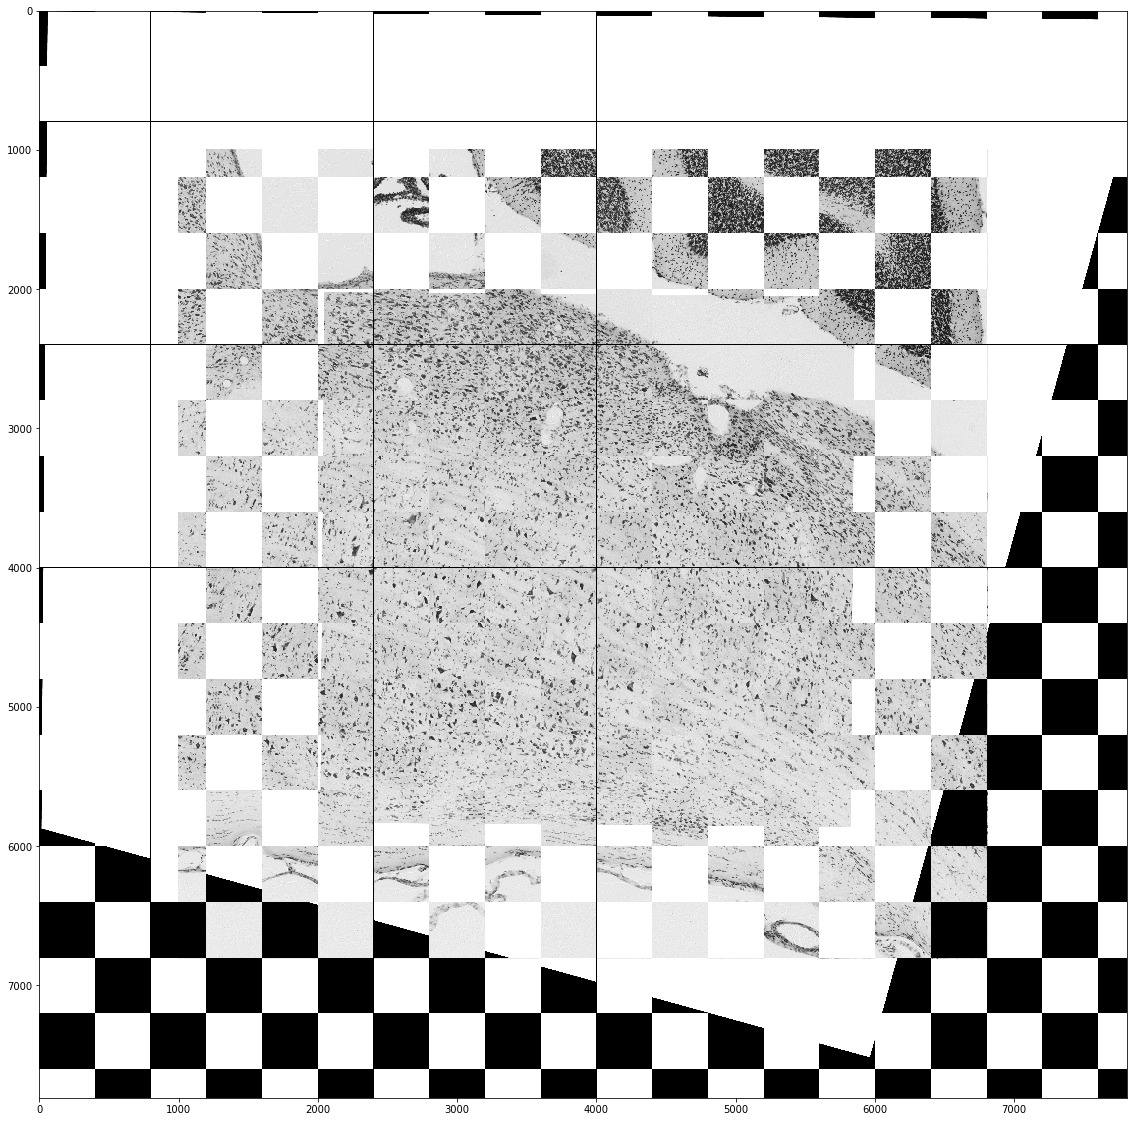

In [269]:
grid_size = 400

# im_mTof_colored = np.zeros(im2_alignedTo_im1_lossless.shape + (3,))
# im_mTof_colored[..., 0] = im2_alignedTo_im1_lossless
# im_f_colored = np.zeros(im1_cropped_lossless_padded.shape + (3,))
# im_f_colored[..., 1] = im1_cropped_lossless_padded

im_mTof_colored = np.zeros(im2_alignedTo_im1_lossless.shape, dtype=np.uint8)
im_mTof_colored[..., :] = im2_alignedTo_im1_lossless
im_f_colored = np.zeros(im1_cropped_lossless_padded.shape, dtype=np.uint8)
im_f_colored[..., :] = im1_cropped_lossless_padded

im_checkerboard_colored = im_mTof_colored.copy()
for zi, z in enumerate(range(0, im2_alignedTo_im1_lossless.shape[1], grid_size)):
    for yi, y in enumerate(range(0, im2_alignedTo_im1_lossless.shape[0], grid_size)):
        if (zi + yi) % 2 == 1:
            im_checkerboard_colored[y:y+grid_size, z:z+grid_size] = im_f_colored[y:y+grid_size, z:z+grid_size].copy()
            
            
im_checkerboard_colored[::grid_size, :] = 0
im_checkerboard_colored[:, ::grid_size] = 0
            
plt.figure(figsize=(20,20));
plt.imshow(im_checkerboard_colored, cmap=plt.cm.gray, vmin=0, vmax=255);
plt.show();

In [270]:
display_image(im_checkerboard_colored)

/shared/MouseBrainAtlas/preprocess/tmp.jpg

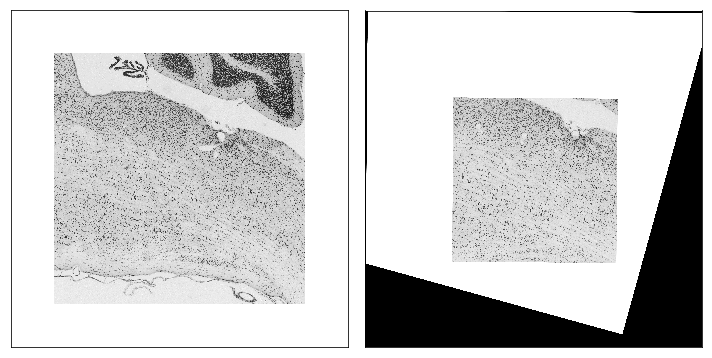

In [271]:
display_images_in_grids([im1_cropped_lossless_padded, im2_alignedTo_im1_lossless],
                       nc=2, vmin=0, vmax=255, cmap=plt.cm.gray)

In [272]:
display_image(im1_cropped_lossless_padded)

/shared/MouseBrainAtlas/preprocess/tmp.jpg

In [273]:
display_image(im2_alignedTo_im1_lossless)

/shared/MouseBrainAtlas/preprocess/tmp.jpg